Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pasude labeling (thresholds:0.5), timeout
# Version = "v9" # pasude labeling (thresholds:0.6), timeout
Version = "v10" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=50
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Threshold = 0.6

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
annot = pd.read_csv("../input/moa-annot-data/20201016_moa_sig_list.csv")
annot.head()

,sig_id,annot1,annot2,annot3
0,acetylcholine_receptor_agonist,acetylcholine_release_enhancer,NaN,NaN
1,acetylcholine_receptor_antagonist,atherogenesis_inhibitor,NaN,NaN
2,adenosine_receptor_antagonist,adenosine_deaminase_inhibitor,NaN,NaN
3,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN,NaN
4,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN,NaN


In [9]:
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['acetylcholine_receptor_agonist', 'acetylcholine_receptor_antagonist', 'adenosine_receptor_antagonist', 'adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'angiotensin_receptor_antagonist', 'anti-inflammatory', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'apoptosis_stimulant', 'atm_kinase_inhibitor', 'atp-sensitive_potassium_channel_antagonist', 'atp_synthase_inhibitor', 'atr_kinase_inhibitor', 'autotaxin_inhibitor', 'bacterial_membrane_integrity_inhibitor', 'bcr-abl_inhibitor', 'calcineurin_inhibitor', 'caspase_activator', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'chk_inhibitor', 'coagulation_factor_inhibitor', 'dopamine_receptor_agonist', 'elastase_inhibitor', 'erbb2_inhibitor', 'free_radical_scavenger', 'fungal_squalene_epoxidase_inhibitor', 'gaba_receptor_agonist', 'gaba_receptor_antagonist', 'glutamate_receptor_agonist', 'histamine_receptor_antagonist', 'histone_lysine_demethylase_inhibitor', 'hiv_inhibitor', 'imidazoline_re

In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1以上であれば1に置換
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str, Threshold):
    target = get_target(target_col, annot_sig)
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500,len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test, threshold=Threshold)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
    
    
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)


        y_pred = model.predict(X_test, num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [13]:
def pseudo_labeling(X_train, y_train, X_test, max_iter=3, threshold=0.5):
       
    X = X_train.copy()
    y = y_train.copy()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = []
        for fold_, (train_index, valid_index) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_index, :], X.loc[valid_index, :]
            y_tr, y_val = y[train_index], y[valid_index]
 
            lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_cols)
            lgb_eval = lgb.Dataset(X_val,y_val,reference=lgb_train,categorical_feature=categorical_cols)
        
            model = lgb.train(params,
                              lgb_train,
                              valid_sets=[lgb_train, lgb_eval],
                              verbose_eval=100,
                              num_boost_round=Num_boost_round,
                              early_stopping_rounds=Early_stopping_rounds)
        
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            y_preds.append(y_pred)
            
        p_label = pd.Series(sum(y_preds) / len(y_preds))
        p_label = p_label.where(p_label < threshold, 1)
        p_label = p_label.where(p_label >= threshold, 0)
 
        X = pd.concat([X_train, X_test], axis=0, ignore_index=True)
        y = pd.concat([y_train, p_label], axis=0, ignore_index=True)
        
    return X, y

In [14]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [15]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [16]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [17]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [18]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [19]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
25,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
40,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
47,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
63,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,train
23747,id_ff469c482,0,2,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,train
23768,id_ff89331ca,0,2,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,train
23793,id_ffd26f361,0,1,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,train


In [20]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274,train
1862,id_fbba92030,0,2,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173,train
1863,id_fbc0849ad,0,2,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504,train
1864,id_fd93fa37d,0,2,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925,train


In [21]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in data.cp_time.unique():
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        f_div = lambda x: (x+d) / (abs(med)+d)
        select_d = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select,select_d], axis=1, sort=False)
        data_df = pd.concat([data_df, tmp_data], axis=0)
data_df

4534
4538
4561
4536
5079
4548


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [22]:
# clipping
clipping = data_df.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [23]:
data_df.cp_type = data_df.cp_type.astype('int64')
data_df.cp_time = data_df.cp_time.astype('int64')
data_df.cp_dose = data_df.cp_dose.astype('int64')
data_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
d_c-95     float64
d_c-96     float64
d_c-97     float64
d_c-98     float64
d_c-99     float64
Length: 1748, dtype: object

In [24]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [25]:
data_df['WHERE'] = Splitdata
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303,train
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866,train
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519,train
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843,test
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932,test
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938,test
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391,test


In [26]:
train = data_df[data_df['WHERE']=="train"].drop('WHERE', axis=1)
test = data_df[data_df['WHERE']=="test"].drop('WHERE', axis=1)

In [27]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr = train.iloc[:, 4:]
ts = test.iloc[:, 4:]

list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train = train.drop(list_discarded, axis=1)
test = test.drop(list_discarded, axis=1)

print(f"Removed {len(list_discarded)} columns")


Removed 408 columns


In [28]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99,WHERE
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303,train
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866,train
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032,train
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519,train
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843,test
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932,test
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938,test
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391,test


In [29]:
Splitdata = data["WHERE"]
data = data.drop('WHERE', axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-85,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,0.610453,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,2.368506,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,-2.098055,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.927045,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-12.466870,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,0.977743,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-3.525817,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,2.350949,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-6.247984,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391


In [30]:
# Based on v8 notebook with feature importance
Feature_importance = [
    "g-104",
    "g-307",
    "g-46",
    "g-219",
    "d_g-104",
    "d_g-307",
    "d_g-46",
    "d_g-216",
    "d_g-219",
    "d_g-153",
]

In [31]:
FI = data[Feature_importance]
FI

,g-104,g-307,g-46,g-219,d_g-104,d_g-307,d_g-46,d_g-216,d_g-219,d_g-153
0,-0.1181,-0.24180,-0.1143,0.2482,-118099.0,-241799.0,-1.970638e+00,4.616837,1.185290e+00,-11.613288
1,0.1227,0.00000,0.1312,0.2772,122701.0,1.0,2.262047e+00,-0.481498,1.323781e+00,17.350905
2,0.5925,0.00000,0.7736,-0.5217,592501.0,1.0,1.333772e+01,-0.812117,-2.491387e+00,-10.828763
3,0.1426,-0.24650,0.6869,0.1076,142601.0,-246499.0,1.184292e+01,-11.390441,5.138514e-01,-3.636894
4,0.3467,-0.16830,0.7055,0.1538,346701.0,-168299.0,1.216360e+01,9.178934,7.344807e-01,-52.762207
...,...,...,...,...,...,...,...,...,...,...
27791,0.5244,-0.00100,0.2657,-0.2441,524401.0,-999.0,2.657010e+05,2.188177,-2.440990e+05,27.593597
27792,-0.8219,1.13805,5.0000,1.1980,-821899.0,863001.0,5.000001e+06,0.024612,1.198001e+06,-15.565715
27793,0.0000,0.07860,0.0000,-0.1278,1.0,78601.0,1.000000e+00,8.329553,-1.277990e+05,-97.875108
27794,0.3558,-0.94730,-0.6075,-0.3595,355801.0,-947299.0,-6.074990e+05,-7.773570,-3.594990e+05,-246.610807


In [32]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]

g_list

['g-1',
 'g-2',
 'g-4',
 'g-5',
 'g-6',
 'g-8',
 'g-9',
 'g-10',
 'g-12',
 'g-13',
 'g-14',
 'g-15',
 'g-16',
 'g-18',
 'g-19',
 'g-20',
 'g-23',
 'g-24',
 'g-25',
 'g-26',
 'g-27',
 'g-28',
 'g-29',
 'g-30',
 'g-31',
 'g-32',
 'g-33',
 'g-34',
 'g-35',
 'g-36',
 'g-38',
 'g-39',
 'g-40',
 'g-41',
 'g-42',
 'g-43',
 'g-44',
 'g-45',
 'g-46',
 'g-47',
 'g-48',
 'g-49',
 'g-50',
 'g-51',
 'g-53',
 'g-54',
 'g-55',
 'g-56',
 'g-57',
 'g-58',
 'g-59',
 'g-61',
 'g-62',
 'g-64',
 'g-65',
 'g-67',
 'g-69',
 'g-70',
 'g-71',
 'g-73',
 'g-74',
 'g-77',
 'g-78',
 'g-79',
 'g-81',
 'g-83',
 'g-87',
 'g-88',
 'g-89',
 'g-90',
 'g-91',
 'g-93',
 'g-94',
 'g-95',
 'g-96',
 'g-97',
 'g-99',
 'g-103',
 'g-104',
 'g-105',
 'g-106',
 'g-107',
 'g-108',
 'g-109',
 'g-110',
 'g-111',
 'g-113',
 'g-114',
 'g-115',
 'g-116',
 'g-117',
 'g-118',
 'g-119',
 'g-121',
 'g-122',
 'g-123',
 'g-124',
 'g-125',
 'g-126',
 'g-127',
 'g-128',
 'g-129',
 'g-130',
 'g-131',
 'g-132',
 'g-133',
 'g-136',
 'g-137',
 'g-

In [33]:
from sklearn.preprocessing import StandardScaler
    
# Z-score
scaler = StandardScaler(with_mean=True, with_std=True)
std_values = scaler.fit_transform(data.iloc[:, 4:])
std_df = pd.DataFrame(std_values, index=data.index, columns=data.columns[4:])
    

In [34]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA for all data
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_all = pca_transformer.fit_transform(std_df)

# PCA → UMAP for all data
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_all = umap.fit_transform(pca_all)

print(pca_umap_all.shape)

(27796, 10)


In [35]:
# PCA for merged categories
g_d_g_list = g_list + d_g_list
c_d_c_list = c_list + d_c_list

pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])

# PCA → UMAP for merged categories
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g_d_g = umap.fit_transform(pca_g_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c_d_c = umap.fit_transform(pca_c_d_c)

print(pca_umap_g_d_g.shape)
print(pca_umap_c_d_c.shape)

(27796, 10)
(27796, 2)


In [36]:
# PCA for each category
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

# PCA → UMAP for each category
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g = umap.fit_transform(pca_g)
pca_umap_d_g = umap.fit_transform(pca_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c = umap.fit_transform(pca_c)
pca_umap_d_c = umap.fit_transform(pca_d_c)

print(pca_umap_g.shape)
print(pca_umap_c.shape)
print(pca_umap_d_g.shape)
print(pca_umap_d_c.shape)

(27796, 323)
(27796, 13)
(27796, 394)
(27796, 25)
(27796, 10)
(27796, 2)
(27796, 10)
(27796, 2)


In [37]:
# PCA for all categories
pca_transformer = PCA(n_components=3, whiten=True, random_state=SEED)

pca_all = pca_transformer.fit_transform(std_df)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_all.shape)
print(pca_g_d_g.shape)
print(pca_c_d_c.shape)
print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [38]:
data_list = [ 
    pca_umap_all,
    pca_umap_g_d_g,
    pca_umap_c_d_c,
    pca_umap_g,
    pca_umap_c,
    pca_umap_d_g,
    pca_umap_d_c,
    pca_all,
    pca_g_d_g,
    pca_c_d_c,
    pca_g,
    pca_c,
    pca_d_g,
    pca_d_c,
]

data_names = [ 
    "pca_umap_all",
    "pca_umap_g_d_g",
    "pca_umap_c_d_c",
    "pca_umap_g",
    "pca_umap_c",
    "pca_umap_d_g",
    "pca_umap_d_c",
    "pca_all",
    "pca_g_d_g",
    "pca_c_d_c",
    "pca_g",
    "pca_c",
    "pca_d_g",
    "pca_d_c",
]

In [39]:
col_list = []
for i, d in enumerate(data_list):
    for j in range(d.shape[1]):
        col_list.append( f"{data_names[i]}_{j+1}")
col_list

['pca_umap_all_1',
 'pca_umap_all_2',
 'pca_umap_all_3',
 'pca_umap_all_4',
 'pca_umap_all_5',
 'pca_umap_all_6',
 'pca_umap_all_7',
 'pca_umap_all_8',
 'pca_umap_all_9',
 'pca_umap_all_10',
 'pca_umap_g_d_g_1',
 'pca_umap_g_d_g_2',
 'pca_umap_g_d_g_3',
 'pca_umap_g_d_g_4',
 'pca_umap_g_d_g_5',
 'pca_umap_g_d_g_6',
 'pca_umap_g_d_g_7',
 'pca_umap_g_d_g_8',
 'pca_umap_g_d_g_9',
 'pca_umap_g_d_g_10',
 'pca_umap_c_d_c_1',
 'pca_umap_c_d_c_2',
 'pca_umap_g_1',
 'pca_umap_g_2',
 'pca_umap_g_3',
 'pca_umap_g_4',
 'pca_umap_g_5',
 'pca_umap_g_6',
 'pca_umap_g_7',
 'pca_umap_g_8',
 'pca_umap_g_9',
 'pca_umap_g_10',
 'pca_umap_c_1',
 'pca_umap_c_2',
 'pca_umap_d_g_1',
 'pca_umap_d_g_2',
 'pca_umap_d_g_3',
 'pca_umap_d_g_4',
 'pca_umap_d_g_5',
 'pca_umap_d_g_6',
 'pca_umap_d_g_7',
 'pca_umap_d_g_8',
 'pca_umap_d_g_9',
 'pca_umap_d_g_10',
 'pca_umap_d_c_1',
 'pca_umap_d_c_2',
 'pca_all_1',
 'pca_all_2',
 'pca_all_3',
 'pca_g_d_g_1',
 'pca_g_d_g_2',
 'pca_g_d_g_3',
 'pca_c_d_c_1',
 'pca_c_d_c_2',


In [40]:
result_df = pd.DataFrame(data_list[0])
for d in data_list[1:]:
    tmp_df = pd.DataFrame(d)
    result_df = pd.concat([result_df, tmp_df], axis=1)
result_df.columns = col_list
result_df

,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,pca_umap_all_7,pca_umap_all_8,pca_umap_all_9,pca_umap_all_10,...,pca_g_3,pca_c_1,pca_c_2,pca_c_3,pca_d_g_1,pca_d_g_2,pca_d_g_3,pca_d_c_1,pca_d_c_2,pca_d_c_3
0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,-0.631963,0.520953,-0.489372,0.596058,...,-1.140890,-0.469951,0.099505,0.543770,-0.412404,0.344801,0.037566,-0.352178,0.185292,0.004245
1,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,-0.837569,0.656989,0.557744,0.862181,...,0.393231,-0.814709,0.613391,-0.238404,-0.522178,-0.182825,0.440264,-0.575022,0.122275,0.280131
2,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,-1.044028,0.611787,0.327000,0.522496,...,-0.603388,-0.262629,-0.104706,0.204114,-0.150261,0.224066,-0.477699,-0.254322,0.146491,-0.005201
3,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,-0.463792,0.222208,0.172640,0.482514,...,0.520171,-0.202956,-0.340746,-1.418043,-0.040187,-0.775782,-0.318853,-0.157597,-0.122486,-0.020528
4,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,-0.936194,0.003462,1.613957,0.086733,...,-2.687000,1.478095,0.804459,2.194776,1.834257,0.532104,-2.136533,0.808826,-0.534457,-0.547478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,-0.518431,0.616687,-0.967858,0.699507,...,0.282427,-0.124308,-0.178446,0.631366,-0.533474,1.250751,0.927038,-0.070210,0.002111,-0.157756
27792,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,-0.553066,0.555583,-0.925586,0.635752,...,-2.186621,0.986815,5.615881,-1.809798,1.305137,1.420641,-1.273816,1.123556,-2.183204,0.610776
27793,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,-1.325753,0.832510,0.902315,1.563123,...,-1.047883,-0.212064,0.409555,2.046140,-0.126035,0.358089,-0.604766,-0.223797,0.372728,0.561805
27794,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,-0.554051,0.652266,-0.881698,0.647011,...,0.111515,0.261040,-0.357443,0.309463,-0.092845,-0.936262,-0.360358,0.259394,-0.407341,0.143140


In [41]:
# Merge data
result_df = pd.concat([result_df, FI], axis=1)

In [42]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], result_df], axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,g-104,g-307,g-46,g-219,d_g-104,d_g-307,d_g-46,d_g-216,d_g-219,d_g-153
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,-0.1181,-0.24180,-0.1143,0.2482,-118099.0,-241799.0,-1.970638e+00,4.616837,1.185290e+00,-11.613288
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.1227,0.00000,0.1312,0.2772,122701.0,1.0,2.262047e+00,-0.481498,1.323781e+00,17.350905
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,0.5925,0.00000,0.7736,-0.5217,592501.0,1.0,1.333772e+01,-0.812117,-2.491387e+00,-10.828763
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,0.1426,-0.24650,0.6869,0.1076,142601.0,-246499.0,1.184292e+01,-11.390441,5.138514e-01,-3.636894
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,0.3467,-0.16830,0.7055,0.1538,346701.0,-168299.0,1.216360e+01,9.178934,7.344807e-01,-52.762207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,0.5244,-0.00100,0.2657,-0.2441,524401.0,-999.0,2.657010e+05,2.188177,-2.440990e+05,27.593597
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,-0.8219,1.13805,5.0000,1.1980,-821899.0,863001.0,5.000001e+06,0.024612,1.198001e+06,-15.565715
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,0.0000,0.07860,0.0000,-0.1278,1.0,78601.0,1.000000e+00,8.329553,-1.277990e+05,-97.875108
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,0.3558,-0.94730,-0.6075,-0.3595,355801.0,-947299.0,-6.074990e+05,-7.773570,-3.594990e+05,-246.610807


In [43]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,g-104,g-307,g-46,g-219,d_g-104,d_g-307,d_g-46,d_g-216,d_g-219,d_g-153
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.407962,0.927889,-0.848250,0.769027,...,-0.1181,-0.241800,-0.1143,0.2482,-118099.0,-241799.0,-1.970638e+00,4.616837,1.185290e+00,-11.613288
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.1227,0.000000,0.1312,0.2772,122701.0,1.0,2.262047e+00,-0.481498,1.323781e+00,17.350905
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,0.5925,0.000000,0.7736,-0.5217,592501.0,1.0,1.333772e+01,-0.812117,-2.491387e+00,-10.828763
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,0.1426,-0.246500,0.6869,0.1076,142601.0,-246499.0,1.184292e+01,-11.390441,5.138514e-01,-3.636894
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.923120,0.013562,...,0.3467,-0.168300,0.7055,0.1538,346701.0,-168299.0,1.216360e+01,9.178934,7.344807e-01,-52.762207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,0.5244,-0.001000,0.2657,-0.2441,524401.0,-999.0,2.657010e+05,2.188177,-2.440990e+05,27.593597
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,-0.8219,1.138002,5.0000,1.1980,-821899.0,863001.0,5.000001e+06,0.024612,1.198001e+06,-15.565715
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.162132,-0.885569,-0.035729,...,0.0000,0.078600,0.0000,-0.1278,1.0,78601.0,1.000000e+00,8.329553,-1.277990e+05,-97.875108
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.407962,0.766808,-0.643382,0.663832,...,0.3558,-0.947300,-0.6075,-0.3595,355801.0,-947299.0,-6.074990e+05,-7.773570,-3.594990e+05,-246.610807


In [44]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [45]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'num_leaves': 27,
    'max_depth': 7,
    'objective': 'binary',
    'learning_rate': Learning_rate,
    'num_threads': 2
}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [46]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col, Threshold)

    sub[target_col] = _preds
    scores.append(_score)
        
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0734624	valid_1's binary_logloss: 0.138692
[200]	training's binary_logloss: 0.0110322	valid_1's binary_logloss: 0.0556352
[300]	training's binary_logloss: 0.00171301	valid_1's binary_logloss: 0.0354837
[400]	training's binary_logloss: 0.000275018	valid_1's binary_logloss: 0.0266627
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000251166	valid_1's binary_logloss: 0.026412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0727918	valid_1's binary_logloss: 0.136375
[200]	training's binary_logloss: 0.0104442	valid_1's binary_logloss: 0.0604358


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00160877	valid_1's binary_logloss: 0.0412153
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000954655	valid_1's binary_logloss: 0.0396307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184144	valid_1's binary_logloss: 0.0435215
[200]	training's binary_logloss: 0.00203846	valid_1's binary_logloss: 0.0290836
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.00171571	valid_1's binary_logloss: 0.028913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177026	valid_1's binary_logloss: 0.0431207
[200]	training's binary_logloss: 0.00193304	valid_1's binary_logloss: 0.0296209


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.000487178	valid_1's binary_logloss: 0.0276463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166217	valid_1's binary_logloss: 0.0366626
[200]	training's binary_logloss: 0.00167995	valid_1's binary_logloss: 0.0226652
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.00175595	valid_1's binary_logloss: 0.0225797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195154	valid_1's binary_logloss: 0.0302654
[200]	training's binary_logloss: 0.00238777	valid_1's binary_logloss: 0.0104069
[300]	training's binary_logloss: 0.00029413	valid_1's binary_logloss: 0.00673267
[400]	training's binary_logloss: 3.13384e-05	valid_1's binary_logloss: 0.00496911


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Early stopping, best iteration is:
[450]	training's binary_logloss: 1.14199e-05	valid_1's binary_logloss: 0.00443552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176578	valid_1's binary_logloss: 0.0351337
[200]	training's binary_logloss: 0.00200379	valid_1's binary_logloss: 0.0194645


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Early stopping, best iteration is:
[232]	training's binary_logloss: 0.000971006	valid_1's binary_logloss: 0.0179986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174567	valid_1's binary_logloss: 0.0301966
[200]	training's binary_logloss: 0.00185117	valid_1's binary_logloss: 0.0102434
[300]	training's binary_logloss: 0.000231924	valid_1's binary_logloss: 0.00649299
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.000158801	valid_1's binary_logloss: 0.00597605


5-alpha_reductase_inhibitor logloss: 0.011987338459550809
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0709283	valid_1's binary_logloss: 0.147137
[200]	training's binary_logloss: 0.00889614	valid_1's binary_logloss: 0.0768732
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00159358	valid_1's binary_logloss: 0.0647057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0745194	valid_1's binary_logloss: 0.119768
[200]	training's binary_logloss: 0.0110853	valid_1's binary_logloss: 0.0581252


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00263515	valid_1's binary_logloss: 0.0449674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275965	valid_1's binary_logloss: 0.0755837
[200]	training's binary_logloss: 0.00420496	valid_1's binary_logloss: 0.059618
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00301098	valid_1's binary_logloss: 0.0592949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339551	valid_1's binary_logloss: 0.0677072
[200]	training's binary_logloss: 0.0060414	valid_1's binary_logloss: 0.0476861


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00144473	valid_1's binary_logloss: 0.0462233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263409	valid_1's binary_logloss: 0.0608121
[200]	training's binary_logloss: 0.00376715	valid_1's binary_logloss: 0.0431551
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00236595	valid_1's binary_logloss: 0.0424266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256925	valid_1's binary_logloss: 0.0546673
[200]	training's binary_logloss: 0.00366943	valid_1's binary_logloss: 0.0358436


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.000998857	valid_1's binary_logloss: 0.0342227
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023452	valid_1's binary_logloss: 0.0466785
[200]	training's binary_logloss: 0.00304181	valid_1's binary_logloss: 0.0294859


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00192153	valid_1's binary_logloss: 0.0289753
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217217	valid_1's binary_logloss: 0.0527632
[200]	training's binary_logloss: 0.00256893	valid_1's binary_logloss: 0.0326896


11-beta-hsd1_inhibitor logloss: 0.03016848184051353
acat_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00107773	valid_1's binary_logloss: 0.0313617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782392	valid_1's binary_logloss: 0.187798
[200]	training's binary_logloss: 0.0128988	valid_1's binary_logloss: 0.101756
[300]	training's binary_logloss: 0.00219253	valid_1's binary_logloss: 0.0796539
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000618525	valid_1's binary_logloss: 0.0733429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0864755	valid_1's binary_logloss: 0.153537
[200]	training's binary_logloss: 0.013855	valid_1's binary_logloss: 0.080629
[300]	training's binary_logloss: 0.00241157	valid_1's binary_logloss: 0.0608636


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.000428423	valid_1's binary_logloss: 0.0529114
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000375288	valid_1's binary_logloss: 0.052193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253616	valid_1's binary_logloss: 0.0515294
[200]	training's binary_logloss: 0.00339997	valid_1's binary_logloss: 0.0292705
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00127619	valid_1's binary_logloss: 0.0272077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229364	valid_1's binary_logloss: 0.0565632
[200]	training's binary_logloss: 0.00326204	valid_1's binary_logloss: 0.0422161


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.000778561	valid_1's binary_logloss: 0.0399301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206829	valid_1's binary_logloss: 0.0501056
[200]	training's binary_logloss: 0.00277567	valid_1's binary_logloss: 0.0318647
[300]	training's binary_logloss: 0.000362081	valid_1's binary_logloss: 0.0261031
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000124809	valid_1's binary_logloss: 0.0247606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224125	valid_1's binary_logloss: 0.0394836
[200]	training's binary_logloss: 0.00309932	valid_1's binary_logloss: 0.0174527
[300]	training's binary_logloss: 0.000404201	valid_1's binary_logloss: 0.0116646
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.000319181	valid_1's binary_logloss: 0.0113736


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216808	valid_1's binary_logloss: 0.0413356
[200]	training's binary_logloss: 0.00272891	valid_1's binary_logloss: 0.0205655
[300]	training's binary_logloss: 0.000364609	valid_1's binary_logloss: 0.0141287
[400]	training's binary_logloss: 4.61547e-05	valid_1's binary_logloss: 0.0114499
Early stopping, best iteration is:
[397]	training's binary_logloss: 4.88618e-05	valid_1's binary_logloss: 0.0113734


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021761	valid_1's binary_logloss: 0.0469317
[200]	training's binary_logloss: 0.00288821	valid_1's binary_logloss: 0.026038
[300]	training's binary_logloss: 0.00037132	valid_1's binary_logloss: 0.019227


acat_inhibitor logloss: 0.014560030644814145


Early stopping, best iteration is:
[372]	training's binary_logloss: 8.36566e-05	valid_1's binary_logloss: 0.0177466


acetylcholine_receptor_agonist , len(trt) : 196
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249655	valid_1's binary_logloss: 0.608372
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.155076	valid_1's binary_logloss: 0.598311
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.245638	valid_1's binary_logloss: 0.586351
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.171851	valid_1's binary_logloss: 0.576209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100123	valid_1's binary_logloss: 0.238915
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.0476277	valid_1's binary_logloss: 0.227449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10177	valid_1's binary_logloss: 0.231288
[200]	training's binary_logloss: 0.0445171	valid_1's binary_logloss: 0.214691


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0345936	valid_1's binary_logloss: 0.213527
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0768783	valid_1's binary_logloss: 0.196609
[200]	training's binary_logloss: 0.0284137	valid_1's binary_logloss: 0.187734
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0234055	valid_1's binary_logloss: 0.186707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0887035	valid_1's binary_logloss: 0.186562
[200]	training's binary_logloss: 0.0388399	valid_1's binary_logloss: 0.167273


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0214921	valid_1's binary_logloss: 0.162378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0745642	valid_1's binary_logloss: 0.17598
[200]	training's binary_logloss: 0.0304151	valid_1's binary_logloss: 0.162678


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0199913	valid_1's binary_logloss: 0.160693
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.083768	valid_1's binary_logloss: 0.170509
[200]	training's binary_logloss: 0.0347855	valid_1's binary_logloss: 0.157515
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0319998	valid_1's binary_logloss: 0.157237


acetylcholine_receptor_agonist logloss: 0.15896514266503248
acetylcholine_receptor_antagonist , len(trt) : 307
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.412982	valid_1's binary_logloss: 0.663048
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[27]	training's binary_logloss: 0.535494	valid_1's binary_logloss: 0.677729
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0929323	valid_1's binary_logloss: 0.233036
Early stopping, best iteration is:
[121]	training's binary_logloss: 0.0766964	valid_1's binary_logloss: 0.231112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919446	valid_1's binary_logloss: 0.218993


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[168]	training's binary_logloss: 0.0519731	valid_1's binary_logloss: 0.21344
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738521	valid_1's binary_logloss: 0.186166
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.0530062	valid_1's binary_logloss: 0.184378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0728414	valid_1's binary_logloss: 0.18606


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[124]	training's binary_logloss: 0.061791	valid_1's binary_logloss: 0.185322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740642	valid_1's binary_logloss: 0.170546


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0608116	valid_1's binary_logloss: 0.169446
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0776125	valid_1's binary_logloss: 0.174902


acetylcholine_receptor_antagonist logloss: 0.16917819308760274
acetylcholinesterase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[158]	training's binary_logloss: 0.0492007	valid_1's binary_logloss: 0.16891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180016	valid_1's binary_logloss: 0.381942
[200]	training's binary_logloss: 0.0607518	valid_1's binary_logloss: 0.308874
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0276989	valid_1's binary_logloss: 0.282595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173619	valid_1's binary_logloss: 0.407856


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0560873	valid_1's binary_logloss: 0.354884
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0447214	valid_1's binary_logloss: 0.35312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613465	valid_1's binary_logloss: 0.145566
[200]	training's binary_logloss: 0.0168683	valid_1's binary_logloss: 0.124018
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00639389	valid_1's binary_logloss: 0.119684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0607332	valid_1's binary_logloss: 0.143217
[200]	training's binary_logloss: 0.0171	valid_1's binary_logloss: 0.116892


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0103576	valid_1's binary_logloss: 0.113481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489955	valid_1's binary_logloss: 0.114667
[200]	training's binary_logloss: 0.0128656	valid_1's binary_logloss: 0.0932547
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0095531	valid_1's binary_logloss: 0.0915076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553579	valid_1's binary_logloss: 0.119999
[200]	training's binary_logloss: 0.0143716	valid_1's binary_logloss: 0.0977374


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00479215	valid_1's binary_logloss: 0.0945755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0468392	valid_1's binary_logloss: 0.104469
[200]	training's binary_logloss: 0.0115287	valid_1's binary_logloss: 0.0789865
[300]	training's binary_logloss: 0.00280111	valid_1's binary_logloss: 0.0697234


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00144205	valid_1's binary_logloss: 0.0682013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0469974	valid_1's binary_logloss: 0.097408
[200]	training's binary_logloss: 0.0129482	valid_1's binary_logloss: 0.0725395


acetylcholinesterase_inhibitor logloss: 0.06801518221671303
adenosine_receptor_agonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00442475	valid_1's binary_logloss: 0.0678291
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184671	valid_1's binary_logloss: 0.363543
[200]	training's binary_logloss: 0.0579511	valid_1's binary_logloss: 0.262019
[300]	training's binary_logloss: 0.0189567	valid_1's binary_logloss: 0.2233
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00902263	valid_1's binary_logloss: 0.214341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147471	valid_1's binary_logloss: 0.388072


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0415908	valid_1's binary_logloss: 0.322054
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0270915	valid_1's binary_logloss: 0.315851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444741	valid_1's binary_logloss: 0.0983923
[200]	training's binary_logloss: 0.011747	valid_1's binary_logloss: 0.0775194
[300]	training's binary_logloss: 0.00313072	valid_1's binary_logloss: 0.0732143
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00280952	valid_1's binary_logloss: 0.0730912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419946	valid_1's binary_logloss: 0.0876656
[200]	training's binary_logloss: 0.0103104	valid_1's binary_logloss: 0.0608909
[300]	training's binary_logloss: 0.00264708	valid_1's binary_logloss: 0.0528552


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00118334	valid_1's binary_logloss: 0.0516513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376938	valid_1's binary_logloss: 0.091812
[200]	training's binary_logloss: 0.00935128	valid_1's binary_logloss: 0.0707867
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00384822	valid_1's binary_logloss: 0.06559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445471	valid_1's binary_logloss: 0.0849211
[200]	training's binary_logloss: 0.0116234	valid_1's binary_logloss: 0.0580985
[300]	training's binary_logloss: 0.0032229	valid_1's binary_logloss: 0.049453
[400]	training's binary_logloss: 0.000864843	valid_1's binary_logloss: 0.0461554
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00087681	valid_1's binary_logloss: 0.0460771


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400612	valid_1's binary_logloss: 0.0884693
[200]	training's binary_logloss: 0.00964896	valid_1's binary_logloss: 0.0645415


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adenosine_receptor_agonist=================================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00301482	valid_1's binary_logloss: 0.059424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042611	valid_1's binary_logloss: 0.0815484
[200]	training's binary_logloss: 0.0106003	valid_1's binary_logloss: 0.0490271
[300]	training's binary_logloss: 0.00286986	valid_1's binary_logloss: 0.0381405
[400]	training's binary_logloss: 0.000663014	valid_1's binary_logloss: 0.0316193
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.000507588	valid_1's binary_logloss: 0.0309417


adenosine_receptor_agonist logloss: 0.04518284181175028
adenosine_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199571	valid_1's binary_logloss: 0.449599
[200]	training's binary_logloss: 0.0743831	valid_1's binary_logloss: 0.407081
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0580189	valid_1's binary_logloss: 0.404692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18517	valid_1's binary_logloss: 0.473038


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0662166	valid_1's binary_logloss: 0.42858
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0456263	valid_1's binary_logloss: 0.422126
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681015	valid_1's binary_logloss: 0.16675
[200]	training's binary_logloss: 0.0229532	valid_1's binary_logloss: 0.147685
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0175201	valid_1's binary_logloss: 0.146749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765375	valid_1's binary_logloss: 0.158944
[200]	training's binary_logloss: 0.025997	valid_1's binary_logloss: 0.135097


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0182462	valid_1's binary_logloss: 0.133163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0552232	valid_1's binary_logloss: 0.136571
[200]	training's binary_logloss: 0.0164778	valid_1's binary_logloss: 0.118733
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00908949	valid_1's binary_logloss: 0.116347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614545	valid_1's binary_logloss: 0.125227
[200]	training's binary_logloss: 0.0196855	valid_1's binary_logloss: 0.10009
[300]	training's binary_logloss: 0.00739314	valid_1's binary_logloss: 0.0917555


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adenosine_receptor_antagonist=================================


Early stopping, best iteration is:
[342]	training's binary_logloss: 0.0047292	valid_1's binary_logloss: 0.0905648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532948	valid_1's binary_logloss: 0.12367
[200]	training's binary_logloss: 0.0150061	valid_1's binary_logloss: 0.102866


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adenosine_receptor_antagonist=================================


Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0106533	valid_1's binary_logloss: 0.100344
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516167	valid_1's binary_logloss: 0.117083


adenosine_receptor_antagonist logloss: 0.1018633402981254
adenylyl_cyclase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[188]	training's binary_logloss: 0.0183743	valid_1's binary_logloss: 0.103383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0730445	valid_1's binary_logloss: 0.137377
[200]	training's binary_logloss: 0.0110804	valid_1's binary_logloss: 0.0690483
[300]	training's binary_logloss: 0.00176687	valid_1's binary_logloss: 0.0540955
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.000628914	valid_1's binary_logloss: 0.0502652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0794589	valid_1's binary_logloss: 0.143596
[200]	training's binary_logloss: 0.0122322	valid_1's binary_logloss: 0.0661929


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00186756	valid_1's binary_logloss: 0.0467996
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00194314	valid_1's binary_logloss: 0.0466459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407878	valid_1's binary_logloss: 0.0976123
[200]	training's binary_logloss: 0.00846895	valid_1's binary_logloss: 0.0688432
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00331258	valid_1's binary_logloss: 0.0656696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376439	valid_1's binary_logloss: 0.109712
[200]	training's binary_logloss: 0.00682854	valid_1's binary_logloss: 0.0823552


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.00356002	valid_1's binary_logloss: 0.079664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028262	valid_1's binary_logloss: 0.081478
[200]	training's binary_logloss: 0.00438617	valid_1's binary_logloss: 0.0544669
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00122227	valid_1's binary_logloss: 0.0516518
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027823	valid_1's binary_logloss: 0.0693746


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adenylyl_cyclase_activator=================================


[200]	training's binary_logloss: 0.00392576	valid_1's binary_logloss: 0.0494114
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.00408799	valid_1's binary_logloss: 0.0492809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208243	valid_1's binary_logloss: 0.0492578
[200]	training's binary_logloss: 0.00209376	valid_1's binary_logloss: 0.0298314


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adenylyl_cyclase_activator=================================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00042162	valid_1's binary_logloss: 0.0271079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212735	valid_1's binary_logloss: 0.0504085
[200]	training's binary_logloss: 0.00230241	valid_1's binary_logloss: 0.0213561
[300]	training's binary_logloss: 0.000300898	valid_1's binary_logloss: 0.0164852
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000271986	valid_1's binary_logloss: 0.0163886


adenylyl_cyclase_activator logloss: 0.021748255448411278
adrenergic_receptor_agonist , len(trt) : 270
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.342958	valid_1's binary_logloss: 0.639651


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.426682	valid_1's binary_logloss: 0.6461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118505	valid_1's binary_logloss: 0.257482
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.0596757	valid_1's binary_logloss: 0.247765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115709	valid_1's binary_logloss: 0.26276


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[166]	training's binary_logloss: 0.0660679	valid_1's binary_logloss: 0.253643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787404	valid_1's binary_logloss: 0.195114
[200]	training's binary_logloss: 0.0301636	valid_1's binary_logloss: 0.184174
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.0324655	valid_1's binary_logloss: 0.183924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816004	valid_1's binary_logloss: 0.203013


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[168]	training's binary_logloss: 0.0441556	valid_1's binary_logloss: 0.195909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0712351	valid_1's binary_logloss: 0.172884


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adrenergic_receptor_agonist=================================


[200]	training's binary_logloss: 0.0277718	valid_1's binary_logloss: 0.163968
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0275038	valid_1's binary_logloss: 0.16392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0690942	valid_1's binary_logloss: 0.173219


adrenergic_receptor_agonist logloss: 0.1655826575029471
adrenergic_receptor_antagonist , len(trt) : 360
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.0359701	valid_1's binary_logloss: 0.167245
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[17]	training's binary_logloss: 0.581184	valid_1's binary_logloss: 0.685341
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.470617	valid_1's binary_logloss: 0.679556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104635	valid_1's binary_logloss: 0.252267
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.0797869	valid_1's binary_logloss: 0.250849
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103963	valid_1's binary_logloss: 0.237841


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[142]	training's binary_logloss: 0.0725005	valid_1's binary_logloss: 0.234966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0713969	valid_1's binary_logloss: 0.183417
Early stopping, best iteration is:
[121]	training's binary_logloss: 0.0595902	valid_1's binary_logloss: 0.181355
Training until validation scores don't improve for 10 rounds


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adrenergic_receptor_antagonist=================================


[100]	training's binary_logloss: 0.076708	valid_1's binary_logloss: 0.190134
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.0794958	valid_1's binary_logloss: 0.189873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0671486	valid_1's binary_logloss: 0.183976
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.0569783	valid_1's binary_logloss: 0.183055


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799006	valid_1's binary_logloss: 0.175594


adrenergic_receptor_antagonist logloss: 0.17709255247934513
akt_inhibitor , len(trt) : 66
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[138]	training's binary_logloss: 0.0586647	valid_1's binary_logloss: 0.17113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147635	valid_1's binary_logloss: 0.331901
[200]	training's binary_logloss: 0.04472	valid_1's binary_logloss: 0.248499
[300]	training's binary_logloss: 0.0144797	valid_1's binary_logloss: 0.214313
[400]	training's binary_logloss: 0.00473587	valid_1's binary_logloss: 0.202166
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00240356	valid_1's binary_logloss: 0.195946
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163665	valid_1's binary_logloss: 0.349933
[200]	training's binary_logloss: 0.0485416	valid_1's binary_logloss: 0.27368


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0205586	valid_1's binary_logloss: 0.259499
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434456	valid_1's binary_logloss: 0.112231
[200]	training's binary_logloss: 0.00941217	valid_1's binary_logloss: 0.0846443
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0034802	valid_1's binary_logloss: 0.0811223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0487203	valid_1's binary_logloss: 0.120257
[200]	training's binary_logloss: 0.0129862	valid_1's binary_logloss: 0.0928197


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00495259	valid_1's binary_logloss: 0.0876995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040044	valid_1's binary_logloss: 0.0971567
[200]	training's binary_logloss: 0.00827397	valid_1's binary_logloss: 0.074914
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00390158	valid_1's binary_logloss: 0.0720284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406113	valid_1's binary_logloss: 0.0895815
[200]	training's binary_logloss: 0.00874804	valid_1's binary_logloss: 0.0612892
[300]	training's binary_logloss: 0.00222359	valid_1's binary_logloss: 0.0542397
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00196914	valid_1's binary_logloss: 0.0541387


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399994	valid_1's binary_logloss: 0.0909235
[200]	training's binary_logloss: 0.0102223	valid_1's binary_logloss: 0.0629281
[300]	training's binary_logloss: 0.00257433	valid_1's binary_logloss: 0.0545016


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 akt_inhibitor=================================


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00117367	valid_1's binary_logloss: 0.0529904
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429515	valid_1's binary_logloss: 0.0844907
[200]	training's binary_logloss: 0.00999153	valid_1's binary_logloss: 0.054425
[300]	training's binary_logloss: 0.00204024	valid_1's binary_logloss: 0.0436522


akt_inhibitor logloss: 0.04711039262493433
aldehyde_dehydrogenase_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000939865	valid_1's binary_logloss: 0.0412303


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0820372	valid_1's binary_logloss: 0.161078
[200]	training's binary_logloss: 0.0134687	valid_1's binary_logloss: 0.0861713
[300]	training's binary_logloss: 0.00253584	valid_1's binary_logloss: 0.0720217
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00110783	valid_1's binary_logloss: 0.069208
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889481	valid_1's binary_logloss: 0.168411
[200]	training's binary_logloss: 0.015005	valid_1's binary_logloss: 0.0751662
[300]	training's binary_logloss: 0.00284567	valid_1's binary_logloss: 0.0526071


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.000534292	valid_1's binary_logloss: 0.0454141
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.000590265	valid_1's binary_logloss: 0.0451739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411959	valid_1's binary_logloss: 0.111068
[200]	training's binary_logloss: 0.00930076	valid_1's binary_logloss: 0.0907719
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0051451	valid_1's binary_logloss: 0.0888345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429187	valid_1's binary_logloss: 0.0880312
[200]	training's binary_logloss: 0.0099129	valid_1's binary_logloss: 0.0611966


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00312072	valid_1's binary_logloss: 0.0575601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283858	valid_1's binary_logloss: 0.0716493
[200]	training's binary_logloss: 0.00464787	valid_1's binary_logloss: 0.0450958
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00335327	valid_1's binary_logloss: 0.0439289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025862	valid_1's binary_logloss: 0.0721346
[200]	training's binary_logloss: 0.0039344	valid_1's binary_logloss: 0.052888


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00301324	valid_1's binary_logloss: 0.0523177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210574	valid_1's binary_logloss: 0.045238
[200]	training's binary_logloss: 0.00218657	valid_1's binary_logloss: 0.0245224


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.000479868	valid_1's binary_logloss: 0.0217301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223909	valid_1's binary_logloss: 0.0484387
[200]	training's binary_logloss: 0.00251455	valid_1's binary_logloss: 0.0234519
[300]	training's binary_logloss: 0.000336734	valid_1's binary_logloss: 0.0175344


aldehyde_dehydrogenase_inhibitor logloss: 0.01923873465247073
alk_inhibitor , len(trt) : 42


Early stopping, best iteration is:
[352]	training's binary_logloss: 0.000122336	valid_1's binary_logloss: 0.0167474


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119793	valid_1's binary_logloss: 0.267837
[200]	training's binary_logloss: 0.0287463	valid_1's binary_logloss: 0.177165
[300]	training's binary_logloss: 0.00770309	valid_1's binary_logloss: 0.148389
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00358039	valid_1's binary_logloss: 0.141489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126598	valid_1's binary_logloss: 0.268401
[200]	training's binary_logloss: 0.0307081	valid_1's binary_logloss: 0.177533
[300]	training's binary_logloss: 0.00748625	valid_1's binary_logloss: 0.148589


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00248668	valid_1's binary_logloss: 0.134106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556112	valid_1's binary_logloss: 0.128992
[200]	training's binary_logloss: 0.0151775	valid_1's binary_logloss: 0.0970493
[300]	training's binary_logloss: 0.00442344	valid_1's binary_logloss: 0.0898232
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00412576	valid_1's binary_logloss: 0.0896532
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0552093	valid_1's binary_logloss: 0.141326
[200]	training's binary_logloss: 0.014847	valid_1's binary_logloss: 0.11439


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0072108	valid_1's binary_logloss: 0.111057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386278	valid_1's binary_logloss: 0.0964907
[200]	training's binary_logloss: 0.00852525	valid_1's binary_logloss: 0.0690635
[300]	training's binary_logloss: 0.00223083	valid_1's binary_logloss: 0.0635369
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00195671	valid_1's binary_logloss: 0.0631498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379599	valid_1's binary_logloss: 0.0983946
[200]	training's binary_logloss: 0.00810316	valid_1's binary_logloss: 0.0747383


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 alk_inhibitor=================================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00292696	valid_1's binary_logloss: 0.0703171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366597	valid_1's binary_logloss: 0.0929227
[200]	training's binary_logloss: 0.0085027	valid_1's binary_logloss: 0.0706929


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 alk_inhibitor=================================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00255305	valid_1's binary_logloss: 0.0651943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332415	valid_1's binary_logloss: 0.0784891
[200]	training's binary_logloss: 0.00630946	valid_1's binary_logloss: 0.0510826
[300]	training's binary_logloss: 0.00123949	valid_1's binary_logloss: 0.0439697
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00112119	valid_1's binary_logloss: 0.0437605


alk_inhibitor logloss: 0.05447738487426066
ampk_activator , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0667813	valid_1's binary_logloss: 0.15285
[200]	training's binary_logloss: 0.00881003	valid_1's binary_logloss: 0.0796393
[300]	training's binary_logloss: 0.00123616	valid_1's binary_logloss: 0.0684418
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00128274	valid_1's binary_logloss: 0.0681343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0682979	valid_1's binary_logloss: 0.125217
[200]	training's binary_logloss: 0.00931323	valid_1's binary_logloss: 0.0631275


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00140064	valid_1's binary_logloss: 0.0524874
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00143092	valid_1's binary_logloss: 0.0521265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232638	valid_1's binary_logloss: 0.044443
[200]	training's binary_logloss: 0.00267667	valid_1's binary_logloss: 0.0240362
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00138961	valid_1's binary_logloss: 0.0228699
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247737	valid_1's binary_logloss: 0.0441235
[200]	training's binary_logloss: 0.00300031	valid_1's binary_logloss: 0.0278181
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.00232804	valid_1's binary_logloss: 0.0276374


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020451	valid_1's binary_logloss: 0.0333652
[200]	training's binary_logloss: 0.0022799	valid_1's binary_logloss: 0.0123785
[300]	training's binary_logloss: 0.00028472	valid_1's binary_logloss: 0.00890498
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000182628	valid_1's binary_logloss: 0.00851677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213448	valid_1's binary_logloss: 0.0339793
[200]	training's binary_logloss: 0.00241836	valid_1's binary_logloss: 0.0113523
[300]	training's binary_logloss: 0.000277473	valid_1's binary_logloss: 0.00711329


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ampk_activator=================================


Early stopping, best iteration is:
[364]	training's binary_logloss: 7.10883e-05	valid_1's binary_logloss: 0.0062399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200441	valid_1's binary_logloss: 0.0320988
[200]	training's binary_logloss: 0.00227934	valid_1's binary_logloss: 0.01196
[300]	training's binary_logloss: 0.000253187	valid_1's binary_logloss: 0.00853832


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ampk_activator=================================


Early stopping, best iteration is:
[385]	training's binary_logloss: 4.30975e-05	valid_1's binary_logloss: 0.00723467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198649	valid_1's binary_logloss: 0.0336447
[200]	training's binary_logloss: 0.00239288	valid_1's binary_logloss: 0.012828
[300]	training's binary_logloss: 0.000298202	valid_1's binary_logloss: 0.00915953


ampk_activator logloss: 0.007594002606463103
analgesic , len(trt) : 12


Early stopping, best iteration is:
[382]	training's binary_logloss: 5.65133e-05	valid_1's binary_logloss: 0.00795334


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476641	valid_1's binary_logloss: 0.085653
[200]	training's binary_logloss: 0.00522067	valid_1's binary_logloss: 0.0409312
[300]	training's binary_logloss: 0.000607669	valid_1's binary_logloss: 0.0326423
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000319667	valid_1's binary_logloss: 0.0316816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048442	valid_1's binary_logloss: 0.110736


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.00487805	valid_1's binary_logloss: 0.0660444
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00178476	valid_1's binary_logloss: 0.0612857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014647	valid_1's binary_logloss: 0.0239109
[200]	training's binary_logloss: 0.00135484	valid_1's binary_logloss: 0.0131163
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.00100386	valid_1's binary_logloss: 0.0130346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147442	valid_1's binary_logloss: 0.0259259
[200]	training's binary_logloss: 0.00130253	valid_1's binary_logloss: 0.0135343


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[237]	training's binary_logloss: 0.000552261	valid_1's binary_logloss: 0.0125473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133937	valid_1's binary_logloss: 0.0247702
[200]	training's binary_logloss: 0.00104052	valid_1's binary_logloss: 0.0111466
[300]	training's binary_logloss: 8.61271e-05	valid_1's binary_logloss: 0.0100199
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.000107162	valid_1's binary_logloss: 0.0099674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139631	valid_1's binary_logloss: 0.0191088
[200]	training's binary_logloss: 0.00122374	valid_1's binary_logloss: 0.00606046
[300]	training's binary_logloss: 0.000118013	valid_1's binary_logloss: 0.0034678


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 analgesic=================================


Early stopping, best iteration is:
[357]	training's binary_logloss: 3.15859e-05	valid_1's binary_logloss: 0.00280544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136438	valid_1's binary_logloss: 0.0196162
[200]	training's binary_logloss: 0.00115252	valid_1's binary_logloss: 0.00507323
[300]	training's binary_logloss: 0.000106011	valid_1's binary_logloss: 0.00247833
[400]	training's binary_logloss: 1.0506e-05	valid_1's binary_logloss: 0.00186303
Early stopping, best iteration is:
[419]	training's binary_logloss: 7.10681e-06	valid_1's binary_logloss: 0.00173774


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134512	valid_1's binary_logloss: 0.0208311
[200]	training's binary_logloss: 0.00111066	valid_1's binary_logloss: 0.00899045


analgesic logloss: 0.004445175048900297
androgen_receptor_agonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.000109713	valid_1's binary_logloss: 0.00726121
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.000127868	valid_1's binary_logloss: 0.00715261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124021	valid_1's binary_logloss: 0.272253
[200]	training's binary_logloss: 0.0310158	valid_1's binary_logloss: 0.194902
[300]	training's binary_logloss: 0.0082913	valid_1's binary_logloss: 0.171782
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00449602	valid_1's binary_logloss: 0.164027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131879	valid_1's binary_logloss: 0.286604
[200]	training's binary_logloss: 0.0332185	valid_1's binary_logloss: 0.205233


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00858737	valid_1's binary_logloss: 0.174967
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00676799	valid_1's binary_logloss: 0.169637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402736	valid_1's binary_logloss: 0.10991
[200]	training's binary_logloss: 0.00899205	valid_1's binary_logloss: 0.0896598
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00265669	valid_1's binary_logloss: 0.0837445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432049	valid_1's binary_logloss: 0.101379
[200]	training's binary_logloss: 0.0103891	valid_1's binary_logloss: 0.0749611
[300]	training's binary_logloss: 0.00269348	valid_1's binary_logloss: 0.0695659
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00247832	valid_1's binary_logloss: 0.0691107


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338162	valid_1's binary_logloss: 0.0841342
[200]	training's binary_logloss: 0.00656354	valid_1's binary_logloss: 0.0564409
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00287206	valid_1's binary_logloss: 0.0526814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355541	valid_1's binary_logloss: 0.0869957
[200]	training's binary_logloss: 0.00728523	valid_1's binary_logloss: 0.0596345


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 androgen_receptor_agonist=================================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00248893	valid_1's binary_logloss: 0.0552373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325937	valid_1's binary_logloss: 0.0724881
[200]	training's binary_logloss: 0.00605457	valid_1's binary_logloss: 0.0470131
[300]	training's binary_logloss: 0.00116736	valid_1's binary_logloss: 0.0412327
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.000972009	valid_1's binary_logloss: 0.0407435


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282995	valid_1's binary_logloss: 0.0719497
[200]	training's binary_logloss: 0.00512009	valid_1's binary_logloss: 0.0496979


androgen_receptor_agonist logloss: 0.0415077909365701
androgen_receptor_antagonist , len(trt) : 89


[300]	training's binary_logloss: 0.00102936	valid_1's binary_logloss: 0.0424765
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00104851	valid_1's binary_logloss: 0.0422721


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168035	valid_1's binary_logloss: 0.398102
[200]	training's binary_logloss: 0.0575105	valid_1's binary_logloss: 0.336323
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0304968	valid_1's binary_logloss: 0.326178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177609	valid_1's binary_logloss: 0.421682
[200]	training's binary_logloss: 0.0610134	valid_1's binary_logloss: 0.357043


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0269389	valid_1's binary_logloss: 0.341209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.051947	valid_1's binary_logloss: 0.154459
[200]	training's binary_logloss: 0.0143551	valid_1's binary_logloss: 0.134252
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.013861	valid_1's binary_logloss: 0.134064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556961	valid_1's binary_logloss: 0.143377
[200]	training's binary_logloss: 0.0155527	valid_1's binary_logloss: 0.123425


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0101913	valid_1's binary_logloss: 0.121147
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450809	valid_1's binary_logloss: 0.102581
[200]	training's binary_logloss: 0.0123648	valid_1's binary_logloss: 0.0799175
[300]	training's binary_logloss: 0.0035707	valid_1's binary_logloss: 0.073406
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00362176	valid_1's binary_logloss: 0.0731978
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0513755	valid_1's binary_logloss: 0.106026
[200]	training's binary_logloss: 0.0134945	valid_1's binary_logloss: 0.079424
[300]	training's binary_logloss: 0.00393109	valid_1's binary_logloss: 0.0703948


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 androgen_receptor_antagonist=================================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00248918	valid_1's binary_logloss: 0.0691722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432779	valid_1's binary_logloss: 0.111075
[200]	training's binary_logloss: 0.0113892	valid_1's binary_logloss: 0.0902783


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 androgen_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00296563	valid_1's binary_logloss: 0.0842386
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00319409	valid_1's binary_logloss: 0.0838935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475216	valid_1's binary_logloss: 0.0925042
[200]	training's binary_logloss: 0.0139595	valid_1's binary_logloss: 0.0688497
[300]	training's binary_logloss: 0.00404164	valid_1's binary_logloss: 0.0613754


androgen_receptor_antagonist logloss: 0.07239585564005528
anesthetic_-_local , len(trt) : 80


Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00304081	valid_1's binary_logloss: 0.0608983


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183013	valid_1's binary_logloss: 0.397142
[200]	training's binary_logloss: 0.0641405	valid_1's binary_logloss: 0.322549
[300]	training's binary_logloss: 0.0251932	valid_1's binary_logloss: 0.292537
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.026287	valid_1's binary_logloss: 0.292348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193747	valid_1's binary_logloss: 0.432517


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0700137	valid_1's binary_logloss: 0.370314
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0452885	valid_1's binary_logloss: 0.359282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142067	valid_1's binary_logloss: 0.260741
[200]	training's binary_logloss: 0.0608233	valid_1's binary_logloss: 0.212548
[300]	training's binary_logloss: 0.0285242	valid_1's binary_logloss: 0.197547
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.0207455	valid_1's binary_logloss: 0.194132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138754	valid_1's binary_logloss: 0.257937
[200]	training's binary_logloss: 0.0602997	valid_1's binary_logloss: 0.216015
[300]	training's binary_logloss: 0.0274242	valid_1's binary_logloss: 0.202984


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.0224898	valid_1's binary_logloss: 0.201253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0942295	valid_1's binary_logloss: 0.208875
[200]	training's binary_logloss: 0.0338493	valid_1's binary_logloss: 0.172197
[300]	training's binary_logloss: 0.0133352	valid_1's binary_logloss: 0.163636
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0126321	valid_1's binary_logloss: 0.163459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0967553	valid_1's binary_logloss: 0.205791
[200]	training's binary_logloss: 0.0345991	valid_1's binary_logloss: 0.170515


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 anesthetic_-_local=================================


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0175106	valid_1's binary_logloss: 0.165238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0734656	valid_1's binary_logloss: 0.162798
[200]	training's binary_logloss: 0.0234297	valid_1's binary_logloss: 0.129708


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 anesthetic_-_local=================================


[300]	training's binary_logloss: 0.00809457	valid_1's binary_logloss: 0.122906
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00892408	valid_1's binary_logloss: 0.122541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722744	valid_1's binary_logloss: 0.172527
[200]	training's binary_logloss: 0.0218205	valid_1's binary_logloss: 0.138965


anesthetic_-_local logloss: 0.12568448142051789


[300]	training's binary_logloss: 0.007576	valid_1's binary_logloss: 0.128878
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00767183	valid_1's binary_logloss: 0.128828


angiogenesis_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108481	valid_1's binary_logloss: 0.227023
[200]	training's binary_logloss: 0.0252724	valid_1's binary_logloss: 0.134186
[300]	training's binary_logloss: 0.00619693	valid_1's binary_logloss: 0.104365
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00263906	valid_1's binary_logloss: 0.0979629
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124344	valid_1's binary_logloss: 0.239966
[200]	training's binary_logloss: 0.0327468	valid_1's binary_logloss: 0.137071
[300]	training's binary_logloss: 0.00902877	valid_1's binary_logloss: 0.0981372
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00459473	valid_1's binary_logloss: 0.0872291


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373934	valid_1's binary_logloss: 0.105413
[200]	training's binary_logloss: 0.00755051	valid_1's binary_logloss: 0.0843931
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.00580804	valid_1's binary_logloss: 0.0832363
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384106	valid_1's binary_logloss: 0.0900168
[200]	training's binary_logloss: 0.00856662	valid_1's binary_logloss: 0.0623724


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00324802	valid_1's binary_logloss: 0.0587687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286388	valid_1's binary_logloss: 0.0700643
[200]	training's binary_logloss: 0.00505394	valid_1's binary_logloss: 0.0451959
[300]	training's binary_logloss: 0.000998149	valid_1's binary_logloss: 0.0384858
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000656193	valid_1's binary_logloss: 0.0377901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322593	valid_1's binary_logloss: 0.0691206
[200]	training's binary_logloss: 0.00525601	valid_1's binary_logloss: 0.0402391
[300]	training's binary_logloss: 0.000846404	valid_1's binary_logloss: 0.0336163


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 angiogenesis_inhibitor=================================


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000421011	valid_1's binary_logloss: 0.032507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282375	valid_1's binary_logloss: 0.0658638
[200]	training's binary_logloss: 0.00522076	valid_1's binary_logloss: 0.0406962
[300]	training's binary_logloss: 0.000820555	valid_1's binary_logloss: 0.0338121
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000684679	valid_1's binary_logloss: 0.0333101


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272786	valid_1's binary_logloss: 0.0577504
[200]	training's binary_logloss: 0.00461975	valid_1's binary_logloss: 0.0321447
[300]	training's binary_logloss: 0.000792029	valid_1's binary_logloss: 0.0215187
[400]	training's binary_logloss: 0.000139653	valid_1's binary_logloss: 0.0179565
[500]	training's binary_logloss: 2.52788e-05	valid_1's binary_logloss: 0.0159357
Early stopping, best iteration is:
[516]	training's binary_logloss: 1.96469e-05	valid_1's binary_logloss: 0.0154982


angiogenesis_inhibitor logloss: 0.02440412619000325
angiotensin_receptor_antagonist , len(trt) : 128
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225536	valid_1's binary_logloss: 0.516463
[200]	training's binary_logloss: 0.0902644	valid_1's binary_logloss: 0.463963
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.0416701	valid_1's binary_logloss: 0.446837
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211007	valid_1's binary_logloss: 0.507623
[200]	training's binary_logloss: 0.0854549	valid_1's binary_logloss: 0.467802
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0502635	valid_1's binary_logloss: 0.457385


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0696815	valid_1's binary_logloss: 0.154433
[200]	training's binary_logloss: 0.0220423	valid_1's binary_logloss: 0.128899
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0126152	valid_1's binary_logloss: 0.124658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0693269	valid_1's binary_logloss: 0.156766


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0261944	valid_1's binary_logloss: 0.14727
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.0280033	valid_1's binary_logloss: 0.146862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0591273	valid_1's binary_logloss: 0.131475
[200]	training's binary_logloss: 0.0197767	valid_1's binary_logloss: 0.112804
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0107379	valid_1's binary_logloss: 0.109735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0561692	valid_1's binary_logloss: 0.130077
[200]	training's binary_logloss: 0.0197816	valid_1's binary_logloss: 0.109102


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00944985	valid_1's binary_logloss: 0.105087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0506186	valid_1's binary_logloss: 0.121998
[200]	training's binary_logloss: 0.0146858	valid_1's binary_logloss: 0.1053
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0124151	valid_1's binary_logloss: 0.104634


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604178	valid_1's binary_logloss: 0.117346
[200]	training's binary_logloss: 0.0219531	valid_1's binary_logloss: 0.102814


angiotensin_receptor_antagonist logloss: 0.10181035956847771
anti-inflammatory , len(trt) : 145


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0127714	valid_1's binary_logloss: 0.0989866


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216249	valid_1's binary_logloss: 0.496321
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.0962219	valid_1's binary_logloss: 0.465203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205586	valid_1's binary_logloss: 0.53621
Early stopping, best iteration is:
[157]	training's binary_logloss: 0.121855	valid_1's binary_logloss: 0.522072


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0599882	valid_1's binary_logloss: 0.169809
[200]	training's binary_logloss: 0.0199088	valid_1's binary_logloss: 0.159949
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.0218121	valid_1's binary_logloss: 0.159634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0657703	valid_1's binary_logloss: 0.164186


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0289829	valid_1's binary_logloss: 0.153505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576912	valid_1's binary_logloss: 0.13265
[200]	training's binary_logloss: 0.0190607	valid_1's binary_logloss: 0.115857
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.0130246	valid_1's binary_logloss: 0.113429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0538856	valid_1's binary_logloss: 0.132494
[200]	training's binary_logloss: 0.0163546	valid_1's binary_logloss: 0.12254


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 anti-inflammatory=================================


Early stopping, best iteration is:
[222]	training's binary_logloss: 0.0124968	valid_1's binary_logloss: 0.122043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540789	valid_1's binary_logloss: 0.125641
[200]	training's binary_logloss: 0.0196777	valid_1's binary_logloss: 0.113026


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 anti-inflammatory=================================


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0152599	valid_1's binary_logloss: 0.111855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0552495	valid_1's binary_logloss: 0.122322
[200]	training's binary_logloss: 0.0179617	valid_1's binary_logloss: 0.103627


anti-inflammatory logloss: 0.10657353255841495
antiarrhythmic , len(trt) : 104


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0111585	valid_1's binary_logloss: 0.101292


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20778	valid_1's binary_logloss: 0.446696
[200]	training's binary_logloss: 0.0784125	valid_1's binary_logloss: 0.395562
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0824264	valid_1's binary_logloss: 0.395052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194913	valid_1's binary_logloss: 0.44577
[200]	training's binary_logloss: 0.0764206	valid_1's binary_logloss: 0.399031
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0409091	valid_1's binary_logloss: 0.389297


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113083	valid_1's binary_logloss: 0.219533
[200]	training's binary_logloss: 0.0456829	valid_1's binary_logloss: 0.184786
[300]	training's binary_logloss: 0.0197102	valid_1's binary_logloss: 0.17864
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0181824	valid_1's binary_logloss: 0.178395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10541	valid_1's binary_logloss: 0.223518
[200]	training's binary_logloss: 0.0401313	valid_1's binary_logloss: 0.190416


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0198244	valid_1's binary_logloss: 0.183187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0777257	valid_1's binary_logloss: 0.172946
[200]	training's binary_logloss: 0.0265116	valid_1's binary_logloss: 0.147907
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0130375	valid_1's binary_logloss: 0.14338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817097	valid_1's binary_logloss: 0.166603
[200]	training's binary_logloss: 0.0295905	valid_1's binary_logloss: 0.136171


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antiarrhythmic=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0155563	valid_1's binary_logloss: 0.130592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589861	valid_1's binary_logloss: 0.153775
[200]	training's binary_logloss: 0.0194489	valid_1's binary_logloss: 0.127939


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antiarrhythmic=================================


[300]	training's binary_logloss: 0.00682594	valid_1's binary_logloss: 0.121781
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00734384	valid_1's binary_logloss: 0.121694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716401	valid_1's binary_logloss: 0.139271
[200]	training's binary_logloss: 0.0273511	valid_1's binary_logloss: 0.107852
[300]	training's binary_logloss: 0.0101991	valid_1's binary_logloss: 0.097693


antiarrhythmic logloss: 0.10934557021309298
antibiotic , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00800385	valid_1's binary_logloss: 0.0969972
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137686	valid_1's binary_logloss: 0.296831
[200]	training's binary_logloss: 0.0364527	valid_1's binary_logloss: 0.196214
[300]	training's binary_logloss: 0.0100156	valid_1's binary_logloss: 0.158935
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00430081	valid_1's binary_logloss: 0.149615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125597	valid_1's binary_logloss: 0.297009
[200]	training's binary_logloss: 0.0315982	valid_1's binary_logloss: 0.222549


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.0103641	valid_1's binary_logloss: 0.204297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045748	valid_1's binary_logloss: 0.105565
[200]	training's binary_logloss: 0.0122879	valid_1's binary_logloss: 0.0786591
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00434794	valid_1's binary_logloss: 0.0739474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462953	valid_1's binary_logloss: 0.100933
[200]	training's binary_logloss: 0.0128415	valid_1's binary_logloss: 0.0772505


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00673789	valid_1's binary_logloss: 0.074315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383275	valid_1's binary_logloss: 0.0917519
[200]	training's binary_logloss: 0.00848122	valid_1's binary_logloss: 0.0652181
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00325668	valid_1's binary_logloss: 0.0620444
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389795	valid_1's binary_logloss: 0.0844596
[200]	training's binary_logloss: 0.00958867	valid_1's binary_logloss: 0.0571352
[300]	training's binary_logloss: 0.00246173	valid_1's binary_logloss: 0.0485742


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antibiotic=================================


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000902655	valid_1's binary_logloss: 0.0468089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327749	valid_1's binary_logloss: 0.0818585
[200]	training's binary_logloss: 0.00711702	valid_1's binary_logloss: 0.0573736
[300]	training's binary_logloss: 0.00158327	valid_1's binary_logloss: 0.052679


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antibiotic=================================


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00080227	valid_1's binary_logloss: 0.0512708
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362405	valid_1's binary_logloss: 0.0775972
[200]	training's binary_logloss: 0.00878871	valid_1's binary_logloss: 0.0521432
[300]	training's binary_logloss: 0.00231474	valid_1's binary_logloss: 0.0442731


antibiotic logloss: 0.04709479435006752


Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00121596	valid_1's binary_logloss: 0.0429188


anticonvulsant , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772446	valid_1's binary_logloss: 0.153242
[200]	training's binary_logloss: 0.0123637	valid_1's binary_logloss: 0.0745506
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00265114	valid_1's binary_logloss: 0.0538762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.072906	valid_1's binary_logloss: 0.15378
[200]	training's binary_logloss: 0.00989222	valid_1's binary_logloss: 0.0719455
[300]	training's binary_logloss: 0.0014634	valid_1's binary_logloss: 0.0435129


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000277649	valid_1's binary_logloss: 0.0355182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022984	valid_1's binary_logloss: 0.0535286
[200]	training's binary_logloss: 0.00280416	valid_1's binary_logloss: 0.0321472
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00119407	valid_1's binary_logloss: 0.0305752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212268	valid_1's binary_logloss: 0.0433333
[200]	training's binary_logloss: 0.00266674	valid_1's binary_logloss: 0.0248847


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.00112965	valid_1's binary_logloss: 0.0241371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193069	valid_1's binary_logloss: 0.0354359
[200]	training's binary_logloss: 0.0019749	valid_1's binary_logloss: 0.0157041
[300]	training's binary_logloss: 0.000218692	valid_1's binary_logloss: 0.0113569
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.000129202	valid_1's binary_logloss: 0.0111187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197682	valid_1's binary_logloss: 0.0407377
[200]	training's binary_logloss: 0.0022257	valid_1's binary_logloss: 0.0180328


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 anticonvulsant=================================


[300]	training's binary_logloss: 0.000262544	valid_1's binary_logloss: 0.0125549
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000229944	valid_1's binary_logloss: 0.0123392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192609	valid_1's binary_logloss: 0.0332161
[200]	training's binary_logloss: 0.00236484	valid_1's binary_logloss: 0.0129904
[300]	training's binary_logloss: 0.000300581	valid_1's binary_logloss: 0.00693774
[400]	training's binary_logloss: 3.79943e-05	valid_1's binary_logloss: 0.0041848
[500]	training's binary_logloss: 5.90021e-06	valid_1's binary_logloss: 0.00295722
[600]	training's binary_logloss: 2.48453e-06	valid_1's binary_logloss: 0.00243913
Early stopping, best iteration is:
[614]	training's binary_logloss: 2.33086e-06	valid_1's binary_logloss: 0.0024142


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017809	valid_1's binary_logloss: 0.0337845
[200]	training's binary_logloss: 0.00203183	valid_1's binary_logloss: 0.014913
[300]	training's binary_logloss: 0.000240378	valid_1's binary_logloss: 0.0108202
[400]	training's binary_logloss: 2.64713e-05	valid_1's binary_logloss: 0.00866843
Early stopping, best iteration is:
[489]	training's binary_logloss: 5.7073e-06	valid_1's binary_logloss: 0.00783266


anticonvulsant logloss: 0.005123426416189835
antifungal , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101441	valid_1's binary_logloss: 0.187662
[200]	training's binary_logloss: 0.0189259	valid_1's binary_logloss: 0.079881
[300]	training's binary_logloss: 0.00386747	valid_1's binary_logloss: 0.0486978
[400]	training's binary_logloss: 0.000823614	valid_1's binary_logloss: 0.0392509
[500]	training's binary_logloss: 0.000173643	valid_1's binary_logloss: 0.034443
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.000131199	valid_1's binary_logloss: 0.0337696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108255	valid_1's binary_logloss: 0.22153
[200]	training's binary_logloss: 0.0215906	valid_1's binary_logloss: 0.123409
[300]	training's binary_logloss: 0.00452378	valid_1's binary_logloss: 0.0939326


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.000987466	valid_1's binary_logloss: 0.0824866
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.000696372	valid_1's binary_logloss: 0.0800763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262936	valid_1's binary_logloss: 0.0597344
[200]	training's binary_logloss: 0.00430909	valid_1's binary_logloss: 0.0374859
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00111978	valid_1's binary_logloss: 0.033351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271525	valid_1's binary_logloss: 0.0607297
[200]	training's binary_logloss: 0.00447276	valid_1's binary_logloss: 0.0435516


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00167444	valid_1's binary_logloss: 0.0418416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247068	valid_1's binary_logloss: 0.0471455
[200]	training's binary_logloss: 0.00375998	valid_1's binary_logloss: 0.0234798
[300]	training's binary_logloss: 0.000620781	valid_1's binary_logloss: 0.017995
[400]	training's binary_logloss: 9.36506e-05	valid_1's binary_logloss: 0.0165448
Early stopping, best iteration is:
[430]	training's binary_logloss: 5.41739e-05	valid_1's binary_logloss: 0.0163123
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245582	valid_1's binary_logloss: 0.0526113
[200]	training's binary_logloss: 0.00392979	valid_1's binary_logloss: 0.0307631
[300]	training's binary_logloss: 0.00059453	valid_1's binary_logloss: 0.0235529


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antifungal=================================


Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000346408	valid_1's binary_logloss: 0.022414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223339	valid_1's binary_logloss: 0.0436775
[200]	training's binary_logloss: 0.00325163	valid_1's binary_logloss: 0.0207674
[300]	training's binary_logloss: 0.000458048	valid_1's binary_logloss: 0.0155099


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antifungal=================================


Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000304477	valid_1's binary_logloss: 0.0147348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279704	valid_1's binary_logloss: 0.0537572
[200]	training's binary_logloss: 0.0053857	valid_1's binary_logloss: 0.0318186
[300]	training's binary_logloss: 0.000994443	valid_1's binary_logloss: 0.0251147


antifungal logloss: 0.018570791819803003


[400]	training's binary_logloss: 0.000176416	valid_1's binary_logloss: 0.0226155
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00020527	valid_1's binary_logloss: 0.0224068


antihistamine , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753198	valid_1's binary_logloss: 0.157954
[200]	training's binary_logloss: 0.0108259	valid_1's binary_logloss: 0.0921132
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00584098	valid_1's binary_logloss: 0.0871451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0726525	valid_1's binary_logloss: 0.171176
[200]	training's binary_logloss: 0.0108718	valid_1's binary_logloss: 0.103187


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00168888	valid_1's binary_logloss: 0.0873428
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00118186	valid_1's binary_logloss: 0.0820836
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031598	valid_1's binary_logloss: 0.0739145
[200]	training's binary_logloss: 0.00475651	valid_1's binary_logloss: 0.0558263
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00569092	valid_1's binary_logloss: 0.0554428
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326814	valid_1's binary_logloss: 0.0646341
[200]	training's binary_logloss: 0.00579342	valid_1's binary_logloss: 0.043506


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00281264	valid_1's binary_logloss: 0.0419635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267194	valid_1's binary_logloss: 0.0694636
[200]	training's binary_logloss: 0.00430067	valid_1's binary_logloss: 0.0546409
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00274195	valid_1's binary_logloss: 0.053496
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260717	valid_1's binary_logloss: 0.0597717


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antihistamine=================================


Early stopping, best iteration is:
[172]	training's binary_logloss: 0.00602832	valid_1's binary_logloss: 0.0464458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236167	valid_1's binary_logloss: 0.0442391
[200]	training's binary_logloss: 0.00322117	valid_1's binary_logloss: 0.0250297


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antihistamine=================================


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.000904008	valid_1's binary_logloss: 0.0227502
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021531	valid_1's binary_logloss: 0.0470315
[200]	training's binary_logloss: 0.00264535	valid_1's binary_logloss: 0.0281357


antihistamine logloss: 0.025278022523094978
antimalarial , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00162444	valid_1's binary_logloss: 0.0278058
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778854	valid_1's binary_logloss: 0.200757
[200]	training's binary_logloss: 0.0113318	valid_1's binary_logloss: 0.101415
[300]	training's binary_logloss: 0.00185643	valid_1's binary_logloss: 0.0823118
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000988875	valid_1's binary_logloss: 0.079645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774235	valid_1's binary_logloss: 0.133147
[200]	training's binary_logloss: 0.0112953	valid_1's binary_logloss: 0.0706866


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.001672	valid_1's binary_logloss: 0.0602113
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00161028	valid_1's binary_logloss: 0.0599438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189831	valid_1's binary_logloss: 0.0512322
[200]	training's binary_logloss: 0.00191197	valid_1's binary_logloss: 0.0377679
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00108188	valid_1's binary_logloss: 0.0372383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021117	valid_1's binary_logloss: 0.0391643
[200]	training's binary_logloss: 0.00226887	valid_1's binary_logloss: 0.0171105
[300]	training's binary_logloss: 0.000254843	valid_1's binary_logloss: 0.0127872


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[362]	training's binary_logloss: 6.52957e-05	valid_1's binary_logloss: 0.0120773
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017123	valid_1's binary_logloss: 0.0443335
[200]	training's binary_logloss: 0.00163952	valid_1's binary_logloss: 0.0261292
[300]	training's binary_logloss: 0.000163582	valid_1's binary_logloss: 0.0205135
Early stopping, best iteration is:
[348]	training's binary_logloss: 5.57334e-05	valid_1's binary_logloss: 0.0192976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197025	valid_1's binary_logloss: 0.0374181
[200]	training's binary_logloss: 0.00210693	valid_1's binary_logloss: 0.0156525
[300]	training's binary_logloss: 0.000229538	valid_1's binary_logloss: 0.0120334


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antimalarial=================================


Early stopping, best iteration is:
[385]	training's binary_logloss: 3.83223e-05	valid_1's binary_logloss: 0.0102106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183797	valid_1's binary_logloss: 0.0370905
[200]	training's binary_logloss: 0.00182323	valid_1's binary_logloss: 0.0157962
[300]	training's binary_logloss: 0.000188061	valid_1's binary_logloss: 0.0101226


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antimalarial=================================


Early stopping, best iteration is:
[342]	training's binary_logloss: 7.51927e-05	valid_1's binary_logloss: 0.00957163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186004	valid_1's binary_logloss: 0.0327192
[200]	training's binary_logloss: 0.00202825	valid_1's binary_logloss: 0.0103654
[300]	training's binary_logloss: 0.00022073	valid_1's binary_logloss: 0.00465695
[400]	training's binary_logloss: 2.60024e-05	valid_1's binary_logloss: 0.00277964
Early stopping, best iteration is:
[473]	training's binary_logloss: 6.80271e-06	valid_1's binary_logloss: 0.00223794


antimalarial logloss: 0.005904781734019863
antioxidant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164071	valid_1's binary_logloss: 0.374018
[200]	training's binary_logloss: 0.0537656	valid_1's binary_logloss: 0.310841
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0374416	valid_1's binary_logloss: 0.304343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187448	valid_1's binary_logloss: 0.399641
[200]	training's binary_logloss: 0.0624151	valid_1's binary_logloss: 0.324742


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.0240763	valid_1's binary_logloss: 0.300007
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047807	valid_1's binary_logloss: 0.104425
[200]	training's binary_logloss: 0.0134359	valid_1's binary_logloss: 0.0791911
[300]	training's binary_logloss: 0.00415679	valid_1's binary_logloss: 0.0715201
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.002977	valid_1's binary_logloss: 0.0708837
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453954	valid_1's binary_logloss: 0.106224
[200]	training's binary_logloss: 0.0120093	valid_1's binary_logloss: 0.0844834


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0040047	valid_1's binary_logloss: 0.0794136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427483	valid_1's binary_logloss: 0.0953543
[200]	training's binary_logloss: 0.0108107	valid_1's binary_logloss: 0.0728333
[300]	training's binary_logloss: 0.0028179	valid_1's binary_logloss: 0.0655153
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00125529	valid_1's binary_logloss: 0.064293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426969	valid_1's binary_logloss: 0.0957904
[200]	training's binary_logloss: 0.0122311	valid_1's binary_logloss: 0.072141
[300]	training's binary_logloss: 0.00367455	valid_1's binary_logloss: 0.0647401


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antioxidant=================================


Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00268409	valid_1's binary_logloss: 0.0637506
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422124	valid_1's binary_logloss: 0.0859088
[200]	training's binary_logloss: 0.011276	valid_1's binary_logloss: 0.0617181
[300]	training's binary_logloss: 0.00278011	valid_1's binary_logloss: 0.0542243


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antioxidant=================================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00172038	valid_1's binary_logloss: 0.0527579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382849	valid_1's binary_logloss: 0.0951261
[200]	training's binary_logloss: 0.00928069	valid_1's binary_logloss: 0.0768654


antioxidant logloss: 0.0631323012548117
antiprotozoal , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00310124	valid_1's binary_logloss: 0.0735067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106834	valid_1's binary_logloss: 0.245456
[200]	training's binary_logloss: 0.0255756	valid_1's binary_logloss: 0.149329
[300]	training's binary_logloss: 0.00632575	valid_1's binary_logloss: 0.119641
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00563403	valid_1's binary_logloss: 0.118208
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110958	valid_1's binary_logloss: 0.271826
[200]	training's binary_logloss: 0.0258931	valid_1's binary_logloss: 0.191623


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00606175	valid_1's binary_logloss: 0.168585
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00470923	valid_1's binary_logloss: 0.167915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369308	valid_1's binary_logloss: 0.0916867
[200]	training's binary_logloss: 0.00738493	valid_1's binary_logloss: 0.0674163
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00397819	valid_1's binary_logloss: 0.06494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374731	valid_1's binary_logloss: 0.088084
[200]	training's binary_logloss: 0.00810562	valid_1's binary_logloss: 0.0623541


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00185777	valid_1's binary_logloss: 0.0566493
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00196472	valid_1's binary_logloss: 0.0566461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295724	valid_1's binary_logloss: 0.0769231
[200]	training's binary_logloss: 0.00488426	valid_1's binary_logloss: 0.056587
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00269911	valid_1's binary_logloss: 0.0547578
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033444	valid_1's binary_logloss: 0.0669774
[200]	training's binary_logloss: 0.00622376	valid_1's binary_logloss: 0.0413585
[300]	training's binary_logloss: 0.00133581	valid_1's binary_logloss: 0.0370274


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antiprotozoal=================================


Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000959933	valid_1's binary_logloss: 0.0364489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284362	valid_1's binary_logloss: 0.0694895
[200]	training's binary_logloss: 0.00465462	valid_1's binary_logloss: 0.0446884
[300]	training's binary_logloss: 0.000786208	valid_1's binary_logloss: 0.0344447


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antiprotozoal=================================


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00018509	valid_1's binary_logloss: 0.032538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289	valid_1's binary_logloss: 0.0594151
[200]	training's binary_logloss: 0.00500927	valid_1's binary_logloss: 0.0346542
[300]	training's binary_logloss: 0.000917965	valid_1's binary_logloss: 0.0293726
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.000817741	valid_1's binary_logloss: 0.0290084


antiprotozoal logloss: 0.03077322900190123
antiviral , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835064	valid_1's binary_logloss: 0.165347
[200]	training's binary_logloss: 0.013582	valid_1's binary_logloss: 0.0815894
[300]	training's binary_logloss: 0.00244328	valid_1's binary_logloss: 0.0631872
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00118707	valid_1's binary_logloss: 0.0603864
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873323	valid_1's binary_logloss: 0.148206
[200]	training's binary_logloss: 0.0158659	valid_1's binary_logloss: 0.0704367
[300]	training's binary_logloss: 0.00304002	valid_1's binary_logloss: 0.0506733
[400]	training's binary_logloss: 0.000555624	valid_1's binary_logloss: 0.0428174
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000298575	valid_1's binary_logloss: 0.0416417


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194126	valid_1's binary_logloss: 0.0455283
[200]	training's binary_logloss: 0.00213157	valid_1's binary_logloss: 0.0237295
[300]	training's binary_logloss: 0.000257851	valid_1's binary_logloss: 0.0192836
Early stopping, best iteration is:
[367]	training's binary_logloss: 6.1309e-05	valid_1's binary_logloss: 0.0166722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218233	valid_1's binary_logloss: 0.0389526
[200]	training's binary_logloss: 0.00304413	valid_1's binary_logloss: 0.021209
[300]	training's binary_logloss: 0.000400456	valid_1's binary_logloss: 0.0191367


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000179278	valid_1's binary_logloss: 0.0187643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189901	valid_1's binary_logloss: 0.0363438
[200]	training's binary_logloss: 0.00221424	valid_1's binary_logloss: 0.0122647
[300]	training's binary_logloss: 0.000260059	valid_1's binary_logloss: 0.00722683
[400]	training's binary_logloss: 3.0747e-05	valid_1's binary_logloss: 0.00513407
[500]	training's binary_logloss: 5.51821e-06	valid_1's binary_logloss: 0.00447835
Early stopping, best iteration is:
[492]	training's binary_logloss: 6.11867e-06	valid_1's binary_logloss: 0.00440627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178923	valid_1's binary_logloss: 0.0442774
[200]	training's binary_logloss: 0.00216918	valid_1's binary_logloss: 0.0253877
[300]	training's binary_logloss: 0.000256152	valid_1's binary_logloss: 0.0186297
[

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189901	valid_1's binary_logloss: 0.0363438
[200]	training's binary_logloss: 0.00221424	valid_1's binary_logloss: 0.0122647
[300]	training's binary_logloss: 0.000260059	valid_1's binary_logloss: 0.00722683
[400]	training's binary_logloss: 3.0747e-05	valid_1's binary_logloss: 0.00513407
[500]	training's binary_logloss: 5.51821e-06	valid_1's binary_logloss: 0.00447835
Early stopping, best iteration is:
[492]	training's binary_logloss: 6.11867e-06	valid_1's binary_logloss: 0.00440627


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178923	valid_1's binary_logloss: 0.0442774
[200]	training's binary_logloss: 0.00216918	valid_1's binary_logloss: 0.0253877
[300]	training's binary_logloss: 0.000256152	valid_1's binary_logloss: 0.0186297
[400]	training's binary_logloss: 3.16021e-05	valid_1's binary_logloss: 0.0129514
[500]	training's binary_logloss: 5.7894e-06	valid_1's binary_logloss: 0.0103078
[600]	training's binary_logloss: 2.51704e-06	valid_1's binary_logloss: 0.00887207
Early stopping, best iteration is:
[643]	training's binary_logloss: 2.09946e-06	valid_1's binary_logloss: 0.00862483


antiviral logloss: 0.006515549571364336
apoptosis_stimulant , len(trt) : 110
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205443	valid_1's binary_logloss: 0.461588
[200]	training's binary_logloss: 0.0843812	valid_1's binary_logloss: 0.392709
[300]	training's binary_logloss: 0.0351708	valid_1's binary_logloss: 0.356255
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0269011	valid_1's binary_logloss: 0.348754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2123	valid_1's binary_logloss: 0.494519


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0824317	valid_1's binary_logloss: 0.437635
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0618638	valid_1's binary_logloss: 0.430264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800518	valid_1's binary_logloss: 0.188709
[200]	training's binary_logloss: 0.0293814	valid_1's binary_logloss: 0.168352
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0187207	valid_1's binary_logloss: 0.165637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800579	valid_1's binary_logloss: 0.209061
[200]	training's binary_logloss: 0.0259387	valid_1's binary_logloss: 0.191489


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0202422	valid_1's binary_logloss: 0.190711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588487	valid_1's binary_logloss: 0.139504
[200]	training's binary_logloss: 0.0176592	valid_1's binary_logloss: 0.117052
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.008291	valid_1's binary_logloss: 0.113561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617939	valid_1's binary_logloss: 0.143423


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 apoptosis_stimulant=================================


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0235263	valid_1's binary_logloss: 0.129276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056552	valid_1's binary_logloss: 0.130397
[200]	training's binary_logloss: 0.0182108	valid_1's binary_logloss: 0.110087


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 apoptosis_stimulant=================================


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0116158	valid_1's binary_logloss: 0.106836
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576769	valid_1's binary_logloss: 0.127894
[200]	training's binary_logloss: 0.0191335	valid_1's binary_logloss: 0.106383


apoptosis_stimulant logloss: 0.10398551491314328
aromatase_inhibitor , len(trt) : 47
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00775155	valid_1's binary_logloss: 0.101135
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131058	valid_1's binary_logloss: 0.308679
[200]	training's binary_logloss: 0.0356867	valid_1's binary_logloss: 0.230707
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0148774	valid_1's binary_logloss: 0.205682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131111	valid_1's binary_logloss: 0.283175
[200]	training's binary_logloss: 0.0380604	valid_1's binary_logloss: 0.203569
[300]	training's binary_logloss: 0.0110391	valid_1's binary_logloss: 0.183599
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.006696	valid_1's binary_logloss: 0.177744


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598172	valid_1's binary_logloss: 0.14301
[200]	training's binary_logloss: 0.0188817	valid_1's binary_logloss: 0.115163
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00797043	valid_1's binary_logloss: 0.110496
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555642	valid_1's binary_logloss: 0.144235


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0148716	valid_1's binary_logloss: 0.119701
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0138962	valid_1's binary_logloss: 0.119054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369976	valid_1's binary_logloss: 0.102133
[200]	training's binary_logloss: 0.00844314	valid_1's binary_logloss: 0.0831535
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00302637	valid_1's binary_logloss: 0.0799743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376367	valid_1's binary_logloss: 0.0923209
[200]	training's binary_logloss: 0.00936054	valid_1's binary_logloss: 0.0684302


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 aromatase_inhibitor=================================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00332292	valid_1's binary_logloss: 0.0646769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342606	valid_1's binary_logloss: 0.0799175
[200]	training's binary_logloss: 0.00808685	valid_1's binary_logloss: 0.0595053


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 aromatase_inhibitor=================================


Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00578989	valid_1's binary_logloss: 0.0584801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312056	valid_1's binary_logloss: 0.0662621
[200]	training's binary_logloss: 0.0061237	valid_1's binary_logloss: 0.0418844
[300]	training's binary_logloss: 0.00128131	valid_1's binary_logloss: 0.0380613


aromatase_inhibitor logloss: 0.04796784031269426
atm_kinase_inhibitor , len(trt) : 157


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000746332	valid_1's binary_logloss: 0.0374556


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213247	valid_1's binary_logloss: 0.559403
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.129321	valid_1's binary_logloss: 0.548712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227113	valid_1's binary_logloss: 0.530465


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.093628	valid_1's binary_logloss: 0.496725
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.080853	valid_1's binary_logloss: 0.490652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126216	valid_1's binary_logloss: 0.242588
[200]	training's binary_logloss: 0.0564068	valid_1's binary_logloss: 0.21426
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0369677	valid_1's binary_logloss: 0.209739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125661	valid_1's binary_logloss: 0.251153
[200]	training's binary_logloss: 0.0552386	valid_1's binary_logloss: 0.225877


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0377634	valid_1's binary_logloss: 0.222905
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0653694	valid_1's binary_logloss: 0.192966
[200]	training's binary_logloss: 0.0204313	valid_1's binary_logloss: 0.17817
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.0179871	valid_1's binary_logloss: 0.177311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767879	valid_1's binary_logloss: 0.184486


len(train_index) : 2491
len(valid_index) : 2491


[200]	training's binary_logloss: 0.027926	valid_1's binary_logloss: 0.169068
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0256706	valid_1's binary_logloss: 0.168557


================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546118	valid_1's binary_logloss: 0.14773
[200]	training's binary_logloss: 0.0163428	valid_1's binary_logloss: 0.132768


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atm_kinase_inhibitor=================================


Early stopping, best iteration is:
[222]	training's binary_logloss: 0.0125107	valid_1's binary_logloss: 0.131196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603736	valid_1's binary_logloss: 0.148258
[200]	training's binary_logloss: 0.0194175	valid_1's binary_logloss: 0.131735
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.0156937	valid_1's binary_logloss: 0.129733


atm_kinase_inhibitor logloss: 0.13046457209030607
atp-sensitive_potassium_channel_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384715	valid_1's binary_logloss: 0.08037
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.00469404	valid_1's binary_logloss: 0.0527506
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403457	valid_1's binary_logloss: 0.0557466
[200]	training's binary_logloss: 0.00324556	valid_1's binary_logloss: 0.0108099
[300]	training's binary_logloss: 0.000266314	valid_1's binary_logloss: 0.00423574
Early stopping, best iteration is:
[354]	training's binary_logloss: 6.88749e-05	valid_1's binary_logloss: 0.00304966


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199459	valid_1's binary_logloss: 0.0471347
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.003158	valid_1's binary_logloss: 0.0373873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198047	valid_1's binary_logloss: 0.0389715
[200]	training's binary_logloss: 0.0023322	valid_1's binary_logloss: 0.0267688


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00105234	valid_1's binary_logloss: 0.0262093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178959	valid_1's binary_logloss: 0.0311803
[200]	training's binary_logloss: 0.00174933	valid_1's binary_logloss: 0.0185978
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00186983	valid_1's binary_logloss: 0.0185718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151492	valid_1's binary_logloss: 0.0440362


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00255425	valid_1's binary_logloss: 0.0338953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015082	valid_1's binary_logloss: 0.0339646


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0018293	valid_1's binary_logloss: 0.0236911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156011	valid_1's binary_logloss: 0.0294993
[200]	training's binary_logloss: 0.0013707	valid_1's binary_logloss: 0.0152545


atp-sensitive_potassium_channel_antagonist logloss: 0.018561455548381702
atp_synthase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.000318694	valid_1's binary_logloss: 0.0134319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656856	valid_1's binary_logloss: 0.191418
[200]	training's binary_logloss: 0.00885369	valid_1's binary_logloss: 0.11714
[300]	training's binary_logloss: 0.00137408	valid_1's binary_logloss: 0.0944284
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.000401473	valid_1's binary_logloss: 0.0861046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855629	valid_1's binary_logloss: 0.151673
[200]	training's binary_logloss: 0.0139475	valid_1's binary_logloss: 0.0773029


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00243358	valid_1's binary_logloss: 0.062804
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00215985	valid_1's binary_logloss: 0.0617445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296696	valid_1's binary_logloss: 0.0720052
[200]	training's binary_logloss: 0.00489565	valid_1's binary_logloss: 0.0480004
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00221094	valid_1's binary_logloss: 0.0453285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309673	valid_1's binary_logloss: 0.0724611
[200]	training's binary_logloss: 0.00522613	valid_1's binary_logloss: 0.052035
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.00420107	valid_1's binary_logloss: 0.0512907


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252609	valid_1's binary_logloss: 0.0502025
[200]	training's binary_logloss: 0.00337255	valid_1's binary_logloss: 0.0237016
[300]	training's binary_logloss: 0.000424963	valid_1's binary_logloss: 0.019595
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.000443614	valid_1's binary_logloss: 0.0195688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228332	valid_1's binary_logloss: 0.0474216
[200]	training's binary_logloss: 0.00295504	valid_1's binary_logloss: 0.0256382
[300]	training's binary_logloss: 0.00041033	valid_1's binary_logloss: 0.0226193


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atp_synthase_inhibitor=================================


Early stopping, best iteration is:
[323]	training's binary_logloss: 0.000266431	valid_1's binary_logloss: 0.0222163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220314	valid_1's binary_logloss: 0.04415
[200]	training's binary_logloss: 0.00255914	valid_1's binary_logloss: 0.0229184
[300]	training's binary_logloss: 0.000312251	valid_1's binary_logloss: 0.0184851


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atp_synthase_inhibitor=================================


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000132447	valid_1's binary_logloss: 0.017942
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238444	valid_1's binary_logloss: 0.0415322
[200]	training's binary_logloss: 0.00321358	valid_1's binary_logloss: 0.0161827
[300]	training's binary_logloss: 0.000442985	valid_1's binary_logloss: 0.0107063


atp_synthase_inhibitor logloss: 0.013612889485771157
atpase_inhibitor , len(trt) : 97


Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00015104	valid_1's binary_logloss: 0.00928379


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218282	valid_1's binary_logloss: 0.447379
[200]	training's binary_logloss: 0.0831412	valid_1's binary_logloss: 0.366119
[300]	training's binary_logloss: 0.0341684	valid_1's binary_logloss: 0.340389
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0366745	valid_1's binary_logloss: 0.339795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194964	valid_1's binary_logloss: 0.459383
[200]	training's binary_logloss: 0.070519	valid_1's binary_logloss: 0.394231


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.0350253	valid_1's binary_logloss: 0.370685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964518	valid_1's binary_logloss: 0.218251
[200]	training's binary_logloss: 0.0354443	valid_1's binary_logloss: 0.195461
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0258737	valid_1's binary_logloss: 0.193133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102017	valid_1's binary_logloss: 0.215429
[200]	training's binary_logloss: 0.0397116	valid_1's binary_logloss: 0.185533


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0227708	valid_1's binary_logloss: 0.180179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791638	valid_1's binary_logloss: 0.163464
[200]	training's binary_logloss: 0.0276334	valid_1's binary_logloss: 0.135608
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0121512	valid_1's binary_logloss: 0.127559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0779204	valid_1's binary_logloss: 0.173652
[200]	training's binary_logloss: 0.0255597	valid_1's binary_logloss: 0.14311


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atpase_inhibitor=================================


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.015034	valid_1's binary_logloss: 0.138478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064108	valid_1's binary_logloss: 0.154711
[200]	training's binary_logloss: 0.0207222	valid_1's binary_logloss: 0.129525
[300]	training's binary_logloss: 0.00660832	valid_1's binary_logloss: 0.122452


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atpase_inhibitor=================================


Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0052726	valid_1's binary_logloss: 0.121659
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695871	valid_1's binary_logloss: 0.140195
[200]	training's binary_logloss: 0.0231794	valid_1's binary_logloss: 0.11677


atpase_inhibitor logloss: 0.11752012145637494
atr_kinase_inhibitor , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0142181	valid_1's binary_logloss: 0.113382
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141769	valid_1's binary_logloss: 0.260669
[200]	training's binary_logloss: 0.0382258	valid_1's binary_logloss: 0.166201
[300]	training's binary_logloss: 0.011045	valid_1's binary_logloss: 0.13278
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00474305	valid_1's binary_logloss: 0.126329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125818	valid_1's binary_logloss: 0.282144
[200]	training's binary_logloss: 0.0307724	valid_1's binary_logloss: 0.199283


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00767158	valid_1's binary_logloss: 0.179297
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00670671	valid_1's binary_logloss: 0.176851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408291	valid_1's binary_logloss: 0.0876254
[200]	training's binary_logloss: 0.00902853	valid_1's binary_logloss: 0.0618718
[300]	training's binary_logloss: 0.00201573	valid_1's binary_logloss: 0.0570321
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00198354	valid_1's binary_logloss: 0.0569399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458268	valid_1's binary_logloss: 0.0801842
[200]	training's binary_logloss: 0.0117409	valid_1's binary_logloss: 0.0543131


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00306376	valid_1's binary_logloss: 0.0474496
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00327576	valid_1's binary_logloss: 0.0470817
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351127	valid_1's binary_logloss: 0.0824883
[200]	training's binary_logloss: 0.00830269	valid_1's binary_logloss: 0.0602051
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0039055	valid_1's binary_logloss: 0.0546656
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402549	valid_1's binary_logloss: 0.0683498
[200]	training's binary_logloss: 0.00965089	valid_1's binary_logloss: 0.0398032
[300]	training's binary_logloss: 0.00209938	valid_1's binary_logloss: 0.028826
[400]	training's binary_logloss: 0.000474219	valid_1's binary_logloss: 0.0248119


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atr_kinase_inhibitor=================================


Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000232958	valid_1's binary_logloss: 0.0234226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319855	valid_1's binary_logloss: 0.0706759
[200]	training's binary_logloss: 0.00660516	valid_1's binary_logloss: 0.0484767


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atr_kinase_inhibitor=================================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00150035	valid_1's binary_logloss: 0.0435387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037889	valid_1's binary_logloss: 0.0702465
[200]	training's binary_logloss: 0.00784169	valid_1's binary_logloss: 0.0427083
[300]	training's binary_logloss: 0.00170244	valid_1's binary_logloss: 0.0361028


atr_kinase_inhibitor logloss: 0.03944321529665314
aurora_kinase_inhibitor , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0011002	valid_1's binary_logloss: 0.0353478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183584	valid_1's binary_logloss: 0.408718
[200]	training's binary_logloss: 0.0654829	valid_1's binary_logloss: 0.341413
[300]	training's binary_logloss: 0.0244109	valid_1's binary_logloss: 0.316958
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0226054	valid_1's binary_logloss: 0.315198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175755	valid_1's binary_logloss: 0.451561


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0572168	valid_1's binary_logloss: 0.402967
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0523473	valid_1's binary_logloss: 0.401588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128079	valid_1's binary_logloss: 0.244211
[200]	training's binary_logloss: 0.0546275	valid_1's binary_logloss: 0.208523
[300]	training's binary_logloss: 0.0249566	valid_1's binary_logloss: 0.199795
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0247449	valid_1's binary_logloss: 0.199634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118654	valid_1's binary_logloss: 0.253627
[200]	training's binary_logloss: 0.0487683	valid_1's binary_logloss: 0.219588


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0254972	valid_1's binary_logloss: 0.210752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0840247	valid_1's binary_logloss: 0.181882
[200]	training's binary_logloss: 0.0302338	valid_1's binary_logloss: 0.147818
[300]	training's binary_logloss: 0.0120215	valid_1's binary_logloss: 0.139359
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0124453	valid_1's binary_logloss: 0.139235
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791983	valid_1's binary_logloss: 0.17677
[200]	training's binary_logloss: 0.0280779	valid_1's binary_logloss: 0.148562


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 aurora_kinase_inhibitor=================================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.012005	valid_1's binary_logloss: 0.144204
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631191	valid_1's binary_logloss: 0.157691
[200]	training's binary_logloss: 0.020445	valid_1's binary_logloss: 0.140762


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 aurora_kinase_inhibitor=================================


Early stopping, best iteration is:
[222]	training's binary_logloss: 0.0161969	valid_1's binary_logloss: 0.139985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627336	valid_1's binary_logloss: 0.153031
[200]	training's binary_logloss: 0.0218448	valid_1's binary_logloss: 0.132


aurora_kinase_inhibitor logloss: 0.13439410894974912
autotaxin_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0115314	valid_1's binary_logloss: 0.128803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123218	valid_1's binary_logloss: 0.245019
[200]	training's binary_logloss: 0.0310637	valid_1's binary_logloss: 0.153369
[300]	training's binary_logloss: 0.00815375	valid_1's binary_logloss: 0.122473
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00294712	valid_1's binary_logloss: 0.112306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124055	valid_1's binary_logloss: 0.254914
[200]	training's binary_logloss: 0.0342858	valid_1's binary_logloss: 0.174552


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00977041	valid_1's binary_logloss: 0.155947
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00874846	valid_1's binary_logloss: 0.154765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733535	valid_1's binary_logloss: 0.157392
[200]	training's binary_logloss: 0.0243294	valid_1's binary_logloss: 0.122593
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0101217	valid_1's binary_logloss: 0.114529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0744591	valid_1's binary_logloss: 0.148737
[200]	training's binary_logloss: 0.0238614	valid_1's binary_logloss: 0.115323


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00977556	valid_1's binary_logloss: 0.109808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0567664	valid_1's binary_logloss: 0.105443
[200]	training's binary_logloss: 0.0165629	valid_1's binary_logloss: 0.0692363
[300]	training's binary_logloss: 0.00507959	valid_1's binary_logloss: 0.0600401
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00179197	valid_1's binary_logloss: 0.0577018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056723	valid_1's binary_logloss: 0.122113
[200]	training's binary_logloss: 0.0149514	valid_1's binary_logloss: 0.0924885


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 autotaxin_inhibitor=================================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00563176	valid_1's binary_logloss: 0.0862364
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476801	valid_1's binary_logloss: 0.110184
[200]	training's binary_logloss: 0.0124355	valid_1's binary_logloss: 0.0753968
[300]	training's binary_logloss: 0.00360752	valid_1's binary_logloss: 0.0651779


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 autotaxin_inhibitor=================================


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00168444	valid_1's binary_logloss: 0.0629166
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477545	valid_1's binary_logloss: 0.0975496
[200]	training's binary_logloss: 0.0128258	valid_1's binary_logloss: 0.0619405
[300]	training's binary_logloss: 0.00394879	valid_1's binary_logloss: 0.0530068


autotaxin_inhibitor logloss: 0.0573908244086566
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60


Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00309729	valid_1's binary_logloss: 0.0518651


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183125	valid_1's binary_logloss: 0.413782
[200]	training's binary_logloss: 0.0581317	valid_1's binary_logloss: 0.338636
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0271574	valid_1's binary_logloss: 0.316397
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180094	valid_1's binary_logloss: 0.361042
[200]	training's binary_logloss: 0.0648791	valid_1's binary_logloss: 0.278725
[300]	training's binary_logloss: 0.0246992	valid_1's binary_logloss: 0.233982


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00970038	valid_1's binary_logloss: 0.213039
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00911049	valid_1's binary_logloss: 0.211306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684768	valid_1's binary_logloss: 0.154877
[200]	training's binary_logloss: 0.0206072	valid_1's binary_logloss: 0.12121
[300]	training's binary_logloss: 0.00671113	valid_1's binary_logloss: 0.112161
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00547365	valid_1's binary_logloss: 0.111191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0699406	valid_1's binary_logloss: 0.154598
[200]	training's binary_logloss: 0.0219982	valid_1's binary_logloss: 0.12847


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0105216	valid_1's binary_logloss: 0.12453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0512173	valid_1's binary_logloss: 0.120153
[200]	training's binary_logloss: 0.0136769	valid_1's binary_logloss: 0.0922852
[300]	training's binary_logloss: 0.00429232	valid_1's binary_logloss: 0.0828632
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0025696	valid_1's binary_logloss: 0.0813144
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0566671	valid_1's binary_logloss: 0.115556
[200]	training's binary_logloss: 0.0164287	valid_1's binary_logloss: 0.0866749


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


[300]	training's binary_logloss: 0.00496608	valid_1's binary_logloss: 0.0812003
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00518804	valid_1's binary_logloss: 0.081145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445767	valid_1's binary_logloss: 0.0982668
[200]	training's binary_logloss: 0.0116963	valid_1's binary_logloss: 0.0693644
[300]	training's binary_logloss: 0.00315915	valid_1's binary_logloss: 0.0590688
[400]	training's binary_logloss: 0.000825932	valid_1's binary_logloss: 0.056757
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000912138	valid_1's binary_logloss: 0.0564465


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472401	valid_1's binary_logloss: 0.0903564
[200]	training's binary_logloss: 0.0123777	valid_1's binary_logloss: 0.0637369
[300]	training's binary_logloss: 0.00316528	valid_1's binary_logloss: 0.0541275


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.0548794514093705
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00225426	valid_1's binary_logloss: 0.0533124
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208842	valid_1's binary_logloss: 0.440263
[200]	training's binary_logloss: 0.0753325	valid_1's binary_logloss: 0.357463
[300]	training's binary_logloss: 0.028751	valid_1's binary_logloss: 0.322052
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.028751	valid_1's binary_logloss: 0.322052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200267	valid_1's binary_logloss: 0.46857


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0867835	valid_1's binary_logloss: 0.424568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119985	valid_1's binary_logloss: 0.224094
[200]	training's binary_logloss: 0.0506604	valid_1's binary_logloss: 0.187706
[300]	training's binary_logloss: 0.0222012	valid_1's binary_logloss: 0.175908
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.0219097	valid_1's binary_logloss: 0.175826
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117611	valid_1's binary_logloss: 0.235499
[200]	training's binary_logloss: 0.0497094	valid_1's binary_logloss: 0.202475


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0266169	valid_1's binary_logloss: 0.193507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0929572	valid_1's binary_logloss: 0.181104
[200]	training's binary_logloss: 0.0370584	valid_1's binary_logloss: 0.152864
[300]	training's binary_logloss: 0.0146728	valid_1's binary_logloss: 0.143543
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.0127499	valid_1's binary_logloss: 0.141968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0973401	valid_1's binary_logloss: 0.175248
[200]	training's binary_logloss: 0.0374566	valid_1's binary_logloss: 0.144156


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0179995	valid_1's binary_logloss: 0.135101
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076931	valid_1's binary_logloss: 0.167966
[200]	training's binary_logloss: 0.0266603	valid_1's binary_logloss: 0.144625


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.0132025	valid_1's binary_logloss: 0.141327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0851203	valid_1's binary_logloss: 0.151681
[200]	training's binary_logloss: 0.0330778	valid_1's binary_logloss: 0.12461
[300]	training's binary_logloss: 0.012835	valid_1's binary_logloss: 0.116158


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.12830038977073588
bacterial_antifolate , len(trt) : 36


Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00940727	valid_1's binary_logloss: 0.115274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132899	valid_1's binary_logloss: 0.258707
[200]	training's binary_logloss: 0.0373003	valid_1's binary_logloss: 0.18452
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.0140554	valid_1's binary_logloss: 0.161047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114901	valid_1's binary_logloss: 0.261011
[200]	training's binary_logloss: 0.0254918	valid_1's binary_logloss: 0.166464
[300]	training's binary_logloss: 0.00645057	valid_1's binary_logloss: 0.138224


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00197226	valid_1's binary_logloss: 0.128689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039444	valid_1's binary_logloss: 0.113501
[200]	training's binary_logloss: 0.00824497	valid_1's binary_logloss: 0.0926843
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.004591	valid_1's binary_logloss: 0.0912138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443449	valid_1's binary_logloss: 0.104317
[200]	training's binary_logloss: 0.0107638	valid_1's binary_logloss: 0.0798367


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00587662	valid_1's binary_logloss: 0.0767417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302113	valid_1's binary_logloss: 0.0771166
[200]	training's binary_logloss: 0.00604538	valid_1's binary_logloss: 0.0552769
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00284874	valid_1's binary_logloss: 0.0533373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309298	valid_1's binary_logloss: 0.0652975
[200]	training's binary_logloss: 0.00670159	valid_1's binary_logloss: 0.0383761
[300]	training's binary_logloss: 0.00150556	valid_1's binary_logloss: 0.0311709


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_antifolate=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000752643	valid_1's binary_logloss: 0.0299778
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291839	valid_1's binary_logloss: 0.0599324
[200]	training's binary_logloss: 0.00606929	valid_1's binary_logloss: 0.0345058
[300]	training's binary_logloss: 0.00134633	valid_1's binary_logloss: 0.0264307


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000375953	valid_1's binary_logloss: 0.0237958


================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267209	valid_1's binary_logloss: 0.0715573
[200]	training's binary_logloss: 0.00478006	valid_1's binary_logloss: 0.0494873


bacterial_antifolate logloss: 0.03415995005265991
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00121822	valid_1's binary_logloss: 0.0445241
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.222514	valid_1's binary_logloss: 0.584727
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.190959	valid_1's binary_logloss: 0.57812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271712	valid_1's binary_logloss: 0.560757


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.137415	valid_1's binary_logloss: 0.545508
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.14343	valid_1's binary_logloss: 0.544661
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113696	valid_1's binary_logloss: 0.251449
[200]	training's binary_logloss: 0.0470666	valid_1's binary_logloss: 0.230368
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.0461904	valid_1's binary_logloss: 0.230031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115345	valid_1's binary_logloss: 0.250273


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0484853	valid_1's binary_logloss: 0.230833
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0484853	valid_1's binary_logloss: 0.230833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.081797	valid_1's binary_logloss: 0.188231
[200]	training's binary_logloss: 0.0312268	valid_1's binary_logloss: 0.179252
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0264828	valid_1's binary_logloss: 0.178186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913794	valid_1's binary_logloss: 0.193983
[200]	training's binary_logloss: 0.0363704	valid_1's binary_logloss: 0.177009


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0298318	valid_1's binary_logloss: 0.175813
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0798175	valid_1's binary_logloss: 0.174331
[200]	training's binary_logloss: 0.0303443	valid_1's binary_logloss: 0.158889
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.030166	valid_1's binary_logloss: 0.158799


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802954	valid_1's binary_logloss: 0.189267


bacterial_cell_wall_synthesis_inhibitor logloss: 0.16932995263093814
bacterial_dna_gyrase_inhibitor , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.0459979	valid_1's binary_logloss: 0.179861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168156	valid_1's binary_logloss: 0.409162
[200]	training's binary_logloss: 0.0547011	valid_1's binary_logloss: 0.351948
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0236513	valid_1's binary_logloss: 0.340977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168887	valid_1's binary_logloss: 0.43677
[200]	training's binary_logloss: 0.0576032	valid_1's binary_logloss: 0.3917
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.0375929	valid_1's binary_logloss: 0.382013


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0854786	valid_1's binary_logloss: 0.200186
[200]	training's binary_logloss: 0.0304698	valid_1's binary_logloss: 0.171565
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.023368	valid_1's binary_logloss: 0.169518
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0908879	valid_1's binary_logloss: 0.185543
[200]	training's binary_logloss: 0.0325393	valid_1's binary_logloss: 0.155874


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0213036	valid_1's binary_logloss: 0.153725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0585083	valid_1's binary_logloss: 0.148393
[200]	training's binary_logloss: 0.0170697	valid_1's binary_logloss: 0.127368
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0143471	valid_1's binary_logloss: 0.12603
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0648138	valid_1's binary_logloss: 0.162981
[200]	training's binary_logloss: 0.0210151	valid_1's binary_logloss: 0.145202


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0156438	valid_1's binary_logloss: 0.143272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473998	valid_1's binary_logloss: 0.129436
[200]	training's binary_logloss: 0.0144487	valid_1's binary_logloss: 0.108299


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00631188	valid_1's binary_logloss: 0.103967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443096	valid_1's binary_logloss: 0.118154
[200]	training's binary_logloss: 0.0116022	valid_1's binary_logloss: 0.0970753


bacterial_dna_gyrase_inhibitor logloss: 0.09921547036767882
bacterial_dna_inhibitor , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0080395	valid_1's binary_logloss: 0.0944637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213902	valid_1's binary_logloss: 0.497407
[200]	training's binary_logloss: 0.0838807	valid_1's binary_logloss: 0.451864
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0774177	valid_1's binary_logloss: 0.449472
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187367	valid_1's binary_logloss: 0.475462
[200]	training's binary_logloss: 0.0752712	valid_1's binary_logloss: 0.410935
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0406537	valid_1's binary_logloss: 0.388609


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602853	valid_1's binary_logloss: 0.131002
[200]	training's binary_logloss: 0.0194843	valid_1's binary_logloss: 0.115198
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0105142	valid_1's binary_logloss: 0.112632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624568	valid_1's binary_logloss: 0.127065


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0211058	valid_1's binary_logloss: 0.110392
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.0205301	valid_1's binary_logloss: 0.11025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056587	valid_1's binary_logloss: 0.113554
[200]	training's binary_logloss: 0.0212036	valid_1's binary_logloss: 0.0962631
[300]	training's binary_logloss: 0.0070578	valid_1's binary_logloss: 0.08655
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00377029	valid_1's binary_logloss: 0.0836793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0533883	valid_1's binary_logloss: 0.115189
[200]	training's binary_logloss: 0.0167184	valid_1's binary_logloss: 0.0906519


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_dna_inhibitor=================================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00669751	valid_1's binary_logloss: 0.0840439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0548151	valid_1's binary_logloss: 0.124953
[200]	training's binary_logloss: 0.0177864	valid_1's binary_logloss: 0.112453


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_dna_inhibitor=================================


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0135987	valid_1's binary_logloss: 0.111182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0506459	valid_1's binary_logloss: 0.105274
[200]	training's binary_logloss: 0.0163228	valid_1's binary_logloss: 0.0840327
[300]	training's binary_logloss: 0.00498209	valid_1's binary_logloss: 0.0781228
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0047821	valid_1's binary_logloss: 0.0777844


bacterial_dna_inhibitor logloss: 0.09448305376590323
bacterial_membrane_integrity_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0721537	valid_1's binary_logloss: 0.140872
[200]	training's binary_logloss: 0.0107686	valid_1's binary_logloss: 0.0832289
[300]	training's binary_logloss: 0.0017489	valid_1's binary_logloss: 0.0664022
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00138021	valid_1's binary_logloss: 0.0647344
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0769779	valid_1's binary_logloss: 0.13562
[200]	training's binary_logloss: 0.0112389	valid_1's binary_logloss: 0.0564869
[300]	training's binary_logloss: 0.00179517	valid_1's binary_logloss: 0.0339522
[400]	training's binary_logloss: 0.000287855	valid_1's binary_logloss: 0.0242933
[500]	training's binary_logloss: 4.78242e-05	valid_1's binary_logloss: 0.0197495
[600]	training's binary_logloss: 1.42657e-05	valid_1's binary_logloss: 0.0167469
Early stopping, best iteration is:
[592]	trainin

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448879	valid_1's binary_logloss: 0.0916534
[200]	training's binary_logloss: 0.0110923	valid_1's binary_logloss: 0.0659685
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00654385	valid_1's binary_logloss: 0.0638994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412984	valid_1's binary_logloss: 0.0971613
[200]	training's binary_logloss: 0.00978113	valid_1's binary_logloss: 0.0706274


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00548694	valid_1's binary_logloss: 0.0675361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334373	valid_1's binary_logloss: 0.0782473
[200]	training's binary_logloss: 0.00673711	valid_1's binary_logloss: 0.0558595
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0044838	valid_1's binary_logloss: 0.0543521
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382065	valid_1's binary_logloss: 0.0724749
[200]	training's binary_logloss: 0.00789562	valid_1's binary_logloss: 0.0507865


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00317947	valid_1's binary_logloss: 0.0483577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301589	valid_1's binary_logloss: 0.0682134
[200]	training's binary_logloss: 0.00598195	valid_1's binary_logloss: 0.0446721
[300]	training's binary_logloss: 0.00141684	valid_1's binary_logloss: 0.0390912


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000784768	valid_1's binary_logloss: 0.0375869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317917	valid_1's binary_logloss: 0.0598528
[200]	training's binary_logloss: 0.00591311	valid_1's binary_logloss: 0.0362118
[300]	training's binary_logloss: 0.00141155	valid_1's binary_logloss: 0.031055
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00131674	valid_1's binary_logloss: 0.0308477


bacterial_membrane_integrity_inhibitor logloss: 0.03421732607504489
bcl_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985559	valid_1's binary_logloss: 0.22116
[200]	training's binary_logloss: 0.0196581	valid_1's binary_logloss: 0.141817
[300]	training's binary_logloss: 0.00404615	valid_1's binary_logloss: 0.117181
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00243537	valid_1's binary_logloss: 0.113648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114543	valid_1's binary_logloss: 0.207589
[200]	training's binary_logloss: 0.0256358	valid_1's binary_logloss: 0.120871
[300]	training's binary_logloss: 0.00609349	valid_1's binary_logloss: 0.0905824


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00177303	valid_1's binary_logloss: 0.0791839
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280205	valid_1's binary_logloss: 0.0728581
[200]	training's binary_logloss: 0.00461453	valid_1's binary_logloss: 0.0512727
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00255624	valid_1's binary_logloss: 0.049532
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274656	valid_1's binary_logloss: 0.0748361


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00710042	valid_1's binary_logloss: 0.0625758
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245131	valid_1's binary_logloss: 0.0599668
[200]	training's binary_logloss: 0.00376932	valid_1's binary_logloss: 0.0392553
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00130153	valid_1's binary_logloss: 0.0361008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245378	valid_1's binary_logloss: 0.05855
[200]	training's binary_logloss: 0.00369464	valid_1's binary_logloss: 0.0350758


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bcl_inhibitor=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000726347	valid_1's binary_logloss: 0.0302901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237334	valid_1's binary_logloss: 0.0570877
[200]	training's binary_logloss: 0.00301016	valid_1's binary_logloss: 0.0340502


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bcl_inhibitor=================================


[300]	training's binary_logloss: 0.000418308	valid_1's binary_logloss: 0.0298428
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000510616	valid_1's binary_logloss: 0.0297161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233199	valid_1's binary_logloss: 0.0555925


bcl_inhibitor logloss: 0.03532930082297366


[200]	training's binary_logloss: 0.00391688	valid_1's binary_logloss: 0.0414793
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00344235	valid_1's binary_logloss: 0.0409425


bcr-abl_inhibitor , len(trt) : 63
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151129	valid_1's binary_logloss: 0.352139
[200]	training's binary_logloss: 0.0465343	valid_1's binary_logloss: 0.273847
[300]	training's binary_logloss: 0.0156394	valid_1's binary_logloss: 0.240274
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0126682	valid_1's binary_logloss: 0.23879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153156	valid_1's binary_logloss: 0.327989
[200]	training's binary_logloss: 0.0481473	valid_1's binary_logloss: 0.258014
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0275721	valid_1's binary_logloss: 0.247563


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911547	valid_1's binary_logloss: 0.190411
[200]	training's binary_logloss: 0.0309646	valid_1's binary_logloss: 0.155124
[300]	training's binary_logloss: 0.0117973	valid_1's binary_logloss: 0.147902
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0107964	valid_1's binary_logloss: 0.147323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900144	valid_1's binary_logloss: 0.194722
[200]	training's binary_logloss: 0.0298341	valid_1's binary_logloss: 0.157079


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0124337	valid_1's binary_logloss: 0.151597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606629	valid_1's binary_logloss: 0.152158
[200]	training's binary_logloss: 0.017912	valid_1's binary_logloss: 0.119942
[300]	training's binary_logloss: 0.00584335	valid_1's binary_logloss: 0.111761
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0044803	valid_1's binary_logloss: 0.111003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621608	valid_1's binary_logloss: 0.155057
[200]	training's binary_logloss: 0.0173112	valid_1's binary_logloss: 0.1236


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bcr-abl_inhibitor=================================


[300]	training's binary_logloss: 0.00531703	valid_1's binary_logloss: 0.117175
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00586239	valid_1's binary_logloss: 0.11666
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471415	valid_1's binary_logloss: 0.121196
[200]	training's binary_logloss: 0.0100588	valid_1's binary_logloss: 0.0937894


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bcr-abl_inhibitor=================================


[300]	training's binary_logloss: 0.00239731	valid_1's binary_logloss: 0.0879684
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00272807	valid_1's binary_logloss: 0.0873483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508868	valid_1's binary_logloss: 0.107769
[200]	training's binary_logloss: 0.0138004	valid_1's binary_logloss: 0.0843447


bcr-abl_inhibitor logloss: 0.08384738531510015
benzodiazepine_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00608453	valid_1's binary_logloss: 0.0803465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156516	valid_1's binary_logloss: 0.372466
[200]	training's binary_logloss: 0.0492246	valid_1's binary_logloss: 0.295757
[300]	training's binary_logloss: 0.0158502	valid_1's binary_logloss: 0.272139
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.0094287	valid_1's binary_logloss: 0.269396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163871	valid_1's binary_logloss: 0.351107
[200]	training's binary_logloss: 0.0540251	valid_1's binary_logloss: 0.280668


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0185901	valid_1's binary_logloss: 0.25718
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0133928	valid_1's binary_logloss: 0.25193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046161	valid_1's binary_logloss: 0.0932967
[200]	training's binary_logloss: 0.0132823	valid_1's binary_logloss: 0.0709255
[300]	training's binary_logloss: 0.00376172	valid_1's binary_logloss: 0.0642169
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00272597	valid_1's binary_logloss: 0.0636203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421943	valid_1's binary_logloss: 0.104384
[200]	training's binary_logloss: 0.0106935	valid_1's binary_logloss: 0.0840195
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00929694	valid_1's binary_logloss: 0.0832262


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396004	valid_1's binary_logloss: 0.092526
[200]	training's binary_logloss: 0.0104929	valid_1's binary_logloss: 0.0704146
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00513752	valid_1's binary_logloss: 0.0662134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401637	valid_1's binary_logloss: 0.0879603
[200]	training's binary_logloss: 0.0105282	valid_1's binary_logloss: 0.0671304


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00432365	valid_1's binary_logloss: 0.062846
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368258	valid_1's binary_logloss: 0.094203


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


[200]	training's binary_logloss: 0.00905156	valid_1's binary_logloss: 0.0776398
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.00920114	valid_1's binary_logloss: 0.077545
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393729	valid_1's binary_logloss: 0.089714
[200]	training's binary_logloss: 0.0105384	valid_1's binary_logloss: 0.068562


benzodiazepine_receptor_agonist logloss: 0.07110884774766238
beta_amyloid_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00384948	valid_1's binary_logloss: 0.0646727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103699	valid_1's binary_logloss: 0.208348
[200]	training's binary_logloss: 0.0214701	valid_1's binary_logloss: 0.116532
[300]	training's binary_logloss: 0.00480671	valid_1's binary_logloss: 0.0941237
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00229324	valid_1's binary_logloss: 0.0915746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100746	valid_1's binary_logloss: 0.202107
[200]	training's binary_logloss: 0.0196222	valid_1's binary_logloss: 0.105293


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00404209	valid_1's binary_logloss: 0.0807924
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00259151	valid_1's binary_logloss: 0.077137
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250883	valid_1's binary_logloss: 0.0629094
[200]	training's binary_logloss: 0.00334009	valid_1's binary_logloss: 0.0366483
[300]	training's binary_logloss: 0.000496466	valid_1's binary_logloss: 0.0320744
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0004679	valid_1's binary_logloss: 0.0319795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293419	valid_1's binary_logloss: 0.0585808
[200]	training's binary_logloss: 0.00475309	valid_1's binary_logloss: 0.0331051
[300]	training's binary_logloss: 0.00086399	valid_1's binary_logloss: 0.0282157


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000376819	valid_1's binary_logloss: 0.0274746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245202	valid_1's binary_logloss: 0.0497915
[200]	training's binary_logloss: 0.00341767	valid_1's binary_logloss: 0.0236369
[300]	training's binary_logloss: 0.000509578	valid_1's binary_logloss: 0.0166406
[400]	training's binary_logloss: 7.42283e-05	valid_1's binary_logloss: 0.0150618
Early stopping, best iteration is:
[391]	training's binary_logloss: 8.66108e-05	valid_1's binary_logloss: 0.0150465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023612	valid_1's binary_logloss: 0.0498058
[200]	training's binary_logloss: 0.00379314	valid_1's binary_logloss: 0.026054
[300]	training's binary_logloss: 0.000626807	valid_1's binary_logloss: 0.0196708
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000523595	valid_1

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237321	valid_1's binary_logloss: 0.0539168
[200]	training's binary_logloss: 0.00345418	valid_1's binary_logloss: 0.0306337
[300]	training's binary_logloss: 0.000491058	valid_1's binary_logloss: 0.0245645
[400]	training's binary_logloss: 7.05121e-05	valid_1's binary_logloss: 0.020702
Early stopping, best iteration is:
[427]	training's binary_logloss: 4.3251e-05	valid_1's binary_logloss: 0.0205582


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261744	valid_1's binary_logloss: 0.0478876
[200]	training's binary_logloss: 0.00368298	valid_1's binary_logloss: 0.0204008
[300]	training's binary_logloss: 0.000574652	valid_1's binary_logloss: 0.014715


beta_amyloid_inhibitor logloss: 0.01627389714488081
bromodomain_inhibitor , len(trt) : 68


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000141222	valid_1's binary_logloss: 0.0119896


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149149	valid_1's binary_logloss: 0.373497
[200]	training's binary_logloss: 0.0432383	valid_1's binary_logloss: 0.29542
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0229335	valid_1's binary_logloss: 0.284416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149142	valid_1's binary_logloss: 0.343384
[200]	training's binary_logloss: 0.0434996	valid_1's binary_logloss: 0.265979
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.0265971	valid_1's binary_logloss: 0.254444


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0619816	valid_1's binary_logloss: 0.147681
[200]	training's binary_logloss: 0.0189568	valid_1's binary_logloss: 0.11607
[300]	training's binary_logloss: 0.00647122	valid_1's binary_logloss: 0.107072
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.005574	valid_1's binary_logloss: 0.106893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0638864	valid_1's binary_logloss: 0.165197
[200]	training's binary_logloss: 0.019118	valid_1's binary_logloss: 0.141989


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0121397	valid_1's binary_logloss: 0.140637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465671	valid_1's binary_logloss: 0.111826
[200]	training's binary_logloss: 0.0113261	valid_1's binary_logloss: 0.0854658
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00458469	valid_1's binary_logloss: 0.0822438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489188	valid_1's binary_logloss: 0.111125
[200]	training's binary_logloss: 0.012639	valid_1's binary_logloss: 0.086046
[300]	training's binary_logloss: 0.00342928	valid_1's binary_logloss: 0.079997
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00314477	valid_1's binary_logloss: 0.079896


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377301	valid_1's binary_logloss: 0.101998
[200]	training's binary_logloss: 0.00937713	valid_1's binary_logloss: 0.0785129
[300]	training's binary_logloss: 0.00273275	valid_1's binary_logloss: 0.0721504


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bromodomain_inhibitor=================================


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00166129	valid_1's binary_logloss: 0.0713367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412247	valid_1's binary_logloss: 0.095461
[200]	training's binary_logloss: 0.00982047	valid_1's binary_logloss: 0.0722119


bromodomain_inhibitor logloss: 0.06865026056195454
btk_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00284981	valid_1's binary_logloss: 0.0659638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111519	valid_1's binary_logloss: 0.200113
[200]	training's binary_logloss: 0.0240597	valid_1's binary_logloss: 0.107136
[300]	training's binary_logloss: 0.0056272	valid_1's binary_logloss: 0.0795148
[400]	training's binary_logloss: 0.00127304	valid_1's binary_logloss: 0.0683143
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000804864	valid_1's binary_logloss: 0.0655864
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0951571	valid_1's binary_logloss: 0.221158
[200]	training's binary_logloss: 0.0185935	valid_1's binary_logloss: 0.136673
[300]	training's binary_logloss: 0.00373207	valid_1's binary_logloss: 0.111795
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00163246	valid_1's binary_lo

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353129	valid_1's binary_logloss: 0.08341
[200]	training's binary_logloss: 0.00716003	valid_1's binary_logloss: 0.0622731
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00263566	valid_1's binary_logloss: 0.059225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379148	valid_1's binary_logloss: 0.10005


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.00734334	valid_1's binary_logloss: 0.0803259
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00697955	valid_1's binary_logloss: 0.0801867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370623	valid_1's binary_logloss: 0.0855083
[200]	training's binary_logloss: 0.00704638	valid_1's binary_logloss: 0.0583992
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00238059	valid_1's binary_logloss: 0.0532898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323593	valid_1's binary_logloss: 0.0748529
[200]	training's binary_logloss: 0.00613307	valid_1's binary_logloss: 0.0553065


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 btk_inhibitor=================================


Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00239734	valid_1's binary_logloss: 0.0531337
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318379	valid_1's binary_logloss: 0.0637155
[200]	training's binary_logloss: 0.00529249	valid_1's binary_logloss: 0.0409893


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 btk_inhibitor=================================


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00128463	valid_1's binary_logloss: 0.0373996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288996	valid_1's binary_logloss: 0.0735217
[200]	training's binary_logloss: 0.00539717	valid_1's binary_logloss: 0.0512236


btk_inhibitor logloss: 0.043019024808890555
calcineurin_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00153582	valid_1's binary_logloss: 0.0486385
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0599481	valid_1's binary_logloss: 0.100847
[200]	training's binary_logloss: 0.00712933	valid_1's binary_logloss: 0.0371939
[300]	training's binary_logloss: 0.00084222	valid_1's binary_logloss: 0.0273612
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000444187	valid_1's binary_logloss: 0.0259458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572919	valid_1's binary_logloss: 0.125231


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.00620713	valid_1's binary_logloss: 0.064342
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00279294	valid_1's binary_logloss: 0.0564708
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165154	valid_1's binary_logloss: 0.0365607
[200]	training's binary_logloss: 0.0014272	valid_1's binary_logloss: 0.0273832
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.00181183	valid_1's binary_logloss: 0.0270597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170599	valid_1's binary_logloss: 0.0356578


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.00166596	valid_1's binary_logloss: 0.0233678
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00152222	valid_1's binary_logloss: 0.0233184
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134801	valid_1's binary_logloss: 0.0225997
[200]	training's binary_logloss: 0.00110948	valid_1's binary_logloss: 0.0120452
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.000599975	valid_1's binary_logloss: 0.0119678
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013983	valid_1's binary_logloss: 0.0264055
[200]	training's binary_logloss: 0.00111419	valid_1's binary_logloss: 0.0104928


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 calcineurin_inhibitor=================================


[300]	training's binary_logloss: 9.40365e-05	valid_1's binary_logloss: 0.00822813
Early stopping, best iteration is:
[299]	training's binary_logloss: 9.64672e-05	valid_1's binary_logloss: 0.00822292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127268	valid_1's binary_logloss: 0.0220728
[200]	training's binary_logloss: 0.000995485	valid_1's binary_logloss: 0.00638212
[300]	training's binary_logloss: 8.2154e-05	valid_1's binary_logloss: 0.00304044


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 calcineurin_inhibitor=================================


Early stopping, best iteration is:
[370]	training's binary_logloss: 1.46611e-05	valid_1's binary_logloss: 0.00228187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133748	valid_1's binary_logloss: 0.0219617
[200]	training's binary_logloss: 0.00106195	valid_1's binary_logloss: 0.00716272


calcineurin_inhibitor logloss: 0.003917773804695189
calcium_channel_blocker , len(trt) : 281


[300]	training's binary_logloss: 8.6969e-05	valid_1's binary_logloss: 0.00563132
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00010059	valid_1's binary_logloss: 0.00555368


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.484705	valid_1's binary_logloss: 0.67364
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.300483	valid_1's binary_logloss: 0.649574
Early stopping, best iteration is:
[127]	training's binary_logloss: 0.241843	valid_1's binary_logloss: 0.644926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920162	valid_1's binary_logloss: 0.238942
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0505758	valid_1's binary_logloss: 0.234838
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 3 / 3 =================


[100]	training's binary_logloss: 0.0978276	valid_1's binary_logloss: 0.228745
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.0877583	valid_1's binary_logloss: 0.226783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0721061	valid_1's binary_logloss: 0.173976
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0383251	valid_1's binary_logloss: 0.167382
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800479	valid_1's binary_logloss: 0.16453


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 calcium_channel_blocker=================================


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0482436	valid_1's binary_logloss: 0.158219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787251	valid_1's binary_logloss: 0.168115


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 calcium_channel_blocker=================================


Early stopping, best iteration is:
[143]	training's binary_logloss: 0.0527816	valid_1's binary_logloss: 0.164002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772027	valid_1's binary_logloss: 0.167148


calcium_channel_blocker logloss: 0.1629951077843703
cannabinoid_receptor_agonist , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0428792	valid_1's binary_logloss: 0.161988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125848	valid_1's binary_logloss: 0.265091
[200]	training's binary_logloss: 0.0342128	valid_1's binary_logloss: 0.18745
[300]	training's binary_logloss: 0.00957522	valid_1's binary_logloss: 0.162973
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00910598	valid_1's binary_logloss: 0.161872
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120348	valid_1's binary_logloss: 0.302806
[200]	training's binary_logloss: 0.0280634	valid_1's binary_logloss: 0.24241


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00696887	valid_1's binary_logloss: 0.22865
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00736175	valid_1's binary_logloss: 0.228036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354112	valid_1's binary_logloss: 0.0970736
[200]	training's binary_logloss: 0.00732065	valid_1's binary_logloss: 0.0718917
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00192973	valid_1's binary_logloss: 0.0665867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389066	valid_1's binary_logloss: 0.0934704
[200]	training's binary_logloss: 0.008162	valid_1's binary_logloss: 0.0750319


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0039865	valid_1's binary_logloss: 0.0722586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336635	valid_1's binary_logloss: 0.0846485
[200]	training's binary_logloss: 0.00648388	valid_1's binary_logloss: 0.063158
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00401975	valid_1's binary_logloss: 0.0611305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351366	valid_1's binary_logloss: 0.0722212
[200]	training's binary_logloss: 0.006573	valid_1's binary_logloss: 0.0436909
[300]	training's binary_logloss: 0.00130195	valid_1's binary_logloss: 0.037086


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000778555	valid_1's binary_logloss: 0.0367909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310491	valid_1's binary_logloss: 0.0663429
[200]	training's binary_logloss: 0.00625733	valid_1's binary_logloss: 0.0375704
[300]	training's binary_logloss: 0.00123612	valid_1's binary_logloss: 0.0284969
[400]	training's binary_logloss: 0.000272201	valid_1's binary_logloss: 0.0250007
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.000269609	valid_1's binary_logloss: 0.0249545


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379301	valid_1's binary_logloss: 0.0827569
[200]	training's binary_logloss: 0.00854202	valid_1's binary_logloss: 0.0530409
[300]	training's binary_logloss: 0.00182389	valid_1's binary_logloss: 0.04197
[400]	training's binary_logloss: 0.000439211	valid_1's binary_logloss: 0.0392407
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000389245	valid_1's binary_logloss: 0.0390721


cannabinoid_receptor_agonist logloss: 0.032013265472681386
cannabinoid_receptor_antagonist , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13912	valid_1's binary_logloss: 0.325647
[200]	training's binary_logloss: 0.0379898	valid_1's binary_logloss: 0.246681
[300]	training's binary_logloss: 0.0111484	valid_1's binary_logloss: 0.216623
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00976365	valid_1's binary_logloss: 0.214952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141322	valid_1's binary_logloss: 0.347994
[200]	training's binary_logloss: 0.039203	valid_1's binary_logloss: 0.258887
[300]	training's binary_logloss: 0.0112829	valid_1's binary_logloss: 0.230554
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00614163	valid_1's binary_logloss: 0.22601


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0506552	valid_1's binary_logloss: 0.134505
[200]	training's binary_logloss: 0.015666	valid_1's binary_logloss: 0.111163
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00560579	valid_1's binary_logloss: 0.105712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559343	valid_1's binary_logloss: 0.129366
[200]	training's binary_logloss: 0.0159529	valid_1's binary_logloss: 0.100815


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00687627	valid_1's binary_logloss: 0.0959756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441467	valid_1's binary_logloss: 0.107794
[200]	training's binary_logloss: 0.0115584	valid_1's binary_logloss: 0.0820277
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00454011	valid_1's binary_logloss: 0.0772323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451268	valid_1's binary_logloss: 0.104751
[200]	training's binary_logloss: 0.0114309	valid_1's binary_logloss: 0.0814464
[300]	training's binary_logloss: 0.0030512	valid_1's binary_logloss: 0.074195


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00237363	valid_1's binary_logloss: 0.0734615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381914	valid_1's binary_logloss: 0.102336
[200]	training's binary_logloss: 0.00881111	valid_1's binary_logloss: 0.0758684


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00221442	valid_1's binary_logloss: 0.0671153
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00221442	valid_1's binary_logloss: 0.0671153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394929	valid_1's binary_logloss: 0.0950301
[200]	training's binary_logloss: 0.00916791	valid_1's binary_logloss: 0.067378
[300]	training's binary_logloss: 0.00250289	valid_1's binary_logloss: 0.0593545


cannabinoid_receptor_antagonist logloss: 0.062133821766041
carbonic_anhydrase_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00100555	valid_1's binary_logloss: 0.0571523


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117681	valid_1's binary_logloss: 0.255568
[200]	training's binary_logloss: 0.0275876	valid_1's binary_logloss: 0.167284
[300]	training's binary_logloss: 0.00716244	valid_1's binary_logloss: 0.138697
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00706297	valid_1's binary_logloss: 0.138224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128834	valid_1's binary_logloss: 0.254377
[200]	training's binary_logloss: 0.0304848	valid_1's binary_logloss: 0.167612


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.0113119	valid_1's binary_logloss: 0.149059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345791	valid_1's binary_logloss: 0.0755155
[200]	training's binary_logloss: 0.0070446	valid_1's binary_logloss: 0.0520207
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00180227	valid_1's binary_logloss: 0.0482965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033082	valid_1's binary_logloss: 0.0832679


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.00667538	valid_1's binary_logloss: 0.0645885
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00594872	valid_1's binary_logloss: 0.0642752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027838	valid_1's binary_logloss: 0.0788297
[200]	training's binary_logloss: 0.00456286	valid_1's binary_logloss: 0.0613393
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00420937	valid_1's binary_logloss: 0.0609613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315454	valid_1's binary_logloss: 0.0598871
[200]	training's binary_logloss: 0.00680808	valid_1's binary_logloss: 0.037293
[300]	training's binary_logloss: 0.00130559	valid_1's binary_logloss: 0.0312725
[400]	training's binary_logloss: 0.000275795	valid_1's binary_logloss: 0.0288865
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000275795	valid_1's b

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272754	valid_1's binary_logloss: 0.0597358
[200]	training's binary_logloss: 0.00503857	valid_1's binary_logloss: 0.0413171


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0011023	valid_1's binary_logloss: 0.0358878
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028766	valid_1's binary_logloss: 0.0657372
[200]	training's binary_logloss: 0.00539569	valid_1's binary_logloss: 0.0417279


carbonic_anhydrase_inhibitor logloss: 0.03652937882045576
casein_kinase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00185173	valid_1's binary_logloss: 0.037171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105178	valid_1's binary_logloss: 0.188888
[200]	training's binary_logloss: 0.0222714	valid_1's binary_logloss: 0.109589
[300]	training's binary_logloss: 0.00506051	valid_1's binary_logloss: 0.0844706
[400]	training's binary_logloss: 0.00118503	valid_1's binary_logloss: 0.0771512
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00133541	valid_1's binary_logloss: 0.0766893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104352	valid_1's binary_logloss: 0.217852
[200]	training's binary_logloss: 0.0226859	valid_1's binary_logloss: 0.137216
[300]	training's binary_logloss: 0.00490816	valid_1's binary_logloss: 0.107521


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00109823	valid_1's binary_logloss: 0.0968961
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000858231	valid_1's binary_logloss: 0.0953381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775978	valid_1's binary_logloss: 0.160817
[200]	training's binary_logloss: 0.0253228	valid_1's binary_logloss: 0.123911
[300]	training's binary_logloss: 0.00900079	valid_1's binary_logloss: 0.114312
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00854763	valid_1's binary_logloss: 0.114219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0728764	valid_1's binary_logloss: 0.171949
[200]	training's binary_logloss: 0.0229023	valid_1's binary_logloss: 0.140373


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.012924	valid_1's binary_logloss: 0.136217
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522313	valid_1's binary_logloss: 0.12147
[200]	training's binary_logloss: 0.0130144	valid_1's binary_logloss: 0.0850863
[300]	training's binary_logloss: 0.00363714	valid_1's binary_logloss: 0.0766386
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00306351	valid_1's binary_logloss: 0.0763537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0575706	valid_1's binary_logloss: 0.122455
[200]	training's binary_logloss: 0.015635	valid_1's binary_logloss: 0.0905828


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 casein_kinase_inhibitor=================================


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0066028	valid_1's binary_logloss: 0.0865487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471755	valid_1's binary_logloss: 0.0996672
[200]	training's binary_logloss: 0.0118111	valid_1's binary_logloss: 0.0676594
[300]	training's binary_logloss: 0.00329388	valid_1's binary_logloss: 0.0601353


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 casein_kinase_inhibitor=================================


Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00254648	valid_1's binary_logloss: 0.0596728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440147	valid_1's binary_logloss: 0.0997388
[200]	training's binary_logloss: 0.0102197	valid_1's binary_logloss: 0.0683312
[300]	training's binary_logloss: 0.00261466	valid_1's binary_logloss: 0.0608968


casein_kinase_inhibitor logloss: 0.059911579134732336
caspase_activator , len(trt) : 55


Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00157194	valid_1's binary_logloss: 0.0601503


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153428	valid_1's binary_logloss: 0.334644
[200]	training's binary_logloss: 0.04547	valid_1's binary_logloss: 0.249202
[300]	training's binary_logloss: 0.0140998	valid_1's binary_logloss: 0.222731
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00638797	valid_1's binary_logloss: 0.214462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146398	valid_1's binary_logloss: 0.318293
[200]	training's binary_logloss: 0.0415304	valid_1's binary_logloss: 0.237267
[300]	training's binary_logloss: 0.0121718	valid_1's binary_logloss: 0.206437


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00550576	valid_1's binary_logloss: 0.197895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039855	valid_1's binary_logloss: 0.113731
[200]	training's binary_logloss: 0.00890271	valid_1's binary_logloss: 0.0903739
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00356756	valid_1's binary_logloss: 0.0880834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042551	valid_1's binary_logloss: 0.0975279
[200]	training's binary_logloss: 0.00960665	valid_1's binary_logloss: 0.0712795


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.00525798	valid_1's binary_logloss: 0.0674744
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367679	valid_1's binary_logloss: 0.0798205
[200]	training's binary_logloss: 0.00905682	valid_1's binary_logloss: 0.055714
[300]	training's binary_logloss: 0.00195564	valid_1's binary_logloss: 0.047035
[400]	training's binary_logloss: 0.00043752	valid_1's binary_logloss: 0.0442866
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000459119	valid_1's binary_logloss: 0.0441516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422427	valid_1's binary_logloss: 0.0889443
[200]	training's binary_logloss: 0.0098283	valid_1's binary_logloss: 0.0568987
[300]	training's binary_logloss: 0.00210129	valid_1's binary_logloss: 0.0446394


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 caspase_activator=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00110444	valid_1's binary_logloss: 0.0430665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350278	valid_1's binary_logloss: 0.07968
[200]	training's binary_logloss: 0.00766273	valid_1's binary_logloss: 0.053906
[300]	training's binary_logloss: 0.00157135	valid_1's binary_logloss: 0.0469758


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 caspase_activator=================================


Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00105534	valid_1's binary_logloss: 0.046599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401046	valid_1's binary_logloss: 0.0952293
[200]	training's binary_logloss: 0.0101238	valid_1's binary_logloss: 0.0708578
[300]	training's binary_logloss: 0.00208234	valid_1's binary_logloss: 0.0626384


caspase_activator logloss: 0.053972622558116204
catechol_o_methyltransferase_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00153465	valid_1's binary_logloss: 0.0613463


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0755639	valid_1's binary_logloss: 0.16395
[200]	training's binary_logloss: 0.011575	valid_1's binary_logloss: 0.0856662
[300]	training's binary_logloss: 0.00191748	valid_1's binary_logloss: 0.0643173
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.000955698	valid_1's binary_logloss: 0.0607774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805827	valid_1's binary_logloss: 0.139148
[200]	training's binary_logloss: 0.0117503	valid_1's binary_logloss: 0.0527487
[300]	training's binary_logloss: 0.00182085	valid_1's binary_logloss: 0.0330298


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.000298674	valid_1's binary_logloss: 0.0266756
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.0003453	valid_1's binary_logloss: 0.0266523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205493	valid_1's binary_logloss: 0.0485389
[200]	training's binary_logloss: 0.00203856	valid_1's binary_logloss: 0.0292051
[300]	training's binary_logloss: 0.000228963	valid_1's binary_logloss: 0.025051
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000181831	valid_1's binary_logloss: 0.024841
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022389	valid_1's binary_logloss: 0.0390548
[200]	training's binary_logloss: 0.00257921	valid_1's binary_logloss: 0.0211669


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.000674243	valid_1's binary_logloss: 0.0190634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192429	valid_1's binary_logloss: 0.0435676
[200]	training's binary_logloss: 0.0022458	valid_1's binary_logloss: 0.0229554
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.000539368	valid_1's binary_logloss: 0.0198177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205378	valid_1's binary_logloss: 0.0340906
[200]	training's binary_logloss: 0.00237951	valid_1's binary_logloss: 0.0127165
[300]	training's binary_logloss: 0.000261	valid_1's binary_logloss: 0.00816095


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000136748	valid_1's binary_logloss: 0.00773808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019055	valid_1's binary_logloss: 0.0382055
[200]	training's binary_logloss: 0.00220689	valid_1's binary_logloss: 0.0166429
[300]	training's binary_logloss: 0.000231277	valid_1's binary_logloss: 0.0103099
[400]	training's binary_logloss: 2.37154e-05	valid_1's binary_logloss: 0.00798097
Early stopping, best iteration is:
[469]	training's binary_logloss: 6.5457e-06	valid_1's binary_logloss: 0.00725843


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212611	valid_1's binary_logloss: 0.0340517
[200]	training's binary_logloss: 0.00252183	valid_1's binary_logloss: 0.0118289
[300]	training's binary_logloss: 0.000286868	valid_1's binary_logloss: 0.00688976


catechol_o_methyltransferase_inhibitor logloss: 0.006879430543783898
cc_chemokine_receptor_antagonist , len(trt) : 102
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[317]	training's binary_logloss: 0.000196384	valid_1's binary_logloss: 0.00650043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196753	valid_1's binary_logloss: 0.425689
[200]	training's binary_logloss: 0.0753572	valid_1's binary_logloss: 0.361605
[300]	training's binary_logloss: 0.0300231	valid_1's binary_logloss: 0.340781
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.02978	valid_1's binary_logloss: 0.340534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191277	valid_1's binary_logloss: 0.450441


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0651298	valid_1's binary_logloss: 0.407019
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.0520777	valid_1's binary_logloss: 0.401722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1477	valid_1's binary_logloss: 0.267964
[200]	training's binary_logloss: 0.0635715	valid_1's binary_logloss: 0.222548
[300]	training's binary_logloss: 0.0295217	valid_1's binary_logloss: 0.207445
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0252081	valid_1's binary_logloss: 0.206895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152335	valid_1's binary_logloss: 0.279828
[200]	training's binary_logloss: 0.0674757	valid_1's binary_logloss: 0.238904


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0364816	valid_1's binary_logloss: 0.229775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116533	valid_1's binary_logloss: 0.207032
[200]	training's binary_logloss: 0.0454738	valid_1's binary_logloss: 0.16182
[300]	training's binary_logloss: 0.0200066	valid_1's binary_logloss: 0.146216
[400]	training's binary_logloss: 0.00894292	valid_1's binary_logloss: 0.139526
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00780628	valid_1's binary_logloss: 0.138567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110906	valid_1's binary_logloss: 0.227594
[200]	training's binary_logloss: 0.0462108	valid_1's binary_logloss: 0.190104
[300]	training's binary_logloss: 0.0193902	valid_1's binary_logloss: 0.179169


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Early stopping, best iteration is:
[347]	training's binary_logloss: 0.0130039	valid_1's binary_logloss: 0.176751
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0891709	valid_1's binary_logloss: 0.193737
[200]	training's binary_logloss: 0.0306398	valid_1's binary_logloss: 0.156189
[300]	training's binary_logloss: 0.0117726	valid_1's binary_logloss: 0.146374


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00852879	valid_1's binary_logloss: 0.145185
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0977676	valid_1's binary_logloss: 0.189135
[200]	training's binary_logloss: 0.0382701	valid_1's binary_logloss: 0.147363
[300]	training's binary_logloss: 0.0163224	valid_1's binary_logloss: 0.137574


cc_chemokine_receptor_antagonist logloss: 0.14064440041418996
cck_receptor_antagonist , len(trt) : 18


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0105872	valid_1's binary_logloss: 0.136103


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753309	valid_1's binary_logloss: 0.137433
[200]	training's binary_logloss: 0.0110328	valid_1's binary_logloss: 0.0528535
[300]	training's binary_logloss: 0.00172926	valid_1's binary_logloss: 0.0314371
[400]	training's binary_logloss: 0.000284377	valid_1's binary_logloss: 0.0223667
Early stopping, best iteration is:
[480]	training's binary_logloss: 6.58021e-05	valid_1's binary_logloss: 0.0176572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0678977	valid_1's binary_logloss: 0.161267
[200]	training's binary_logloss: 0.00943077	valid_1's binary_logloss: 0.0875286
[300]	training's binary_logloss: 0.00131729	valid_1's binary_logloss: 0.0682016
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000451344	valid_1's binary_logloss: 0.0628105


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373527	valid_1's binary_logloss: 0.0826667
[200]	training's binary_logloss: 0.00756132	valid_1's binary_logloss: 0.0606887
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00452445	valid_1's binary_logloss: 0.0594495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329972	valid_1's binary_logloss: 0.0975427
[200]	training's binary_logloss: 0.00643691	valid_1's binary_logloss: 0.0773153


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00231461	valid_1's binary_logloss: 0.0758664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278064	valid_1's binary_logloss: 0.0742408
[200]	training's binary_logloss: 0.00430272	valid_1's binary_logloss: 0.0518468
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00125926	valid_1's binary_logloss: 0.047083
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030048	valid_1's binary_logloss: 0.06227
[200]	training's binary_logloss: 0.00545323	valid_1's binary_logloss: 0.0404473


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cck_receptor_antagonist=================================


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00248465	valid_1's binary_logloss: 0.0379669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02584	valid_1's binary_logloss: 0.0518119
[200]	training's binary_logloss: 0.00403807	valid_1's binary_logloss: 0.0308961
[300]	training's binary_logloss: 0.000702184	valid_1's binary_logloss: 0.0252344


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cck_receptor_antagonist=================================


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.000246008	valid_1's binary_logloss: 0.0239581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270312	valid_1's binary_logloss: 0.0543944
[200]	training's binary_logloss: 0.00393737	valid_1's binary_logloss: 0.0344354


cck_receptor_antagonist logloss: 0.027332389693531297
cdk_inhibitor , len(trt) : 352


[300]	training's binary_logloss: 0.000647391	valid_1's binary_logloss: 0.0308927
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.000723172	valid_1's binary_logloss: 0.0307067


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.420975	valid_1's binary_logloss: 0.669486
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[26]	training's binary_logloss: 0.532154	valid_1's binary_logloss: 0.672876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108322	valid_1's binary_logloss: 0.258367
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.0696071	valid_1's binary_logloss: 0.25405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109723	valid_1's binary_logloss: 0.27098


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[159]	training's binary_logloss: 0.0684315	valid_1's binary_logloss: 0.265942
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0804273	valid_1's binary_logloss: 0.191621
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.0611117	valid_1's binary_logloss: 0.189143
Training until validation scores don't improve for 10 rounds


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cdk_inhibitor=================================


[100]	training's binary_logloss: 0.0788315	valid_1's binary_logloss: 0.197595
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.0825119	valid_1's binary_logloss: 0.197399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0729448	valid_1's binary_logloss: 0.185308
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.0614471	valid_1's binary_logloss: 0.184278


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds


cdk_inhibitor logloss: 0.1859527402390067
chelating_agent , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


[100]	training's binary_logloss: 0.0871291	valid_1's binary_logloss: 0.187734
Early stopping, best iteration is:
[97]	training's binary_logloss: 0.0892203	valid_1's binary_logloss: 0.187627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128435	valid_1's binary_logloss: 0.338638
[200]	training's binary_logloss: 0.0333116	valid_1's binary_logloss: 0.276328
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0123423	valid_1's binary_logloss: 0.262184
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149247	valid_1's binary_logloss: 0.299617
[200]	training's binary_logloss: 0.0463614	valid_1's binary_logloss: 0.213597
[300]	training's binary_logloss: 0.0144239	valid_1's binary_logloss: 0.180112
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00762353	valid_1's binary_logloss: 0.170974


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412623	valid_1's binary_logloss: 0.114196
[200]	training's binary_logloss: 0.00986376	valid_1's binary_logloss: 0.095893
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.0113088	valid_1's binary_logloss: 0.09585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402306	valid_1's binary_logloss: 0.110445
[200]	training's binary_logloss: 0.0100945	valid_1's binary_logloss: 0.0951294
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.00827073	valid_1's binary_logloss: 0.0940135


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365664	valid_1's binary_logloss: 0.0918987
[200]	training's binary_logloss: 0.00730021	valid_1's binary_logloss: 0.0702911
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00284586	valid_1's binary_logloss: 0.0678759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393653	valid_1's binary_logloss: 0.0764998
[200]	training's binary_logloss: 0.00879186	valid_1's binary_logloss: 0.0517473


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 chelating_agent=================================


[300]	training's binary_logloss: 0.00194205	valid_1's binary_logloss: 0.0441098
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00213888	valid_1's binary_logloss: 0.0440644
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388304	valid_1's binary_logloss: 0.0799376
[200]	training's binary_logloss: 0.00875702	valid_1's binary_logloss: 0.0565253
[300]	training's binary_logloss: 0.00215121	valid_1's binary_logloss: 0.0506148
[400]	training's binary_logloss: 0.000521488	valid_1's binary_logloss: 0.0471591
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000233396	valid_1's binary_logloss: 0.0455982


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038398	valid_1's binary_logloss: 0.0763036
[200]	training's binary_logloss: 0.0077108	valid_1's binary_logloss: 0.0500339
[300]	training's binary_logloss: 0.00166692	valid_1's binary_logloss: 0.0422992


chelating_agent logloss: 0.04329794217684213


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0009276	valid_1's binary_logloss: 0.0409977


chk_inhibitor , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141769	valid_1's binary_logloss: 0.260669
[200]	training's binary_logloss: 0.0382258	valid_1's binary_logloss: 0.166201
[300]	training's binary_logloss: 0.011045	valid_1's binary_logloss: 0.13278
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00474305	valid_1's binary_logloss: 0.126329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125818	valid_1's binary_logloss: 0.282144
[200]	training's binary_logloss: 0.0307724	valid_1's binary_logloss: 0.199283


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00767158	valid_1's binary_logloss: 0.179297
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00670671	valid_1's binary_logloss: 0.176851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408291	valid_1's binary_logloss: 0.0876254
[200]	training's binary_logloss: 0.00902853	valid_1's binary_logloss: 0.0618718
[300]	training's binary_logloss: 0.00201573	valid_1's binary_logloss: 0.0570321
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00198354	valid_1's binary_logloss: 0.0569399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458268	valid_1's binary_logloss: 0.0801842
[200]	training's binary_logloss: 0.0117409	valid_1's binary_logloss: 0.0543131


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00306376	valid_1's binary_logloss: 0.0474496
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00327576	valid_1's binary_logloss: 0.0470817
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351127	valid_1's binary_logloss: 0.0824883
[200]	training's binary_logloss: 0.00830269	valid_1's binary_logloss: 0.0602051
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0039055	valid_1's binary_logloss: 0.0546656
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402549	valid_1's binary_logloss: 0.0683498
[200]	training's binary_logloss: 0.00965089	valid_1's binary_logloss: 0.0398032
[300]	training's binary_logloss: 0.00209938	valid_1's binary_logloss: 0.028826
[400]	training's binary_logloss: 0.000474219	valid_1's binary_logloss: 0.0248119


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 chk_inhibitor=================================


Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000232958	valid_1's binary_logloss: 0.0234226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319855	valid_1's binary_logloss: 0.0706759
[200]	training's binary_logloss: 0.00660516	valid_1's binary_logloss: 0.0484767


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 chk_inhibitor=================================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00150035	valid_1's binary_logloss: 0.0435387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037889	valid_1's binary_logloss: 0.0702465
[200]	training's binary_logloss: 0.00784169	valid_1's binary_logloss: 0.0427083
[300]	training's binary_logloss: 0.00170244	valid_1's binary_logloss: 0.0361028


chk_inhibitor logloss: 0.03944321529665314
chloride_channel_blocker , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0011002	valid_1's binary_logloss: 0.0353478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121231	valid_1's binary_logloss: 0.249588
[200]	training's binary_logloss: 0.0325844	valid_1's binary_logloss: 0.166721
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0104637	valid_1's binary_logloss: 0.144516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115339	valid_1's binary_logloss: 0.256445
[200]	training's binary_logloss: 0.0266874	valid_1's binary_logloss: 0.180985


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00789687	valid_1's binary_logloss: 0.160665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324207	valid_1's binary_logloss: 0.0742781
[200]	training's binary_logloss: 0.00740834	valid_1's binary_logloss: 0.0560091
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00286496	valid_1's binary_logloss: 0.0530898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326227	valid_1's binary_logloss: 0.0719818
[200]	training's binary_logloss: 0.00627557	valid_1's binary_logloss: 0.0481627
[300]	training's binary_logloss: 0.0012668	valid_1's binary_logloss: 0.0415921


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[323]	training's binary_logloss: 0.000873187	valid_1's binary_logloss: 0.0412507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304364	valid_1's binary_logloss: 0.0618745
[200]	training's binary_logloss: 0.00591674	valid_1's binary_logloss: 0.0398446
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00255341	valid_1's binary_logloss: 0.0373728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320068	valid_1's binary_logloss: 0.0765175
[200]	training's binary_logloss: 0.00608403	valid_1's binary_logloss: 0.0556491


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 chloride_channel_blocker=================================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00192248	valid_1's binary_logloss: 0.051479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294239	valid_1's binary_logloss: 0.0688469
[200]	training's binary_logloss: 0.00582515	valid_1's binary_logloss: 0.0415977
[300]	training's binary_logloss: 0.00110225	valid_1's binary_logloss: 0.0348402


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 chloride_channel_blocker=================================


Early stopping, best iteration is:
[323]	training's binary_logloss: 0.000737013	valid_1's binary_logloss: 0.0334838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292449	valid_1's binary_logloss: 0.0556886
[200]	training's binary_logloss: 0.00585664	valid_1's binary_logloss: 0.0355034


chloride_channel_blocker logloss: 0.032544578359237616
cholesterol_inhibitor , len(trt) : 48


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00133306	valid_1's binary_logloss: 0.0316054


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135628	valid_1's binary_logloss: 0.335902
[200]	training's binary_logloss: 0.0386124	valid_1's binary_logloss: 0.267785
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0171699	valid_1's binary_logloss: 0.251232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151339	valid_1's binary_logloss: 0.351841
[200]	training's binary_logloss: 0.0474127	valid_1's binary_logloss: 0.284701


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0147521	valid_1's binary_logloss: 0.261394
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0141937	valid_1's binary_logloss: 0.261071
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412704	valid_1's binary_logloss: 0.104028
[200]	training's binary_logloss: 0.00992892	valid_1's binary_logloss: 0.0771305
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00310752	valid_1's binary_logloss: 0.0705696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473045	valid_1's binary_logloss: 0.1037
[200]	training's binary_logloss: 0.0128856	valid_1's binary_logloss: 0.0799009


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00386	valid_1's binary_logloss: 0.0735787
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039642	valid_1's binary_logloss: 0.092283
[200]	training's binary_logloss: 0.009053	valid_1's binary_logloss: 0.0707958
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00214521	valid_1's binary_logloss: 0.0638324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354959	valid_1's binary_logloss: 0.0779296
[200]	training's binary_logloss: 0.00762501	valid_1's binary_logloss: 0.050443
[300]	training's binary_logloss: 0.00166077	valid_1's binary_logloss: 0.0406813
[400]	training's binary_logloss: 0.000373335	valid_1's binary_logloss: 0.0372099
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000373335	valid_1's binary_logloss: 0.0372099


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346835	valid_1's binary_logloss: 0.0823104
[200]	training's binary_logloss: 0.00754996	valid_1's binary_logloss: 0.0509164


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cholesterol_inhibitor=================================


[300]	training's binary_logloss: 0.00180631	valid_1's binary_logloss: 0.0407527
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00183699	valid_1's binary_logloss: 0.0405506
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366002	valid_1's binary_logloss: 0.072667
[200]	training's binary_logloss: 0.00738106	valid_1's binary_logloss: 0.0455898
[300]	training's binary_logloss: 0.00155974	valid_1's binary_logloss: 0.0351987
[400]	training's binary_logloss: 0.000350875	valid_1's binary_logloss: 0.031638
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000331737	valid_1's binary_logloss: 0.031549


cholesterol_inhibitor logloss: 0.036049825495062734
cholinergic_receptor_antagonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130861	valid_1's binary_logloss: 0.302379
[200]	training's binary_logloss: 0.0342235	valid_1's binary_logloss: 0.214517
[300]	training's binary_logloss: 0.00943945	valid_1's binary_logloss: 0.188764
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00341672	valid_1's binary_logloss: 0.17687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134415	valid_1's binary_logloss: 0.330788
[200]	training's binary_logloss: 0.0362669	valid_1's binary_logloss: 0.236419


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0101398	valid_1's binary_logloss: 0.200793
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0068378	valid_1's binary_logloss: 0.195705
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425801	valid_1's binary_logloss: 0.137476
[200]	training's binary_logloss: 0.00939683	valid_1's binary_logloss: 0.109552
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00436842	valid_1's binary_logloss: 0.106018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477581	valid_1's binary_logloss: 0.11847
[200]	training's binary_logloss: 0.0111298	valid_1's binary_logloss: 0.0921065


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00525088	valid_1's binary_logloss: 0.0888077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349777	valid_1's binary_logloss: 0.0896832
[200]	training's binary_logloss: 0.00747515	valid_1's binary_logloss: 0.0615845
[300]	training's binary_logloss: 0.001711	valid_1's binary_logloss: 0.0550355
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00152409	valid_1's binary_logloss: 0.0547892
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316982	valid_1's binary_logloss: 0.103041
[200]	training's binary_logloss: 0.00557024	valid_1's binary_logloss: 0.0821523


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00263873	valid_1's binary_logloss: 0.0795326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315079	valid_1's binary_logloss: 0.0831411
[200]	training's binary_logloss: 0.0054954	valid_1's binary_logloss: 0.0612069


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00203911	valid_1's binary_logloss: 0.0567184
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033127	valid_1's binary_logloss: 0.0712673
[200]	training's binary_logloss: 0.00614652	valid_1's binary_logloss: 0.0467214
[300]	training's binary_logloss: 0.00112789	valid_1's binary_logloss: 0.0380445


cholinergic_receptor_antagonist logloss: 0.04629802902167623


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000273229	valid_1's binary_logloss: 0.0358777


coagulation_factor_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0899639	valid_1's binary_logloss: 0.189848
[200]	training's binary_logloss: 0.015822	valid_1's binary_logloss: 0.120768
[300]	training's binary_logloss: 0.00298938	valid_1's binary_logloss: 0.105316
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00309941	valid_1's binary_logloss: 0.105021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0896223	valid_1's binary_logloss: 0.201195
[200]	training's binary_logloss: 0.0159756	valid_1's binary_logloss: 0.118007
[300]	training's binary_logloss: 0.00295048	valid_1's binary_logloss: 0.0899166
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000996628	valid_1's binary_logloss: 0.0815813


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293215	valid_1's binary_logloss: 0.0649149
[200]	training's binary_logloss: 0.00425079	valid_1's binary_logloss: 0.0399841
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00211309	valid_1's binary_logloss: 0.0382177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261967	valid_1's binary_logloss: 0.0684272
[200]	training's binary_logloss: 0.00409068	valid_1's binary_logloss: 0.0477021


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00131604	valid_1's binary_logloss: 0.0446475
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246793	valid_1's binary_logloss: 0.0469073
[200]	training's binary_logloss: 0.00354576	valid_1's binary_logloss: 0.023464
[300]	training's binary_logloss: 0.000491927	valid_1's binary_logloss: 0.0159444
[400]	training's binary_logloss: 6.3289e-05	valid_1's binary_logloss: 0.0125449
Early stopping, best iteration is:
[423]	training's binary_logloss: 4.02094e-05	valid_1's binary_logloss: 0.0122778
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252658	valid_1's binary_logloss: 0.0474085
[200]	training's binary_logloss: 0.00375659	valid_1's binary_logloss: 0.0252842


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 coagulation_factor_inhibitor=================================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.000894906	valid_1's binary_logloss: 0.0216444
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243378	valid_1's binary_logloss: 0.047336
[200]	training's binary_logloss: 0.00355862	valid_1's binary_logloss: 0.0231937
[300]	training's binary_logloss: 0.000491663	valid_1's binary_logloss: 0.0169845
[400]	training's binary_logloss: 6.90764e-05	valid_1's binary_logloss: 0.0144288


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[425]	training's binary_logloss: 4.27663e-05	valid_1's binary_logloss: 0.0140809


================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267573	valid_1's binary_logloss: 0.049118
[200]	training's binary_logloss: 0.00376813	valid_1's binary_logloss: 0.0248646
[300]	training's binary_logloss: 0.000542873	valid_1's binary_logloss: 0.0207551
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000406704	valid_1's binary_logloss: 0.0203369


coagulation_factor_inhibitor logloss: 0.017208894380272986
corticosteroid_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115534	valid_1's binary_logloss: 0.246436
[200]	training's binary_logloss: 0.0260726	valid_1's binary_logloss: 0.170099
[300]	training's binary_logloss: 0.00626187	valid_1's binary_logloss: 0.155278
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0065495	valid_1's binary_logloss: 0.154911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123716	valid_1's binary_logloss: 0.246175
[200]	training's binary_logloss: 0.0308877	valid_1's binary_logloss: 0.160921


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00732327	valid_1's binary_logloss: 0.133249
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00584516	valid_1's binary_logloss: 0.132358
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0650946	valid_1's binary_logloss: 0.14962
[200]	training's binary_logloss: 0.0190628	valid_1's binary_logloss: 0.117881
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0068734	valid_1's binary_logloss: 0.112418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737903	valid_1's binary_logloss: 0.138129
[200]	training's binary_logloss: 0.0261019	valid_1's binary_logloss: 0.104937
[300]	training's binary_logloss: 0.00928789	valid_1's binary_logloss: 0.097128
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00870902	valid_1's binary_logloss: 0.0968704


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435299	valid_1's binary_logloss: 0.105207
[200]	training's binary_logloss: 0.0110316	valid_1's binary_logloss: 0.0807765
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00470526	valid_1's binary_logloss: 0.0773337
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479259	valid_1's binary_logloss: 0.109592
[200]	training's binary_logloss: 0.0126784	valid_1's binary_logloss: 0.0785462


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 corticosteroid_agonist=================================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0044801	valid_1's binary_logloss: 0.0717803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377422	valid_1's binary_logloss: 0.0849313
[200]	training's binary_logloss: 0.0073687	valid_1's binary_logloss: 0.0584364


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 corticosteroid_agonist=================================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00269402	valid_1's binary_logloss: 0.0543407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372156	valid_1's binary_logloss: 0.099819
[200]	training's binary_logloss: 0.00815541	valid_1's binary_logloss: 0.0760623


corticosteroid_agonist logloss: 0.06345828818490752
cyclooxygenase_inhibitor , len(trt) : 435
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00308406	valid_1's binary_logloss: 0.0725759


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.684599	valid_1's binary_logloss: 0.694268
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.683895	valid_1's binary_logloss: 0.693688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0821832	valid_1's binary_logloss: 0.185914
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.0768621	valid_1's binary_logloss: 0.185387
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 3 / 3 =================


[100]	training's binary_logloss: 0.068515	valid_1's binary_logloss: 0.181318
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.0751698	valid_1's binary_logloss: 0.181206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0821832	valid_1's binary_logloss: 0.185914
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.0768621	valid_1's binary_logloss: 0.185387
Training until validation scores don't improve for 10 rounds


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cyclooxygenase_inhibitor=================================


[100]	training's binary_logloss: 0.068515	valid_1's binary_logloss: 0.181318
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.0751698	valid_1's binary_logloss: 0.181206
Training until validation scores don't improve for 10 rounds


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cyclooxygenase_inhibitor=================================


[100]	training's binary_logloss: 0.0821832	valid_1's binary_logloss: 0.185914
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.0768621	valid_1's binary_logloss: 0.185387
Training until validation scores don't improve for 10 rounds


cyclooxygenase_inhibitor logloss: 0.1832961880994747
cytochrome_p450_inhibitor , len(trt) : 104
================= Pseudo labeling 1 / 3 =================


[100]	training's binary_logloss: 0.068515	valid_1's binary_logloss: 0.181318
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.0751698	valid_1's binary_logloss: 0.181206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191466	valid_1's binary_logloss: 0.446058
[200]	training's binary_logloss: 0.070676	valid_1's binary_logloss: 0.394046
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.0691476	valid_1's binary_logloss: 0.392521
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189704	valid_1's binary_logloss: 0.472798


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0679213	valid_1's binary_logloss: 0.427201
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.0570638	valid_1's binary_logloss: 0.424743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589201	valid_1's binary_logloss: 0.157262
[200]	training's binary_logloss: 0.0185754	valid_1's binary_logloss: 0.142195
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.0205427	valid_1's binary_logloss: 0.142178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0651106	valid_1's binary_logloss: 0.14669
[200]	training's binary_logloss: 0.0219984	valid_1's binary_logloss: 0.125379


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.0123499	valid_1's binary_logloss: 0.119858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523919	valid_1's binary_logloss: 0.123973
[200]	training's binary_logloss: 0.0163638	valid_1's binary_logloss: 0.106909
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00770254	valid_1's binary_logloss: 0.10341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465742	valid_1's binary_logloss: 0.11943


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cytochrome_p450_inhibitor=================================


[200]	training's binary_logloss: 0.013368	valid_1's binary_logloss: 0.104545
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0124983	valid_1's binary_logloss: 0.104217
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473114	valid_1's binary_logloss: 0.10172
[200]	training's binary_logloss: 0.012674	valid_1's binary_logloss: 0.0773897


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cytochrome_p450_inhibitor=================================


[300]	training's binary_logloss: 0.00362223	valid_1's binary_logloss: 0.0733507
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00402284	valid_1's binary_logloss: 0.0729077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510956	valid_1's binary_logloss: 0.113451
[200]	training's binary_logloss: 0.0149574	valid_1's binary_logloss: 0.0922325


cytochrome_p450_inhibitor logloss: 0.08093559651003367
dihydrofolate_reductase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00768609	valid_1's binary_logloss: 0.0889635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115135	valid_1's binary_logloss: 0.230453
[200]	training's binary_logloss: 0.0266762	valid_1's binary_logloss: 0.139907
[300]	training's binary_logloss: 0.00678577	valid_1's binary_logloss: 0.108844
[400]	training's binary_logloss: 0.00178953	valid_1's binary_logloss: 0.0990821
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.001914	valid_1's binary_logloss: 0.0977559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119587	valid_1's binary_logloss: 0.259345
[200]	training's binary_logloss: 0.028834	valid_1's binary_logloss: 0.166127
[300]	training's binary_logloss: 0.0076183	valid_1's binary_logloss: 0.136542


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00200751	valid_1's binary_logloss: 0.127572
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00222266	valid_1's binary_logloss: 0.127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0486908	valid_1's binary_logloss: 0.125626
[200]	training's binary_logloss: 0.0124897	valid_1's binary_logloss: 0.0995263
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00672397	valid_1's binary_logloss: 0.0959202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04797	valid_1's binary_logloss: 0.109972
[200]	training's binary_logloss: 0.0120849	valid_1's binary_logloss: 0.0847349


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00673403	valid_1's binary_logloss: 0.0824628
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386904	valid_1's binary_logloss: 0.0879856
[200]	training's binary_logloss: 0.00927429	valid_1's binary_logloss: 0.0614535
[300]	training's binary_logloss: 0.0023736	valid_1's binary_logloss: 0.0529471
[400]	training's binary_logloss: 0.000558366	valid_1's binary_logloss: 0.0497739
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000558366	valid_1's binary_logloss: 0.0497739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406747	valid_1's binary_logloss: 0.0851442
[200]	training's binary_logloss: 0.00875696	valid_1's binary_logloss: 0.0563758


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00270976	valid_1's binary_logloss: 0.0512485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032569	valid_1's binary_logloss: 0.0797633
[200]	training's binary_logloss: 0.00713402	valid_1's binary_logloss: 0.0575108


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00249971	valid_1's binary_logloss: 0.0546261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366248	valid_1's binary_logloss: 0.0768013
[200]	training's binary_logloss: 0.00713765	valid_1's binary_logloss: 0.0495405


dihydrofolate_reductase_inhibitor logloss: 0.049648738866399124
dipeptidyl_peptidase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00196121	valid_1's binary_logloss: 0.0446713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926325	valid_1's binary_logloss: 0.18073
[200]	training's binary_logloss: 0.017977	valid_1's binary_logloss: 0.0992535
[300]	training's binary_logloss: 0.00353676	valid_1's binary_logloss: 0.0803872
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00407998	valid_1's binary_logloss: 0.0800521
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106472	valid_1's binary_logloss: 0.203897
[200]	training's binary_logloss: 0.0198988	valid_1's binary_logloss: 0.108862


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00421892	valid_1's binary_logloss: 0.0784363
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00241182	valid_1's binary_logloss: 0.0733385
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275651	valid_1's binary_logloss: 0.0630351
[200]	training's binary_logloss: 0.00402934	valid_1's binary_logloss: 0.0396558
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00199314	valid_1's binary_logloss: 0.0382747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259397	valid_1's binary_logloss: 0.0601646
[200]	training's binary_logloss: 0.00357441	valid_1's binary_logloss: 0.0432253


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.000694937	valid_1's binary_logloss: 0.0404225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230148	valid_1's binary_logloss: 0.042574
[200]	training's binary_logloss: 0.00329783	valid_1's binary_logloss: 0.0225412
[300]	training's binary_logloss: 0.000419218	valid_1's binary_logloss: 0.0177493
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000383293	valid_1's binary_logloss: 0.0176585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229729	valid_1's binary_logloss: 0.0387908
[200]	training's binary_logloss: 0.00293616	valid_1's binary_logloss: 0.0158615
[300]	training's binary_logloss: 0.000407516	valid_1's binary_logloss: 0.0112459
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000358242	valid_1's binary_logloss: 0.0111023


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022388	valid_1's binary_logloss: 0.0481137
[200]	training's binary_logloss: 0.00337286	valid_1's binary_logloss: 0.0259293
[300]	training's binary_logloss: 0.000452209	valid_1's binary_logloss: 0.0181405
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000113989	valid_1's binary_logloss: 0.0160481


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229755	valid_1's binary_logloss: 0.0401458
[200]	training's binary_logloss: 0.0032207	valid_1's binary_logloss: 0.0172901
[300]	training's binary_logloss: 0.000454679	valid_1's binary_logloss: 0.0119287
[400]	training's binary_logloss: 6.31257e-05	valid_1's binary_logloss: 0.00976664


dipeptidyl_peptidase_inhibitor logloss: 0.012764894818579094


Early stopping, best iteration is:
[436]	training's binary_logloss: 3.20282e-05	valid_1's binary_logloss: 0.00948168


diuretic , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373029	valid_1's binary_logloss: 0.0493371
[200]	training's binary_logloss: 0.00259543	valid_1's binary_logloss: 0.0154491
[300]	training's binary_logloss: 0.000181859	valid_1's binary_logloss: 0.0113436
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000181859	valid_1's binary_logloss: 0.0113436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348647	valid_1's binary_logloss: 0.0576761
[200]	training's binary_logloss: 0.00268613	valid_1's binary_logloss: 0.0166039
[300]	training's binary_logloss: 0.000205633	valid_1's binary_logloss: 0.010377
Early stopping, best iteration is:
[384]	training's binary_logloss: 2.30189e-05	valid_1's binary_logloss: 0.00753151


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101894	valid_1's binary_logloss: 0.0152424
[200]	training's binary_logloss: 0.000598556	valid_1's binary_logloss: 0.00515769
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.000164799	valid_1's binary_logloss: 0.00421618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010389	valid_1's binary_logloss: 0.0126548
[200]	training's binary_logloss: 0.000617615	valid_1's binary_logloss: 0.0035683
[300]	training's binary_logloss: 3.28284e-05	valid_1's binary_logloss: 0.000874784
Early stopping, best iteration is:
[315]	training's binary_logloss: 2.16331e-05	valid_1's binary_logloss: 0.000843934


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00991041	valid_1's binary_logloss: 0.0216717
[200]	training's binary_logloss: 0.000555343	valid_1's binary_logloss: 0.0120136
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.000540248	valid_1's binary_logloss: 0.0120008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101725	valid_1's binary_logloss: 0.0113289
[200]	training's binary_logloss: 0.000584094	valid_1's binary_logloss: 0.00245315


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 diuretic=================================


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.000164622	valid_1's binary_logloss: 0.00201245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010122	valid_1's binary_logloss: 0.0156945
[200]	training's binary_logloss: 0.000564056	valid_1's binary_logloss: 0.00556807
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.000357493	valid_1's binary_logloss: 0.00543955


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101105	valid_1's binary_logloss: 0.0112299
[200]	training's binary_logloss: 0.000561464	valid_1's binary_logloss: 0.00222947


diuretic logloss: 0.0036418190960184416
dna_alkylating_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.000201669	valid_1's binary_logloss: 0.00184409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133182	valid_1's binary_logloss: 0.311177
[200]	training's binary_logloss: 0.0349016	valid_1's binary_logloss: 0.257758
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0210303	valid_1's binary_logloss: 0.252318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13563	valid_1's binary_logloss: 0.27221
[200]	training's binary_logloss: 0.038515	valid_1's binary_logloss: 0.180869
[300]	training's binary_logloss: 0.0110778	valid_1's binary_logloss: 0.153311


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00309879	valid_1's binary_logloss: 0.142973
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00291549	valid_1's binary_logloss: 0.142086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322319	valid_1's binary_logloss: 0.0711938
[200]	training's binary_logloss: 0.00644113	valid_1's binary_logloss: 0.0475583
[300]	training's binary_logloss: 0.00145803	valid_1's binary_logloss: 0.0434876
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00150607	valid_1's binary_logloss: 0.0433748
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337958	valid_1's binary_logloss: 0.0687428
[200]	training's binary_logloss: 0.00742624	valid_1's binary_logloss: 0.0440413
[300]	training's binary_logloss: 0.00175369	valid_1's binary_logloss: 0.0371469


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00121216	valid_1's binary_logloss: 0.0358902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332819	valid_1's binary_logloss: 0.0720566
[200]	training's binary_logloss: 0.00760769	valid_1's binary_logloss: 0.0492399
[300]	training's binary_logloss: 0.00175456	valid_1's binary_logloss: 0.0423785
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.0010354	valid_1's binary_logloss: 0.041653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316661	valid_1's binary_logloss: 0.0736343
[200]	training's binary_logloss: 0.00703689	valid_1's binary_logloss: 0.0592465
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00600283	valid_1's binary_logloss: 0.0588531


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331806	valid_1's binary_logloss: 0.0645963
[200]	training's binary_logloss: 0.00730691	valid_1's binary_logloss: 0.0427219
[300]	training's binary_logloss: 0.00175172	valid_1's binary_logloss: 0.0359074


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dna_alkylating_agent=================================


Early stopping, best iteration is:
[358]	training's binary_logloss: 0.000736172	valid_1's binary_logloss: 0.0347193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292477	valid_1's binary_logloss: 0.0688355
[200]	training's binary_logloss: 0.00629712	valid_1's binary_logloss: 0.0478743
[300]	training's binary_logloss: 0.00130967	valid_1's binary_logloss: 0.0436934


dna_alkylating_agent logloss: 0.039041641789554375
dna_inhibitor , len(trt) : 402


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000847728	valid_1's binary_logloss: 0.0433639


================= Pseudo labeling 1 / 3 =================
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.623102	valid_1's binary_logloss: 0.69052
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.510749	valid_1's binary_logloss: 0.685255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0801489	valid_1's binary_logloss: 0.204799
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.0801489	valid_1's binary_logloss: 0.204799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826932	valid_1's binary_logloss: 0.184428


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[138]	training's binary_logloss: 0.05797	valid_1's binary_logloss: 0.182643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761052	valid_1's binary_logloss: 0.193803
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.0742423	valid_1's binary_logloss: 0.193481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0779076	valid_1's binary_logloss: 0.180164


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dna_inhibitor=================================


Early stopping, best iteration is:
[120]	training's binary_logloss: 0.0654726	valid_1's binary_logloss: 0.178474
Training until validation scores don't improve for 10 rounds


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dna_inhibitor=================================


[100]	training's binary_logloss: 0.0694954	valid_1's binary_logloss: 0.190438
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.0687983	valid_1's binary_logloss: 0.19041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0811493	valid_1's binary_logloss: 0.179871
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.0698257	valid_1's binary_logloss: 0.179519


dna_inhibitor logloss: 0.18496445067115985
dopamine_receptor_agonist , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201223	valid_1's binary_logloss: 0.48242
[200]	training's binary_logloss: 0.0876184	valid_1's binary_logloss: 0.462017
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.0924587	valid_1's binary_logloss: 0.461139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218092	valid_1's binary_logloss: 0.521272


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0819797	valid_1's binary_logloss: 0.491494
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.0756709	valid_1's binary_logloss: 0.488291
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112413	valid_1's binary_logloss: 0.232385
[200]	training's binary_logloss: 0.0469025	valid_1's binary_logloss: 0.204789
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.0275384	valid_1's binary_logloss: 0.200615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101995	valid_1's binary_logloss: 0.238948
[200]	training's binary_logloss: 0.0417779	valid_1's binary_logloss: 0.21424


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0337261	valid_1's binary_logloss: 0.2127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681677	valid_1's binary_logloss: 0.168671
[200]	training's binary_logloss: 0.0239818	valid_1's binary_logloss: 0.151843
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0199334	valid_1's binary_logloss: 0.151298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0714972	valid_1's binary_logloss: 0.165876
[200]	training's binary_logloss: 0.0265844	valid_1's binary_logloss: 0.144597


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dopamine_receptor_agonist=================================


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.015207	valid_1's binary_logloss: 0.140194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0582834	valid_1's binary_logloss: 0.134047
[200]	training's binary_logloss: 0.0202315	valid_1's binary_logloss: 0.11091
[300]	training's binary_logloss: 0.00788435	valid_1's binary_logloss: 0.104756
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00700995	valid_1's binary_logloss: 0.104521


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0583029	valid_1's binary_logloss: 0.131475
[200]	training's binary_logloss: 0.0206114	valid_1's binary_logloss: 0.115488


dopamine_receptor_agonist logloss: 0.10912154570418996
dopamine_receptor_antagonist , len(trt) : 424
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0140315	valid_1's binary_logloss: 0.113722


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.663318	valid_1's binary_logloss: 0.692917
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685638	valid_1's binary_logloss: 0.694497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781156	valid_1's binary_logloss: 0.18595
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.077459	valid_1's binary_logloss: 0.185769
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 3 / 3 =================


[100]	training's binary_logloss: 0.0825581	valid_1's binary_logloss: 0.193267
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.0876402	valid_1's binary_logloss: 0.192754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781156	valid_1's binary_logloss: 0.18595
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.077459	valid_1's binary_logloss: 0.185769
Training until validation scores don't improve for 10 rounds


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dopamine_receptor_antagonist=================================


[100]	training's binary_logloss: 0.0825581	valid_1's binary_logloss: 0.193267
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.0876402	valid_1's binary_logloss: 0.192754
Training until validation scores don't improve for 10 rounds


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dopamine_receptor_antagonist=================================


[100]	training's binary_logloss: 0.0781156	valid_1's binary_logloss: 0.18595
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.077459	valid_1's binary_logloss: 0.185769
Training until validation scores don't improve for 10 rounds


dopamine_receptor_antagonist logloss: 0.18926176255033406
egfr_inhibitor , len(trt) : 336
================= Pseudo labeling 1 / 3 =================


[100]	training's binary_logloss: 0.0825581	valid_1's binary_logloss: 0.193267
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.0876402	valid_1's binary_logloss: 0.192754
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.446978	valid_1's binary_logloss: 0.670005
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.371973	valid_1's binary_logloss: 0.659883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153889	valid_1's binary_logloss: 0.298019
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.087799	valid_1's binary_logloss: 0.2854
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150881	valid_1's binary_logloss: 0.315016


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.0869146	valid_1's binary_logloss: 0.30428
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949434	valid_1's binary_logloss: 0.226994
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.0654625	valid_1's binary_logloss: 0.222122
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113602	valid_1's binary_logloss: 0.228502


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.0615765	valid_1's binary_logloss: 0.218438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742739	valid_1's binary_logloss: 0.194775


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0500563	valid_1's binary_logloss: 0.192839
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0897574	valid_1's binary_logloss: 0.196267


egfr_inhibitor logloss: 0.19343236595190494
elastase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0755145	valid_1's binary_logloss: 0.194025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536616	valid_1's binary_logloss: 0.101164
[200]	training's binary_logloss: 0.00609875	valid_1's binary_logloss: 0.0453097
[300]	training's binary_logloss: 0.000715076	valid_1's binary_logloss: 0.0357267
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.000436967	valid_1's binary_logloss: 0.034414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0507301	valid_1's binary_logloss: 0.102745
[200]	training's binary_logloss: 0.00533685	valid_1's binary_logloss: 0.055093
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00155512	valid_1's binary_logloss: 0.0487668


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152401	valid_1's binary_logloss: 0.0305871
[200]	training's binary_logloss: 0.00120031	valid_1's binary_logloss: 0.0189851
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.000351355	valid_1's binary_logloss: 0.0180088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168508	valid_1's binary_logloss: 0.0314949
[200]	training's binary_logloss: 0.0015876	valid_1's binary_logloss: 0.0161906
[300]	training's binary_logloss: 0.00016011	valid_1's binary_logloss: 0.0143551


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[346]	training's binary_logloss: 5.71097e-05	valid_1's binary_logloss: 0.013353
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148923	valid_1's binary_logloss: 0.0225809
[200]	training's binary_logloss: 0.0013166	valid_1's binary_logloss: 0.00800712
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.000396957	valid_1's binary_logloss: 0.00724273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144985	valid_1's binary_logloss: 0.0244202
[200]	training's binary_logloss: 0.00118899	valid_1's binary_logloss: 0.00770109
[300]	training's binary_logloss: 0.000105174	valid_1's binary_logloss: 0.00474474
Early stopping, best iteration is:
[319]	training's binary_logloss: 6.65136e-05	valid_1's binary_logloss: 0.00465814


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142634	valid_1's binary_logloss: 0.0232148
[200]	training's binary_logloss: 0.00117027	valid_1's binary_logloss: 0.00873794


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 elastase_inhibitor=================================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.000376392	valid_1's binary_logloss: 0.00749271
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142394	valid_1's binary_logloss: 0.0246606
[200]	training's binary_logloss: 0.00129785	valid_1's binary_logloss: 0.0136958
[300]	training's binary_logloss: 0.000131465	valid_1's binary_logloss: 0.0123566


elastase_inhibitor logloss: 0.009084770164138856
erbb2_inhibitor , len(trt) : 20


Early stopping, best iteration is:
[376]	training's binary_logloss: 2.17495e-05	valid_1's binary_logloss: 0.0106768


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757968	valid_1's binary_logloss: 0.159528
[200]	training's binary_logloss: 0.0121203	valid_1's binary_logloss: 0.0864097
[300]	training's binary_logloss: 0.00213273	valid_1's binary_logloss: 0.0645934
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000834384	valid_1's binary_logloss: 0.0602179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791602	valid_1's binary_logloss: 0.160383
[200]	training's binary_logloss: 0.0117579	valid_1's binary_logloss: 0.078593


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00189936	valid_1's binary_logloss: 0.0615967
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00102453	valid_1's binary_logloss: 0.0579596
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022719	valid_1's binary_logloss: 0.0594285
[200]	training's binary_logloss: 0.00298465	valid_1's binary_logloss: 0.0347944
[300]	training's binary_logloss: 0.000413654	valid_1's binary_logloss: 0.0298123
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.000285373	valid_1's binary_logloss: 0.0290866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248604	valid_1's binary_logloss: 0.046808
[200]	training's binary_logloss: 0.00341189	valid_1's binary_logloss: 0.0273405


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.000790474	valid_1's binary_logloss: 0.025613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209356	valid_1's binary_logloss: 0.0464951
[200]	training's binary_logloss: 0.00243383	valid_1's binary_logloss: 0.0233793
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.000986369	valid_1's binary_logloss: 0.0213481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214532	valid_1's binary_logloss: 0.0407624
[200]	training's binary_logloss: 0.00269311	valid_1's binary_logloss: 0.0204768


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 erbb2_inhibitor=================================


[300]	training's binary_logloss: 0.000359472	valid_1's binary_logloss: 0.0162854
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.000340572	valid_1's binary_logloss: 0.0161033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194926	valid_1's binary_logloss: 0.04257
[200]	training's binary_logloss: 0.00215123	valid_1's binary_logloss: 0.0185976
[300]	training's binary_logloss: 0.000278304	valid_1's binary_logloss: 0.0147574


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 erbb2_inhibitor=================================


Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000177862	valid_1's binary_logloss: 0.0145171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219482	valid_1's binary_logloss: 0.0380391
[200]	training's binary_logloss: 0.00290421	valid_1's binary_logloss: 0.0173321
[300]	training's binary_logloss: 0.000416333	valid_1's binary_logloss: 0.0135004
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.000316966	valid_1's binary_logloss: 0.0133253


erbb2_inhibitor logloss: 0.01392116594350909
estrogen_receptor_agonist , len(trt) : 158
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213078	valid_1's binary_logloss: 0.538555
[200]	training's binary_logloss: 0.0885331	valid_1's binary_logloss: 0.520323
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.070375	valid_1's binary_logloss: 0.515136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.232504	valid_1's binary_logloss: 0.508107
[200]	training's binary_logloss: 0.0991772	valid_1's binary_logloss: 0.467939
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.061544	valid_1's binary_logloss: 0.456549


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800626	valid_1's binary_logloss: 0.225324
[200]	training's binary_logloss: 0.0269929	valid_1's binary_logloss: 0.208216
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.0295135	valid_1's binary_logloss: 0.207612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909046	valid_1's binary_logloss: 0.214738
[200]	training's binary_logloss: 0.0343519	valid_1's binary_logloss: 0.193027


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0232388	valid_1's binary_logloss: 0.190228
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544024	valid_1's binary_logloss: 0.177598
[200]	training's binary_logloss: 0.0166754	valid_1's binary_logloss: 0.166831
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.0171196	valid_1's binary_logloss: 0.166526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0678248	valid_1's binary_logloss: 0.151065
[200]	training's binary_logloss: 0.0229733	valid_1's binary_logloss: 0.12841


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 estrogen_receptor_agonist=================================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0104228	valid_1's binary_logloss: 0.126266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540004	valid_1's binary_logloss: 0.150683
[200]	training's binary_logloss: 0.0156992	valid_1's binary_logloss: 0.137166
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.0126701	valid_1's binary_logloss: 0.135895


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610379	valid_1's binary_logloss: 0.133135
[200]	training's binary_logloss: 0.0196303	valid_1's binary_logloss: 0.117307
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.0170322	valid_1's binary_logloss: 0.11647


estrogen_receptor_agonist logloss: 0.1261826277104174
estrogen_receptor_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147372	valid_1's binary_logloss: 0.29908
[200]	training's binary_logloss: 0.0425739	valid_1's binary_logloss: 0.200893
[300]	training's binary_logloss: 0.0134319	valid_1's binary_logloss: 0.160766
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00498402	valid_1's binary_logloss: 0.14758
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147674	valid_1's binary_logloss: 0.333655
[200]	training's binary_logloss: 0.0412552	valid_1's binary_logloss: 0.215925
[300]	training's binary_logloss: 0.0132661	valid_1's binary_logloss: 0.173361
[400]	training's binary_logloss: 0.00422607	valid_1's binary_logloss: 0.155898
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00207736	valid_1's binary_logloss: 0.144909


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384502	valid_1's binary_logloss: 0.0963302
[200]	training's binary_logloss: 0.00872707	valid_1's binary_logloss: 0.0730985
[300]	training's binary_logloss: 0.00231083	valid_1's binary_logloss: 0.065043
[400]	training's binary_logloss: 0.000612676	valid_1's binary_logloss: 0.062043
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000693073	valid_1's binary_logloss: 0.0617408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386233	valid_1's binary_logloss: 0.0923377
[200]	training's binary_logloss: 0.00997138	valid_1's binary_logloss: 0.0677934
[300]	training's binary_logloss: 0.00237642	valid_1's binary_logloss: 0.059757


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00156395	valid_1's binary_logloss: 0.058748
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342622	valid_1's binary_logloss: 0.0868853
[200]	training's binary_logloss: 0.00839491	valid_1's binary_logloss: 0.0619396
[300]	training's binary_logloss: 0.00199779	valid_1's binary_logloss: 0.0530318
[400]	training's binary_logloss: 0.00050025	valid_1's binary_logloss: 0.0503486
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00052576	valid_1's binary_logloss: 0.05031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334369	valid_1's binary_logloss: 0.0668907
[200]	training's binary_logloss: 0.00749658	valid_1's binary_logloss: 0.0446374
[300]	training's binary_logloss: 0.00157083	valid_1's binary_logloss: 0.0373815


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 estrogen_receptor_antagonist=================================


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000839199	valid_1's binary_logloss: 0.0362986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349466	valid_1's binary_logloss: 0.0741895
[200]	training's binary_logloss: 0.00736091	valid_1's binary_logloss: 0.0450037
[300]	training's binary_logloss: 0.00168868	valid_1's binary_logloss: 0.0363534
[400]	training's binary_logloss: 0.000377408	valid_1's binary_logloss: 0.0323959
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000127725	valid_1's binary_logloss: 0.030061


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380743	valid_1's binary_logloss: 0.0694775
[200]	training's binary_logloss: 0.00929842	valid_1's binary_logloss: 0.0415055
[300]	training's binary_logloss: 0.00208523	valid_1's binary_logloss: 0.0318805


estrogen_receptor_antagonist logloss: 0.02923352033076249


[400]	training's binary_logloss: 0.00051402	valid_1's binary_logloss: 0.0284998
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00058531	valid_1's binary_logloss: 0.028406


faah_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129533	valid_1's binary_logloss: 0.242314
[200]	training's binary_logloss: 0.0323747	valid_1's binary_logloss: 0.145186
[300]	training's binary_logloss: 0.00877915	valid_1's binary_logloss: 0.110492
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.0034666	valid_1's binary_logloss: 0.101772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131909	valid_1's binary_logloss: 0.261115
[200]	training's binary_logloss: 0.0331898	valid_1's binary_logloss: 0.170571
[300]	training's binary_logloss: 0.00923318	valid_1's binary_logloss: 0.141224
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0039447	valid_1's binary_logloss: 0.134015


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472883	valid_1's binary_logloss: 0.11305
[200]	training's binary_logloss: 0.0120905	valid_1's binary_logloss: 0.0863361
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0035735	valid_1's binary_logloss: 0.0828176
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0547861	valid_1's binary_logloss: 0.109007
[200]	training's binary_logloss: 0.0144198	valid_1's binary_logloss: 0.0806563


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00838077	valid_1's binary_logloss: 0.0782431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401616	valid_1's binary_logloss: 0.101926
[200]	training's binary_logloss: 0.00908566	valid_1's binary_logloss: 0.0755682
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00373209	valid_1's binary_logloss: 0.0696764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428469	valid_1's binary_logloss: 0.0980944
[200]	training's binary_logloss: 0.00987958	valid_1's binary_logloss: 0.0730594


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 faah_inhibitor=================================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00370786	valid_1's binary_logloss: 0.0687252
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364215	valid_1's binary_logloss: 0.0739591
[200]	training's binary_logloss: 0.00832825	valid_1's binary_logloss: 0.0455144
[300]	training's binary_logloss: 0.00187999	valid_1's binary_logloss: 0.0366279


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 faah_inhibitor=================================


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000791599	valid_1's binary_logloss: 0.035038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347717	valid_1's binary_logloss: 0.07744
[200]	training's binary_logloss: 0.00709678	valid_1's binary_logloss: 0.0534079


faah_inhibitor logloss: 0.0414217049538665
farnesyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00211047	valid_1's binary_logloss: 0.0478055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753945	valid_1's binary_logloss: 0.1534
[200]	training's binary_logloss: 0.0114989	valid_1's binary_logloss: 0.0734302
[300]	training's binary_logloss: 0.00179896	valid_1's binary_logloss: 0.0540563
[400]	training's binary_logloss: 0.000275617	valid_1's binary_logloss: 0.0440023
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000275617	valid_1's binary_logloss: 0.0440023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0700932	valid_1's binary_logloss: 0.12966
[200]	training's binary_logloss: 0.00938452	valid_1's binary_logloss: 0.0681808


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00137761	valid_1's binary_logloss: 0.0506229
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000866598	valid_1's binary_logloss: 0.0493191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166625	valid_1's binary_logloss: 0.0442177
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00250689	valid_1's binary_logloss: 0.0330489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185532	valid_1's binary_logloss: 0.0293014
[200]	training's binary_logloss: 0.00215313	valid_1's binary_logloss: 0.0129712
[300]	training's binary_logloss: 0.000286562	valid_1's binary_logloss: 0.0105714


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000125058	valid_1's binary_logloss: 0.0101781
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166018	valid_1's binary_logloss: 0.0343152
[200]	training's binary_logloss: 0.00173448	valid_1's binary_logloss: 0.0194519
[300]	training's binary_logloss: 0.000192958	valid_1's binary_logloss: 0.0167416
Early stopping, best iteration is:
[360]	training's binary_logloss: 5.02298e-05	valid_1's binary_logloss: 0.0154998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186311	valid_1's binary_logloss: 0.027716
[200]	training's binary_logloss: 0.00196061	valid_1's binary_logloss: 0.00755149
[300]	training's binary_logloss: 0.000223304	valid_1's binary_logloss: 0.00383156
[400]	training's binary_logloss: 2.54261e-05	valid_1's binary_logloss: 0.00276365


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Early stopping, best iteration is:
[431]	training's binary_logloss: 1.33362e-05	valid_1's binary_logloss: 0.00268348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166401	valid_1's binary_logloss: 0.0345357
[200]	training's binary_logloss: 0.00165256	valid_1's binary_logloss: 0.0187204


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00063217	valid_1's binary_logloss: 0.0169732
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017362	valid_1's binary_logloss: 0.0248708
[200]	training's binary_logloss: 0.0017723	valid_1's binary_logloss: 0.00749339
[300]	training's binary_logloss: 0.000203541	valid_1's binary_logloss: 0.00428446
[400]	training's binary_logloss: 2.23088e-05	valid_1's binary_logloss: 0.00299699
Early stopping, best iteration is:
[413]	training's binary_logloss: 1.70036e-05	valid_1's binary_logloss: 0.00284617


farnesyltransferase_inhibitor logloss: 0.009909681389216735
fatty_acid_receptor_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10468	valid_1's binary_logloss: 0.208274
[200]	training's binary_logloss: 0.0210614	valid_1's binary_logloss: 0.110284
[300]	training's binary_logloss: 0.00430836	valid_1's binary_logloss: 0.0822558
[400]	training's binary_logloss: 0.00090789	valid_1's binary_logloss: 0.0705299
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000644858	valid_1's binary_logloss: 0.069566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0917688	valid_1's binary_logloss: 0.201297
[200]	training's binary_logloss: 0.0167443	valid_1's binary_logloss: 0.120088


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00325268	valid_1's binary_logloss: 0.0989171
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00352784	valid_1's binary_logloss: 0.0983712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310804	valid_1's binary_logloss: 0.0790028
[200]	training's binary_logloss: 0.00526139	valid_1's binary_logloss: 0.0570731
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00157874	valid_1's binary_logloss: 0.0555867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315107	valid_1's binary_logloss: 0.0714395
[200]	training's binary_logloss: 0.00607655	valid_1's binary_logloss: 0.0469351


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00121533	valid_1's binary_logloss: 0.0425227
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00140798	valid_1's binary_logloss: 0.0423653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252971	valid_1's binary_logloss: 0.0491488
[200]	training's binary_logloss: 0.00416063	valid_1's binary_logloss: 0.0203165
[300]	training's binary_logloss: 0.000635086	valid_1's binary_logloss: 0.0109127
[400]	training's binary_logloss: 0.000112751	valid_1's binary_logloss: 0.00764501
[500]	training's binary_logloss: 1.88577e-05	valid_1's binary_logloss: 0.00677877
Early stopping, best iteration is:
[541]	training's binary_logloss: 9.81958e-06	valid_1's binary_logloss: 0.00617484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223057	valid_1's binary_logloss: 0.0562382
[200]	training's binary_logloss: 0.00306561	valid_1's binary_logloss: 0.036168
Earl

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230357	valid_1's binary_logloss: 0.0433285
[200]	training's binary_logloss: 0.00324832	valid_1's binary_logloss: 0.0199942
[300]	training's binary_logloss: 0.00044139	valid_1's binary_logloss: 0.0136441


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Early stopping, best iteration is:
[319]	training's binary_logloss: 0.000309654	valid_1's binary_logloss: 0.0132834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239435	valid_1's binary_logloss: 0.0448242
[200]	training's binary_logloss: 0.00363728	valid_1's binary_logloss: 0.0206115


fatty_acid_receptor_agonist logloss: 0.015194827953581461
fgfr_inhibitor , len(trt) : 50
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.000888661	valid_1's binary_logloss: 0.0171062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157151	valid_1's binary_logloss: 0.333888
[200]	training's binary_logloss: 0.0535141	valid_1's binary_logloss: 0.2478
[300]	training's binary_logloss: 0.0182102	valid_1's binary_logloss: 0.214943
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.011261	valid_1's binary_logloss: 0.207928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150123	valid_1's binary_logloss: 0.315407
[200]	training's binary_logloss: 0.0454297	valid_1's binary_logloss: 0.225787
[300]	training's binary_logloss: 0.0146152	valid_1's binary_logloss: 0.194751
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00902808	valid_1's binary_logloss: 0.189406


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0466567	valid_1's binary_logloss: 0.107233
[200]	training's binary_logloss: 0.0126943	valid_1's binary_logloss: 0.0791833
[300]	training's binary_logloss: 0.00323585	valid_1's binary_logloss: 0.069966
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00261226	valid_1's binary_logloss: 0.0692555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496144	valid_1's binary_logloss: 0.0941056
[200]	training's binary_logloss: 0.0145269	valid_1's binary_logloss: 0.0652306
[300]	training's binary_logloss: 0.00370854	valid_1's binary_logloss: 0.0571692


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00266681	valid_1's binary_logloss: 0.0562086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377361	valid_1's binary_logloss: 0.0899757
[200]	training's binary_logloss: 0.00944718	valid_1's binary_logloss: 0.0624094
[300]	training's binary_logloss: 0.00215037	valid_1's binary_logloss: 0.0529724
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00126815	valid_1's binary_logloss: 0.0518989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039874	valid_1's binary_logloss: 0.0797073
[200]	training's binary_logloss: 0.0104668	valid_1's binary_logloss: 0.0533015
[300]	training's binary_logloss: 0.00257604	valid_1's binary_logloss: 0.0449348


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 fgfr_inhibitor=================================


Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0018525	valid_1's binary_logloss: 0.0444063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386195	valid_1's binary_logloss: 0.0825085
[200]	training's binary_logloss: 0.00898924	valid_1's binary_logloss: 0.0562919
[300]	training's binary_logloss: 0.00190531	valid_1's binary_logloss: 0.0502332


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 fgfr_inhibitor=================================


Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00131232	valid_1's binary_logloss: 0.0498232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379256	valid_1's binary_logloss: 0.0717998
[200]	training's binary_logloss: 0.00954653	valid_1's binary_logloss: 0.0424495
[300]	training's binary_logloss: 0.00241825	valid_1's binary_logloss: 0.0331986


fgfr_inhibitor logloss: 0.03914703336307683
flt3_inhibitor , len(trt) : 279


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000662089	valid_1's binary_logloss: 0.0284708


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[76]	training's binary_logloss: 0.334836	valid_1's binary_logloss: 0.656516
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.427093	valid_1's binary_logloss: 0.667107


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802441	valid_1's binary_logloss: 0.225692
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.0740598	valid_1's binary_logloss: 0.224994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919507	valid_1's binary_logloss: 0.216492


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0570491	valid_1's binary_logloss: 0.211219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0729578	valid_1's binary_logloss: 0.164459
[200]	training's binary_logloss: 0.0302196	valid_1's binary_logloss: 0.156781
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0302196	valid_1's binary_logloss: 0.156781
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753245	valid_1's binary_logloss: 0.176146


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.0404071	valid_1's binary_logloss: 0.172031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0675656	valid_1's binary_logloss: 0.183485
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.062392	valid_1's binary_logloss: 0.183167


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0692783	valid_1's binary_logloss: 0.158359


flt3_inhibitor logloss: 0.16802696900767808
focal_adhesion_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0353235	valid_1's binary_logloss: 0.152887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740914	valid_1's binary_logloss: 0.156945
[200]	training's binary_logloss: 0.0106877	valid_1's binary_logloss: 0.0876215
[300]	training's binary_logloss: 0.00167148	valid_1's binary_logloss: 0.0717049
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000894147	valid_1's binary_logloss: 0.066971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.07636	valid_1's binary_logloss: 0.149066
[200]	training's binary_logloss: 0.012066	valid_1's binary_logloss: 0.0786787


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00187499	valid_1's binary_logloss: 0.0634846
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00167242	valid_1's binary_logloss: 0.0627591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345561	valid_1's binary_logloss: 0.0815239
[200]	training's binary_logloss: 0.00625376	valid_1's binary_logloss: 0.063018
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00405699	valid_1's binary_logloss: 0.0619745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351605	valid_1's binary_logloss: 0.0875109
[200]	training's binary_logloss: 0.00640908	valid_1's binary_logloss: 0.0672987
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00532237	valid_1's binary_logloss: 0.0667632


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266685	valid_1's binary_logloss: 0.0639018
[200]	training's binary_logloss: 0.00405103	valid_1's binary_logloss: 0.0426539
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00198975	valid_1's binary_logloss: 0.0416844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265665	valid_1's binary_logloss: 0.0604475


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


[200]	training's binary_logloss: 0.00409899	valid_1's binary_logloss: 0.04231
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00449602	valid_1's binary_logloss: 0.0422432
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021859	valid_1's binary_logloss: 0.0482382


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


[200]	training's binary_logloss: 0.00288895	valid_1's binary_logloss: 0.0341126
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00271447	valid_1's binary_logloss: 0.0340333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236966	valid_1's binary_logloss: 0.0416513
[200]	training's binary_logloss: 0.0030443	valid_1's binary_logloss: 0.0233783


focal_adhesion_kinase_inhibitor logloss: 0.027698528201088767
free_radical_scavenger , len(trt) : 91
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00122354	valid_1's binary_logloss: 0.0213638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183277	valid_1's binary_logloss: 0.424038
[200]	training's binary_logloss: 0.0634824	valid_1's binary_logloss: 0.384331
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0517472	valid_1's binary_logloss: 0.379968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175848	valid_1's binary_logloss: 0.433359


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0569923	valid_1's binary_logloss: 0.374226
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0513913	valid_1's binary_logloss: 0.370583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500787	valid_1's binary_logloss: 0.136021
[200]	training's binary_logloss: 0.0146428	valid_1's binary_logloss: 0.118781
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0108898	valid_1's binary_logloss: 0.117661
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492119	valid_1's binary_logloss: 0.129199
[200]	training's binary_logloss: 0.0133862	valid_1's binary_logloss: 0.110586


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[229]	training's binary_logloss: 0.00929024	valid_1's binary_logloss: 0.109002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414764	valid_1's binary_logloss: 0.0989516
[200]	training's binary_logloss: 0.0106396	valid_1's binary_logloss: 0.0791448
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0055005	valid_1's binary_logloss: 0.0766942
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425384	valid_1's binary_logloss: 0.09776
[200]	training's binary_logloss: 0.0113699	valid_1's binary_logloss: 0.0768057
[300]	training's binary_logloss: 0.00307367	valid_1's binary_logloss: 0.0691421


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 free_radical_scavenger=================================


Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00187748	valid_1's binary_logloss: 0.0677153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418428	valid_1's binary_logloss: 0.102185
[200]	training's binary_logloss: 0.0117792	valid_1's binary_logloss: 0.0828799


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 free_radical_scavenger=================================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00478557	valid_1's binary_logloss: 0.0796852
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445621	valid_1's binary_logloss: 0.0909148
[200]	training's binary_logloss: 0.0128166	valid_1's binary_logloss: 0.0671727
[300]	training's binary_logloss: 0.00337563	valid_1's binary_logloss: 0.0588637
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00274716	valid_1's binary_logloss: 0.05822


free_radical_scavenger logloss: 0.06895262643658756
fungal_squalene_epoxidase_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107864	valid_1's binary_logloss: 0.196982
[200]	training's binary_logloss: 0.0230036	valid_1's binary_logloss: 0.116213
[300]	training's binary_logloss: 0.00521297	valid_1's binary_logloss: 0.0955745
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00498912	valid_1's binary_logloss: 0.0952985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.087795	valid_1's binary_logloss: 0.219754


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0166897	valid_1's binary_logloss: 0.173363
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00895055	valid_1's binary_logloss: 0.17098
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233801	valid_1's binary_logloss: 0.057996
[200]	training's binary_logloss: 0.00306104	valid_1's binary_logloss: 0.0399985
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00122595	valid_1's binary_logloss: 0.0384249
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243649	valid_1's binary_logloss: 0.0549924
[200]	training's binary_logloss: 0.00327736	valid_1's binary_logloss: 0.0381793
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.00254938	valid_1's binary_logloss: 0.0379


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247006	valid_1's binary_logloss: 0.0434433
[200]	training's binary_logloss: 0.0039961	valid_1's binary_logloss: 0.0213218
[300]	training's binary_logloss: 0.000609484	valid_1's binary_logloss: 0.0158488
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000213329	valid_1's binary_logloss: 0.0142714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230473	valid_1's binary_logloss: 0.0552717
[200]	training's binary_logloss: 0.00276932	valid_1's binary_logloss: 0.0364003


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00180575	valid_1's binary_logloss: 0.0354626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247006	valid_1's binary_logloss: 0.0434433
[200]	training's binary_logloss: 0.0039961	valid_1's binary_logloss: 0.0213218
[300]	training's binary_logloss: 0.000609484	valid_1's binary_logloss: 0.0158488
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000213329	valid_1's binary_logloss: 0.0142714


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230473	valid_1's binary_logloss: 0.0552717
[200]	training's binary_logloss: 0.00276932	valid_1's binary_logloss: 0.0364003


fungal_squalene_epoxidase_inhibitor logloss: 0.024867004322379465
gaba_receptor_agonist , len(trt) : 129
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00180575	valid_1's binary_logloss: 0.0354626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224555	valid_1's binary_logloss: 0.471704
[200]	training's binary_logloss: 0.0977387	valid_1's binary_logloss: 0.418121
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0491609	valid_1's binary_logloss: 0.391222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.219218	valid_1's binary_logloss: 0.526068


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[176]	training's binary_logloss: 0.105577	valid_1's binary_logloss: 0.497023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.207738	valid_1's binary_logloss: 0.334408
[200]	training's binary_logloss: 0.1059	valid_1's binary_logloss: 0.294867
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0628633	valid_1's binary_logloss: 0.284228
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210458	valid_1's binary_logloss: 0.338726
[200]	training's binary_logloss: 0.106744	valid_1's binary_logloss: 0.294107
[300]	training's binary_logloss: 0.0587376	valid_1's binary_logloss: 0.280857


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0493473	valid_1's binary_logloss: 0.279508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163146	valid_1's binary_logloss: 0.276187
[200]	training's binary_logloss: 0.0754508	valid_1's binary_logloss: 0.235271
[300]	training's binary_logloss: 0.0367857	valid_1's binary_logloss: 0.225876
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0283382	valid_1's binary_logloss: 0.224117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157144	valid_1's binary_logloss: 0.275684
[200]	training's binary_logloss: 0.0713145	valid_1's binary_logloss: 0.233625
[300]	training's binary_logloss: 0.0340064	valid_1's binary_logloss: 0.222255
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.0312943	valid_1's binary_logloss: 0.222081


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138727	valid_1's binary_logloss: 0.241488
[200]	training's binary_logloss: 0.0623292	valid_1's binary_logloss: 0.198473
[300]	training's binary_logloss: 0.0302846	valid_1's binary_logloss: 0.183739


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gaba_receptor_agonist=================================


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.020454	valid_1's binary_logloss: 0.178963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139936	valid_1's binary_logloss: 0.247592
[200]	training's binary_logloss: 0.0612392	valid_1's binary_logloss: 0.206903
[300]	training's binary_logloss: 0.0288014	valid_1's binary_logloss: 0.192791
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.025473	valid_1's binary_logloss: 0.191449


gaba_receptor_agonist logloss: 0.18520617401476816
gaba_receptor_antagonist , len(trt) : 171
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230099	valid_1's binary_logloss: 0.557185
[200]	training's binary_logloss: 0.102708	valid_1's binary_logloss: 0.524295
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.09633	valid_1's binary_logloss: 0.522587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255787	valid_1's binary_logloss: 0.544698


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.121334	valid_1's binary_logloss: 0.51534
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.123285	valid_1's binary_logloss: 0.514922
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615178	valid_1's binary_logloss: 0.146306
[200]	training's binary_logloss: 0.0237239	valid_1's binary_logloss: 0.131418
[300]	training's binary_logloss: 0.00897207	valid_1's binary_logloss: 0.12764
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00964167	valid_1's binary_logloss: 0.127433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.058945	valid_1's binary_logloss: 0.14516


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0218528	valid_1's binary_logloss: 0.134978
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.0233498	valid_1's binary_logloss: 0.134771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0578675	valid_1's binary_logloss: 0.137846
[200]	training's binary_logloss: 0.0202721	valid_1's binary_logloss: 0.127227
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0156311	valid_1's binary_logloss: 0.126621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610976	valid_1's binary_logloss: 0.129792


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gaba_receptor_antagonist=================================


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0309415	valid_1's binary_logloss: 0.119868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542284	valid_1's binary_logloss: 0.14154


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gaba_receptor_antagonist=================================


Early stopping, best iteration is:
[147]	training's binary_logloss: 0.0336345	valid_1's binary_logloss: 0.136729
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0581715	valid_1's binary_logloss: 0.125041


gaba_receptor_antagonist logloss: 0.12590883724782662
gamma_secretase_inhibitor , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[187]	training's binary_logloss: 0.0263211	valid_1's binary_logloss: 0.115088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150171	valid_1's binary_logloss: 0.366241
[200]	training's binary_logloss: 0.0433134	valid_1's binary_logloss: 0.299392
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0256598	valid_1's binary_logloss: 0.287594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14487	valid_1's binary_logloss: 0.356193
[200]	training's binary_logloss: 0.0423482	valid_1's binary_logloss: 0.293721
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0231389	valid_1's binary_logloss: 0.28329


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306094	valid_1's binary_logloss: 0.0817458
[200]	training's binary_logloss: 0.00666849	valid_1's binary_logloss: 0.0654627
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00287924	valid_1's binary_logloss: 0.0605644
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328322	valid_1's binary_logloss: 0.0659735
[200]	training's binary_logloss: 0.0073055	valid_1's binary_logloss: 0.0398838
[300]	training's binary_logloss: 0.00155657	valid_1's binary_logloss: 0.0324866


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0004749	valid_1's binary_logloss: 0.0286606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309126	valid_1's binary_logloss: 0.0775459
[200]	training's binary_logloss: 0.00704601	valid_1's binary_logloss: 0.0625213
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00338237	valid_1's binary_logloss: 0.059929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331262	valid_1's binary_logloss: 0.0733928
[200]	training's binary_logloss: 0.00790759	valid_1's binary_logloss: 0.0491851
[300]	training's binary_logloss: 0.00164315	valid_1's binary_logloss: 0.0398047


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gamma_secretase_inhibitor=================================


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000863826	valid_1's binary_logloss: 0.0379045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309126	valid_1's binary_logloss: 0.0775459
[200]	training's binary_logloss: 0.00704601	valid_1's binary_logloss: 0.0625213


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gamma_secretase_inhibitor=================================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00338237	valid_1's binary_logloss: 0.059929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331262	valid_1's binary_logloss: 0.0733928
[200]	training's binary_logloss: 0.00790759	valid_1's binary_logloss: 0.0491851
[300]	training's binary_logloss: 0.00164315	valid_1's binary_logloss: 0.0398047


gamma_secretase_inhibitor logloss: 0.04891675106284712
glucocorticoid_receptor_agonist , len(trt) : 266


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000863826	valid_1's binary_logloss: 0.0379045


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267575	valid_1's binary_logloss: 0.637333
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.191577	valid_1's binary_logloss: 0.631299
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[25]	training's binary_logloss: 0.516776	valid_1's binary_logloss: 0.668672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125572	valid_1's binary_logloss: 0.25926
[200]	training's binary_logloss: 0.0577523	valid_1's binary_logloss: 0.239571
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0411931	valid_1's binary_logloss: 0.237577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119302	valid_1's binary_logloss: 0.274224


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0544186	valid_1's binary_logloss: 0.267407
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0586661	valid_1's binary_logloss: 0.266302
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076699	valid_1's binary_logloss: 0.220936
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.0500138	valid_1's binary_logloss: 0.217106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0912928	valid_1's binary_logloss: 0.197808


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


[200]	training's binary_logloss: 0.0371576	valid_1's binary_logloss: 0.186321
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0382033	valid_1's binary_logloss: 0.186091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0734214	valid_1's binary_logloss: 0.186255


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Early stopping, best iteration is:
[156]	training's binary_logloss: 0.043714	valid_1's binary_logloss: 0.181371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0724861	valid_1's binary_logloss: 0.180803


glucocorticoid_receptor_agonist logloss: 0.17803109820107357
glutamate_inhibitor , len(trt) : 13
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0391388	valid_1's binary_logloss: 0.174691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615866	valid_1's binary_logloss: 0.110456
[200]	training's binary_logloss: 0.00768522	valid_1's binary_logloss: 0.0416729
[300]	training's binary_logloss: 0.000970028	valid_1's binary_logloss: 0.026436
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000347811	valid_1's binary_logloss: 0.0240521
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0579979	valid_1's binary_logloss: 0.135256


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.00668525	valid_1's binary_logloss: 0.0813561
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00333346	valid_1's binary_logloss: 0.0759946
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204499	valid_1's binary_logloss: 0.0408125
[200]	training's binary_logloss: 0.00267162	valid_1's binary_logloss: 0.0244973
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00258428	valid_1's binary_logloss: 0.024444
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019115	valid_1's binary_logloss: 0.0466837
[200]	training's binary_logloss: 0.00219626	valid_1's binary_logloss: 0.0313174


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00146688	valid_1's binary_logloss: 0.0305877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175254	valid_1's binary_logloss: 0.0415217
[200]	training's binary_logloss: 0.0018017	valid_1's binary_logloss: 0.0203858
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00042213	valid_1's binary_logloss: 0.0190377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169001	valid_1's binary_logloss: 0.0421275


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glutamate_inhibitor=================================


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.00371188	valid_1's binary_logloss: 0.0331497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154759	valid_1's binary_logloss: 0.0371009


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glutamate_inhibitor=================================


[200]	training's binary_logloss: 0.00134693	valid_1's binary_logloss: 0.0263929
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00156364	valid_1's binary_logloss: 0.0261653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166658	valid_1's binary_logloss: 0.033335
[200]	training's binary_logloss: 0.00148524	valid_1's binary_logloss: 0.0166202


glutamate_inhibitor logloss: 0.020998518519128817
glutamate_receptor_agonist , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.000660406	valid_1's binary_logloss: 0.0158317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180324	valid_1's binary_logloss: 0.395092
[200]	training's binary_logloss: 0.0648292	valid_1's binary_logloss: 0.314274
[300]	training's binary_logloss: 0.0243848	valid_1's binary_logloss: 0.28
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0104332	valid_1's binary_logloss: 0.263314
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180945	valid_1's binary_logloss: 0.425139


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.059999	valid_1's binary_logloss: 0.368911
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.051585	valid_1's binary_logloss: 0.366382
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605212	valid_1's binary_logloss: 0.147147
[200]	training's binary_logloss: 0.018726	valid_1's binary_logloss: 0.12688
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0124638	valid_1's binary_logloss: 0.124275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0639427	valid_1's binary_logloss: 0.140238
[200]	training's binary_logloss: 0.0213609	valid_1's binary_logloss: 0.113678


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00876685	valid_1's binary_logloss: 0.107966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.051034	valid_1's binary_logloss: 0.122244
[200]	training's binary_logloss: 0.0142187	valid_1's binary_logloss: 0.102696
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0099192	valid_1's binary_logloss: 0.100747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0512685	valid_1's binary_logloss: 0.114844
[200]	training's binary_logloss: 0.0144151	valid_1's binary_logloss: 0.0902357


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glutamate_receptor_agonist=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00539021	valid_1's binary_logloss: 0.0838473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475523	valid_1's binary_logloss: 0.0993378
[200]	training's binary_logloss: 0.0128157	valid_1's binary_logloss: 0.0769774


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glutamate_receptor_agonist=================================


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0076505	valid_1's binary_logloss: 0.074913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522007	valid_1's binary_logloss: 0.104475
[200]	training's binary_logloss: 0.0156195	valid_1's binary_logloss: 0.081388


glutamate_receptor_agonist logloss: 0.07442843886972729
glutamate_receptor_antagonist , len(trt) : 367


[300]	training's binary_logloss: 0.00482817	valid_1's binary_logloss: 0.0741147
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00508721	valid_1's binary_logloss: 0.0739439


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.405497	valid_1's binary_logloss: 0.669041
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.403811	valid_1's binary_logloss: 0.673734
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857193	valid_1's binary_logloss: 0.202523
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.0678513	valid_1's binary_logloss: 0.200328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0901118	valid_1's binary_logloss: 0.21001


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[138]	training's binary_logloss: 0.0647928	valid_1's binary_logloss: 0.205567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742791	valid_1's binary_logloss: 0.18253
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.0684365	valid_1's binary_logloss: 0.181819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0777322	valid_1's binary_logloss: 0.176104


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glutamate_receptor_antagonist=================================


Early stopping, best iteration is:
[122]	training's binary_logloss: 0.0646505	valid_1's binary_logloss: 0.17483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0688344	valid_1's binary_logloss: 0.179712
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.0606202	valid_1's binary_logloss: 0.17907


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.079087	valid_1's binary_logloss: 0.169855


glutamate_receptor_antagonist logloss: 0.1734419265373672
gonadotropin_receptor_agonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[128]	training's binary_logloss: 0.0624317	valid_1's binary_logloss: 0.167814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0690236	valid_1's binary_logloss: 0.144096
[200]	training's binary_logloss: 0.00906778	valid_1's binary_logloss: 0.0589398
[300]	training's binary_logloss: 0.00129862	valid_1's binary_logloss: 0.0404078
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.000610783	valid_1's binary_logloss: 0.0380227
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0704175	valid_1's binary_logloss: 0.152383
[200]	training's binary_logloss: 0.00929916	valid_1's binary_logloss: 0.0842903


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00133239	valid_1's binary_logloss: 0.0701712
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000715301	valid_1's binary_logloss: 0.0662755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193498	valid_1's binary_logloss: 0.0440807
[200]	training's binary_logloss: 0.00210617	valid_1's binary_logloss: 0.0260803
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00065958	valid_1's binary_logloss: 0.0246716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203696	valid_1's binary_logloss: 0.0429035
[200]	training's binary_logloss: 0.00231215	valid_1's binary_logloss: 0.0264975


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00118762	valid_1's binary_logloss: 0.0251566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178922	valid_1's binary_logloss: 0.0431429
[200]	training's binary_logloss: 0.00185471	valid_1's binary_logloss: 0.0234692
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00028816	valid_1's binary_logloss: 0.0206126
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188115	valid_1's binary_logloss: 0.0352088
[200]	training's binary_logloss: 0.00197447	valid_1's binary_logloss: 0.0161111


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.000566864	valid_1's binary_logloss: 0.0142539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166327	valid_1's binary_logloss: 0.0324095
[200]	training's binary_logloss: 0.00164207	valid_1's binary_logloss: 0.0127612
[300]	training's binary_logloss: 0.00019167	valid_1's binary_logloss: 0.00908752


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Early stopping, best iteration is:
[338]	training's binary_logloss: 8.33552e-05	valid_1's binary_logloss: 0.0088067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167856	valid_1's binary_logloss: 0.0272086
[200]	training's binary_logloss: 0.00154517	valid_1's binary_logloss: 0.0105948
[300]	training's binary_logloss: 0.000159119	valid_1's binary_logloss: 0.00855414
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000141965	valid_1's binary_logloss: 0.00849247


gonadotropin_receptor_agonist logloss: 0.008649586496998957
gsk_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161635	valid_1's binary_logloss: 0.356503
[200]	training's binary_logloss: 0.0495928	valid_1's binary_logloss: 0.279441
[300]	training's binary_logloss: 0.0153437	valid_1's binary_logloss: 0.253044
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.010122	valid_1's binary_logloss: 0.250247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157156	valid_1's binary_logloss: 0.341682
[200]	training's binary_logloss: 0.0470536	valid_1's binary_logloss: 0.266692


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0193477	valid_1's binary_logloss: 0.244192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417279	valid_1's binary_logloss: 0.090249
[200]	training's binary_logloss: 0.0107006	valid_1's binary_logloss: 0.0661507
[300]	training's binary_logloss: 0.00269904	valid_1's binary_logloss: 0.0601503
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00178279	valid_1's binary_logloss: 0.0597179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445166	valid_1's binary_logloss: 0.0913659
[200]	training's binary_logloss: 0.0121941	valid_1's binary_logloss: 0.0655823


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00293206	valid_1's binary_logloss: 0.0599003
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0034142	valid_1's binary_logloss: 0.059209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385211	valid_1's binary_logloss: 0.0869333
[200]	training's binary_logloss: 0.00829162	valid_1's binary_logloss: 0.0678972
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00466224	valid_1's binary_logloss: 0.0658543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429074	valid_1's binary_logloss: 0.0803678
[200]	training's binary_logloss: 0.0106471	valid_1's binary_logloss: 0.0578209
[300]	training's binary_logloss: 0.0025859	valid_1's binary_logloss: 0.0485671
[400]	training's binary_logloss: 0.000679577	valid_1's binary_logloss: 0.0452291


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gsk_inhibitor=================================


Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000450805	valid_1's binary_logloss: 0.0445154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036819	valid_1's binary_logloss: 0.0862514
[200]	training's binary_logloss: 0.00890969	valid_1's binary_logloss: 0.0708556


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gsk_inhibitor=================================


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00365999	valid_1's binary_logloss: 0.0677598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429286	valid_1's binary_logloss: 0.0816177
[200]	training's binary_logloss: 0.010911	valid_1's binary_logloss: 0.0552507
[300]	training's binary_logloss: 0.00286805	valid_1's binary_logloss: 0.0463944


gsk_inhibitor logloss: 0.05650234962283108
hcv_inhibitor , len(trt) : 72


Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00193812	valid_1's binary_logloss: 0.0452449


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165181	valid_1's binary_logloss: 0.361025
[200]	training's binary_logloss: 0.0541902	valid_1's binary_logloss: 0.280293
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0207466	valid_1's binary_logloss: 0.25619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161245	valid_1's binary_logloss: 0.350269
[200]	training's binary_logloss: 0.0524585	valid_1's binary_logloss: 0.259996
[300]	training's binary_logloss: 0.0172768	valid_1's binary_logloss: 0.225127
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0125195	valid_1's binary_logloss: 0.222797


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145874	valid_1's binary_logloss: 0.263092
[200]	training's binary_logloss: 0.0627112	valid_1's binary_logloss: 0.213366
[300]	training's binary_logloss: 0.0278303	valid_1's binary_logloss: 0.196799
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.0215354	valid_1's binary_logloss: 0.194746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14658	valid_1's binary_logloss: 0.258727
[200]	training's binary_logloss: 0.0631102	valid_1's binary_logloss: 0.210068
[300]	training's binary_logloss: 0.028543	valid_1's binary_logloss: 0.192674
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0264012	valid_1's binary_logloss: 0.192283


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103303	valid_1's binary_logloss: 0.191191
[200]	training's binary_logloss: 0.0393811	valid_1's binary_logloss: 0.145703
[300]	training's binary_logloss: 0.016463	valid_1's binary_logloss: 0.1325
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0113303	valid_1's binary_logloss: 0.129961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955786	valid_1's binary_logloss: 0.205712
[200]	training's binary_logloss: 0.0344467	valid_1's binary_logloss: 0.171398


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hcv_inhibitor=================================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0161378	valid_1's binary_logloss: 0.165804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0770932	valid_1's binary_logloss: 0.161912
[200]	training's binary_logloss: 0.0270899	valid_1's binary_logloss: 0.124197
[300]	training's binary_logloss: 0.010351	valid_1's binary_logloss: 0.114388


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hcv_inhibitor=================================


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00584321	valid_1's binary_logloss: 0.112487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0700774	valid_1's binary_logloss: 0.173668
[200]	training's binary_logloss: 0.0224142	valid_1's binary_logloss: 0.138181


hcv_inhibitor logloss: 0.12077857016832469
hdac_inhibitor , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00988062	valid_1's binary_logloss: 0.12907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212992	valid_1's binary_logloss: 0.467813
[200]	training's binary_logloss: 0.0869758	valid_1's binary_logloss: 0.400554
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.04376	valid_1's binary_logloss: 0.381387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189521	valid_1's binary_logloss: 0.455038


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0758957	valid_1's binary_logloss: 0.421886
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.0762632	valid_1's binary_logloss: 0.421436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890047	valid_1's binary_logloss: 0.186911
[200]	training's binary_logloss: 0.0339095	valid_1's binary_logloss: 0.158698
[300]	training's binary_logloss: 0.0134067	valid_1's binary_logloss: 0.153444
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0136957	valid_1's binary_logloss: 0.153233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0896038	valid_1's binary_logloss: 0.191436
[200]	training's binary_logloss: 0.0340075	valid_1's binary_logloss: 0.167574


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0194245	valid_1's binary_logloss: 0.163828
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633687	valid_1's binary_logloss: 0.16235
[200]	training's binary_logloss: 0.020277	valid_1's binary_logloss: 0.140005
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0120975	valid_1's binary_logloss: 0.13815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0725974	valid_1's binary_logloss: 0.152078
[200]	training's binary_logloss: 0.0255768	valid_1's binary_logloss: 0.124827
[300]	training's binary_logloss: 0.0100845	valid_1's binary_logloss: 0.118437
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00947551	valid_1's binary_logloss: 0.118059


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539854	valid_1's binary_logloss: 0.140661
[200]	training's binary_logloss: 0.016382	valid_1's binary_logloss: 0.116769


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hdac_inhibitor=================================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00694757	valid_1's binary_logloss: 0.111073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0571947	valid_1's binary_logloss: 0.138618
[200]	training's binary_logloss: 0.0193851	valid_1's binary_logloss: 0.122947
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.0160796	valid_1's binary_logloss: 0.12216


hdac_inhibitor logloss: 0.11661689798408868
histamine_receptor_agonist , len(trt) : 59
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152084	valid_1's binary_logloss: 0.367863
[200]	training's binary_logloss: 0.0459494	valid_1's binary_logloss: 0.286832
[300]	training's binary_logloss: 0.0151337	valid_1's binary_logloss: 0.263307
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0136973	valid_1's binary_logloss: 0.261786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157481	valid_1's binary_logloss: 0.323132
[200]	training's binary_logloss: 0.0466472	valid_1's binary_logloss: 0.241653


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0145022	valid_1's binary_logloss: 0.211861
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0110978	valid_1's binary_logloss: 0.208356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411272	valid_1's binary_logloss: 0.0861869
[200]	training's binary_logloss: 0.0102821	valid_1's binary_logloss: 0.0598825
[300]	training's binary_logloss: 0.00243904	valid_1's binary_logloss: 0.0518958
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00126265	valid_1's binary_logloss: 0.0497543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395545	valid_1's binary_logloss: 0.0840469
[200]	training's binary_logloss: 0.00909474	valid_1's binary_logloss: 0.0551606
[300]	training's binary_logloss: 0.0019856	valid_1's binary_logloss: 0.0462331


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00123765	valid_1's binary_logloss: 0.0451631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356404	valid_1's binary_logloss: 0.0926536
[200]	training's binary_logloss: 0.0078966	valid_1's binary_logloss: 0.0721974
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00200841	valid_1's binary_logloss: 0.0662325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366191	valid_1's binary_logloss: 0.0800788
[200]	training's binary_logloss: 0.00815868	valid_1's binary_logloss: 0.051005
[300]	training's binary_logloss: 0.00188868	valid_1's binary_logloss: 0.0413746


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histamine_receptor_agonist=================================


[400]	training's binary_logloss: 0.000421684	valid_1's binary_logloss: 0.0383488
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000454859	valid_1's binary_logloss: 0.0382104
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360363	valid_1's binary_logloss: 0.0820861
[200]	training's binary_logloss: 0.00892152	valid_1's binary_logloss: 0.0571839
[300]	training's binary_logloss: 0.00210236	valid_1's binary_logloss: 0.0484369


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histamine_receptor_agonist=================================


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000581739	valid_1's binary_logloss: 0.0457914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383048	valid_1's binary_logloss: 0.0735591
[200]	training's binary_logloss: 0.00910844	valid_1's binary_logloss: 0.0439137
[300]	training's binary_logloss: 0.00199039	valid_1's binary_logloss: 0.0327304
[400]	training's binary_logloss: 0.000436146	valid_1's binary_logloss: 0.028624
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000188998	valid_1's binary_logloss: 0.0275901


histamine_receptor_agonist logloss: 0.03669076841373294
histamine_receptor_antagonist , len(trt) : 247
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[79]	training's binary_logloss: 0.320388	valid_1's binary_logloss: 0.64895
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.268304	valid_1's binary_logloss: 0.645883
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.225337	valid_1's binary_logloss: 0.641993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0877385	valid_1's binary_logloss: 0.204425
[200]	training's binary_logloss: 0.0351497	valid_1's binary_logloss: 0.197501
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0362506	valid_1's binary_logloss: 0.197137
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0968094	valid_1's binary_logloss: 0.202156


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0423413	valid_1's binary_logloss: 0.193432
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.0452362	valid_1's binary_logloss: 0.193214
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782538	valid_1's binary_logloss: 0.177342
[200]	training's binary_logloss: 0.0342231	valid_1's binary_logloss: 0.169934
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.029391	valid_1's binary_logloss: 0.169056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826821	valid_1's binary_logloss: 0.170135


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histamine_receptor_antagonist=================================


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0407101	valid_1's binary_logloss: 0.162796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758852	valid_1's binary_logloss: 0.172521


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histamine_receptor_antagonist=================================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0480284	valid_1's binary_logloss: 0.167262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761306	valid_1's binary_logloss: 0.164555


histamine_receptor_antagonist logloss: 0.1600146719494989
histone_lysine_demethylase_inhibitor , len(trt) : 49
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0378276	valid_1's binary_logloss: 0.152767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143996	valid_1's binary_logloss: 0.371183
[200]	training's binary_logloss: 0.0408511	valid_1's binary_logloss: 0.312633
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0237965	valid_1's binary_logloss: 0.302547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149344	valid_1's binary_logloss: 0.331552
[200]	training's binary_logloss: 0.0401125	valid_1's binary_logloss: 0.259191


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.011738	valid_1's binary_logloss: 0.232276
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0106544	valid_1's binary_logloss: 0.23051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0591953	valid_1's binary_logloss: 0.133735
[200]	training's binary_logloss: 0.0179497	valid_1's binary_logloss: 0.111516
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00753169	valid_1's binary_logloss: 0.106994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532179	valid_1's binary_logloss: 0.142472
[200]	training's binary_logloss: 0.0131824	valid_1's binary_logloss: 0.118796
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.0106585	valid_1's binary_logloss: 0.117156


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378767	valid_1's binary_logloss: 0.085576
[200]	training's binary_logloss: 0.00805708	valid_1's binary_logloss: 0.0563217
[300]	training's binary_logloss: 0.00194003	valid_1's binary_logloss: 0.0481254
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000846	valid_1's binary_logloss: 0.0464974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044687	valid_1's binary_logloss: 0.0999884
[200]	training's binary_logloss: 0.0105096	valid_1's binary_logloss: 0.0739935


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00321301	valid_1's binary_logloss: 0.0701651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357682	valid_1's binary_logloss: 0.0778138
[200]	training's binary_logloss: 0.00720219	valid_1's binary_logloss: 0.0476463
[300]	training's binary_logloss: 0.00147755	valid_1's binary_logloss: 0.0367665
[400]	training's binary_logloss: 0.00031214	valid_1's binary_logloss: 0.0336961
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000295021	valid_1's binary_logloss: 0.0335963


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403296	valid_1's binary_logloss: 0.0849997
[200]	training's binary_logloss: 0.00914235	valid_1's binary_logloss: 0.0602736
[300]	training's binary_logloss: 0.0020163	valid_1's binary_logloss: 0.0530852


histone_lysine_demethylase_inhibitor logloss: 0.04213119039524242


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000598807	valid_1's binary_logloss: 0.050666


histone_lysine_methyltransferase_inhibitor , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11044	valid_1's binary_logloss: 0.223805
[200]	training's binary_logloss: 0.024181	valid_1's binary_logloss: 0.118539
[300]	training's binary_logloss: 0.0061289	valid_1's binary_logloss: 0.0851921
[400]	training's binary_logloss: 0.00138471	valid_1's binary_logloss: 0.0743221
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00108656	valid_1's binary_logloss: 0.0731051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946353	valid_1's binary_logloss: 0.216553


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0195591	valid_1's binary_logloss: 0.15024
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0122906	valid_1's binary_logloss: 0.143106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379959	valid_1's binary_logloss: 0.0937608
[200]	training's binary_logloss: 0.00833829	valid_1's binary_logloss: 0.0722107
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00260926	valid_1's binary_logloss: 0.0677781
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386917	valid_1's binary_logloss: 0.0923385
[200]	training's binary_logloss: 0.00818489	valid_1's binary_logloss: 0.0680741


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00371685	valid_1's binary_logloss: 0.0649907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333298	valid_1's binary_logloss: 0.0861231
[200]	training's binary_logloss: 0.00620514	valid_1's binary_logloss: 0.0628999
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00267713	valid_1's binary_logloss: 0.0585743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338501	valid_1's binary_logloss: 0.0744857
[200]	training's binary_logloss: 0.00713195	valid_1's binary_logloss: 0.0540157


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00265641	valid_1's binary_logloss: 0.0510544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271494	valid_1's binary_logloss: 0.061807
[200]	training's binary_logloss: 0.00435593	valid_1's binary_logloss: 0.0419998


len(train_index) : 2491
len(valid_index) : 2491


[300]	training's binary_logloss: 0.000739131	valid_1's binary_logloss: 0.0380102
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.000717074	valid_1's binary_logloss: 0.0378933


================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304625	valid_1's binary_logloss: 0.0606192
[200]	training's binary_logloss: 0.00592733	valid_1's binary_logloss: 0.036908


histone_lysine_methyltransferase_inhibitor logloss: 0.03479580550762688
hiv_inhibitor , len(trt) : 78


[300]	training's binary_logloss: 0.0012163	valid_1's binary_logloss: 0.0317778
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00126264	valid_1's binary_logloss: 0.0316983


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169911	valid_1's binary_logloss: 0.427248
[200]	training's binary_logloss: 0.0522349	valid_1's binary_logloss: 0.361608
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0214516	valid_1's binary_logloss: 0.343707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164312	valid_1's binary_logloss: 0.402778
[200]	training's binary_logloss: 0.0542343	valid_1's binary_logloss: 0.350064
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.033559	valid_1's binary_logloss: 0.339964


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112974	valid_1's binary_logloss: 0.22671
[200]	training's binary_logloss: 0.0432546	valid_1's binary_logloss: 0.187622
[300]	training's binary_logloss: 0.0185309	valid_1's binary_logloss: 0.179436
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.0147499	valid_1's binary_logloss: 0.177913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113589	valid_1's binary_logloss: 0.238025
[200]	training's binary_logloss: 0.0425841	valid_1's binary_logloss: 0.205944


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0301205	valid_1's binary_logloss: 0.202215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0794926	valid_1's binary_logloss: 0.176573
[200]	training's binary_logloss: 0.0271891	valid_1's binary_logloss: 0.145126
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0141219	valid_1's binary_logloss: 0.140522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0776439	valid_1's binary_logloss: 0.170568
[200]	training's binary_logloss: 0.0255695	valid_1's binary_logloss: 0.138904


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hiv_inhibitor=================================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.0128527	valid_1's binary_logloss: 0.132277
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687538	valid_1's binary_logloss: 0.158445
[200]	training's binary_logloss: 0.0215763	valid_1's binary_logloss: 0.127125
[300]	training's binary_logloss: 0.00730342	valid_1's binary_logloss: 0.121466
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00624499	valid_1's binary_logloss: 0.121099


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670749	valid_1's binary_logloss: 0.144276
[200]	training's binary_logloss: 0.0212678	valid_1's binary_logloss: 0.114748
[300]	training's binary_logloss: 0.00697283	valid_1's binary_logloss: 0.107618
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00697283	valid_1's binary_logloss: 0.107618


hiv_inhibitor logloss: 0.11435860787554811
hmgcr_inhibitor , len(trt) : 283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.365748	valid_1's binary_logloss: 0.671532
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.639474	valid_1's binary_logloss: 0.691482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759625	valid_1's binary_logloss: 0.194801
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.0682836	valid_1's binary_logloss: 0.194225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0756662	valid_1's binary_logloss: 0.182096


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0588885	valid_1's binary_logloss: 0.180106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0619931	valid_1's binary_logloss: 0.168776
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0372804	valid_1's binary_logloss: 0.165909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0727198	valid_1's binary_logloss: 0.178398


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0597275	valid_1's binary_logloss: 0.177015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662652	valid_1's binary_logloss: 0.168489


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[147]	training's binary_logloss: 0.0418694	valid_1's binary_logloss: 0.164399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0711023	valid_1's binary_logloss: 0.166233


hmgcr_inhibitor logloss: 0.16434340028477418
hsp_inhibitor , len(trt) : 93
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[122]	training's binary_logloss: 0.0585814	valid_1's binary_logloss: 0.164288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17334	valid_1's binary_logloss: 0.438592
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0810852	valid_1's binary_logloss: 0.412028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190347	valid_1's binary_logloss: 0.465537
[200]	training's binary_logloss: 0.0700731	valid_1's binary_logloss: 0.417988
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0448565	valid_1's binary_logloss: 0.41096


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116648	valid_1's binary_logloss: 0.239499
[200]	training's binary_logloss: 0.0456249	valid_1's binary_logloss: 0.201321
[300]	training's binary_logloss: 0.0193011	valid_1's binary_logloss: 0.191205
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0159126	valid_1's binary_logloss: 0.190375
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116715	valid_1's binary_logloss: 0.235964
[200]	training's binary_logloss: 0.0478531	valid_1's binary_logloss: 0.204733


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0314628	valid_1's binary_logloss: 0.201185
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.09076	valid_1's binary_logloss: 0.18208
[200]	training's binary_logloss: 0.033029	valid_1's binary_logloss: 0.147845
[300]	training's binary_logloss: 0.0142497	valid_1's binary_logloss: 0.137158
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.0101033	valid_1's binary_logloss: 0.13486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0828689	valid_1's binary_logloss: 0.19034
[200]	training's binary_logloss: 0.0303409	valid_1's binary_logloss: 0.165511


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hsp_inhibitor=================================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.0127839	valid_1's binary_logloss: 0.158958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716604	valid_1's binary_logloss: 0.159041
[200]	training's binary_logloss: 0.0259478	valid_1's binary_logloss: 0.131382


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hsp_inhibitor=================================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0110198	valid_1's binary_logloss: 0.125119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695497	valid_1's binary_logloss: 0.157059
[200]	training's binary_logloss: 0.024356	valid_1's binary_logloss: 0.127363


hsp_inhibitor logloss: 0.12284574443286843
igf-1_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.011201	valid_1's binary_logloss: 0.120573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128076	valid_1's binary_logloss: 0.270637
[200]	training's binary_logloss: 0.0315185	valid_1's binary_logloss: 0.177534
[300]	training's binary_logloss: 0.00801312	valid_1's binary_logloss: 0.148713
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00255628	valid_1's binary_logloss: 0.139057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11879	valid_1's binary_logloss: 0.265823
[200]	training's binary_logloss: 0.0284316	valid_1's binary_logloss: 0.193636
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0140509	valid_1's binary_logloss: 0.182053


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0538007	valid_1's binary_logloss: 0.124614
[200]	training's binary_logloss: 0.0155289	valid_1's binary_logloss: 0.0929129
[300]	training's binary_logloss: 0.00443177	valid_1's binary_logloss: 0.0857406
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00485145	valid_1's binary_logloss: 0.0853095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522949	valid_1's binary_logloss: 0.130405
[200]	training's binary_logloss: 0.0136709	valid_1's binary_logloss: 0.104759


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00556079	valid_1's binary_logloss: 0.100792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406974	valid_1's binary_logloss: 0.103061
[200]	training's binary_logloss: 0.00876281	valid_1's binary_logloss: 0.0782443
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00443179	valid_1's binary_logloss: 0.0752907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424133	valid_1's binary_logloss: 0.0862981
[200]	training's binary_logloss: 0.0096134	valid_1's binary_logloss: 0.0562069


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 igf-1_inhibitor=================================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00332679	valid_1's binary_logloss: 0.0516636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339823	valid_1's binary_logloss: 0.082614
[200]	training's binary_logloss: 0.00693772	valid_1's binary_logloss: 0.0536094
[300]	training's binary_logloss: 0.00132375	valid_1's binary_logloss: 0.0452324


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 igf-1_inhibitor=================================


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.000860512	valid_1's binary_logloss: 0.0440092
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369793	valid_1's binary_logloss: 0.0770109
[200]	training's binary_logloss: 0.00750698	valid_1's binary_logloss: 0.0492394
[300]	training's binary_logloss: 0.00163465	valid_1's binary_logloss: 0.0444037


igf-1_inhibitor logloss: 0.04386739526559582
ikk_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00107182	valid_1's binary_logloss: 0.0437255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10462	valid_1's binary_logloss: 0.212093
[200]	training's binary_logloss: 0.0217969	valid_1's binary_logloss: 0.126169
[300]	training's binary_logloss: 0.00483471	valid_1's binary_logloss: 0.0972626
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00129321	valid_1's binary_logloss: 0.0894211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0968285	valid_1's binary_logloss: 0.202986
[200]	training's binary_logloss: 0.019698	valid_1's binary_logloss: 0.136114


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00427285	valid_1's binary_logloss: 0.118577
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00488172	valid_1's binary_logloss: 0.117779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032995	valid_1's binary_logloss: 0.0724108
[200]	training's binary_logloss: 0.00614525	valid_1's binary_logloss: 0.0547057
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00165746	valid_1's binary_logloss: 0.0507546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322698	valid_1's binary_logloss: 0.0881222
[200]	training's binary_logloss: 0.00544676	valid_1's binary_logloss: 0.0668454


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00216214	valid_1's binary_logloss: 0.0645927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280338	valid_1's binary_logloss: 0.0592388
[200]	training's binary_logloss: 0.00450412	valid_1's binary_logloss: 0.0379331
[300]	training's binary_logloss: 0.000718998	valid_1's binary_logloss: 0.0315746
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000341669	valid_1's binary_logloss: 0.0309467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278655	valid_1's binary_logloss: 0.0564487
[200]	training's binary_logloss: 0.00432028	valid_1's binary_logloss: 0.0304511
[300]	training's binary_logloss: 0.000645131	valid_1's binary_logloss: 0.0245511


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ikk_inhibitor=================================


Early stopping, best iteration is:
[324]	training's binary_logloss: 0.000403391	valid_1's binary_logloss: 0.0240127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257468	valid_1's binary_logloss: 0.0532843
[200]	training's binary_logloss: 0.00355537	valid_1's binary_logloss: 0.0341214


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ikk_inhibitor=================================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00111329	valid_1's binary_logloss: 0.0317726
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282915	valid_1's binary_logloss: 0.0595505
[200]	training's binary_logloss: 0.00442352	valid_1's binary_logloss: 0.0353414
[300]	training's binary_logloss: 0.000737163	valid_1's binary_logloss: 0.0281386


ikk_inhibitor logloss: 0.029110339609787133
imidazoline_receptor_agonist , len(trt) : 37


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000311633	valid_1's binary_logloss: 0.0264481


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128388	valid_1's binary_logloss: 0.267363
[200]	training's binary_logloss: 0.0347987	valid_1's binary_logloss: 0.184896
[300]	training's binary_logloss: 0.0100942	valid_1's binary_logloss: 0.159053
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00697431	valid_1's binary_logloss: 0.15556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119037	valid_1's binary_logloss: 0.266921
[200]	training's binary_logloss: 0.0282328	valid_1's binary_logloss: 0.183326
[300]	training's binary_logloss: 0.00713369	valid_1's binary_logloss: 0.156066
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00307138	valid_1's binary_logloss: 0.147069


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406127	valid_1's binary_logloss: 0.109881
[200]	training's binary_logloss: 0.00878441	valid_1's binary_logloss: 0.086014
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00363065	valid_1's binary_logloss: 0.0831423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395862	valid_1's binary_logloss: 0.102914
[200]	training's binary_logloss: 0.00918003	valid_1's binary_logloss: 0.0796646


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00365172	valid_1's binary_logloss: 0.0768832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334005	valid_1's binary_logloss: 0.0722575
[200]	training's binary_logloss: 0.006195	valid_1's binary_logloss: 0.0456061
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00164609	valid_1's binary_logloss: 0.03924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333956	valid_1's binary_logloss: 0.0725123
[200]	training's binary_logloss: 0.0076123	valid_1's binary_logloss: 0.0475648
[300]	training's binary_logloss: 0.00168087	valid_1's binary_logloss: 0.0378427


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 imidazoline_receptor_agonist=================================


Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00103509	valid_1's binary_logloss: 0.0369326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293403	valid_1's binary_logloss: 0.0679957
[200]	training's binary_logloss: 0.00560777	valid_1's binary_logloss: 0.0488454
[300]	training's binary_logloss: 0.00110561	valid_1's binary_logloss: 0.041915


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 imidazoline_receptor_agonist=================================


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000499002	valid_1's binary_logloss: 0.0401188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032357	valid_1's binary_logloss: 0.0657834
[200]	training's binary_logloss: 0.00660998	valid_1's binary_logloss: 0.0403412
[300]	training's binary_logloss: 0.00125889	valid_1's binary_logloss: 0.0313844
[400]	training's binary_logloss: 0.000266551	valid_1's binary_logloss: 0.0271492
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000237956	valid_1's binary_logloss: 0.0269814


imidazoline_receptor_agonist logloss: 0.033550116237415877
immunosuppressant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18179	valid_1's binary_logloss: 0.372282
[200]	training's binary_logloss: 0.0627521	valid_1's binary_logloss: 0.316687
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.034018	valid_1's binary_logloss: 0.303131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166881	valid_1's binary_logloss: 0.40031
[200]	training's binary_logloss: 0.0548291	valid_1's binary_logloss: 0.356555
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0252366	valid_1's binary_logloss: 0.343989


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550208	valid_1's binary_logloss: 0.127905
[200]	training's binary_logloss: 0.0173387	valid_1's binary_logloss: 0.103207
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00667887	valid_1's binary_logloss: 0.0981083
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542562	valid_1's binary_logloss: 0.124728
[200]	training's binary_logloss: 0.0174851	valid_1's binary_logloss: 0.106026


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00709723	valid_1's binary_logloss: 0.102377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387328	valid_1's binary_logloss: 0.124727
[200]	training's binary_logloss: 0.0107346	valid_1's binary_logloss: 0.110476
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.00919716	valid_1's binary_logloss: 0.109743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0469945	valid_1's binary_logloss: 0.0957943
[200]	training's binary_logloss: 0.0135311	valid_1's binary_logloss: 0.0739565
[300]	training's binary_logloss: 0.00417315	valid_1's binary_logloss: 0.0677416
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00379655	valid_1's binary_logloss: 0.0672674


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406098	valid_1's binary_logloss: 0.0988701
[200]	training's binary_logloss: 0.010614	valid_1's binary_logloss: 0.076184


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 immunosuppressant=================================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00393191	valid_1's binary_logloss: 0.0726957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439932	valid_1's binary_logloss: 0.102487
[200]	training's binary_logloss: 0.0116612	valid_1's binary_logloss: 0.0842602


immunosuppressant logloss: 0.07555817579743017
insulin_secretagogue , len(trt) : 30


[300]	training's binary_logloss: 0.0029248	valid_1's binary_logloss: 0.0788393
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00315903	valid_1's binary_logloss: 0.0784207


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115346	valid_1's binary_logloss: 0.199269
[200]	training's binary_logloss: 0.0269431	valid_1's binary_logloss: 0.103987
[300]	training's binary_logloss: 0.00653922	valid_1's binary_logloss: 0.0730645
[400]	training's binary_logloss: 0.00156679	valid_1's binary_logloss: 0.0625301
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000861516	valid_1's binary_logloss: 0.0603963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108264	valid_1's binary_logloss: 0.25039
[200]	training's binary_logloss: 0.0207678	valid_1's binary_logloss: 0.17621


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00437152	valid_1's binary_logloss: 0.157644
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00320085	valid_1's binary_logloss: 0.155909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453904	valid_1's binary_logloss: 0.118961
[200]	training's binary_logloss: 0.012361	valid_1's binary_logloss: 0.0948148
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00585473	valid_1's binary_logloss: 0.0906422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457695	valid_1's binary_logloss: 0.107708
[200]	training's binary_logloss: 0.0116019	valid_1's binary_logloss: 0.0833154


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00643346	valid_1's binary_logloss: 0.0808257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306214	valid_1's binary_logloss: 0.0715663
[200]	training's binary_logloss: 0.0056679	valid_1's binary_logloss: 0.0499755
[300]	training's binary_logloss: 0.0010682	valid_1's binary_logloss: 0.0441898
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00108657	valid_1's binary_logloss: 0.0440702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301434	valid_1's binary_logloss: 0.0817107
[200]	training's binary_logloss: 0.00521608	valid_1's binary_logloss: 0.0603896
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.00400028	valid_1's binary_logloss: 0.0597721


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272492	valid_1's binary_logloss: 0.0661483
[200]	training's binary_logloss: 0.00450603	valid_1's binary_logloss: 0.0441419


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 insulin_secretagogue=================================


Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00253338	valid_1's binary_logloss: 0.0423986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286232	valid_1's binary_logloss: 0.0565806
[200]	training's binary_logloss: 0.00519033	valid_1's binary_logloss: 0.0332812


insulin_secretagogue logloss: 0.03594935330424094
insulin_sensitizer , len(trt) : 51
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.000860058	valid_1's binary_logloss: 0.0295497
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.000995458	valid_1's binary_logloss: 0.0295001
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14233	valid_1's binary_logloss: 0.285997
[200]	training's binary_logloss: 0.0402691	valid_1's binary_logloss: 0.18938
[300]	training's binary_logloss: 0.0124293	valid_1's binary_logloss: 0.155904
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00967297	valid_1's binary_logloss: 0.153301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136126	valid_1's binary_logloss: 0.31732
[200]	training's binary_logloss: 0.0382034	valid_1's binary_logloss: 0.241067


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0113832	valid_1's binary_logloss: 0.213851
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0101597	valid_1's binary_logloss: 0.212167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421067	valid_1's binary_logloss: 0.102548
[200]	training's binary_logloss: 0.0087952	valid_1's binary_logloss: 0.0736322
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00305159	valid_1's binary_logloss: 0.0699292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423114	valid_1's binary_logloss: 0.103454
[200]	training's binary_logloss: 0.0103664	valid_1's binary_logloss: 0.0787312


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00289941	valid_1's binary_logloss: 0.0735763
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00274919	valid_1's binary_logloss: 0.0734856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371292	valid_1's binary_logloss: 0.0859247
[200]	training's binary_logloss: 0.00756479	valid_1's binary_logloss: 0.059695
[300]	training's binary_logloss: 0.0015972	valid_1's binary_logloss: 0.0542673
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00107833	valid_1's binary_logloss: 0.0531294
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389191	valid_1's binary_logloss: 0.0766464
[200]	training's binary_logloss: 0.00862525	valid_1's binary_logloss: 0.045211
[300]	training's binary_logloss: 0.00205107	valid_1's binary_logloss: 0.0344009


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 insulin_sensitizer=================================


Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00130803	valid_1's binary_logloss: 0.0333394
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031203	valid_1's binary_logloss: 0.0803407
[200]	training's binary_logloss: 0.00604425	valid_1's binary_logloss: 0.0574083


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 insulin_sensitizer=================================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00181619	valid_1's binary_logloss: 0.0528564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400877	valid_1's binary_logloss: 0.0703949
[200]	training's binary_logloss: 0.00874019	valid_1's binary_logloss: 0.0433936
[300]	training's binary_logloss: 0.00196001	valid_1's binary_logloss: 0.0357589
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0020704	valid_1's binary_logloss: 0.0355643


insulin_sensitizer logloss: 0.04421033494197106
integrin_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155383	valid_1's binary_logloss: 0.3241
[200]	training's binary_logloss: 0.0459245	valid_1's binary_logloss: 0.237804
[300]	training's binary_logloss: 0.0132089	valid_1's binary_logloss: 0.214818
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0133184	valid_1's binary_logloss: 0.214562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139373	valid_1's binary_logloss: 0.301655
[200]	training's binary_logloss: 0.0387652	valid_1's binary_logloss: 0.217471


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0112814	valid_1's binary_logloss: 0.188886
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0117334	valid_1's binary_logloss: 0.187724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415178	valid_1's binary_logloss: 0.0817271
[200]	training's binary_logloss: 0.0114916	valid_1's binary_logloss: 0.0551124
[300]	training's binary_logloss: 0.003187	valid_1's binary_logloss: 0.0491179
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00297163	valid_1's binary_logloss: 0.048882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431144	valid_1's binary_logloss: 0.0851034
[200]	training's binary_logloss: 0.0114378	valid_1's binary_logloss: 0.0600439


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00427894	valid_1's binary_logloss: 0.0547333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361783	valid_1's binary_logloss: 0.0754191
[200]	training's binary_logloss: 0.00841883	valid_1's binary_logloss: 0.0525598
[300]	training's binary_logloss: 0.00187859	valid_1's binary_logloss: 0.0443963
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00136175	valid_1's binary_logloss: 0.0438081
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398821	valid_1's binary_logloss: 0.0703885
[200]	training's binary_logloss: 0.00959434	valid_1's binary_logloss: 0.0435814
[300]	training's binary_logloss: 0.00199555	valid_1's binary_logloss: 0.0337256


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 integrin_inhibitor=================================


Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00104035	valid_1's binary_logloss: 0.0318066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329268	valid_1's binary_logloss: 0.071931
[200]	training's binary_logloss: 0.00774853	valid_1's binary_logloss: 0.0489923
[300]	training's binary_logloss: 0.00169419	valid_1's binary_logloss: 0.041129


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 integrin_inhibitor=================================


Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000939245	valid_1's binary_logloss: 0.0395753
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361124	valid_1's binary_logloss: 0.0725046
[200]	training's binary_logloss: 0.00896354	valid_1's binary_logloss: 0.0466127
[300]	training's binary_logloss: 0.0019212	valid_1's binary_logloss: 0.0372441


integrin_inhibitor logloss: 0.037685864503699734
jak_inhibitor , len(trt) : 92
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00136818	valid_1's binary_logloss: 0.0357965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175035	valid_1's binary_logloss: 0.423904
[200]	training's binary_logloss: 0.0600898	valid_1's binary_logloss: 0.362725
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0382353	valid_1's binary_logloss: 0.350914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182455	valid_1's binary_logloss: 0.405386
[200]	training's binary_logloss: 0.0666416	valid_1's binary_logloss: 0.339144


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0306817	valid_1's binary_logloss: 0.319874
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.052621	valid_1's binary_logloss: 0.121633
[200]	training's binary_logloss: 0.0160063	valid_1's binary_logloss: 0.0998573
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00770065	valid_1's binary_logloss: 0.0977486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553734	valid_1's binary_logloss: 0.112992
[200]	training's binary_logloss: 0.0189977	valid_1's binary_logloss: 0.0946011


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0112146	valid_1's binary_logloss: 0.0916869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0513695	valid_1's binary_logloss: 0.108218
[200]	training's binary_logloss: 0.0170358	valid_1's binary_logloss: 0.0905233
[300]	training's binary_logloss: 0.0050803	valid_1's binary_logloss: 0.0816604
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00418189	valid_1's binary_logloss: 0.0812443
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518742	valid_1's binary_logloss: 0.116453
[200]	training's binary_logloss: 0.0161542	valid_1's binary_logloss: 0.0959533


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 jak_inhibitor=================================


Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0125527	valid_1's binary_logloss: 0.0943291
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446125	valid_1's binary_logloss: 0.114927
[200]	training's binary_logloss: 0.013618	valid_1's binary_logloss: 0.103058
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.0124765	valid_1's binary_logloss: 0.102845


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557198	valid_1's binary_logloss: 0.10802
[200]	training's binary_logloss: 0.0180853	valid_1's binary_logloss: 0.0870819


jak_inhibitor logloss: 0.09215631505508894
kit_inhibitor , len(trt) : 273


[300]	training's binary_logloss: 0.00603721	valid_1's binary_logloss: 0.0818003
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00649705	valid_1's binary_logloss: 0.0814678


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.312565	valid_1's binary_logloss: 0.647806
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.303291	valid_1's binary_logloss: 0.646957
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.515774	valid_1's binary_logloss: 0.686517
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0859615	valid_1's binary_logloss: 0.213984
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0510133	valid_1's binary_logloss: 0.206936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0824551	valid_1's binary_logloss: 0.195009


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0497357	valid_1's binary_logloss: 0.186262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646102	valid_1's binary_logloss: 0.172654
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0435212	valid_1's binary_logloss: 0.168415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0841821	valid_1's binary_logloss: 0.162886


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 kit_inhibitor=================================


[200]	training's binary_logloss: 0.0398116	valid_1's binary_logloss: 0.154947
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.042302	valid_1's binary_logloss: 0.154704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.065132	valid_1's binary_logloss: 0.16952


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 kit_inhibitor=================================


Early stopping, best iteration is:
[140]	training's binary_logloss: 0.0424182	valid_1's binary_logloss: 0.166743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796428	valid_1's binary_logloss: 0.159088


kit_inhibitor logloss: 0.16058206654964421
laxative , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[172]	training's binary_logloss: 0.0455444	valid_1's binary_logloss: 0.154421
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392874	valid_1's binary_logloss: 0.0561566
[200]	training's binary_logloss: 0.00273165	valid_1's binary_logloss: 0.0130994
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.000562285	valid_1's binary_logloss: 0.00946107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365674	valid_1's binary_logloss: 0.0557487


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0026111	valid_1's binary_logloss: 0.0203065
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.00184776	valid_1's binary_logloss: 0.0197582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270361	valid_1's binary_logloss: 0.0544837
[200]	training's binary_logloss: 0.00407654	valid_1's binary_logloss: 0.042288
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.00352099	valid_1's binary_logloss: 0.0420433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271554	valid_1's binary_logloss: 0.0655942


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.00421282	valid_1's binary_logloss: 0.048333
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00407719	valid_1's binary_logloss: 0.0480843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242397	valid_1's binary_logloss: 0.0434992
[200]	training's binary_logloss: 0.00349002	valid_1's binary_logloss: 0.0284894
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.00424284	valid_1's binary_logloss: 0.0284423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232048	valid_1's binary_logloss: 0.0455663
[200]	training's binary_logloss: 0.00329023	valid_1's binary_logloss: 0.0301944


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 laxative=================================


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00110252	valid_1's binary_logloss: 0.0284366
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215195	valid_1's binary_logloss: 0.0396991


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 laxative=================================


[200]	training's binary_logloss: 0.00284227	valid_1's binary_logloss: 0.0253777
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00247835	valid_1's binary_logloss: 0.0251907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222112	valid_1's binary_logloss: 0.0454922
[200]	training's binary_logloss: 0.00290304	valid_1's binary_logloss: 0.0303581


laxative logloss: 0.026624078163134855
leukotriene_inhibitor , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.000964146	valid_1's binary_logloss: 0.0280574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136025	valid_1's binary_logloss: 0.353773
[200]	training's binary_logloss: 0.0369478	valid_1's binary_logloss: 0.278703
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.012541	valid_1's binary_logloss: 0.262907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145565	valid_1's binary_logloss: 0.3774
[200]	training's binary_logloss: 0.0430344	valid_1's binary_logloss: 0.304953


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0132881	valid_1's binary_logloss: 0.285179
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0132881	valid_1's binary_logloss: 0.285179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479032	valid_1's binary_logloss: 0.139476
[200]	training's binary_logloss: 0.0114637	valid_1's binary_logloss: 0.115604
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00467923	valid_1's binary_logloss: 0.112325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048891	valid_1's binary_logloss: 0.117058
[200]	training's binary_logloss: 0.0118314	valid_1's binary_logloss: 0.0894343
[300]	training's binary_logloss: 0.00312179	valid_1's binary_logloss: 0.0823745
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00274739	valid_1's binary_logloss: 0.082212


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393748	valid_1's binary_logloss: 0.108658
[200]	training's binary_logloss: 0.00921355	valid_1's binary_logloss: 0.0874013
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00411119	valid_1's binary_logloss: 0.0834186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424123	valid_1's binary_logloss: 0.0906579
[200]	training's binary_logloss: 0.0102931	valid_1's binary_logloss: 0.0637413
[300]	training's binary_logloss: 0.00247176	valid_1's binary_logloss: 0.0581331
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00222896	valid_1's binary_logloss: 0.0578858


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392573	valid_1's binary_logloss: 0.099571
[200]	training's binary_logloss: 0.00911479	valid_1's binary_logloss: 0.0780967


len(train_index) : 2491


[300]	training's binary_logloss: 0.00181746	valid_1's binary_logloss: 0.0729555
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00177088	valid_1's binary_logloss: 0.0727813


len(valid_index) : 2491
================================= fold 2/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382383	valid_1's binary_logloss: 0.0804413
[200]	training's binary_logloss: 0.0091089	valid_1's binary_logloss: 0.0491504
[300]	training's binary_logloss: 0.00196414	valid_1's binary_logloss: 0.0383535
[400]	training's binary_logloss: 0.000440114	valid_1's binary_logloss: 0.0348196
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000473391	valid_1's binary_logloss: 0.0346098


leukotriene_inhibitor logloss: 0.05369555269516073
leukotriene_receptor_antagonist , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156931	valid_1's binary_logloss: 0.357056
[200]	training's binary_logloss: 0.0480425	valid_1's binary_logloss: 0.287997
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0217871	valid_1's binary_logloss: 0.271341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161674	valid_1's binary_logloss: 0.325942
[200]	training's binary_logloss: 0.0521348	valid_1's binary_logloss: 0.24176
[300]	training's binary_logloss: 0.0180291	valid_1's binary_logloss: 0.213427
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0110941	valid_1's binary_logloss: 0.20929


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573999	valid_1's binary_logloss: 0.131342
[200]	training's binary_logloss: 0.0204942	valid_1's binary_logloss: 0.103277
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00869381	valid_1's binary_logloss: 0.0951142
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.058506	valid_1's binary_logloss: 0.126361
[200]	training's binary_logloss: 0.0181112	valid_1's binary_logloss: 0.100413


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00745368	valid_1's binary_logloss: 0.0945425
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521863	valid_1's binary_logloss: 0.114587
[200]	training's binary_logloss: 0.0148686	valid_1's binary_logloss: 0.088873
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0055618	valid_1's binary_logloss: 0.083434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044474	valid_1's binary_logloss: 0.105903
[200]	training's binary_logloss: 0.0119971	valid_1's binary_logloss: 0.0781387
[300]	training's binary_logloss: 0.00349775	valid_1's binary_logloss: 0.0702988
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00284533	valid_1's binary_logloss: 0.0697156


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427351	valid_1's binary_logloss: 0.0972339
[200]	training's binary_logloss: 0.0117791	valid_1's binary_logloss: 0.0691099
[300]	training's binary_logloss: 0.00309007	valid_1's binary_logloss: 0.0609496


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00226112	valid_1's binary_logloss: 0.0602008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045077	valid_1's binary_logloss: 0.104289
[200]	training's binary_logloss: 0.0122139	valid_1's binary_logloss: 0.0794317


leukotriene_receptor_antagonist logloss: 0.0654942755095165
lipase_inhibitor , len(trt) : 12


[300]	training's binary_logloss: 0.00330782	valid_1's binary_logloss: 0.0709583
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00339193	valid_1's binary_logloss: 0.0707878


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.05139	valid_1's binary_logloss: 0.0918324
[200]	training's binary_logloss: 0.00521367	valid_1's binary_logloss: 0.027018
[300]	training's binary_logloss: 0.000573624	valid_1's binary_logloss: 0.0168726
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000135599	valid_1's binary_logloss: 0.014434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537406	valid_1's binary_logloss: 0.0821027
[200]	training's binary_logloss: 0.00563563	valid_1's binary_logloss: 0.0240245
[300]	training's binary_logloss: 0.00062601	valid_1's binary_logloss: 0.0114141


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 6.84842e-05	valid_1's binary_logloss: 0.00839976
Early stopping, best iteration is:
[422]	training's binary_logloss: 4.23906e-05	valid_1's binary_logloss: 0.007973
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159752	valid_1's binary_logloss: 0.0423301
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00231201	valid_1's binary_logloss: 0.0310621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161718	valid_1's binary_logloss: 0.0396379


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[179]	training's binary_logloss: 0.00227461	valid_1's binary_logloss: 0.026476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137933	valid_1's binary_logloss: 0.0271648
[200]	training's binary_logloss: 0.00109739	valid_1's binary_logloss: 0.0160614
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00109739	valid_1's binary_logloss: 0.0160614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144099	valid_1's binary_logloss: 0.0300136
[200]	training's binary_logloss: 0.00106417	valid_1's binary_logloss: 0.0106046


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lipase_inhibitor=================================


[300]	training's binary_logloss: 8.84225e-05	valid_1's binary_logloss: 0.00867868
Early stopping, best iteration is:
[302]	training's binary_logloss: 8.42927e-05	valid_1's binary_logloss: 0.00861848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125892	valid_1's binary_logloss: 0.0184814
[200]	training's binary_logloss: 0.000909305	valid_1's binary_logloss: 0.00642906


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 lipase_inhibitor=================================


[300]	training's binary_logloss: 7.0812e-05	valid_1's binary_logloss: 0.00534
Early stopping, best iteration is:
[296]	training's binary_logloss: 7.84175e-05	valid_1's binary_logloss: 0.00529844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130695	valid_1's binary_logloss: 0.0198343
[200]	training's binary_logloss: 0.000953385	valid_1's binary_logloss: 0.00571435
[300]	training's binary_logloss: 7.53999e-05	valid_1's binary_logloss: 0.00410903


lipase_inhibitor logloss: 0.0046436674481182775
lipoxygenase_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[325]	training's binary_logloss: 4.04895e-05	valid_1's binary_logloss: 0.0039889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125952	valid_1's binary_logloss: 0.314748
[200]	training's binary_logloss: 0.0322899	valid_1's binary_logloss: 0.240398
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0117936	valid_1's binary_logloss: 0.223831
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139018	valid_1's binary_logloss: 0.284646
[200]	training's binary_logloss: 0.0385763	valid_1's binary_logloss: 0.197313
[300]	training's binary_logloss: 0.0115421	valid_1's binary_logloss: 0.171823
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00602836	valid_1's binary_logloss: 0.167899


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389855	valid_1's binary_logloss: 0.111401
[200]	training's binary_logloss: 0.00930008	valid_1's binary_logloss: 0.0908509
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00358602	valid_1's binary_logloss: 0.0874676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03701	valid_1's binary_logloss: 0.0961631
[200]	training's binary_logloss: 0.00687103	valid_1's binary_logloss: 0.0796992


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00462768	valid_1's binary_logloss: 0.0792021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329788	valid_1's binary_logloss: 0.0799335
[200]	training's binary_logloss: 0.00701684	valid_1's binary_logloss: 0.0608675
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00388706	valid_1's binary_logloss: 0.0584817
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331762	valid_1's binary_logloss: 0.0884201
[200]	training's binary_logloss: 0.00672854	valid_1's binary_logloss: 0.0689266


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lipoxygenase_inhibitor=================================


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.002808	valid_1's binary_logloss: 0.0646247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306859	valid_1's binary_logloss: 0.0851452
[200]	training's binary_logloss: 0.00568144	valid_1's binary_logloss: 0.0685824


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 lipoxygenase_inhibitor=================================


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0033955	valid_1's binary_logloss: 0.0665625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352014	valid_1's binary_logloss: 0.0796999
[200]	training's binary_logloss: 0.00742793	valid_1's binary_logloss: 0.0579197
[300]	training's binary_logloss: 0.00139879	valid_1's binary_logloss: 0.0500635


lipoxygenase_inhibitor logloss: 0.05780656400834332
lxr_agonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000931328	valid_1's binary_logloss: 0.0490506
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418452	valid_1's binary_logloss: 0.0464764
[200]	training's binary_logloss: 0.00347458	valid_1's binary_logloss: 0.00768464
[300]	training's binary_logloss: 0.000308705	valid_1's binary_logloss: 0.00324809
Early stopping, best iteration is:
[379]	training's binary_logloss: 4.58028e-05	valid_1's binary_logloss: 0.0018694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395216	valid_1's binary_logloss: 0.095699


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.00732409	valid_1's binary_logloss: 0.0747843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0115102	valid_1's binary_logloss: 0.0257586
[200]	training's binary_logloss: 0.000703296	valid_1's binary_logloss: 0.0197382
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.000461439	valid_1's binary_logloss: 0.0194698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118672	valid_1's binary_logloss: 0.0190846
[200]	training's binary_logloss: 0.000707363	valid_1's binary_logloss: 0.0104795
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.000510557	valid_1's binary_logloss: 0.0104183


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105013	valid_1's binary_logloss: 0.0127993
[200]	training's binary_logloss: 0.000589839	valid_1's binary_logloss: 0.00356164
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.000526381	valid_1's binary_logloss: 0.00350318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102951	valid_1's binary_logloss: 0.0164169


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lxr_agonist=================================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.00123273	valid_1's binary_logloss: 0.00968711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105013	valid_1's binary_logloss: 0.0127993


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 lxr_agonist=================================


[200]	training's binary_logloss: 0.000589839	valid_1's binary_logloss: 0.00356164
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.000526381	valid_1's binary_logloss: 0.00350318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102951	valid_1's binary_logloss: 0.0164169


lxr_agonist logloss: 0.006595148509954549
mdm_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.00123273	valid_1's binary_logloss: 0.00968711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0957456	valid_1's binary_logloss: 0.169031
[200]	training's binary_logloss: 0.0177824	valid_1's binary_logloss: 0.0800346
[300]	training's binary_logloss: 0.00349889	valid_1's binary_logloss: 0.0566786
[400]	training's binary_logloss: 0.000676409	valid_1's binary_logloss: 0.0451974
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000595326	valid_1's binary_logloss: 0.0447476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903845	valid_1's binary_logloss: 0.186901


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0156701	valid_1's binary_logloss: 0.118975
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00731355	valid_1's binary_logloss: 0.113236
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444671	valid_1's binary_logloss: 0.0856855
[200]	training's binary_logloss: 0.00960956	valid_1's binary_logloss: 0.0609454
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00367995	valid_1's binary_logloss: 0.057368
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044451	valid_1's binary_logloss: 0.0895586
[200]	training's binary_logloss: 0.0100341	valid_1's binary_logloss: 0.0666856


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00396061	valid_1's binary_logloss: 0.0642011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367786	valid_1's binary_logloss: 0.0718151
[200]	training's binary_logloss: 0.00703382	valid_1's binary_logloss: 0.0499901
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00240463	valid_1's binary_logloss: 0.047484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377382	valid_1's binary_logloss: 0.0774453
[200]	training's binary_logloss: 0.00793779	valid_1's binary_logloss: 0.0548861


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mdm_inhibitor=================================


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00465539	valid_1's binary_logloss: 0.0536591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363827	valid_1's binary_logloss: 0.0633048
[200]	training's binary_logloss: 0.00752786	valid_1's binary_logloss: 0.0379907


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mdm_inhibitor=================================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00206636	valid_1's binary_logloss: 0.0343348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303426	valid_1's binary_logloss: 0.0730255
[200]	training's binary_logloss: 0.00507806	valid_1's binary_logloss: 0.0513675


mdm_inhibitor logloss: 0.042042974616585654
mek_inhibitor , len(trt) : 134
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00242195	valid_1's binary_logloss: 0.0497511
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209326	valid_1's binary_logloss: 0.528576
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.116702	valid_1's binary_logloss: 0.497759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225333	valid_1's binary_logloss: 0.516793


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.092597	valid_1's binary_logloss: 0.470739
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0813495	valid_1's binary_logloss: 0.467441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0724436	valid_1's binary_logloss: 0.181198
[200]	training's binary_logloss: 0.0259084	valid_1's binary_logloss: 0.165883
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0142108	valid_1's binary_logloss: 0.162759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08375	valid_1's binary_logloss: 0.179131
[200]	training's binary_logloss: 0.0346167	valid_1's binary_logloss: 0.163419


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0243344	valid_1's binary_logloss: 0.161499
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621437	valid_1's binary_logloss: 0.144455
[200]	training's binary_logloss: 0.0208409	valid_1's binary_logloss: 0.120696
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0086221	valid_1's binary_logloss: 0.11571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0658412	valid_1's binary_logloss: 0.140687
[200]	training's binary_logloss: 0.0254656	valid_1's binary_logloss: 0.124275


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mek_inhibitor=================================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.011267	valid_1's binary_logloss: 0.119975
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0642613	valid_1's binary_logloss: 0.138224
[200]	training's binary_logloss: 0.021161	valid_1's binary_logloss: 0.123849


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mek_inhibitor=================================


Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0160245	valid_1's binary_logloss: 0.122526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532604	valid_1's binary_logloss: 0.13906
[200]	training's binary_logloss: 0.0164462	valid_1's binary_logloss: 0.129229


mek_inhibitor logloss: 0.12532113419933646
membrane_integrity_inhibitor , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0126564	valid_1's binary_logloss: 0.128116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17155	valid_1's binary_logloss: 0.355728
[200]	training's binary_logloss: 0.0557502	valid_1's binary_logloss: 0.264167
[300]	training's binary_logloss: 0.0195309	valid_1's binary_logloss: 0.22802
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00826355	valid_1's binary_logloss: 0.216794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163545	valid_1's binary_logloss: 0.364194
[200]	training's binary_logloss: 0.0488631	valid_1's binary_logloss: 0.285769


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0229453	valid_1's binary_logloss: 0.264315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445168	valid_1's binary_logloss: 0.126554
[200]	training's binary_logloss: 0.0107673	valid_1's binary_logloss: 0.10023
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00486228	valid_1's binary_logloss: 0.0963847
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458497	valid_1's binary_logloss: 0.10976
[200]	training's binary_logloss: 0.0116744	valid_1's binary_logloss: 0.0883286


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00469161	valid_1's binary_logloss: 0.0853115
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043007	valid_1's binary_logloss: 0.0993177
[200]	training's binary_logloss: 0.0111024	valid_1's binary_logloss: 0.0731548
[300]	training's binary_logloss: 0.00283652	valid_1's binary_logloss: 0.066283
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00136097	valid_1's binary_logloss: 0.0653175
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439952	valid_1's binary_logloss: 0.0860935
[200]	training's binary_logloss: 0.0110675	valid_1's binary_logloss: 0.0624102
[300]	training's binary_logloss: 0.00283032	valid_1's binary_logloss: 0.0542606


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 membrane_integrity_inhibitor=================================


Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00145658	valid_1's binary_logloss: 0.0522431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420589	valid_1's binary_logloss: 0.108933
[200]	training's binary_logloss: 0.0103674	valid_1's binary_logloss: 0.0905728


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 membrane_integrity_inhibitor=================================


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00487616	valid_1's binary_logloss: 0.0882098
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402174	valid_1's binary_logloss: 0.0823568
[200]	training's binary_logloss: 0.00965984	valid_1's binary_logloss: 0.058985


membrane_integrity_inhibitor logloss: 0.07016566164404904
mineralocorticoid_receptor_antagonist , len(trt) : 25


[300]	training's binary_logloss: 0.00234733	valid_1's binary_logloss: 0.05225
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0024285	valid_1's binary_logloss: 0.0521216


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0977302	valid_1's binary_logloss: 0.195279
[200]	training's binary_logloss: 0.0189126	valid_1's binary_logloss: 0.123096
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00681926	valid_1's binary_logloss: 0.105117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984477	valid_1's binary_logloss: 0.182623
[200]	training's binary_logloss: 0.0180486	valid_1's binary_logloss: 0.10489


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00356716	valid_1's binary_logloss: 0.0831129
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00217497	valid_1's binary_logloss: 0.0793033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042135	valid_1's binary_logloss: 0.0991235
[200]	training's binary_logloss: 0.0110214	valid_1's binary_logloss: 0.0747197
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00543362	valid_1's binary_logloss: 0.0718377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418086	valid_1's binary_logloss: 0.101988
[200]	training's binary_logloss: 0.0103961	valid_1's binary_logloss: 0.0768214


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00706531	valid_1's binary_logloss: 0.0749667
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030702	valid_1's binary_logloss: 0.071134
[200]	training's binary_logloss: 0.00504988	valid_1's binary_logloss: 0.0467567
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00272988	valid_1's binary_logloss: 0.0453568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314141	valid_1's binary_logloss: 0.0728722
[200]	training's binary_logloss: 0.00624487	valid_1's binary_logloss: 0.0465922


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00160588	valid_1's binary_logloss: 0.0420588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271079	valid_1's binary_logloss: 0.0605098
[200]	training's binary_logloss: 0.00418815	valid_1's binary_logloss: 0.0350264


len(train_index) : 2491


[300]	training's binary_logloss: 0.000689614	valid_1's binary_logloss: 0.0306633
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000677412	valid_1's binary_logloss: 0.0306243


len(valid_index) : 2491
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026937	valid_1's binary_logloss: 0.0610057
[200]	training's binary_logloss: 0.00444508	valid_1's binary_logloss: 0.0339611
[300]	training's binary_logloss: 0.000904694	valid_1's binary_logloss: 0.0285032


mineralocorticoid_receptor_antagonist logloss: 0.028745892863271023
monoacylglycerol_lipase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000253363	valid_1's binary_logloss: 0.0268675


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0574804	valid_1's binary_logloss: 0.102111
[200]	training's binary_logloss: 0.00654225	valid_1's binary_logloss: 0.0406283
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00239019	valid_1's binary_logloss: 0.0328361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0560639	valid_1's binary_logloss: 0.123625
[200]	training's binary_logloss: 0.00627158	valid_1's binary_logloss: 0.050929
[300]	training's binary_logloss: 0.000708611	valid_1's binary_logloss: 0.0308107


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 8.34042e-05	valid_1's binary_logloss: 0.022041
Early stopping, best iteration is:
[392]	training's binary_logloss: 9.79729e-05	valid_1's binary_logloss: 0.0219962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167833	valid_1's binary_logloss: 0.0513918
[200]	training's binary_logloss: 0.00154798	valid_1's binary_logloss: 0.0354715
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00148423	valid_1's binary_logloss: 0.0353306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172062	valid_1's binary_logloss: 0.0398285
[200]	training's binary_logloss: 0.00168246	valid_1's binary_logloss: 0.0280668


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[222]	training's binary_logloss: 0.00100091	valid_1's binary_logloss: 0.0277078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139554	valid_1's binary_logloss: 0.0375806
[200]	training's binary_logloss: 0.00105223	valid_1's binary_logloss: 0.0230892
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.000277703	valid_1's binary_logloss: 0.0218153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150379	valid_1's binary_logloss: 0.0283047
[200]	training's binary_logloss: 0.00117968	valid_1's binary_logloss: 0.0127894
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.000873112	valid_1's binary_logloss: 0.0126282


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013435	valid_1's binary_logloss: 0.0334201
[200]	training's binary_logloss: 0.000963249	valid_1's binary_logloss: 0.0113973
[300]	training's binary_logloss: 8.14117e-05	valid_1's binary_logloss: 0.00698149


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Early stopping, best iteration is:
[352]	training's binary_logloss: 2.35492e-05	valid_1's binary_logloss: 0.00638351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132909	valid_1's binary_logloss: 0.0198951
[200]	training's binary_logloss: 0.000997824	valid_1's binary_logloss: 0.00546223


monoacylglycerol_lipase_inhibitor logloss: 0.004913416308952015
monoamine_oxidase_inhibitor , len(trt) : 85


[300]	training's binary_logloss: 8.39007e-05	valid_1's binary_logloss: 0.00348722
Early stopping, best iteration is:
[301]	training's binary_logloss: 8.17351e-05	valid_1's binary_logloss: 0.00344332


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188998	valid_1's binary_logloss: 0.418461
[200]	training's binary_logloss: 0.0681803	valid_1's binary_logloss: 0.345628
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0326756	valid_1's binary_logloss: 0.324679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180975	valid_1's binary_logloss: 0.422582


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0610877	valid_1's binary_logloss: 0.364371
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0509735	valid_1's binary_logloss: 0.359688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634522	valid_1's binary_logloss: 0.148606
[200]	training's binary_logloss: 0.0174403	valid_1's binary_logloss: 0.124923
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0130738	valid_1's binary_logloss: 0.123896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0680424	valid_1's binary_logloss: 0.133257
[200]	training's binary_logloss: 0.023273	valid_1's binary_logloss: 0.11099


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0144921	valid_1's binary_logloss: 0.108862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525513	valid_1's binary_logloss: 0.113286
[200]	training's binary_logloss: 0.0154519	valid_1's binary_logloss: 0.0916554
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00656592	valid_1's binary_logloss: 0.0870671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508192	valid_1's binary_logloss: 0.123691
[200]	training's binary_logloss: 0.0161587	valid_1's binary_logloss: 0.107433


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00908387	valid_1's binary_logloss: 0.105187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471626	valid_1's binary_logloss: 0.107395
[200]	training's binary_logloss: 0.0129516	valid_1's binary_logloss: 0.0848095


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


[300]	training's binary_logloss: 0.0034989	valid_1's binary_logloss: 0.0787158
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0037287	valid_1's binary_logloss: 0.0785435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494375	valid_1's binary_logloss: 0.110225
[200]	training's binary_logloss: 0.0157805	valid_1's binary_logloss: 0.0915645
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.0133739	valid_1's binary_logloss: 0.0905064


monoamine_oxidase_inhibitor logloss: 0.08452492600610526
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0780485	valid_1's binary_logloss: 0.172232
[200]	training's binary_logloss: 0.0128286	valid_1's binary_logloss: 0.101192
[300]	training's binary_logloss: 0.00217478	valid_1's binary_logloss: 0.0841524
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000974544	valid_1's binary_logloss: 0.0804492
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814871	valid_1's binary_logloss: 0.149837
[200]	training's binary_logloss: 0.0126568	valid_1's binary_logloss: 0.0784291


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00209746	valid_1's binary_logloss: 0.062205
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00139242	valid_1's binary_logloss: 0.059642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334917	valid_1's binary_logloss: 0.0840503
[200]	training's binary_logloss: 0.00667344	valid_1's binary_logloss: 0.0654163
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00495759	valid_1's binary_logloss: 0.0644951
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029593	valid_1's binary_logloss: 0.0824996
[200]	training's binary_logloss: 0.00486655	valid_1's binary_logloss: 0.0616545


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00173858	valid_1's binary_logloss: 0.0594423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264577	valid_1's binary_logloss: 0.0686519
[200]	training's binary_logloss: 0.00378283	valid_1's binary_logloss: 0.0456841
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00208306	valid_1's binary_logloss: 0.0442474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261387	valid_1's binary_logloss: 0.0669075
[200]	training's binary_logloss: 0.00405421	valid_1's binary_logloss: 0.048665


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00287428	valid_1's binary_logloss: 0.0479186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225203	valid_1's binary_logloss: 0.0623801
[200]	training's binary_logloss: 0.00282036	valid_1's binary_logloss: 0.043453


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0019216	valid_1's binary_logloss: 0.0424975
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232698	valid_1's binary_logloss: 0.0555521


monopolar_spindle_1_kinase_inhibitor logloss: 0.040553181597584025
mtor_inhibitor , len(trt) : 130
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.00289608	valid_1's binary_logloss: 0.0389077
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00327376	valid_1's binary_logloss: 0.0386088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199469	valid_1's binary_logloss: 0.48189
[200]	training's binary_logloss: 0.0822043	valid_1's binary_logloss: 0.44442
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.0882224	valid_1's binary_logloss: 0.443324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202641	valid_1's binary_logloss: 0.471166
[200]	training's binary_logloss: 0.0807437	valid_1's binary_logloss: 0.416954
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0463732	valid_1's binary_logloss: 0.407369


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100525	valid_1's binary_logloss: 0.22898
[200]	training's binary_logloss: 0.0396878	valid_1's binary_logloss: 0.205615
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0307664	valid_1's binary_logloss: 0.203506
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964522	valid_1's binary_logloss: 0.225094
[200]	training's binary_logloss: 0.0377293	valid_1's binary_logloss: 0.199771


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.0257434	valid_1's binary_logloss: 0.196883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0645299	valid_1's binary_logloss: 0.183113
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0302425	valid_1's binary_logloss: 0.169498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0678454	valid_1's binary_logloss: 0.149823
[200]	training's binary_logloss: 0.021284	valid_1's binary_logloss: 0.125307


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mtor_inhibitor=================================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0131532	valid_1's binary_logloss: 0.12183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0583676	valid_1's binary_logloss: 0.138036
[200]	training's binary_logloss: 0.0192863	valid_1's binary_logloss: 0.120447


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mtor_inhibitor=================================


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.0118864	valid_1's binary_logloss: 0.117644
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0579826	valid_1's binary_logloss: 0.133626
[200]	training's binary_logloss: 0.0197051	valid_1's binary_logloss: 0.115298


mtor_inhibitor logloss: 0.11542035018448255
mucolytic_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0120478	valid_1's binary_logloss: 0.113197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131042	valid_1's binary_logloss: 0.290058
[200]	training's binary_logloss: 0.0330411	valid_1's binary_logloss: 0.195825
[300]	training's binary_logloss: 0.00858791	valid_1's binary_logloss: 0.158168
[400]	training's binary_logloss: 0.00229717	valid_1's binary_logloss: 0.141548
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00165257	valid_1's binary_logloss: 0.137316
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132627	valid_1's binary_logloss: 0.319895
[200]	training's binary_logloss: 0.0328317	valid_1's binary_logloss: 0.269227
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.0154889	valid_1's binary_logloss: 0.261323


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341597	valid_1's binary_logloss: 0.111456
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.00709253	valid_1's binary_logloss: 0.0975939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401335	valid_1's binary_logloss: 0.0993004
[200]	training's binary_logloss: 0.00930384	valid_1's binary_logloss: 0.0809861


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00585312	valid_1's binary_logloss: 0.0779451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307878	valid_1's binary_logloss: 0.0723337
[200]	training's binary_logloss: 0.00617129	valid_1's binary_logloss: 0.0526902
[300]	training's binary_logloss: 0.00122127	valid_1's binary_logloss: 0.0459432
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000350647	valid_1's binary_logloss: 0.0433617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03458	valid_1's binary_logloss: 0.0777018
[200]	training's binary_logloss: 0.00726372	valid_1's binary_logloss: 0.0553222


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mucolytic_agent=================================


[300]	training's binary_logloss: 0.00145115	valid_1's binary_logloss: 0.0492745
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00160704	valid_1's binary_logloss: 0.0491123
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285388	valid_1's binary_logloss: 0.0702781
[200]	training's binary_logloss: 0.00543078	valid_1's binary_logloss: 0.0464525
[300]	training's binary_logloss: 0.000996553	valid_1's binary_logloss: 0.0387502
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000484254	valid_1's binary_logloss: 0.0368739


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320238	valid_1's binary_logloss: 0.0765421
[200]	training's binary_logloss: 0.00648608	valid_1's binary_logloss: 0.0551973


mucolytic_agent logloss: 0.044346166627025105
neuropeptide_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00223456	valid_1's binary_logloss: 0.0518184
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12763	valid_1's binary_logloss: 0.238088
[200]	training's binary_logloss: 0.033638	valid_1's binary_logloss: 0.142411
[300]	training's binary_logloss: 0.00954506	valid_1's binary_logloss: 0.11099
[400]	training's binary_logloss: 0.00274406	valid_1's binary_logloss: 0.0953547
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00159814	valid_1's binary_logloss: 0.0890901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115415	valid_1's binary_logloss: 0.275845
[200]	training's binary_logloss: 0.0257563	valid_1's binary_logloss: 0.182586


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00612822	valid_1's binary_logloss: 0.158225
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00444672	valid_1's binary_logloss: 0.156644
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662748	valid_1's binary_logloss: 0.153144
[200]	training's binary_logloss: 0.0180966	valid_1's binary_logloss: 0.124142
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0103076	valid_1's binary_logloss: 0.121646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0654276	valid_1's binary_logloss: 0.164203
[200]	training's binary_logloss: 0.0190616	valid_1's binary_logloss: 0.136769


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0132876	valid_1's binary_logloss: 0.134299
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441432	valid_1's binary_logloss: 0.105381
[200]	training's binary_logloss: 0.00948532	valid_1's binary_logloss: 0.0810575
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00366078	valid_1's binary_logloss: 0.0775399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435436	valid_1's binary_logloss: 0.0990759
[200]	training's binary_logloss: 0.0106465	valid_1's binary_logloss: 0.075753


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00442082	valid_1's binary_logloss: 0.0723542
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301965	valid_1's binary_logloss: 0.0885069
[200]	training's binary_logloss: 0.00531984	valid_1's binary_logloss: 0.0712763


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00362825	valid_1's binary_logloss: 0.0706282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040695	valid_1's binary_logloss: 0.0776634
[200]	training's binary_logloss: 0.00889889	valid_1's binary_logloss: 0.0501548
[300]	training's binary_logloss: 0.00193209	valid_1's binary_logloss: 0.0422189
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00169591	valid_1's binary_logloss: 0.0420028


neuropeptide_receptor_antagonist logloss: 0.05631553025485074
nfkb_inhibitor , len(trt) : 832
================= Pseudo labeling 1 / 3 =================
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685635	valid_1's binary_logloss: 0.692388
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.686482	valid_1's binary_logloss: 0.693288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142558	valid_1's binary_logloss: 0.268464
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.142558	valid_1's binary_logloss: 0.268464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148405	valid_1's binary_logloss: 0.257576


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[124]	training's binary_logloss: 0.129578	valid_1's binary_logloss: 0.256248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142558	valid_1's binary_logloss: 0.268464
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.142558	valid_1's binary_logloss: 0.268464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148405	valid_1's binary_logloss: 0.257576


len(train_index) : 2823
len(valid_index) : 2823
================================= fold 1/2 nfkb_inhibitor=================================


Early stopping, best iteration is:
[124]	training's binary_logloss: 0.129578	valid_1's binary_logloss: 0.256248
Training until validation scores don't improve for 10 rounds


len(train_index) : 2823
len(valid_index) : 2823
================================= fold 2/2 nfkb_inhibitor=================================


[100]	training's binary_logloss: 0.142558	valid_1's binary_logloss: 0.268464
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.142558	valid_1's binary_logloss: 0.268464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148405	valid_1's binary_logloss: 0.257576


nfkb_inhibitor logloss: 0.26235586938211025
nicotinic_receptor_agonist , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[124]	training's binary_logloss: 0.129578	valid_1's binary_logloss: 0.256248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0566296	valid_1's binary_logloss: 0.106384
[200]	training's binary_logloss: 0.00654253	valid_1's binary_logloss: 0.0548798
[300]	training's binary_logloss: 0.000799772	valid_1's binary_logloss: 0.0477274
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.000748594	valid_1's binary_logloss: 0.0472795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0587242	valid_1's binary_logloss: 0.101373
[200]	training's binary_logloss: 0.006617	valid_1's binary_logloss: 0.0290966
[300]	training's binary_logloss: 0.000796824	valid_1's binary_logloss: 0.0134585
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.000219986	valid_1's binary_logloss: 0.00973385


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187156	valid_1's binary_logloss: 0.043201
[200]	training's binary_logloss: 0.00174642	valid_1's binary_logloss: 0.0246967
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.000616123	valid_1's binary_logloss: 0.0234951
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184268	valid_1's binary_logloss: 0.0500668


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0016184	valid_1's binary_logloss: 0.0372993
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.00170286	valid_1's binary_logloss: 0.0372439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169521	valid_1's binary_logloss: 0.0264401
[200]	training's binary_logloss: 0.00141753	valid_1's binary_logloss: 0.00708534
[300]	training's binary_logloss: 0.000124998	valid_1's binary_logloss: 0.00519922
Early stopping, best iteration is:
[339]	training's binary_logloss: 4.95088e-05	valid_1's binary_logloss: 0.00500051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158519	valid_1's binary_logloss: 0.0252155
[200]	training's binary_logloss: 0.00133953	valid_1's binary_logloss: 0.00888674


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nicotinic_receptor_agonist=================================


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.000249546	valid_1's binary_logloss: 0.00724775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155459	valid_1's binary_logloss: 0.0259167
[200]	training's binary_logloss: 0.0012871	valid_1's binary_logloss: 0.0112765


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nicotinic_receptor_agonist=================================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.000175694	valid_1's binary_logloss: 0.00927257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165452	valid_1's binary_logloss: 0.0218348
[200]	training's binary_logloss: 0.00151182	valid_1's binary_logloss: 0.00499882
[300]	training's binary_logloss: 0.00013055	valid_1's binary_logloss: 0.00262405


nicotinic_receptor_agonist logloss: 0.005768472185208964
nitric_oxide_donor , len(trt) : 26


Early stopping, best iteration is:
[354]	training's binary_logloss: 3.63248e-05	valid_1's binary_logloss: 0.00226438


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0901065	valid_1's binary_logloss: 0.179118
[200]	training's binary_logloss: 0.0164565	valid_1's binary_logloss: 0.105837
[300]	training's binary_logloss: 0.00321721	valid_1's binary_logloss: 0.0894097
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00306812	valid_1's binary_logloss: 0.0888857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0905291	valid_1's binary_logloss: 0.17956
[200]	training's binary_logloss: 0.0168271	valid_1's binary_logloss: 0.102452


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00320138	valid_1's binary_logloss: 0.082758
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00278811	valid_1's binary_logloss: 0.08167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024465	valid_1's binary_logloss: 0.0451331
[200]	training's binary_logloss: 0.00340976	valid_1's binary_logloss: 0.0243974
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.000826602	valid_1's binary_logloss: 0.02179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221331	valid_1's binary_logloss: 0.0568042


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.00413216	valid_1's binary_logloss: 0.0423889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191914	valid_1's binary_logloss: 0.0440212
[200]	training's binary_logloss: 0.00237645	valid_1's binary_logloss: 0.0242551
[300]	training's binary_logloss: 0.000305513	valid_1's binary_logloss: 0.0203198
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.000212024	valid_1's binary_logloss: 0.0198902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224581	valid_1's binary_logloss: 0.0379067
[200]	training's binary_logloss: 0.00336075	valid_1's binary_logloss: 0.0158446
[300]	training's binary_logloss: 0.00049228	valid_1's binary_logloss: 0.0108278
[400]	training's binary_logloss: 7.34703e-05	valid_1's binary_logloss: 0.00767727


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nitric_oxide_donor=================================


Early stopping, best iteration is:
[430]	training's binary_logloss: 4.15082e-05	valid_1's binary_logloss: 0.00706386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191914	valid_1's binary_logloss: 0.0440212
[200]	training's binary_logloss: 0.00237645	valid_1's binary_logloss: 0.0242551
[300]	training's binary_logloss: 0.000305513	valid_1's binary_logloss: 0.0203198


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nitric_oxide_donor=================================


Early stopping, best iteration is:
[317]	training's binary_logloss: 0.000212024	valid_1's binary_logloss: 0.0198902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224581	valid_1's binary_logloss: 0.0379067
[200]	training's binary_logloss: 0.00336075	valid_1's binary_logloss: 0.0158446
[300]	training's binary_logloss: 0.00049228	valid_1's binary_logloss: 0.0108278
[400]	training's binary_logloss: 7.34703e-05	valid_1's binary_logloss: 0.00767727


nitric_oxide_donor logloss: 0.013477046395240165


Early stopping, best iteration is:
[430]	training's binary_logloss: 4.15082e-05	valid_1's binary_logloss: 0.00706386


nitric_oxide_production_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104964	valid_1's binary_logloss: 0.201923
[200]	training's binary_logloss: 0.0213531	valid_1's binary_logloss: 0.10774
[300]	training's binary_logloss: 0.004688	valid_1's binary_logloss: 0.080474
[400]	training's binary_logloss: 0.0010077	valid_1's binary_logloss: 0.0689765
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00035187	valid_1's binary_logloss: 0.0649689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114099	valid_1's binary_logloss: 0.258607
[200]	training's binary_logloss: 0.0258833	valid_1's binary_logloss: 0.171272
[300]	training's binary_logloss: 0.00616696	valid_1's binary_logloss: 0.142872


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.0015235	valid_1's binary_logloss: 0.132513
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00149743	valid_1's binary_logloss: 0.132052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0783127	valid_1's binary_logloss: 0.140638
[200]	training's binary_logloss: 0.0251521	valid_1's binary_logloss: 0.101286
[300]	training's binary_logloss: 0.00867826	valid_1's binary_logloss: 0.090665
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00447778	valid_1's binary_logloss: 0.0891485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0675024	valid_1's binary_logloss: 0.174305
[200]	training's binary_logloss: 0.0201705	valid_1's binary_logloss: 0.14904


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0126317	valid_1's binary_logloss: 0.148116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458775	valid_1's binary_logloss: 0.10999
[200]	training's binary_logloss: 0.0118334	valid_1's binary_logloss: 0.0797517
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00380372	valid_1's binary_logloss: 0.07339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478077	valid_1's binary_logloss: 0.107393
[200]	training's binary_logloss: 0.0126528	valid_1's binary_logloss: 0.0782894


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00411999	valid_1's binary_logloss: 0.0735984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368292	valid_1's binary_logloss: 0.0797842
[200]	training's binary_logloss: 0.00800549	valid_1's binary_logloss: 0.0548021


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00333637	valid_1's binary_logloss: 0.0508803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339789	valid_1's binary_logloss: 0.0870303
[200]	training's binary_logloss: 0.00718736	valid_1's binary_logloss: 0.0608671
[300]	training's binary_logloss: 0.00151056	valid_1's binary_logloss: 0.0537932


nitric_oxide_production_inhibitor logloss: 0.05176522049927909
nitric_oxide_synthase_inhibitor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[333]	training's binary_logloss: 0.000928442	valid_1's binary_logloss: 0.0526502
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0972456	valid_1's binary_logloss: 0.179762
[200]	training's binary_logloss: 0.0186714	valid_1's binary_logloss: 0.100441
[300]	training's binary_logloss: 0.00389475	valid_1's binary_logloss: 0.0794805
[400]	training's binary_logloss: 0.000803078	valid_1's binary_logloss: 0.0725759
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000937047	valid_1's binary_logloss: 0.0713992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0956924	valid_1's binary_logloss: 0.197674
[200]	training's binary_logloss: 0.017896	valid_1's binary_logloss: 0.126429


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00348738	valid_1's binary_logloss: 0.107401
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00410985	valid_1's binary_logloss: 0.106901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332784	valid_1's binary_logloss: 0.0859862
[200]	training's binary_logloss: 0.00574896	valid_1's binary_logloss: 0.0632093
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00259234	valid_1's binary_logloss: 0.0608187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376153	valid_1's binary_logloss: 0.0809018
[200]	training's binary_logloss: 0.00779427	valid_1's binary_logloss: 0.0538352


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00246448	valid_1's binary_logloss: 0.0501221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271083	valid_1's binary_logloss: 0.0638634
[200]	training's binary_logloss: 0.00409936	valid_1's binary_logloss: 0.0399759
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00168327	valid_1's binary_logloss: 0.0379607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272315	valid_1's binary_logloss: 0.0682533
[200]	training's binary_logloss: 0.00392915	valid_1's binary_logloss: 0.0431005


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00103686	valid_1's binary_logloss: 0.0413276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237436	valid_1's binary_logloss: 0.0460792
[200]	training's binary_logloss: 0.00309292	valid_1's binary_logloss: 0.0241134
[300]	training's binary_logloss: 0.000433583	valid_1's binary_logloss: 0.0181179
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000324514	valid_1's binary_logloss: 0.017576


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271491	valid_1's binary_logloss: 0.057962
[200]	training's binary_logloss: 0.00375919	valid_1's binary_logloss: 0.0310085
[300]	training's binary_logloss: 0.00060503	valid_1's binary_logloss: 0.0269272
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000491732	valid_1's binary_logloss: 0.0264664


nitric_oxide_synthase_inhibitor logloss: 0.022021221970084097
norepinephrine_reuptake_inhibitor , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120821	valid_1's binary_logloss: 0.262001
[200]	training's binary_logloss: 0.0300428	valid_1's binary_logloss: 0.183208
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0105263	valid_1's binary_logloss: 0.166369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121789	valid_1's binary_logloss: 0.27812
[200]	training's binary_logloss: 0.0284355	valid_1's binary_logloss: 0.187878


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00857694	valid_1's binary_logloss: 0.166081
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381523	valid_1's binary_logloss: 0.0839064
[200]	training's binary_logloss: 0.00797742	valid_1's binary_logloss: 0.0566947
[300]	training's binary_logloss: 0.00156835	valid_1's binary_logloss: 0.0484401
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.000864013	valid_1's binary_logloss: 0.0476662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035474	valid_1's binary_logloss: 0.0755347
[200]	training's binary_logloss: 0.00750661	valid_1's binary_logloss: 0.055106


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00222691	valid_1's binary_logloss: 0.0504459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033142	valid_1's binary_logloss: 0.0809544
[200]	training's binary_logloss: 0.00608439	valid_1's binary_logloss: 0.0569387
[300]	training's binary_logloss: 0.00122459	valid_1's binary_logloss: 0.0512267
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.000624446	valid_1's binary_logloss: 0.0486968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324298	valid_1's binary_logloss: 0.0699866
[200]	training's binary_logloss: 0.0065121	valid_1's binary_logloss: 0.0489687


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00354656	valid_1's binary_logloss: 0.0463495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304008	valid_1's binary_logloss: 0.0637968
[200]	training's binary_logloss: 0.00541729	valid_1's binary_logloss: 0.0373562
[300]	training's binary_logloss: 0.00102675	valid_1's binary_logloss: 0.0317909
[400]	training's binary_logloss: 0.000164926	valid_1's binary_logloss: 0.0281538


len(train_index) : 2491


Early stopping, best iteration is:
[444]	training's binary_logloss: 7.6749e-05	valid_1's binary_logloss: 0.0273887


len(valid_index) : 2491
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345394	valid_1's binary_logloss: 0.0670019
[200]	training's binary_logloss: 0.00652388	valid_1's binary_logloss: 0.0393661
[300]	training's binary_logloss: 0.00108538	valid_1's binary_logloss: 0.0313922


norepinephrine_reuptake_inhibitor logloss: 0.02882238666001277


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000420603	valid_1's binary_logloss: 0.0302561


nrf2_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0701299	valid_1's binary_logloss: 0.123947
[200]	training's binary_logloss: 0.0103947	valid_1's binary_logloss: 0.056199
[300]	training's binary_logloss: 0.0014973	valid_1's binary_logloss: 0.0393252
[400]	training's binary_logloss: 0.000220349	valid_1's binary_logloss: 0.0337476
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.0002131	valid_1's binary_logloss: 0.0335329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752982	valid_1's binary_logloss: 0.145973
[200]	training's binary_logloss: 0.011039	valid_1's binary_logloss: 0.0645782
[300]	training's binary_logloss: 0.00168897	valid_1's binary_logloss: 0.0372588


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000321494	valid_1's binary_logloss: 0.0281003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165803	valid_1's binary_logloss: 0.0432793
[200]	training's binary_logloss: 0.0016877	valid_1's binary_logloss: 0.0227735
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.000510426	valid_1's binary_logloss: 0.0199122
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188761	valid_1's binary_logloss: 0.0346128
[200]	training's binary_logloss: 0.00178916	valid_1's binary_logloss: 0.0162467


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.000294562	valid_1's binary_logloss: 0.0150199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172915	valid_1's binary_logloss: 0.0265895
[200]	training's binary_logloss: 0.00184895	valid_1's binary_logloss: 0.0079069
[300]	training's binary_logloss: 0.00017976	valid_1's binary_logloss: 0.00339385
[400]	training's binary_logloss: 1.67551e-05	valid_1's binary_logloss: 0.00162129
Early stopping, best iteration is:
[432]	training's binary_logloss: 8.69852e-06	valid_1's binary_logloss: 0.00154041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168998	valid_1's binary_logloss: 0.0344945
[200]	training's binary_logloss: 0.00183727	valid_1's binary_logloss: 0.0167362
[300]	training's binary_logloss: 0.000186282	valid_1's binary_logloss: 0.011863
[400]	training's binary_logloss: 1.91458e-05	valid_1's binary_logloss: 0.00911161
Ea

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172915	valid_1's binary_logloss: 0.0265895
[200]	training's binary_logloss: 0.00184895	valid_1's binary_logloss: 0.0079069
[300]	training's binary_logloss: 0.00017976	valid_1's binary_logloss: 0.00339385
[400]	training's binary_logloss: 1.67551e-05	valid_1's binary_logloss: 0.00162129
Early stopping, best iteration is:
[432]	training's binary_logloss: 8.69852e-06	valid_1's binary_logloss: 0.00154041


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168998	valid_1's binary_logloss: 0.0344945
[200]	training's binary_logloss: 0.00183727	valid_1's binary_logloss: 0.0167362
[300]	training's binary_logloss: 0.000186282	valid_1's binary_logloss: 0.011863
[400]	training's binary_logloss: 1.91458e-05	valid_1's binary_logloss: 0.00911161
Early stopping, best iteration is:
[409]	training's binary_logloss: 1.58806e-05	valid_1's binary_logloss: 0.00898235


nrf2_activator logloss: 0.005261378775013595
opioid_receptor_agonist , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171817	valid_1's binary_logloss: 0.346396
[200]	training's binary_logloss: 0.0558363	valid_1's binary_logloss: 0.261336
[300]	training's binary_logloss: 0.0187551	valid_1's binary_logloss: 0.226771
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0154314	valid_1's binary_logloss: 0.223778
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15739	valid_1's binary_logloss: 0.345224
[200]	training's binary_logloss: 0.0555874	valid_1's binary_logloss: 0.261332
[300]	training's binary_logloss: 0.019743	valid_1's binary_logloss: 0.22696
[400]	training's binary_logloss: 0.0070512	valid_1's binary_logloss: 0.210282


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00386719	valid_1's binary_logloss: 0.206907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570707	valid_1's binary_logloss: 0.124159
[200]	training's binary_logloss: 0.0173902	valid_1's binary_logloss: 0.0996129
[300]	training's binary_logloss: 0.00520616	valid_1's binary_logloss: 0.094514
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0033096	valid_1's binary_logloss: 0.0933701
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0664451	valid_1's binary_logloss: 0.116218
[200]	training's binary_logloss: 0.022558	valid_1's binary_logloss: 0.0903896
[300]	training's binary_logloss: 0.00834241	valid_1's binary_logloss: 0.0829078


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00558493	valid_1's binary_logloss: 0.0816508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0526793	valid_1's binary_logloss: 0.119548
[200]	training's binary_logloss: 0.0163238	valid_1's binary_logloss: 0.0890154
[300]	training's binary_logloss: 0.0051294	valid_1's binary_logloss: 0.0801456
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00387163	valid_1's binary_logloss: 0.0794264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606582	valid_1's binary_logloss: 0.106915
[200]	training's binary_logloss: 0.0205759	valid_1's binary_logloss: 0.0773071
[300]	training's binary_logloss: 0.00719211	valid_1's binary_logloss: 0.0682775


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 opioid_receptor_agonist=================================


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00470059	valid_1's binary_logloss: 0.0670964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524114	valid_1's binary_logloss: 0.101373
[200]	training's binary_logloss: 0.0162482	valid_1's binary_logloss: 0.0774486


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 opioid_receptor_agonist=================================


[300]	training's binary_logloss: 0.00509918	valid_1's binary_logloss: 0.0720883
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00559232	valid_1's binary_logloss: 0.0717497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539064	valid_1's binary_logloss: 0.104356
[200]	training's binary_logloss: 0.01542	valid_1's binary_logloss: 0.0767922
[300]	training's binary_logloss: 0.00485802	valid_1's binary_logloss: 0.069091


opioid_receptor_agonist logloss: 0.0690830951206077
opioid_receptor_antagonist , len(trt) : 96


Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00278809	valid_1's binary_logloss: 0.0664165


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181205	valid_1's binary_logloss: 0.389662
[200]	training's binary_logloss: 0.0680465	valid_1's binary_logloss: 0.319989
[300]	training's binary_logloss: 0.0264922	valid_1's binary_logloss: 0.285222
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0233338	valid_1's binary_logloss: 0.282006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185168	valid_1's binary_logloss: 0.4196
[200]	training's binary_logloss: 0.0624784	valid_1's binary_logloss: 0.35079
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.0358457	valid_1's binary_logloss: 0.338621


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555384	valid_1's binary_logloss: 0.132523
[200]	training's binary_logloss: 0.0163797	valid_1's binary_logloss: 0.108453
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00968617	valid_1's binary_logloss: 0.104867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0574468	valid_1's binary_logloss: 0.126331
[200]	training's binary_logloss: 0.0183915	valid_1's binary_logloss: 0.100692
[300]	training's binary_logloss: 0.00622851	valid_1's binary_logloss: 0.097048
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00503012	valid_1's binary_logloss: 0.0963932


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521679	valid_1's binary_logloss: 0.113018
[200]	training's binary_logloss: 0.0161631	valid_1's binary_logloss: 0.0873773
[300]	training's binary_logloss: 0.00494345	valid_1's binary_logloss: 0.077728
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00193268	valid_1's binary_logloss: 0.0737735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0512351	valid_1's binary_logloss: 0.118216
[200]	training's binary_logloss: 0.0144668	valid_1's binary_logloss: 0.0919067


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 opioid_receptor_antagonist=================================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0049645	valid_1's binary_logloss: 0.0880643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0495937	valid_1's binary_logloss: 0.116806
[200]	training's binary_logloss: 0.0140499	valid_1's binary_logloss: 0.0954272


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 opioid_receptor_antagonist=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00476649	valid_1's binary_logloss: 0.0866864
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049776	valid_1's binary_logloss: 0.102588
[200]	training's binary_logloss: 0.0140134	valid_1's binary_logloss: 0.0799632


opioid_receptor_antagonist logloss: 0.08043452655375648
orexin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00531058	valid_1's binary_logloss: 0.0741827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112446	valid_1's binary_logloss: 0.248256
[200]	training's binary_logloss: 0.0245362	valid_1's binary_logloss: 0.157176
[300]	training's binary_logloss: 0.00534517	valid_1's binary_logloss: 0.125057
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00451115	valid_1's binary_logloss: 0.123714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113293	valid_1's binary_logloss: 0.248992
[200]	training's binary_logloss: 0.0255223	valid_1's binary_logloss: 0.157634
[300]	training's binary_logloss: 0.00623957	valid_1's binary_logloss: 0.124403
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00344275	valid_1's binary_logloss: 0.117725


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421067	valid_1's binary_logloss: 0.108609
[200]	training's binary_logloss: 0.00880872	valid_1's binary_logloss: 0.0860792
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0058428	valid_1's binary_logloss: 0.0845832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428634	valid_1's binary_logloss: 0.0999764
[200]	training's binary_logloss: 0.00854208	valid_1's binary_logloss: 0.0746829


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00259202	valid_1's binary_logloss: 0.0712268
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033819	valid_1's binary_logloss: 0.0826143
[200]	training's binary_logloss: 0.00675642	valid_1's binary_logloss: 0.0554838
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00157813	valid_1's binary_logloss: 0.0504467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368602	valid_1's binary_logloss: 0.0746925
[200]	training's binary_logloss: 0.00750027	valid_1's binary_logloss: 0.0471194
[300]	training's binary_logloss: 0.00155303	valid_1's binary_logloss: 0.0403461


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 orexin_receptor_antagonist=================================


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000833061	valid_1's binary_logloss: 0.0392623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326564	valid_1's binary_logloss: 0.072476
[200]	training's binary_logloss: 0.00612925	valid_1's binary_logloss: 0.0435343
[300]	training's binary_logloss: 0.00116609	valid_1's binary_logloss: 0.0346293
[400]	training's binary_logloss: 0.000216305	valid_1's binary_logloss: 0.0305357
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000113825	valid_1's binary_logloss: 0.0295723


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298265	valid_1's binary_logloss: 0.0729136
[200]	training's binary_logloss: 0.0055687	valid_1's binary_logloss: 0.0503408


orexin_receptor_antagonist logloss: 0.038636451288865226
p38_mapk_inhibitor , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00213379	valid_1's binary_logloss: 0.0477006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15743	valid_1's binary_logloss: 0.340296
[200]	training's binary_logloss: 0.0490991	valid_1's binary_logloss: 0.256093
[300]	training's binary_logloss: 0.0164403	valid_1's binary_logloss: 0.222043
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0147519	valid_1's binary_logloss: 0.22148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150012	valid_1's binary_logloss: 0.356148
[200]	training's binary_logloss: 0.0432044	valid_1's binary_logloss: 0.280792


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0133881	valid_1's binary_logloss: 0.260101
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0135328	valid_1's binary_logloss: 0.260014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0512724	valid_1's binary_logloss: 0.142921
[200]	training's binary_logloss: 0.0135991	valid_1's binary_logloss: 0.119013
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00720987	valid_1's binary_logloss: 0.11583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546389	valid_1's binary_logloss: 0.13418
[200]	training's binary_logloss: 0.0149117	valid_1's binary_logloss: 0.108473
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0124027	valid_1's binary_logloss: 0.10799


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419022	valid_1's binary_logloss: 0.0998701
[200]	training's binary_logloss: 0.00947252	valid_1's binary_logloss: 0.076343
[300]	training's binary_logloss: 0.00238572	valid_1's binary_logloss: 0.0686215
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00198555	valid_1's binary_logloss: 0.0680696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423544	valid_1's binary_logloss: 0.0954757
[200]	training's binary_logloss: 0.0102026	valid_1's binary_logloss: 0.0768866


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 p38_mapk_inhibitor=================================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0043435	valid_1's binary_logloss: 0.0739473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400078	valid_1's binary_logloss: 0.0959825
[200]	training's binary_logloss: 0.00862783	valid_1's binary_logloss: 0.0707559
[300]	training's binary_logloss: 0.00196018	valid_1's binary_logloss: 0.0633738


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 p38_mapk_inhibitor=================================


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000824878	valid_1's binary_logloss: 0.0617101
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372803	valid_1's binary_logloss: 0.0950887
[200]	training's binary_logloss: 0.00820284	valid_1's binary_logloss: 0.0743311


p38_mapk_inhibitor logloss: 0.0658082275432264
p-glycoprotein_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00279095	valid_1's binary_logloss: 0.0699063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109632	valid_1's binary_logloss: 0.235952
[200]	training's binary_logloss: 0.0236085	valid_1's binary_logloss: 0.148034
[300]	training's binary_logloss: 0.0053358	valid_1's binary_logloss: 0.119737
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00477181	valid_1's binary_logloss: 0.118642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101737	valid_1's binary_logloss: 0.212669
[200]	training's binary_logloss: 0.0202469	valid_1's binary_logloss: 0.13076
[300]	training's binary_logloss: 0.00461441	valid_1's binary_logloss: 0.113765
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00192904	valid_1's binary_logloss: 0.109955


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296699	valid_1's binary_logloss: 0.0610256
[200]	training's binary_logloss: 0.00508715	valid_1's binary_logloss: 0.0418514
[300]	training's binary_logloss: 0.000862641	valid_1's binary_logloss: 0.0364089
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.000681105	valid_1's binary_logloss: 0.0359692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280984	valid_1's binary_logloss: 0.0609594
[200]	training's binary_logloss: 0.00421916	valid_1's binary_logloss: 0.0386145
[300]	training's binary_logloss: 0.000677332	valid_1's binary_logloss: 0.0339821


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000474515	valid_1's binary_logloss: 0.0336828
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280291	valid_1's binary_logloss: 0.0542522
[200]	training's binary_logloss: 0.00452223	valid_1's binary_logloss: 0.0305968
[300]	training's binary_logloss: 0.000771359	valid_1's binary_logloss: 0.0242175
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.000352008	valid_1's binary_logloss: 0.0229139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278759	valid_1's binary_logloss: 0.0537572
[200]	training's binary_logloss: 0.00434981	valid_1's binary_logloss: 0.0276191


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.000871728	valid_1's binary_logloss: 0.022444
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289507	valid_1's binary_logloss: 0.0525629
[200]	training's binary_logloss: 0.00481076	valid_1's binary_logloss: 0.0271253
[300]	training's binary_logloss: 0.00090092	valid_1's binary_logloss: 0.0214763
[400]	training's binary_logloss: 0.000149176	valid_1's binary_logloss: 0.0182288
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00010737	valid_1's binary_logloss: 0.0179419


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027509	valid_1's binary_logloss: 0.0537112
[200]	training's binary_logloss: 0.00476799	valid_1's binary_logloss: 0.032207
[300]	training's binary_logloss: 0.000788966	valid_1's binary_logloss: 0.0278598


p-glycoprotein_inhibitor logloss: 0.02264924694267535
parp_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.000423754	valid_1's binary_logloss: 0.0273566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152148	valid_1's binary_logloss: 0.348476
[200]	training's binary_logloss: 0.0438911	valid_1's binary_logloss: 0.259223
[300]	training's binary_logloss: 0.0136462	valid_1's binary_logloss: 0.22494
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00739559	valid_1's binary_logloss: 0.212789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150861	valid_1's binary_logloss: 0.36403


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0443069	valid_1's binary_logloss: 0.297693
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0426717	valid_1's binary_logloss: 0.297672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045662	valid_1's binary_logloss: 0.104773
[200]	training's binary_logloss: 0.0131426	valid_1's binary_logloss: 0.0815827
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00700344	valid_1's binary_logloss: 0.0757224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044068	valid_1's binary_logloss: 0.106466
[200]	training's binary_logloss: 0.0107981	valid_1's binary_logloss: 0.0826692


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00440262	valid_1's binary_logloss: 0.0784605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406736	valid_1's binary_logloss: 0.0886212
[200]	training's binary_logloss: 0.00945278	valid_1's binary_logloss: 0.0687144
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00475922	valid_1's binary_logloss: 0.0660081
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406331	valid_1's binary_logloss: 0.0932502
[200]	training's binary_logloss: 0.0108123	valid_1's binary_logloss: 0.0699078
[300]	training's binary_logloss: 0.00280971	valid_1's binary_logloss: 0.0611383


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 parp_inhibitor=================================


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00112252	valid_1's binary_logloss: 0.0583083
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412756	valid_1's binary_logloss: 0.092606
[200]	training's binary_logloss: 0.0116603	valid_1's binary_logloss: 0.0657707
[300]	training's binary_logloss: 0.00297892	valid_1's binary_logloss: 0.0553541


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 parp_inhibitor=================================


Early stopping, best iteration is:
[342]	training's binary_logloss: 0.0016923	valid_1's binary_logloss: 0.0533695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404703	valid_1's binary_logloss: 0.0804263
[200]	training's binary_logloss: 0.010702	valid_1's binary_logloss: 0.053313
[300]	training's binary_logloss: 0.00278173	valid_1's binary_logloss: 0.0450332


parp_inhibitor logloss: 0.048469034535474416
pdgfr_inhibitor , len(trt) : 297


Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00158913	valid_1's binary_logloss: 0.0435685


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257733	valid_1's binary_logloss: 0.66191
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.248641	valid_1's binary_logloss: 0.661047
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.415141	valid_1's binary_logloss: 0.651604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0789738	valid_1's binary_logloss: 0.202195
Early stopping, best iteration is:
[122]	training's binary_logloss: 0.0646307	valid_1's binary_logloss: 0.200129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0898394	valid_1's binary_logloss: 0.186024


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[127]	training's binary_logloss: 0.0732947	valid_1's binary_logloss: 0.181651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0709437	valid_1's binary_logloss: 0.171393
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.0507339	valid_1's binary_logloss: 0.166021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073188	valid_1's binary_logloss: 0.165949


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0482705	valid_1's binary_logloss: 0.162231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0766831	valid_1's binary_logloss: 0.165344


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0400012	valid_1's binary_logloss: 0.160703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0749699	valid_1's binary_logloss: 0.163105


pdgfr_inhibitor logloss: 0.1593141454397562
pdk_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[149]	training's binary_logloss: 0.0471679	valid_1's binary_logloss: 0.157925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115573	valid_1's binary_logloss: 0.230619
[200]	training's binary_logloss: 0.0268938	valid_1's binary_logloss: 0.15713
[300]	training's binary_logloss: 0.00658888	valid_1's binary_logloss: 0.140079
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00503536	valid_1's binary_logloss: 0.136959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114327	valid_1's binary_logloss: 0.28007


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0256758	valid_1's binary_logloss: 0.217037
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0174516	valid_1's binary_logloss: 0.21111
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057069	valid_1's binary_logloss: 0.108286
[200]	training's binary_logloss: 0.0147411	valid_1's binary_logloss: 0.0772161
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00489068	valid_1's binary_logloss: 0.0704055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551265	valid_1's binary_logloss: 0.118773
[200]	training's binary_logloss: 0.0132797	valid_1's binary_logloss: 0.0884463


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00560942	valid_1's binary_logloss: 0.0834556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419877	valid_1's binary_logloss: 0.0977404
[200]	training's binary_logloss: 0.0086991	valid_1's binary_logloss: 0.0669822
[300]	training's binary_logloss: 0.00199546	valid_1's binary_logloss: 0.06126
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000897552	valid_1's binary_logloss: 0.0601389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435072	valid_1's binary_logloss: 0.0988759
[200]	training's binary_logloss: 0.0103454	valid_1's binary_logloss: 0.0671195


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pdk_inhibitor=================================


[300]	training's binary_logloss: 0.00256777	valid_1's binary_logloss: 0.0625161
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00272349	valid_1's binary_logloss: 0.0623647
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348419	valid_1's binary_logloss: 0.0892295
[200]	training's binary_logloss: 0.00655439	valid_1's binary_logloss: 0.0596179
[300]	training's binary_logloss: 0.00144822	valid_1's binary_logloss: 0.051749
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00116914	valid_1's binary_logloss: 0.0509285


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334388	valid_1's binary_logloss: 0.0847712
[200]	training's binary_logloss: 0.00584882	valid_1's binary_logloss: 0.0635226


pdk_inhibitor logloss: 0.05611694801287261
phosphodiesterase_inhibitor , len(trt) : 264
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00267883	valid_1's binary_logloss: 0.0613054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279567	valid_1's binary_logloss: 0.630529
Early stopping, best iteration is:
[97]	training's binary_logloss: 0.285875	valid_1's binary_logloss: 0.629764
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.278847	valid_1's binary_logloss: 0.641641
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.2922	valid_1's binary_logloss: 0.640653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184715	valid_1's binary_logloss: 0.333351
[200]	training's binary_logloss: 0.0918078	valid_1's binary_logloss: 0.300598
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.0643582	valid_1's binary_logloss: 0.295043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193544	valid_1's binary_logloss: 0.349503
[200]	training's binary_logloss: 0.100517	valid_1's binary_logloss: 0.326921
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0910157	valid_1's binary_logloss: 0.32515


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127591	valid_1's binary_logloss: 0.285352
[200]	training's binary_logloss: 0.0585995	valid_1's binary_logloss: 0.26684
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0538421	valid_1's binary_logloss: 0.266119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135466	valid_1's binary_logloss: 0.266852


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 phosphodiesterase_inhibitor=================================


[200]	training's binary_logloss: 0.0637134	valid_1's binary_logloss: 0.247223
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.062803	valid_1's binary_logloss: 0.247008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0956862	valid_1's binary_logloss: 0.237994


len(train_index) : 2491
len(valid_index) : 2491


[200]	training's binary_logloss: 0.040265	valid_1's binary_logloss: 0.226722
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0382489	valid_1's binary_logloss: 0.226011


================================= fold 2/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110012	valid_1's binary_logloss: 0.231024


phosphodiesterase_inhibitor logloss: 0.22158452549351682


[200]	training's binary_logloss: 0.0479445	valid_1's binary_logloss: 0.21717
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.0481533	valid_1's binary_logloss: 0.217158


phospholipase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0916865	valid_1's binary_logloss: 0.188757
[200]	training's binary_logloss: 0.0167604	valid_1's binary_logloss: 0.119471
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0043298	valid_1's binary_logloss: 0.104944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.099054	valid_1's binary_logloss: 0.186517
[200]	training's binary_logloss: 0.0188775	valid_1's binary_logloss: 0.095698
[300]	training's binary_logloss: 0.00389279	valid_1's binary_logloss: 0.0714422


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00123497	valid_1's binary_logloss: 0.0637047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302586	valid_1's binary_logloss: 0.0736605
[200]	training's binary_logloss: 0.00513916	valid_1's binary_logloss: 0.0491693
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.00280787	valid_1's binary_logloss: 0.0474593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033196	valid_1's binary_logloss: 0.0867333
[200]	training's binary_logloss: 0.00594246	valid_1's binary_logloss: 0.0713515
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00551338	valid_1's binary_logloss: 0.0708921


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261628	valid_1's binary_logloss: 0.0565608
[200]	training's binary_logloss: 0.00347906	valid_1's binary_logloss: 0.0310824
[300]	training's binary_logloss: 0.000471747	valid_1's binary_logloss: 0.0265762
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000354663	valid_1's binary_logloss: 0.0262498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281207	valid_1's binary_logloss: 0.0485558
[200]	training's binary_logloss: 0.00404892	valid_1's binary_logloss: 0.0263126


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 phospholipase_inhibitor=================================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.000791499	valid_1's binary_logloss: 0.0217869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023356	valid_1's binary_logloss: 0.0462148
[200]	training's binary_logloss: 0.00338995	valid_1's binary_logloss: 0.0227618
[300]	training's binary_logloss: 0.000447695	valid_1's binary_logloss: 0.0166046


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 phospholipase_inhibitor=================================


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000106176	valid_1's binary_logloss: 0.0139024
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262076	valid_1's binary_logloss: 0.0454007
[200]	training's binary_logloss: 0.00391851	valid_1's binary_logloss: 0.0216662
[300]	training's binary_logloss: 0.000547144	valid_1's binary_logloss: 0.0146888


phospholipase_inhibitor logloss: 0.013727027580678381
pi3k_inhibitor , len(trt) : 151
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[333]	training's binary_logloss: 0.000282297	valid_1's binary_logloss: 0.0135517
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.24309	valid_1's binary_logloss: 0.502021
[200]	training's binary_logloss: 0.10779	valid_1's binary_logloss: 0.447065
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0749852	valid_1's binary_logloss: 0.438895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210677	valid_1's binary_logloss: 0.529789


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0793868	valid_1's binary_logloss: 0.491314
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.0860345	valid_1's binary_logloss: 0.491007
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251414	valid_1's binary_logloss: 0.390241
[200]	training's binary_logloss: 0.135472	valid_1's binary_logloss: 0.338202
[300]	training's binary_logloss: 0.0765513	valid_1's binary_logloss: 0.318024
[400]	training's binary_logloss: 0.0448593	valid_1's binary_logloss: 0.30763
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.0383277	valid_1's binary_logloss: 0.306583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.246125	valid_1's binary_logloss: 0.382579
[200]	training's binary_logloss: 0.133496	valid_1's binary_logloss: 0.328938
[300]	training's binary_logloss: 0.076665	valid_1's binary_logloss: 0.307704
[400]	training's binary_logloss: 0

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[489]	training's binary_logloss: 0.028502	valid_1's binary_logloss: 0.295144
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209172	valid_1's binary_logloss: 0.371225
[200]	training's binary_logloss: 0.102855	valid_1's binary_logloss: 0.32588
[300]	training's binary_logloss: 0.0545706	valid_1's binary_logloss: 0.309856
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0442476	valid_1's binary_logloss: 0.308116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229129	valid_1's binary_logloss: 0.342996
[200]	training's binary_logloss: 0.118128	valid_1's binary_logloss: 0.290698
[300]	training's binary_logloss: 0.0656003	valid_1's binary_logloss: 0.268247


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pi3k_inhibitor=================================


[400]	training's binary_logloss: 0.0371431	valid_1's binary_logloss: 0.258875
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.0385319	valid_1's binary_logloss: 0.258641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187977	valid_1's binary_logloss: 0.334376
[200]	training's binary_logloss: 0.0892308	valid_1's binary_logloss: 0.289621
[300]	training's binary_logloss: 0.0467317	valid_1's binary_logloss: 0.272045
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.0316291	valid_1's binary_logloss: 0.267577


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193563	valid_1's binary_logloss: 0.31459
[200]	training's binary_logloss: 0.0948961	valid_1's binary_logloss: 0.266512
[300]	training's binary_logloss: 0.0486053	valid_1's binary_logloss: 0.247907
[400]	training's binary_logloss: 0.0254045	valid_1's binary_logloss: 0.239725
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.0255618	valid_1's binary_logloss: 0.239553


pi3k_inhibitor logloss: 0.2535649791162096
pkc_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100952	valid_1's binary_logloss: 0.237794
[200]	training's binary_logloss: 0.020368	valid_1's binary_logloss: 0.148171
[300]	training's binary_logloss: 0.00420252	valid_1's binary_logloss: 0.122986
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00176926	valid_1's binary_logloss: 0.116661
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0982605	valid_1's binary_logloss: 0.200051
[200]	training's binary_logloss: 0.0199076	valid_1's binary_logloss: 0.110905
[300]	training's binary_logloss: 0.00424892	valid_1's binary_logloss: 0.0843793


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00117999	valid_1's binary_logloss: 0.0760305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327998	valid_1's binary_logloss: 0.0774234
[200]	training's binary_logloss: 0.00581409	valid_1's binary_logloss: 0.0518536
[300]	training's binary_logloss: 0.00114791	valid_1's binary_logloss: 0.0456613
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00100936	valid_1's binary_logloss: 0.0456052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329352	valid_1's binary_logloss: 0.0726017
[200]	training's binary_logloss: 0.00607886	valid_1's binary_logloss: 0.0469603
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.00490044	valid_1's binary_logloss: 0.0464041


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308967	valid_1's binary_logloss: 0.0591704
[200]	training's binary_logloss: 0.0057253	valid_1's binary_logloss: 0.0345027
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00140231	valid_1's binary_logloss: 0.0290386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282922	valid_1's binary_logloss: 0.0638846
[200]	training's binary_logloss: 0.00446588	valid_1's binary_logloss: 0.0409369


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pkc_inhibitor=================================


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00181401	valid_1's binary_logloss: 0.0380324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267704	valid_1's binary_logloss: 0.0540286
[200]	training's binary_logloss: 0.00444319	valid_1's binary_logloss: 0.0297168
[300]	training's binary_logloss: 0.000678852	valid_1's binary_logloss: 0.0220888


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pkc_inhibitor=================================


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.000366938	valid_1's binary_logloss: 0.0212526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276123	valid_1's binary_logloss: 0.0505044
[200]	training's binary_logloss: 0.0046864	valid_1's binary_logloss: 0.0247098
[300]	training's binary_logloss: 0.000820141	valid_1's binary_logloss: 0.0173366
[400]	training's binary_logloss: 0.000140913	valid_1's binary_logloss: 0.0142998


pkc_inhibitor logloss: 0.017526662926419186


Early stopping, best iteration is:
[421]	training's binary_logloss: 9.7575e-05	valid_1's binary_logloss: 0.0138007


potassium_channel_activator , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169015	valid_1's binary_logloss: 0.384008
[200]	training's binary_logloss: 0.0558476	valid_1's binary_logloss: 0.304913
[300]	training's binary_logloss: 0.0198413	valid_1's binary_logloss: 0.27594
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0163532	valid_1's binary_logloss: 0.272614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17517	valid_1's binary_logloss: 0.370926
[200]	training's binary_logloss: 0.0552491	valid_1's binary_logloss: 0.295621


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0186003	valid_1's binary_logloss: 0.272305
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0173881	valid_1's binary_logloss: 0.272142
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139977	valid_1's binary_logloss: 0.256722
[200]	training's binary_logloss: 0.0549371	valid_1's binary_logloss: 0.206683
[300]	training's binary_logloss: 0.0241044	valid_1's binary_logloss: 0.192078
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.0129031	valid_1's binary_logloss: 0.187912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149571	valid_1's binary_logloss: 0.247741
[200]	training's binary_logloss: 0.063453	valid_1's binary_logloss: 0.198272
[300]	training's binary_logloss: 0.0294786	valid_1's binary_logloss: 0.18357
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0259657	valid_1's binary_logloss: 0.1826

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127408	valid_1's binary_logloss: 0.225904
[200]	training's binary_logloss: 0.0477544	valid_1's binary_logloss: 0.173447
[300]	training's binary_logloss: 0.0200435	valid_1's binary_logloss: 0.155899
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.0101871	valid_1's binary_logloss: 0.149394
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130231	valid_1's binary_logloss: 0.216675
[200]	training's binary_logloss: 0.0516949	valid_1's binary_logloss: 0.172687
[300]	training's binary_logloss: 0.0224353	valid_1's binary_logloss: 0.159793
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0222517	valid_1's binary_logloss: 0.159761


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115685	valid_1's binary_logloss: 0.201366
[200]	training's binary_logloss: 0.0429134	valid_1's binary_logloss: 0.150272
[300]	training's binary_logloss: 0.0172238	valid_1's binary_logloss: 0.131602


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 potassium_channel_activator=================================


Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0114159	valid_1's binary_logloss: 0.12856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119641	valid_1's binary_logloss: 0.204928
[200]	training's binary_logloss: 0.0456029	valid_1's binary_logloss: 0.153798
[300]	training's binary_logloss: 0.0192383	valid_1's binary_logloss: 0.136262


potassium_channel_activator logloss: 0.13102498265077087
potassium_channel_antagonist , len(trt) : 110


Early stopping, best iteration is:
[342]	training's binary_logloss: 0.0137582	valid_1's binary_logloss: 0.13349


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187009	valid_1's binary_logloss: 0.426716
[200]	training's binary_logloss: 0.0684584	valid_1's binary_logloss: 0.365902
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0437323	valid_1's binary_logloss: 0.360699
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177028	valid_1's binary_logloss: 0.442599
[200]	training's binary_logloss: 0.0627437	valid_1's binary_logloss: 0.397774
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0380962	valid_1's binary_logloss: 0.388767


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064579	valid_1's binary_logloss: 0.166063
[200]	training's binary_logloss: 0.0189807	valid_1's binary_logloss: 0.148865
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0138024	valid_1's binary_logloss: 0.147575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0643197	valid_1's binary_logloss: 0.165522
[200]	training's binary_logloss: 0.0223219	valid_1's binary_logloss: 0.148464


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0146754	valid_1's binary_logloss: 0.145057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499865	valid_1's binary_logloss: 0.11747
[200]	training's binary_logloss: 0.0145085	valid_1's binary_logloss: 0.0984974
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00566778	valid_1's binary_logloss: 0.0942844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505002	valid_1's binary_logloss: 0.12605
[200]	training's binary_logloss: 0.0147558	valid_1's binary_logloss: 0.108522


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 potassium_channel_antagonist=================================


Early stopping, best iteration is:
[219]	training's binary_logloss: 0.0115759	valid_1's binary_logloss: 0.106867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470723	valid_1's binary_logloss: 0.10892
[200]	training's binary_logloss: 0.0142298	valid_1's binary_logloss: 0.0831715
[300]	training's binary_logloss: 0.00396653	valid_1's binary_logloss: 0.0753588


len(train_index) : 2491
len(valid_index) : 2491


[400]	training's binary_logloss: 0.00113257	valid_1's binary_logloss: 0.0711242
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00125077	valid_1's binary_logloss: 0.0709402


================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475858	valid_1's binary_logloss: 0.108555
[200]	training's binary_logloss: 0.0131371	valid_1's binary_logloss: 0.0904169


potassium_channel_antagonist logloss: 0.0801228352380666
ppar_receptor_agonist , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[229]	training's binary_logloss: 0.00892776	valid_1's binary_logloss: 0.0893055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220403	valid_1's binary_logloss: 0.487205
[200]	training's binary_logloss: 0.0879378	valid_1's binary_logloss: 0.433176
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0456683	valid_1's binary_logloss: 0.415649
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193852	valid_1's binary_logloss: 0.494213
[200]	training's binary_logloss: 0.0696181	valid_1's binary_logloss: 0.449139


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0265071	valid_1's binary_logloss: 0.4305
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0288078	valid_1's binary_logloss: 0.429836
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0803625	valid_1's binary_logloss: 0.1988
[200]	training's binary_logloss: 0.0295387	valid_1's binary_logloss: 0.171938
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0166613	valid_1's binary_logloss: 0.167519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0840885	valid_1's binary_logloss: 0.197046
[200]	training's binary_logloss: 0.0297465	valid_1's binary_logloss: 0.173611


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0164986	valid_1's binary_logloss: 0.169614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0585772	valid_1's binary_logloss: 0.15153
[200]	training's binary_logloss: 0.0192699	valid_1's binary_logloss: 0.130551
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.0107958	valid_1's binary_logloss: 0.127747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0655964	valid_1's binary_logloss: 0.147213
[200]	training's binary_logloss: 0.0243806	valid_1's binary_logloss: 0.122992
[300]	training's binary_logloss: 0.0091422	valid_1's binary_logloss: 0.115743


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ppar_receptor_agonist=================================


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00624577	valid_1's binary_logloss: 0.114502
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.052897	valid_1's binary_logloss: 0.134413
[200]	training's binary_logloss: 0.0179221	valid_1's binary_logloss: 0.1129
[300]	training's binary_logloss: 0.00646816	valid_1's binary_logloss: 0.10702
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00586427	valid_1's binary_logloss: 0.106872


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049774	valid_1's binary_logloss: 0.142703
[200]	training's binary_logloss: 0.013973	valid_1's binary_logloss: 0.122651


ppar_receptor_agonist logloss: 0.11350517124692325
ppar_receptor_antagonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00809497	valid_1's binary_logloss: 0.120138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108508	valid_1's binary_logloss: 0.218672
[200]	training's binary_logloss: 0.0244672	valid_1's binary_logloss: 0.11679
[300]	training's binary_logloss: 0.00609796	valid_1's binary_logloss: 0.08573
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00257749	valid_1's binary_logloss: 0.0761109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115579	valid_1's binary_logloss: 0.224804
[200]	training's binary_logloss: 0.0245342	valid_1's binary_logloss: 0.124683
[300]	training's binary_logloss: 0.00545249	valid_1's binary_logloss: 0.0948353


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00165677	valid_1's binary_logloss: 0.0860392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304682	valid_1's binary_logloss: 0.0730183
[200]	training's binary_logloss: 0.00492614	valid_1's binary_logloss: 0.0469047
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00157514	valid_1's binary_logloss: 0.0427223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314006	valid_1's binary_logloss: 0.0685248
[200]	training's binary_logloss: 0.00588169	valid_1's binary_logloss: 0.0487193


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0030994	valid_1's binary_logloss: 0.0466662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285586	valid_1's binary_logloss: 0.0607266
[200]	training's binary_logloss: 0.00462506	valid_1's binary_logloss: 0.033986
[300]	training's binary_logloss: 0.00073714	valid_1's binary_logloss: 0.0266535
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000160601	valid_1's binary_logloss: 0.0243732
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321898	valid_1's binary_logloss: 0.0623061
[200]	training's binary_logloss: 0.0052351	valid_1's binary_logloss: 0.0311917


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ppar_receptor_antagonist=================================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00106912	valid_1's binary_logloss: 0.0252259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294723	valid_1's binary_logloss: 0.0573761
[200]	training's binary_logloss: 0.00492922	valid_1's binary_logloss: 0.0295492
[300]	training's binary_logloss: 0.000751589	valid_1's binary_logloss: 0.0212519


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ppar_receptor_antagonist=================================


Early stopping, best iteration is:
[372]	training's binary_logloss: 0.000194611	valid_1's binary_logloss: 0.0197445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277431	valid_1's binary_logloss: 0.0652109
[200]	training's binary_logloss: 0.00537479	valid_1's binary_logloss: 0.0450987
[300]	training's binary_logloss: 0.000896861	valid_1's binary_logloss: 0.0373348


ppar_receptor_antagonist logloss: 0.02703545112511215
progesterone_receptor_agonist , len(trt) : 137


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00019041	valid_1's binary_logloss: 0.0343264


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.214822	valid_1's binary_logloss: 0.512376
[200]	training's binary_logloss: 0.0779289	valid_1's binary_logloss: 0.475879
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.0734811	valid_1's binary_logloss: 0.475091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224664	valid_1's binary_logloss: 0.499447


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0968593	valid_1's binary_logloss: 0.445552
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0685966	valid_1's binary_logloss: 0.434732
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191065	valid_1's binary_logloss: 0.339693
[200]	training's binary_logloss: 0.0926806	valid_1's binary_logloss: 0.29364
[300]	training's binary_logloss: 0.0486091	valid_1's binary_logloss: 0.281788
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.0385144	valid_1's binary_logloss: 0.279503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190853	valid_1's binary_logloss: 0.329705
[200]	training's binary_logloss: 0.0930193	valid_1's binary_logloss: 0.284696
[300]	training's binary_logloss: 0.0493897	valid_1's binary_logloss: 0.272811


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[347]	training's binary_logloss: 0.0370432	valid_1's binary_logloss: 0.269915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150108	valid_1's binary_logloss: 0.272051
[200]	training's binary_logloss: 0.0664664	valid_1's binary_logloss: 0.234611
[300]	training's binary_logloss: 0.0315627	valid_1's binary_logloss: 0.223046
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0239725	valid_1's binary_logloss: 0.221169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145588	valid_1's binary_logloss: 0.274578
[200]	training's binary_logloss: 0.0655884	valid_1's binary_logloss: 0.235971
[300]	training's binary_logloss: 0.0312833	valid_1's binary_logloss: 0.2241
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0303459	valid_1's binary_logloss: 0.223972


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122255	valid_1's binary_logloss: 0.240196
[200]	training's binary_logloss: 0.0504739	valid_1's binary_logloss: 0.203709


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 progesterone_receptor_agonist=================================


[300]	training's binary_logloss: 0.0229767	valid_1's binary_logloss: 0.195399
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.024538	valid_1's binary_logloss: 0.194886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113518	valid_1's binary_logloss: 0.240781
[200]	training's binary_logloss: 0.0456559	valid_1's binary_logloss: 0.204926


progesterone_receptor_agonist logloss: 0.196593065237851
progesterone_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0308151	valid_1's binary_logloss: 0.1983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759603	valid_1's binary_logloss: 0.135009
[200]	training's binary_logloss: 0.0107621	valid_1's binary_logloss: 0.0581668
[300]	training's binary_logloss: 0.00172138	valid_1's binary_logloss: 0.0447151
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.000581376	valid_1's binary_logloss: 0.0395307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0709271	valid_1's binary_logloss: 0.151738


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.00999438	valid_1's binary_logloss: 0.0842255
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00437084	valid_1's binary_logloss: 0.0765056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038591	valid_1's binary_logloss: 0.0813437
[200]	training's binary_logloss: 0.00872025	valid_1's binary_logloss: 0.0605936
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00591674	valid_1's binary_logloss: 0.0590982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415974	valid_1's binary_logloss: 0.0814834
[200]	training's binary_logloss: 0.00835489	valid_1's binary_logloss: 0.0605447


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00521257	valid_1's binary_logloss: 0.0596242
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026532	valid_1's binary_logloss: 0.066757
[200]	training's binary_logloss: 0.00444427	valid_1's binary_logloss: 0.05022
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0019231	valid_1's binary_logloss: 0.0482569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267715	valid_1's binary_logloss: 0.0611988
[200]	training's binary_logloss: 0.00428199	valid_1's binary_logloss: 0.043424
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.00334844	valid_1's binary_logloss: 0.0429604


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230796	valid_1's binary_logloss: 0.0498178
[200]	training's binary_logloss: 0.00282009	valid_1's binary_logloss: 0.0296628
[300]	training's binary_logloss: 0.000413894	valid_1's binary_logloss: 0.0272945
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00038879	valid_1's binary_logloss: 0.0272012


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230842	valid_1's binary_logloss: 0.0483297


progesterone_receptor_antagonist logloss: 0.028624749391729782
prostaglandin_inhibitor , len(trt) : 36


[200]	training's binary_logloss: 0.00329671	valid_1's binary_logloss: 0.0301452
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00299778	valid_1's binary_logloss: 0.0300483


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136107	valid_1's binary_logloss: 0.253319
[200]	training's binary_logloss: 0.0377501	valid_1's binary_logloss: 0.164002
[300]	training's binary_logloss: 0.0108424	valid_1's binary_logloss: 0.133493
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00655542	valid_1's binary_logloss: 0.129049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116555	valid_1's binary_logloss: 0.25142
[200]	training's binary_logloss: 0.0280185	valid_1's binary_logloss: 0.179803
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0105385	valid_1's binary_logloss: 0.164983


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414814	valid_1's binary_logloss: 0.103148
[200]	training's binary_logloss: 0.00992829	valid_1's binary_logloss: 0.083114
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00557181	valid_1's binary_logloss: 0.0810051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386541	valid_1's binary_logloss: 0.103953
[200]	training's binary_logloss: 0.00827046	valid_1's binary_logloss: 0.0836429


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00394448	valid_1's binary_logloss: 0.0806902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314788	valid_1's binary_logloss: 0.0691306
[200]	training's binary_logloss: 0.00590334	valid_1's binary_logloss: 0.0430394
[300]	training's binary_logloss: 0.00124271	valid_1's binary_logloss: 0.035804
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00040592	valid_1's binary_logloss: 0.0340317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340122	valid_1's binary_logloss: 0.0679079
[200]	training's binary_logloss: 0.00656508	valid_1's binary_logloss: 0.0454535


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 prostaglandin_inhibitor=================================


[300]	training's binary_logloss: 0.00163625	valid_1's binary_logloss: 0.0399124
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00168701	valid_1's binary_logloss: 0.0398625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312455	valid_1's binary_logloss: 0.0593675
[200]	training's binary_logloss: 0.00604749	valid_1's binary_logloss: 0.0325773
[300]	training's binary_logloss: 0.00122018	valid_1's binary_logloss: 0.0246864


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 prostaglandin_inhibitor=================================


Early stopping, best iteration is:
[319]	training's binary_logloss: 0.000909243	valid_1's binary_logloss: 0.0240113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293109	valid_1's binary_logloss: 0.064947
[200]	training's binary_logloss: 0.00585283	valid_1's binary_logloss: 0.0409412
[300]	training's binary_logloss: 0.00121	valid_1's binary_logloss: 0.0345837


prostaglandin_inhibitor logloss: 0.02745515925688086


[400]	training's binary_logloss: 0.000240952	valid_1's binary_logloss: 0.031176
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000271564	valid_1's binary_logloss: 0.030899


prostanoid_receptor_antagonist , len(trt) : 84
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177462	valid_1's binary_logloss: 0.398431
[200]	training's binary_logloss: 0.060043	valid_1's binary_logloss: 0.328918
[300]	training's binary_logloss: 0.0217109	valid_1's binary_logloss: 0.304286
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0119264	valid_1's binary_logloss: 0.295138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176283	valid_1's binary_logloss: 0.420342
[200]	training's binary_logloss: 0.055621	valid_1's binary_logloss: 0.34838
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0298154	valid_1's binary_logloss: 0.331083


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194668	valid_1's binary_logloss: 0.315329
[200]	training's binary_logloss: 0.0928756	valid_1's binary_logloss: 0.259388
[300]	training's binary_logloss: 0.0477052	valid_1's binary_logloss: 0.23913
[400]	training's binary_logloss: 0.0248951	valid_1's binary_logloss: 0.231371
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.0220958	valid_1's binary_logloss: 0.230467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193139	valid_1's binary_logloss: 0.321841
[200]	training's binary_logloss: 0.0916045	valid_1's binary_logloss: 0.271778
[300]	training's binary_logloss: 0.0465608	valid_1's binary_logloss: 0.252659


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0343152	valid_1's binary_logloss: 0.247127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157407	valid_1's binary_logloss: 0.292056
[200]	training's binary_logloss: 0.0682227	valid_1's binary_logloss: 0.245163
[300]	training's binary_logloss: 0.0316933	valid_1's binary_logloss: 0.229489
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0176412	valid_1's binary_logloss: 0.224899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172739	valid_1's binary_logloss: 0.285745
[200]	training's binary_logloss: 0.0795696	valid_1's binary_logloss: 0.230707
[300]	training's binary_logloss: 0.0389573	valid_1's binary_logloss: 0.208405
[400]	training's binary_logloss: 0.0193833	valid_1's binary_logloss: 0.199452


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Early stopping, best iteration is:
[445]	training's binary_logloss: 0.0141619	valid_1's binary_logloss: 0.197845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157099	valid_1's binary_logloss: 0.250988
[200]	training's binary_logloss: 0.06966	valid_1's binary_logloss: 0.198813
[300]	training's binary_logloss: 0.0320338	valid_1's binary_logloss: 0.178952
[400]	training's binary_logloss: 0.0156118	valid_1's binary_logloss: 0.171032
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.0133212	valid_1's binary_logloss: 0.16974


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144091	valid_1's binary_logloss: 0.260454
[200]	training's binary_logloss: 0.0606891	valid_1's binary_logloss: 0.215531
[300]	training's binary_logloss: 0.0278147	valid_1's binary_logloss: 0.19964


prostanoid_receptor_antagonist logloss: 0.1835693659847606
proteasome_inhibitor , len(trt) : 726
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.0199218	valid_1's binary_logloss: 0.197399


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.649921	valid_1's binary_logloss: 0.691324
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.680165	valid_1's binary_logloss: 0.69282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124783	valid_1's binary_logloss: 0.244313
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.117906	valid_1's binary_logloss: 0.24375
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 3 / 3 =================


[100]	training's binary_logloss: 0.125784	valid_1's binary_logloss: 0.239318
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.132191	valid_1's binary_logloss: 0.239091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124783	valid_1's binary_logloss: 0.244313
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.117906	valid_1's binary_logloss: 0.24375
Training until validation scores don't improve for 10 rounds


len(train_index) : 2717
len(valid_index) : 2717
================================= fold 1/2 proteasome_inhibitor=================================


[100]	training's binary_logloss: 0.125784	valid_1's binary_logloss: 0.239318
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.132191	valid_1's binary_logloss: 0.239091
Training until validation scores don't improve for 10 rounds


len(train_index) : 2717
len(valid_index) : 2717
================================= fold 2/2 proteasome_inhibitor=================================


[100]	training's binary_logloss: 0.124783	valid_1's binary_logloss: 0.244313
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.117906	valid_1's binary_logloss: 0.24375
Training until validation scores don't improve for 10 rounds


proteasome_inhibitor logloss: 0.24142032892155696
protein_kinase_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


[100]	training's binary_logloss: 0.125784	valid_1's binary_logloss: 0.239318
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.132191	valid_1's binary_logloss: 0.239091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129866	valid_1's binary_logloss: 0.298946
[200]	training's binary_logloss: 0.0334099	valid_1's binary_logloss: 0.223187
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0111744	valid_1's binary_logloss: 0.207122
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126308	valid_1's binary_logloss: 0.287624
[200]	training's binary_logloss: 0.032031	valid_1's binary_logloss: 0.210019


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0118533	valid_1's binary_logloss: 0.18769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389475	valid_1's binary_logloss: 0.0813184
[200]	training's binary_logloss: 0.00934274	valid_1's binary_logloss: 0.0575877
[300]	training's binary_logloss: 0.00210306	valid_1's binary_logloss: 0.0536987
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00193767	valid_1's binary_logloss: 0.0535538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037843	valid_1's binary_logloss: 0.102733


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0121449	valid_1's binary_logloss: 0.0856265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386756	valid_1's binary_logloss: 0.0863514
[200]	training's binary_logloss: 0.0078573	valid_1's binary_logloss: 0.0582327
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00375334	valid_1's binary_logloss: 0.0549381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343502	valid_1's binary_logloss: 0.0755804
[200]	training's binary_logloss: 0.00704532	valid_1's binary_logloss: 0.0477394
[300]	training's binary_logloss: 0.00130923	valid_1's binary_logloss: 0.0394789
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00130923	valid_1's binary_logloss: 0.0394789


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344385	valid_1's binary_logloss: 0.0751122
[200]	training's binary_logloss: 0.00687702	valid_1's binary_logloss: 0.0519113
[300]	training's binary_logloss: 0.00136226	valid_1's binary_logloss: 0.0455525


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_kinase_inhibitor=================================


Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000888781	valid_1's binary_logloss: 0.044727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344606	valid_1's binary_logloss: 0.0665183
[200]	training's binary_logloss: 0.00740222	valid_1's binary_logloss: 0.0423925
[300]	training's binary_logloss: 0.00144811	valid_1's binary_logloss: 0.0357076


protein_kinase_inhibitor logloss: 0.039758417187456936
protein_phosphatase_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[347]	training's binary_logloss: 0.000713859	valid_1's binary_logloss: 0.0347898


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875185	valid_1's binary_logloss: 0.198339
[200]	training's binary_logloss: 0.0139683	valid_1's binary_logloss: 0.122676
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00507994	valid_1's binary_logloss: 0.115625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0847505	valid_1's binary_logloss: 0.158264
[200]	training's binary_logloss: 0.0151548	valid_1's binary_logloss: 0.086492


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00304289	valid_1's binary_logloss: 0.0693677
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00284018	valid_1's binary_logloss: 0.0685641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0481207	valid_1's binary_logloss: 0.0877388
[200]	training's binary_logloss: 0.0116184	valid_1's binary_logloss: 0.0624915
[300]	training's binary_logloss: 0.00308674	valid_1's binary_logloss: 0.058516
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00269468	valid_1's binary_logloss: 0.0581416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459367	valid_1's binary_logloss: 0.0919317
[200]	training's binary_logloss: 0.00982842	valid_1's binary_logloss: 0.0716085


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00540583	valid_1's binary_logloss: 0.0701508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418588	valid_1's binary_logloss: 0.0884735
[200]	training's binary_logloss: 0.00891119	valid_1's binary_logloss: 0.0647658
[300]	training's binary_logloss: 0.00214662	valid_1's binary_logloss: 0.0608753
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0024757	valid_1's binary_logloss: 0.060495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042699	valid_1's binary_logloss: 0.0830546
[200]	training's binary_logloss: 0.00859458	valid_1's binary_logloss: 0.0633056
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00794833	valid_1's binary_logloss: 0.0630518


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405692	valid_1's binary_logloss: 0.0810276
[200]	training's binary_logloss: 0.00938295	valid_1's binary_logloss: 0.056267


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00326161	valid_1's binary_logloss: 0.0526592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431924	valid_1's binary_logloss: 0.0776787
[200]	training's binary_logloss: 0.0098838	valid_1's binary_logloss: 0.0529871


protein_phosphatase_inhibitor logloss: 0.05181358020160474
protein_synthesis_inhibitor , len(trt) : 103
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00352721	valid_1's binary_logloss: 0.050968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204526	valid_1's binary_logloss: 0.457482
[200]	training's binary_logloss: 0.0771414	valid_1's binary_logloss: 0.40761
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0810693	valid_1's binary_logloss: 0.40688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21633	valid_1's binary_logloss: 0.461791


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0833364	valid_1's binary_logloss: 0.412257
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0704065	valid_1's binary_logloss: 0.410133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142739	valid_1's binary_logloss: 0.270013
[200]	training's binary_logloss: 0.0616395	valid_1's binary_logloss: 0.229394
[300]	training's binary_logloss: 0.0287762	valid_1's binary_logloss: 0.218033
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0297427	valid_1's binary_logloss: 0.217765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144023	valid_1's binary_logloss: 0.254523
[200]	training's binary_logloss: 0.0688228	valid_1's binary_logloss: 0.214294
[300]	training's binary_logloss: 0.0349344	valid_1's binary_logloss: 0.201448
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.0189761	valid_1's binary_logloss: 0.19

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108499	valid_1's binary_logloss: 0.225971
[200]	training's binary_logloss: 0.0420503	valid_1's binary_logloss: 0.193948
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.0349423	valid_1's binary_logloss: 0.191373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11747	valid_1's binary_logloss: 0.223029
[200]	training's binary_logloss: 0.04969	valid_1's binary_logloss: 0.187763


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_synthesis_inhibitor=================================


[300]	training's binary_logloss: 0.0228943	valid_1's binary_logloss: 0.177153
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0236475	valid_1's binary_logloss: 0.177072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100412	valid_1's binary_logloss: 0.205626
[200]	training's binary_logloss: 0.0414713	valid_1's binary_logloss: 0.170433
[300]	training's binary_logloss: 0.0184609	valid_1's binary_logloss: 0.158814
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0169847	valid_1's binary_logloss: 0.158284


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949429	valid_1's binary_logloss: 0.183173
[200]	training's binary_logloss: 0.036982	valid_1's binary_logloss: 0.15104
[300]	training's binary_logloss: 0.01533	valid_1's binary_logloss: 0.141748


protein_synthesis_inhibitor logloss: 0.149574876785336
protein_tyrosine_kinase_inhibitor , len(trt) : 43


Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0127679	valid_1's binary_logloss: 0.140866


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121736	valid_1's binary_logloss: 0.257269
[200]	training's binary_logloss: 0.0287719	valid_1's binary_logloss: 0.158529
[300]	training's binary_logloss: 0.0074149	valid_1's binary_logloss: 0.125221
[400]	training's binary_logloss: 0.00193596	valid_1's binary_logloss: 0.110298
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00158899	valid_1's binary_logloss: 0.109194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11806	valid_1's binary_logloss: 0.278717
[200]	training's binary_logloss: 0.0280332	valid_1's binary_logloss: 0.184903


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00694325	valid_1's binary_logloss: 0.160199
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00561904	valid_1's binary_logloss: 0.157068
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366139	valid_1's binary_logloss: 0.0930555
[200]	training's binary_logloss: 0.00675022	valid_1's binary_logloss: 0.0705776
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00445847	valid_1's binary_logloss: 0.0688646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037365	valid_1's binary_logloss: 0.0878058
[200]	training's binary_logloss: 0.0075386	valid_1's binary_logloss: 0.0643653


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.003045	valid_1's binary_logloss: 0.0615081
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290195	valid_1's binary_logloss: 0.0676704
[200]	training's binary_logloss: 0.00505235	valid_1's binary_logloss: 0.0415102
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00165713	valid_1's binary_logloss: 0.0375908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313906	valid_1's binary_logloss: 0.0597948
[200]	training's binary_logloss: 0.00552124	valid_1's binary_logloss: 0.0343757
[300]	training's binary_logloss: 0.000972036	valid_1's binary_logloss: 0.0268441


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000238492	valid_1's binary_logloss: 0.0249338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300064	valid_1's binary_logloss: 0.0641415
[200]	training's binary_logloss: 0.00569038	valid_1's binary_logloss: 0.0388491
[300]	training's binary_logloss: 0.00101275	valid_1's binary_logloss: 0.0308762
[400]	training's binary_logloss: 0.000170455	valid_1's binary_logloss: 0.0273561
Early stopping, best iteration is:
[448]	training's binary_logloss: 7.14085e-05	valid_1's binary_logloss: 0.0258911


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321833	valid_1's binary_logloss: 0.0686412
[200]	training's binary_logloss: 0.00607672	valid_1's binary_logloss: 0.0449164


protein_tyrosine_kinase_inhibitor logloss: 0.031167377832954504
radiopaque_medium , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.00121305	valid_1's binary_logloss: 0.0366092
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00137342	valid_1's binary_logloss: 0.0364437
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174384	valid_1's binary_logloss: 0.380944
[200]	training's binary_logloss: 0.053154	valid_1's binary_logloss: 0.289393
[300]	training's binary_logloss: 0.0169383	valid_1's binary_logloss: 0.252122
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00891435	valid_1's binary_logloss: 0.245456
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152534	valid_1's binary_logloss: 0.351852
[200]	training's binary_logloss: 0.0453059	valid_1's binary_logloss: 0.258918


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0149022	valid_1's binary_logloss: 0.22979
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0119329	valid_1's binary_logloss: 0.223022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420787	valid_1's binary_logloss: 0.125029
[200]	training's binary_logloss: 0.0105311	valid_1's binary_logloss: 0.106043
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00691476	valid_1's binary_logloss: 0.104072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489735	valid_1's binary_logloss: 0.0992003
[200]	training's binary_logloss: 0.0127173	valid_1's binary_logloss: 0.070105
[300]	training's binary_logloss: 0.00358881	valid_1's binary_logloss: 0.0627424


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00242023	valid_1's binary_logloss: 0.0613044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408511	valid_1's binary_logloss: 0.0816726
[200]	training's binary_logloss: 0.00951302	valid_1's binary_logloss: 0.0520567
[300]	training's binary_logloss: 0.00227643	valid_1's binary_logloss: 0.0433913
[400]	training's binary_logloss: 0.000600446	valid_1's binary_logloss: 0.0399963
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000564221	valid_1's binary_logloss: 0.0399527
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411626	valid_1's binary_logloss: 0.0813848
[200]	training's binary_logloss: 0.0103866	valid_1's binary_logloss: 0.0526887
[300]	training's binary_logloss: 0.00269118	valid_1's binary_logloss: 0.0416611
[400]	training's binary_logloss: 0.000643448	valid_1's binary_logloss: 0.0379176
Early st

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393152	valid_1's binary_logloss: 0.0875252
[200]	training's binary_logloss: 0.00982265	valid_1's binary_logloss: 0.0597227
[300]	training's binary_logloss: 0.00215381	valid_1's binary_logloss: 0.0480004


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 radiopaque_medium=================================


Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00150437	valid_1's binary_logloss: 0.0466706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408045	valid_1's binary_logloss: 0.0805294
[200]	training's binary_logloss: 0.00970468	valid_1's binary_logloss: 0.0514517
[300]	training's binary_logloss: 0.00216978	valid_1's binary_logloss: 0.0392933


radiopaque_medium logloss: 0.04174367481778552
raf_inhibitor , len(trt) : 223


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00121985	valid_1's binary_logloss: 0.0368168


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278035	valid_1's binary_logloss: 0.602621
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.255306	valid_1's binary_logloss: 0.599737
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.281296	valid_1's binary_logloss: 0.613411
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.253153	valid_1's binary_logloss: 0.609919
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254535	valid_1's binary_logloss: 0.412018
[200]	training's binary_logloss: 0.141532	valid_1's binary_logloss: 0.373852
[300]	training's binary_logloss: 0.0824022	valid_1's binary_logloss: 0.360512
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0844562	valid_1's binary_logloss: 0.360038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.262869	valid_1's binary_logloss: 0.408235
[200]	training's binary_logloss: 0.148423	valid_1's binary_logloss: 0.368042
[300]	training's binary_logloss: 0.0893907	valid_1's binary_logloss: 0.352616


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.0678714	valid_1's binary_logloss: 0.349952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197814	valid_1's binary_logloss: 0.338482
[200]	training's binary_logloss: 0.0975489	valid_1's binary_logloss: 0.300827
[300]	training's binary_logloss: 0.0526038	valid_1's binary_logloss: 0.288882
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0420919	valid_1's binary_logloss: 0.286992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.217574	valid_1's binary_logloss: 0.335049
[200]	training's binary_logloss: 0.116313	valid_1's binary_logloss: 0.29969


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 raf_inhibitor=================================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0750939	valid_1's binary_logloss: 0.293321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180645	valid_1's binary_logloss: 0.30058
[200]	training's binary_logloss: 0.0872745	valid_1's binary_logloss: 0.2675


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 raf_inhibitor=================================


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.0571754	valid_1's binary_logloss: 0.260966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17652	valid_1's binary_logloss: 0.303944
[200]	training's binary_logloss: 0.0899892	valid_1's binary_logloss: 0.275036


raf_inhibitor logloss: 0.264472974460606
ras_gtpase_inhibitor , len(trt) : 84


[300]	training's binary_logloss: 0.0490839	valid_1's binary_logloss: 0.26811
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0521452	valid_1's binary_logloss: 0.26798


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189075	valid_1's binary_logloss: 0.417324
[200]	training's binary_logloss: 0.0698055	valid_1's binary_logloss: 0.354541
[300]	training's binary_logloss: 0.0261042	valid_1's binary_logloss: 0.33221
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0268988	valid_1's binary_logloss: 0.331222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185654	valid_1's binary_logloss: 0.414272
[200]	training's binary_logloss: 0.0648259	valid_1's binary_logloss: 0.342488


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0249154	valid_1's binary_logloss: 0.315732
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0207337	valid_1's binary_logloss: 0.313324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534254	valid_1's binary_logloss: 0.128104
[200]	training's binary_logloss: 0.0171836	valid_1's binary_logloss: 0.10884
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00758653	valid_1's binary_logloss: 0.103421
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0561809	valid_1's binary_logloss: 0.128278
[200]	training's binary_logloss: 0.0170964	valid_1's binary_logloss: 0.103982


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0067232	valid_1's binary_logloss: 0.0985332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496903	valid_1's binary_logloss: 0.10446
[200]	training's binary_logloss: 0.0151004	valid_1's binary_logloss: 0.0769663
[300]	training's binary_logloss: 0.00468875	valid_1's binary_logloss: 0.0659206
[400]	training's binary_logloss: 0.0013368	valid_1's binary_logloss: 0.0620439
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00114175	valid_1's binary_logloss: 0.0619469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476965	valid_1's binary_logloss: 0.106209
[200]	training's binary_logloss: 0.0129939	valid_1's binary_logloss: 0.0789979


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ras_gtpase_inhibitor=================================


[300]	training's binary_logloss: 0.00413922	valid_1's binary_logloss: 0.0733824
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00435291	valid_1's binary_logloss: 0.0733716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0502012	valid_1's binary_logloss: 0.0968341
[200]	training's binary_logloss: 0.0144816	valid_1's binary_logloss: 0.0682118
[300]	training's binary_logloss: 0.00417885	valid_1's binary_logloss: 0.0573056
[400]	training's binary_logloss: 0.00121219	valid_1's binary_logloss: 0.0511682
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000831036	valid_1's binary_logloss: 0.0497388


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473641	valid_1's binary_logloss: 0.105434
[200]	training's binary_logloss: 0.0136306	valid_1's binary_logloss: 0.0845109
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0111778	valid_1's binary_logloss: 0.0830914


ras_gtpase_inhibitor logloss: 0.06641508846060715
retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156821	valid_1's binary_logloss: 0.379323
[200]	training's binary_logloss: 0.046343	valid_1's binary_logloss: 0.310026
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.0230747	valid_1's binary_logloss: 0.303194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159401	valid_1's binary_logloss: 0.336489
[200]	training's binary_logloss: 0.0464876	valid_1's binary_logloss: 0.250554


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0160964	valid_1's binary_logloss: 0.218752
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.013	valid_1's binary_logloss: 0.216273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419708	valid_1's binary_logloss: 0.0993391
[200]	training's binary_logloss: 0.0100445	valid_1's binary_logloss: 0.0754208
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00281831	valid_1's binary_logloss: 0.0692806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425497	valid_1's binary_logloss: 0.103859
[200]	training's binary_logloss: 0.00997133	valid_1's binary_logloss: 0.0829943


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0031657	valid_1's binary_logloss: 0.0778912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423459	valid_1's binary_logloss: 0.0799628
[200]	training's binary_logloss: 0.0108107	valid_1's binary_logloss: 0.0543148
[300]	training's binary_logloss: 0.0024902	valid_1's binary_logloss: 0.0450098
[400]	training's binary_logloss: 0.000588966	valid_1's binary_logloss: 0.0412661
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000240166	valid_1's binary_logloss: 0.0398192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404055	valid_1's binary_logloss: 0.0889757
[200]	training's binary_logloss: 0.00941887	valid_1's binary_logloss: 0.0622933
[300]	training's binary_logloss: 0.00195285	valid_1's binary_logloss: 0.0538587


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 retinoid_receptor_agonist=================================


Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00131564	valid_1's binary_logloss: 0.0527703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383903	valid_1's binary_logloss: 0.0811062
[200]	training's binary_logloss: 0.00904611	valid_1's binary_logloss: 0.0534981


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 retinoid_receptor_agonist=================================


[300]	training's binary_logloss: 0.00190308	valid_1's binary_logloss: 0.0472453
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00210264	valid_1's binary_logloss: 0.0471637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423708	valid_1's binary_logloss: 0.0884747
[200]	training's binary_logloss: 0.0102521	valid_1's binary_logloss: 0.0607388
[300]	training's binary_logloss: 0.00223973	valid_1's binary_logloss: 0.0508819


retinoid_receptor_agonist logloss: 0.04863017519317179
retinoid_receptor_antagonist , len(trt) : 6


Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00167512	valid_1's binary_logloss: 0.0500967


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346176	valid_1's binary_logloss: 0.104339
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.00981345	valid_1's binary_logloss: 0.091528
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384082	valid_1's binary_logloss: 0.049244
[200]	training's binary_logloss: 0.00281124	valid_1's binary_logloss: 0.0106104
[300]	training's binary_logloss: 0.000211499	valid_1's binary_logloss: 0.00571715


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[360]	training's binary_logloss: 4.49413e-05	valid_1's binary_logloss: 0.00447589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212606	valid_1's binary_logloss: 0.0332376
[200]	training's binary_logloss: 0.0022017	valid_1's binary_logloss: 0.0211033
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.00152692	valid_1's binary_logloss: 0.0208207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174976	valid_1's binary_logloss: 0.0419096


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[158]	training's binary_logloss: 0.00418255	valid_1's binary_logloss: 0.034506
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182173	valid_1's binary_logloss: 0.0310202
[200]	training's binary_logloss: 0.00167159	valid_1's binary_logloss: 0.0200894
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00200823	valid_1's binary_logloss: 0.0198625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172296	valid_1's binary_logloss: 0.0397022


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 retinoid_receptor_antagonist=================================


[200]	training's binary_logloss: 0.00148772	valid_1's binary_logloss: 0.0279927
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.00188647	valid_1's binary_logloss: 0.0278093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191563	valid_1's binary_logloss: 0.0262747
[200]	training's binary_logloss: 0.00190946	valid_1's binary_logloss: 0.0134218


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 retinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[231]	training's binary_logloss: 0.000950832	valid_1's binary_logloss: 0.0129044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016262	valid_1's binary_logloss: 0.0360228


retinoid_receptor_antagonist logloss: 0.019903219777059545
rho_associated_kinase_inhibitor , len(trt) : 35
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00212591	valid_1's binary_logloss: 0.0269021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121804	valid_1's binary_logloss: 0.245289
[200]	training's binary_logloss: 0.0288625	valid_1's binary_logloss: 0.145733
[300]	training's binary_logloss: 0.00722777	valid_1's binary_logloss: 0.113892
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00327028	valid_1's binary_logloss: 0.106614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120238	valid_1's binary_logloss: 0.235763
[200]	training's binary_logloss: 0.0263029	valid_1's binary_logloss: 0.149606
[300]	training's binary_logloss: 0.00619741	valid_1's binary_logloss: 0.126766
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.0025326	valid_1's binary_logloss: 0.122214


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031091	valid_1's binary_logloss: 0.0709906
[200]	training's binary_logloss: 0.00508784	valid_1's binary_logloss: 0.0472343
[300]	training's binary_logloss: 0.0010308	valid_1's binary_logloss: 0.0434835
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00120858	valid_1's binary_logloss: 0.0432751
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031346	valid_1's binary_logloss: 0.0649895
[200]	training's binary_logloss: 0.00570113	valid_1's binary_logloss: 0.0438112


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00111514	valid_1's binary_logloss: 0.0394406
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0011932	valid_1's binary_logloss: 0.0392982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276374	valid_1's binary_logloss: 0.0605576
[200]	training's binary_logloss: 0.00481019	valid_1's binary_logloss: 0.0335581
[300]	training's binary_logloss: 0.000813856	valid_1's binary_logloss: 0.0279728
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000245968	valid_1's binary_logloss: 0.0256416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294579	valid_1's binary_logloss: 0.0596542
[200]	training's binary_logloss: 0.00551494	valid_1's binary_logloss: 0.035168


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00155557	valid_1's binary_logloss: 0.0305381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262783	valid_1's binary_logloss: 0.0574822
[200]	training's binary_logloss: 0.00491745	valid_1's binary_logloss: 0.0349631
[300]	training's binary_logloss: 0.000822513	valid_1's binary_logloss: 0.0280717


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Early stopping, best iteration is:
[358]	training's binary_logloss: 0.000307364	valid_1's binary_logloss: 0.0269995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029214	valid_1's binary_logloss: 0.0578432
[200]	training's binary_logloss: 0.00547448	valid_1's binary_logloss: 0.0370505
[300]	training's binary_logloss: 0.00103281	valid_1's binary_logloss: 0.0312994


rho_associated_kinase_inhibitor logloss: 0.028474305595876093
ribonucleoside_reductase_inhibitor , len(trt) : 37


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.000520861	valid_1's binary_logloss: 0.0299491


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11104	valid_1's binary_logloss: 0.263195
[200]	training's binary_logloss: 0.0233395	valid_1's binary_logloss: 0.201936
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.0237778	valid_1's binary_logloss: 0.201762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10562	valid_1's binary_logloss: 0.230119
[200]	training's binary_logloss: 0.0230752	valid_1's binary_logloss: 0.161194
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00910074	valid_1's binary_logloss: 0.147398


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349426	valid_1's binary_logloss: 0.0747429
[200]	training's binary_logloss: 0.00708873	valid_1's binary_logloss: 0.0530864
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00228527	valid_1's binary_logloss: 0.0515665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286613	valid_1's binary_logloss: 0.0773412


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[176]	training's binary_logloss: 0.00797989	valid_1's binary_logloss: 0.061432
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318179	valid_1's binary_logloss: 0.0677209
[200]	training's binary_logloss: 0.0067448	valid_1's binary_logloss: 0.0473818
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00343547	valid_1's binary_logloss: 0.0449799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307807	valid_1's binary_logloss: 0.0625568
[200]	training's binary_logloss: 0.00603326	valid_1's binary_logloss: 0.0443287


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Early stopping, best iteration is:
[237]	training's binary_logloss: 0.00330991	valid_1's binary_logloss: 0.0430415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298708	valid_1's binary_logloss: 0.0610552
[200]	training's binary_logloss: 0.0054154	valid_1's binary_logloss: 0.0415723


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00143314	valid_1's binary_logloss: 0.0380039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02778	valid_1's binary_logloss: 0.0511016
[200]	training's binary_logloss: 0.00473999	valid_1's binary_logloss: 0.0313657


ribonucleoside_reductase_inhibitor logloss: 0.03361122484452585
rna_polymerase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00180731	valid_1's binary_logloss: 0.0292186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922281	valid_1's binary_logloss: 0.192824
[200]	training's binary_logloss: 0.0182874	valid_1's binary_logloss: 0.102249
[300]	training's binary_logloss: 0.00367494	valid_1's binary_logloss: 0.0817863
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00351982	valid_1's binary_logloss: 0.0812188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965927	valid_1's binary_logloss: 0.23104
[200]	training's binary_logloss: 0.01868	valid_1's binary_logloss: 0.148686


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00394313	valid_1's binary_logloss: 0.11953
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00256842	valid_1's binary_logloss: 0.116042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328818	valid_1's binary_logloss: 0.0843532
[200]	training's binary_logloss: 0.00614566	valid_1's binary_logloss: 0.0565514
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00205603	valid_1's binary_logloss: 0.0527804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327013	valid_1's binary_logloss: 0.0829929
[200]	training's binary_logloss: 0.00569081	valid_1's binary_logloss: 0.0622695


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00257851	valid_1's binary_logloss: 0.0604846
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248396	valid_1's binary_logloss: 0.052727
[200]	training's binary_logloss: 0.00375596	valid_1's binary_logloss: 0.0273097
[300]	training's binary_logloss: 0.000553902	valid_1's binary_logloss: 0.0220456
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000296778	valid_1's binary_logloss: 0.0216407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253399	valid_1's binary_logloss: 0.0570641
[200]	training's binary_logloss: 0.00402491	valid_1's binary_logloss: 0.0332265


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 rna_polymerase_inhibitor=================================


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00171	valid_1's binary_logloss: 0.0307325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242407	valid_1's binary_logloss: 0.0469212
[200]	training's binary_logloss: 0.00430897	valid_1's binary_logloss: 0.022327
[300]	training's binary_logloss: 0.00071203	valid_1's binary_logloss: 0.0122677
[400]	training's binary_logloss: 0.000100971	valid_1's binary_logloss: 0.00845485
Early stopping, best iteration is:
[445]	training's binary_logloss: 4.24376e-05	valid_1's binary_logloss: 0.0078065


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260574	valid_1's binary_logloss: 0.049792
[200]	training's binary_logloss: 0.0038252	valid_1's binary_logloss: 0.022038
[300]	training's binary_logloss: 0.000543899	valid_1's binary_logloss: 0.0144631
[400]	training's binary_logloss: 7.58558e-05	valid_1's binary_logloss: 0.0110744
Early stopping, best iteration is:
[402]	training's binary_logloss: 7.33918e-05	valid_1's binary_logloss: 0.0110537


rna_polymerase_inhibitor logloss: 0.009430106779736325
serotonin_receptor_agonist , len(trt) : 236
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[76]	training's binary_logloss: 0.292136	valid_1's binary_logloss: 0.63897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289437	valid_1's binary_logloss: 0.605221


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.152668	valid_1's binary_logloss: 0.586545
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154507	valid_1's binary_logloss: 0.288862
[200]	training's binary_logloss: 0.0769186	valid_1's binary_logloss: 0.267726
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.06267	valid_1's binary_logloss: 0.265986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142655	valid_1's binary_logloss: 0.288609


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0777827	valid_1's binary_logloss: 0.272711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958965	valid_1's binary_logloss: 0.216586
[200]	training's binary_logloss: 0.0409194	valid_1's binary_logloss: 0.204282
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.0365679	valid_1's binary_logloss: 0.20387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104297	valid_1's binary_logloss: 0.215391
[200]	training's binary_logloss: 0.0441149	valid_1's binary_logloss: 0.200539


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 serotonin_receptor_agonist=================================


Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0369748	valid_1's binary_logloss: 0.199555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805221	valid_1's binary_logloss: 0.183011
[200]	training's binary_logloss: 0.0340836	valid_1's binary_logloss: 0.171416


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 serotonin_receptor_agonist=================================


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0260671	valid_1's binary_logloss: 0.170193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767789	valid_1's binary_logloss: 0.169965
[200]	training's binary_logloss: 0.0296091	valid_1's binary_logloss: 0.160574
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0263323	valid_1's binary_logloss: 0.160279


serotonin_receptor_agonist logloss: 0.1652360315499935
serotonin_receptor_antagonist , len(trt) : 404
================= Pseudo labeling 1 / 3 =================
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.676463	valid_1's binary_logloss: 0.691808
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.577783	valid_1's binary_logloss: 0.687179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771727	valid_1's binary_logloss: 0.180333
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.0711961	valid_1's binary_logloss: 0.18003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0708694	valid_1's binary_logloss: 0.184448


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[119]	training's binary_logloss: 0.058733	valid_1's binary_logloss: 0.183766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771727	valid_1's binary_logloss: 0.180333
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.0711961	valid_1's binary_logloss: 0.18003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0708694	valid_1's binary_logloss: 0.184448
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.058733	valid_1's binary_logloss: 0.183766


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 serotonin_receptor_antagonist=================================


[100]	training's binary_logloss: 0.0771727	valid_1's binary_logloss: 0.180333
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.0711961	valid_1's binary_logloss: 0.18003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0708694	valid_1's binary_logloss: 0.184448
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.058733	valid_1's binary_logloss: 0.183766


serotonin_receptor_antagonist logloss: 0.18189768395544634
serotonin_reuptake_inhibitor , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161587	valid_1's binary_logloss: 0.409085
[200]	training's binary_logloss: 0.0534829	valid_1's binary_logloss: 0.35021
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0317783	valid_1's binary_logloss: 0.336472
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164915	valid_1's binary_logloss: 0.41052
[200]	training's binary_logloss: 0.0506802	valid_1's binary_logloss: 0.330707


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0168591	valid_1's binary_logloss: 0.307662
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0167041	valid_1's binary_logloss: 0.306865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0688862	valid_1's binary_logloss: 0.167381
[200]	training's binary_logloss: 0.0223418	valid_1's binary_logloss: 0.143681
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0109762	valid_1's binary_logloss: 0.141437
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741866	valid_1's binary_logloss: 0.161005
[200]	training's binary_logloss: 0.0245091	valid_1's binary_logloss: 0.129534


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0113849	valid_1's binary_logloss: 0.122367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0560574	valid_1's binary_logloss: 0.129386
[200]	training's binary_logloss: 0.0166551	valid_1's binary_logloss: 0.10591
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00723018	valid_1's binary_logloss: 0.100685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549752	valid_1's binary_logloss: 0.117249
[200]	training's binary_logloss: 0.0163288	valid_1's binary_logloss: 0.0906654
[300]	training's binary_logloss: 0.00520391	valid_1's binary_logloss: 0.0828296


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00258185	valid_1's binary_logloss: 0.0811549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049986	valid_1's binary_logloss: 0.11728
[200]	training's binary_logloss: 0.0125619	valid_1's binary_logloss: 0.0881585


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0050022	valid_1's binary_logloss: 0.083654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540588	valid_1's binary_logloss: 0.115034
[200]	training's binary_logloss: 0.0152731	valid_1's binary_logloss: 0.0860245
[300]	training's binary_logloss: 0.00434003	valid_1's binary_logloss: 0.077221


serotonin_reuptake_inhibitor logloss: 0.07915276441475888
sigma_receptor_agonist , len(trt) : 36


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.0022741	valid_1's binary_logloss: 0.0746515


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102309	valid_1's binary_logloss: 0.22692
[200]	training's binary_logloss: 0.0237617	valid_1's binary_logloss: 0.149208
[300]	training's binary_logloss: 0.00626718	valid_1's binary_logloss: 0.117409
[400]	training's binary_logloss: 0.00158426	valid_1's binary_logloss: 0.10722
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00163647	valid_1's binary_logloss: 0.106961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113166	valid_1's binary_logloss: 0.233614
[200]	training's binary_logloss: 0.0255787	valid_1's binary_logloss: 0.155632


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00644024	valid_1's binary_logloss: 0.136797
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00507999	valid_1's binary_logloss: 0.134847
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050203	valid_1's binary_logloss: 0.108268
[200]	training's binary_logloss: 0.0150975	valid_1's binary_logloss: 0.0826427
[300]	training's binary_logloss: 0.00439291	valid_1's binary_logloss: 0.0788354
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00384045	valid_1's binary_logloss: 0.0782754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0533757	valid_1's binary_logloss: 0.0987608
[200]	training's binary_logloss: 0.0149975	valid_1's binary_logloss: 0.0723246


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.0063588	valid_1's binary_logloss: 0.0673182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03901	valid_1's binary_logloss: 0.0897412
[200]	training's binary_logloss: 0.0105942	valid_1's binary_logloss: 0.062491
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00325508	valid_1's binary_logloss: 0.0563602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439697	valid_1's binary_logloss: 0.0917499
[200]	training's binary_logloss: 0.0109166	valid_1's binary_logloss: 0.0606818
[300]	training's binary_logloss: 0.00289884	valid_1's binary_logloss: 0.0543382


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sigma_receptor_agonist=================================


Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00136137	valid_1's binary_logloss: 0.0531933
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333597	valid_1's binary_logloss: 0.0845703
[200]	training's binary_logloss: 0.00766015	valid_1's binary_logloss: 0.062205


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sigma_receptor_agonist=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00297473	valid_1's binary_logloss: 0.0582195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381237	valid_1's binary_logloss: 0.0919117
[200]	training's binary_logloss: 0.00939849	valid_1's binary_logloss: 0.0658898
[300]	training's binary_logloss: 0.00240774	valid_1's binary_logloss: 0.0594142


sigma_receptor_agonist logloss: 0.058420254625966936
sigma_receptor_antagonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00160399	valid_1's binary_logloss: 0.058621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113026	valid_1's binary_logloss: 0.234496
[200]	training's binary_logloss: 0.02525	valid_1's binary_logloss: 0.158685
[300]	training's binary_logloss: 0.00561819	valid_1's binary_logloss: 0.139442
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00498419	valid_1's binary_logloss: 0.138167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112589	valid_1's binary_logloss: 0.239073
[200]	training's binary_logloss: 0.0260419	valid_1's binary_logloss: 0.154714
[300]	training's binary_logloss: 0.00659559	valid_1's binary_logloss: 0.128134


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.0016848	valid_1's binary_logloss: 0.118433
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.0016848	valid_1's binary_logloss: 0.118433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606994	valid_1's binary_logloss: 0.119723
[200]	training's binary_logloss: 0.0166399	valid_1's binary_logloss: 0.0828697
[300]	training's binary_logloss: 0.00493812	valid_1's binary_logloss: 0.0740411
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00298664	valid_1's binary_logloss: 0.0725585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568046	valid_1's binary_logloss: 0.13149
[200]	training's binary_logloss: 0.014352	valid_1's binary_logloss: 0.108558


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00693017	valid_1's binary_logloss: 0.106953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429357	valid_1's binary_logloss: 0.114764
[200]	training's binary_logloss: 0.00958704	valid_1's binary_logloss: 0.0868208
[300]	training's binary_logloss: 0.0022524	valid_1's binary_logloss: 0.0801678
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00161746	valid_1's binary_logloss: 0.0793164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450614	valid_1's binary_logloss: 0.0980577
[200]	training's binary_logloss: 0.0109851	valid_1's binary_logloss: 0.0675611


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sigma_receptor_antagonist=================================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00384412	valid_1's binary_logloss: 0.0600377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369215	valid_1's binary_logloss: 0.0906166
[200]	training's binary_logloss: 0.00807941	valid_1's binary_logloss: 0.0652985
[300]	training's binary_logloss: 0.00200646	valid_1's binary_logloss: 0.0598923


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sigma_receptor_antagonist=================================


Early stopping, best iteration is:
[333]	training's binary_logloss: 0.0012383	valid_1's binary_logloss: 0.0592304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381966	valid_1's binary_logloss: 0.0924547
[200]	training's binary_logloss: 0.00750927	valid_1's binary_logloss: 0.0703044
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00581695	valid_1's binary_logloss: 0.0694124


sigma_receptor_antagonist logloss: 0.06432139464597653
smoothened_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937831	valid_1's binary_logloss: 0.203948
[200]	training's binary_logloss: 0.0165796	valid_1's binary_logloss: 0.123306
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00586427	valid_1's binary_logloss: 0.109173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0966161	valid_1's binary_logloss: 0.204926
[200]	training's binary_logloss: 0.0179474	valid_1's binary_logloss: 0.122628
[300]	training's binary_logloss: 0.00341309	valid_1's binary_logloss: 0.102416
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00160027	valid_1's binary_logloss: 0.0959688


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0552998	valid_1's binary_logloss: 0.123648
[200]	training's binary_logloss: 0.0136	valid_1's binary_logloss: 0.096507
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00945242	valid_1's binary_logloss: 0.0946888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563081	valid_1's binary_logloss: 0.12333
[200]	training's binary_logloss: 0.0133088	valid_1's binary_logloss: 0.0969765


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00830939	valid_1's binary_logloss: 0.0950853
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374588	valid_1's binary_logloss: 0.0853839
[200]	training's binary_logloss: 0.00746824	valid_1's binary_logloss: 0.0581153
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00249362	valid_1's binary_logloss: 0.0532678
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407731	valid_1's binary_logloss: 0.0825117
[200]	training's binary_logloss: 0.00864143	valid_1's binary_logloss: 0.0551005


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 smoothened_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00201348	valid_1's binary_logloss: 0.0492856
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00212898	valid_1's binary_logloss: 0.0491177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334943	valid_1's binary_logloss: 0.0709189
[200]	training's binary_logloss: 0.00649417	valid_1's binary_logloss: 0.0426613
[300]	training's binary_logloss: 0.00135116	valid_1's binary_logloss: 0.0363149


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 smoothened_receptor_antagonist=================================


Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00100664	valid_1's binary_logloss: 0.0355556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331795	valid_1's binary_logloss: 0.0715147
[200]	training's binary_logloss: 0.00630319	valid_1's binary_logloss: 0.0461978


smoothened_receptor_antagonist logloss: 0.0389336538055408
sodium_channel_inhibitor , len(trt) : 273


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0022535	valid_1's binary_logloss: 0.0423117


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252542	valid_1's binary_logloss: 0.601738
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.227252	valid_1's binary_logloss: 0.599941
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[45]	training's binary_logloss: 0.412975	valid_1's binary_logloss: 0.648346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146469	valid_1's binary_logloss: 0.30482
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0925701	valid_1's binary_logloss: 0.298886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151121	valid_1's binary_logloss: 0.283277


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0721335	valid_1's binary_logloss: 0.265197
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.0727381	valid_1's binary_logloss: 0.265013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107817	valid_1's binary_logloss: 0.22793
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0560321	valid_1's binary_logloss: 0.217715
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104899	valid_1's binary_logloss: 0.226372


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sodium_channel_inhibitor=================================


[200]	training's binary_logloss: 0.0443184	valid_1's binary_logloss: 0.210972
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0440641	valid_1's binary_logloss: 0.210857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759628	valid_1's binary_logloss: 0.199573


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[138]	training's binary_logloss: 0.0515316	valid_1's binary_logloss: 0.195955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0838507	valid_1's binary_logloss: 0.189057


sodium_channel_inhibitor logloss: 0.1898693757121646
sphingosine_receptor_agonist , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0546222	valid_1's binary_logloss: 0.183784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10487	valid_1's binary_logloss: 0.262903
[200]	training's binary_logloss: 0.0226136	valid_1's binary_logloss: 0.187986
[300]	training's binary_logloss: 0.00471385	valid_1's binary_logloss: 0.163904
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00483443	valid_1's binary_logloss: 0.163792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109842	valid_1's binary_logloss: 0.239529
[200]	training's binary_logloss: 0.0230945	valid_1's binary_logloss: 0.146986
[300]	training's binary_logloss: 0.00531361	valid_1's binary_logloss: 0.119457


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00195173	valid_1's binary_logloss: 0.108283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492208	valid_1's binary_logloss: 0.106004
[200]	training's binary_logloss: 0.0123883	valid_1's binary_logloss: 0.0788529
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0046252	valid_1's binary_logloss: 0.0736634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0519297	valid_1's binary_logloss: 0.105808
[200]	training's binary_logloss: 0.0131207	valid_1's binary_logloss: 0.0757784


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0042506	valid_1's binary_logloss: 0.0705666
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368385	valid_1's binary_logloss: 0.0911474
[200]	training's binary_logloss: 0.00727064	valid_1's binary_logloss: 0.066399
[300]	training's binary_logloss: 0.00155198	valid_1's binary_logloss: 0.062906
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00170126	valid_1's binary_logloss: 0.0624798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411449	valid_1's binary_logloss: 0.0837774
[200]	training's binary_logloss: 0.00871405	valid_1's binary_logloss: 0.0549541


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sphingosine_receptor_agonist=================================


[300]	training's binary_logloss: 0.00178148	valid_1's binary_logloss: 0.0489399
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00183226	valid_1's binary_logloss: 0.0487078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336231	valid_1's binary_logloss: 0.0727591
[200]	training's binary_logloss: 0.00652114	valid_1's binary_logloss: 0.0422188
[300]	training's binary_logloss: 0.00125745	valid_1's binary_logloss: 0.0319353


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sphingosine_receptor_agonist=================================


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000592307	valid_1's binary_logloss: 0.0307513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321711	valid_1's binary_logloss: 0.0696583
[200]	training's binary_logloss: 0.00585197	valid_1's binary_logloss: 0.0429728


sphingosine_receptor_agonist logloss: 0.03495492293254023
src_inhibitor , len(trt) : 71
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00206888	valid_1's binary_logloss: 0.0391586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166971	valid_1's binary_logloss: 0.392095
[200]	training's binary_logloss: 0.0594813	valid_1's binary_logloss: 0.318195
[300]	training's binary_logloss: 0.0220604	valid_1's binary_logloss: 0.286473
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.0115815	valid_1's binary_logloss: 0.277989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168795	valid_1's binary_logloss: 0.377785
[200]	training's binary_logloss: 0.0565665	valid_1's binary_logloss: 0.296778


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0200029	valid_1's binary_logloss: 0.277969
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.0144038	valid_1's binary_logloss: 0.275072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772781	valid_1's binary_logloss: 0.172737
[200]	training's binary_logloss: 0.0251631	valid_1's binary_logloss: 0.140382
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0122729	valid_1's binary_logloss: 0.135587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0736187	valid_1's binary_logloss: 0.185731
[200]	training's binary_logloss: 0.024776	valid_1's binary_logloss: 0.152375


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.0114458	valid_1's binary_logloss: 0.14389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623787	valid_1's binary_logloss: 0.131488
[200]	training's binary_logloss: 0.0179438	valid_1's binary_logloss: 0.106415
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0136939	valid_1's binary_logloss: 0.104827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616593	valid_1's binary_logloss: 0.139409
[200]	training's binary_logloss: 0.0178824	valid_1's binary_logloss: 0.111162


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 src_inhibitor=================================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00752991	valid_1's binary_logloss: 0.104885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521275	valid_1's binary_logloss: 0.129752
[200]	training's binary_logloss: 0.0149857	valid_1's binary_logloss: 0.108343


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 src_inhibitor=================================


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00707667	valid_1's binary_logloss: 0.106114
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0507444	valid_1's binary_logloss: 0.117477
[200]	training's binary_logloss: 0.016378	valid_1's binary_logloss: 0.0966404


src_inhibitor logloss: 0.09955455000302986
steroid , len(trt) : 97
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0102713	valid_1's binary_logloss: 0.0929954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181569	valid_1's binary_logloss: 0.429946
[200]	training's binary_logloss: 0.0621089	valid_1's binary_logloss: 0.361341
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0382302	valid_1's binary_logloss: 0.347746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18087	valid_1's binary_logloss: 0.421908
[200]	training's binary_logloss: 0.061228	valid_1's binary_logloss: 0.349435


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0219739	valid_1's binary_logloss: 0.329819
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0187667	valid_1's binary_logloss: 0.328632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467743	valid_1's binary_logloss: 0.113638
[200]	training's binary_logloss: 0.0124872	valid_1's binary_logloss: 0.0916816
[300]	training's binary_logloss: 0.00332308	valid_1's binary_logloss: 0.0865635
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00364884	valid_1's binary_logloss: 0.086478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557042	valid_1's binary_logloss: 0.118848
[200]	training's binary_logloss: 0.0162876	valid_1's binary_logloss: 0.0979277


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00485889	valid_1's binary_logloss: 0.0935156
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00495779	valid_1's binary_logloss: 0.0934025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445192	valid_1's binary_logloss: 0.111204
[200]	training's binary_logloss: 0.0114032	valid_1's binary_logloss: 0.0913846
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00856143	valid_1's binary_logloss: 0.0893533
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516019	valid_1's binary_logloss: 0.111013
[200]	training's binary_logloss: 0.0148979	valid_1's binary_logloss: 0.0983413


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 steroid=================================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0108909	valid_1's binary_logloss: 0.0973846
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448323	valid_1's binary_logloss: 0.109812
[200]	training's binary_logloss: 0.0121695	valid_1's binary_logloss: 0.0890904


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 steroid=================================


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00530019	valid_1's binary_logloss: 0.0844538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478754	valid_1's binary_logloss: 0.100429
[200]	training's binary_logloss: 0.0140976	valid_1's binary_logloss: 0.0769406
[300]	training's binary_logloss: 0.00396089	valid_1's binary_logloss: 0.0710396
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00327506	valid_1's binary_logloss: 0.0707897


steroid logloss: 0.07762173487845066
syk_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800129	valid_1's binary_logloss: 0.176453
[200]	training's binary_logloss: 0.0129393	valid_1's binary_logloss: 0.0982934
[300]	training's binary_logloss: 0.00209322	valid_1's binary_logloss: 0.0730767
[400]	training's binary_logloss: 0.000364666	valid_1's binary_logloss: 0.0633314
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000394953	valid_1's binary_logloss: 0.0629645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0831757	valid_1's binary_logloss: 0.165492
[200]	training's binary_logloss: 0.0131911	valid_1's binary_logloss: 0.0847987
[300]	training's binary_logloss: 0.00239799	valid_1's binary_logloss: 0.0646955
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000742253	valid_1's binary_logloss: 0.0587325


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550631	valid_1's binary_logloss: 0.109015
[200]	training's binary_logloss: 0.0140499	valid_1's binary_logloss: 0.0835469
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00483642	valid_1's binary_logloss: 0.0784497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529094	valid_1's binary_logloss: 0.119582
[200]	training's binary_logloss: 0.0122237	valid_1's binary_logloss: 0.0879853


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0041809	valid_1's binary_logloss: 0.0807941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423423	valid_1's binary_logloss: 0.101553
[200]	training's binary_logloss: 0.00917402	valid_1's binary_logloss: 0.0723519
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00289126	valid_1's binary_logloss: 0.0660671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040199	valid_1's binary_logloss: 0.0896678
[200]	training's binary_logloss: 0.00922315	valid_1's binary_logloss: 0.0645839


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 syk_inhibitor=================================


[300]	training's binary_logloss: 0.00209421	valid_1's binary_logloss: 0.0616788
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00217946	valid_1's binary_logloss: 0.061462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352924	valid_1's binary_logloss: 0.082767
[200]	training's binary_logloss: 0.00693098	valid_1's binary_logloss: 0.0521515


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 syk_inhibitor=================================


[300]	training's binary_logloss: 0.00134441	valid_1's binary_logloss: 0.0458294
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00148658	valid_1's binary_logloss: 0.0457711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414662	valid_1's binary_logloss: 0.0780957
[200]	training's binary_logloss: 0.00889705	valid_1's binary_logloss: 0.0515231


syk_inhibitor logloss: 0.04684068218847854
tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00297644	valid_1's binary_logloss: 0.0479103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145439	valid_1's binary_logloss: 0.412251
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0707974	valid_1's binary_logloss: 0.385749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172798	valid_1's binary_logloss: 0.321049
[200]	training's binary_logloss: 0.0535682	valid_1's binary_logloss: 0.231401
[300]	training's binary_logloss: 0.0183552	valid_1's binary_logloss: 0.195563


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00737428	valid_1's binary_logloss: 0.18303
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045623	valid_1's binary_logloss: 0.143136
[200]	training's binary_logloss: 0.0109157	valid_1's binary_logloss: 0.131815
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0102071	valid_1's binary_logloss: 0.131685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0506528	valid_1's binary_logloss: 0.132406
[200]	training's binary_logloss: 0.014372	valid_1's binary_logloss: 0.112553


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00975981	valid_1's binary_logloss: 0.111346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03609	valid_1's binary_logloss: 0.100226
[200]	training's binary_logloss: 0.00844317	valid_1's binary_logloss: 0.0846884
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00466907	valid_1's binary_logloss: 0.0824743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407966	valid_1's binary_logloss: 0.0881899
[200]	training's binary_logloss: 0.00980672	valid_1's binary_logloss: 0.062583
[300]	training's binary_logloss: 0.00251935	valid_1's binary_logloss: 0.0553238


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tachykinin_antagonist=================================


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00110208	valid_1's binary_logloss: 0.0536434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377388	valid_1's binary_logloss: 0.0900442
[200]	training's binary_logloss: 0.00825339	valid_1's binary_logloss: 0.0689515


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tachykinin_antagonist=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00223396	valid_1's binary_logloss: 0.0651821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409367	valid_1's binary_logloss: 0.0795983
[200]	training's binary_logloss: 0.0105194	valid_1's binary_logloss: 0.0534935
[300]	training's binary_logloss: 0.00265389	valid_1's binary_logloss: 0.0451915


tachykinin_antagonist logloss: 0.05404720344094252
tgf-beta_receptor_inhibitor , len(trt) : 30


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00125852	valid_1's binary_logloss: 0.0429123


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123379	valid_1's binary_logloss: 0.231454
[200]	training's binary_logloss: 0.0310666	valid_1's binary_logloss: 0.12913
[300]	training's binary_logloss: 0.00757242	valid_1's binary_logloss: 0.0932939
[400]	training's binary_logloss: 0.00206936	valid_1's binary_logloss: 0.0789268
[500]	training's binary_logloss: 0.000551674	valid_1's binary_logloss: 0.0733065
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000379472	valid_1's binary_logloss: 0.0720296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107703	valid_1's binary_logloss: 0.249679
[200]	training's binary_logloss: 0.0244266	valid_1's binary_logloss: 0.159157
[300]	training's binary_logloss: 0.00589756	valid_1's binary_logloss: 0.132483


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00178408	valid_1's binary_logloss: 0.123592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286476	valid_1's binary_logloss: 0.0677514
[200]	training's binary_logloss: 0.00481877	valid_1's binary_logloss: 0.0466858
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.00376486	valid_1's binary_logloss: 0.0460517
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294597	valid_1's binary_logloss: 0.0581408
[200]	training's binary_logloss: 0.00514289	valid_1's binary_logloss: 0.0309255
[300]	training's binary_logloss: 0.000951135	valid_1's binary_logloss: 0.0226276


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000262271	valid_1's binary_logloss: 0.02015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266797	valid_1's binary_logloss: 0.0588553
[200]	training's binary_logloss: 0.00497098	valid_1's binary_logloss: 0.037211
[300]	training's binary_logloss: 0.000858714	valid_1's binary_logloss: 0.0306042
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.000544928	valid_1's binary_logloss: 0.0296916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308768	valid_1's binary_logloss: 0.0641548
[200]	training's binary_logloss: 0.00499586	valid_1's binary_logloss: 0.0395291


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00179794	valid_1's binary_logloss: 0.0359656
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271621	valid_1's binary_logloss: 0.0553533
[200]	training's binary_logloss: 0.00459174	valid_1's binary_logloss: 0.0278529
[300]	training's binary_logloss: 0.0007808	valid_1's binary_logloss: 0.0210327


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000210386	valid_1's binary_logloss: 0.0194107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286099	valid_1's binary_logloss: 0.0569875
[200]	training's binary_logloss: 0.00491753	valid_1's binary_logloss: 0.0325604
[300]	training's binary_logloss: 0.000792149	valid_1's binary_logloss: 0.0248254
[400]	training's binary_logloss: 0.000123246	valid_1's binary_logloss: 0.0226482


tgf-beta_receptor_inhibitor logloss: 0.02037303392972921


Early stopping, best iteration is:
[446]	training's binary_logloss: 5.42002e-05	valid_1's binary_logloss: 0.0213354


thrombin_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0743281	valid_1's binary_logloss: 0.139955
[200]	training's binary_logloss: 0.011977	valid_1's binary_logloss: 0.0611521
[300]	training's binary_logloss: 0.00198045	valid_1's binary_logloss: 0.0453277
[400]	training's binary_logloss: 0.000328175	valid_1's binary_logloss: 0.0365557
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000126011	valid_1's binary_logloss: 0.0342046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0730305	valid_1's binary_logloss: 0.154832
[200]	training's binary_logloss: 0.0107968	valid_1's binary_logloss: 0.0860429
[300]	training's binary_logloss: 0.00162381	valid_1's binary_logloss: 0.0683359


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00030011	valid_1's binary_logloss: 0.0612945
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293993	valid_1's binary_logloss: 0.0857394
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00610291	valid_1's binary_logloss: 0.070706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322293	valid_1's binary_logloss: 0.0805535


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.00547309	valid_1's binary_logloss: 0.062527
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.0052605	valid_1's binary_logloss: 0.0624212
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225458	valid_1's binary_logloss: 0.0500249
[200]	training's binary_logloss: 0.00290335	valid_1's binary_logloss: 0.0311301
[300]	training's binary_logloss: 0.000412384	valid_1's binary_logloss: 0.0281516
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.000439861	valid_1's binary_logloss: 0.0279726
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232282	valid_1's binary_logloss: 0.0442933
[200]	training's binary_logloss: 0.0026497	valid_1's binary_logloss: 0.0204588


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 thrombin_inhibitor=================================


[300]	training's binary_logloss: 0.000343905	valid_1's binary_logloss: 0.0173381
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000337193	valid_1's binary_logloss: 0.0172998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229307	valid_1's binary_logloss: 0.0365989
[200]	training's binary_logloss: 0.00277489	valid_1's binary_logloss: 0.0129491
[300]	training's binary_logloss: 0.000331011	valid_1's binary_logloss: 0.00703333
[400]	training's binary_logloss: 3.81027e-05	valid_1's binary_logloss: 0.00441995


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[458]	training's binary_logloss: 1.21528e-05	valid_1's binary_logloss: 0.00381098


================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201008	valid_1's binary_logloss: 0.0403039
[200]	training's binary_logloss: 0.00230307	valid_1's binary_logloss: 0.01832
[300]	training's binary_logloss: 0.000259015	valid_1's binary_logloss: 0.01439


thrombin_inhibitor logloss: 0.008849542386169465
thymidylate_synthase_inhibitor , len(trt) : 37


Early stopping, best iteration is:
[351]	training's binary_logloss: 8.90974e-05	valid_1's binary_logloss: 0.0138881


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113974	valid_1's binary_logloss: 0.248204
[200]	training's binary_logloss: 0.0251652	valid_1's binary_logloss: 0.1608
[300]	training's binary_logloss: 0.00590708	valid_1's binary_logloss: 0.138385
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00507665	valid_1's binary_logloss: 0.137467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120129	valid_1's binary_logloss: 0.254592
[200]	training's binary_logloss: 0.0287702	valid_1's binary_logloss: 0.157059
[300]	training's binary_logloss: 0.00706851	valid_1's binary_logloss: 0.122229


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00184881	valid_1's binary_logloss: 0.111466
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00176924	valid_1's binary_logloss: 0.11111
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334047	valid_1's binary_logloss: 0.0745639
[200]	training's binary_logloss: 0.00685281	valid_1's binary_logloss: 0.0530534
[300]	training's binary_logloss: 0.0014331	valid_1's binary_logloss: 0.0476205
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000956273	valid_1's binary_logloss: 0.0471624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034179	valid_1's binary_logloss: 0.0895974
[200]	training's binary_logloss: 0.00685835	valid_1's binary_logloss: 0.0685568


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00288867	valid_1's binary_logloss: 0.066104
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331959	valid_1's binary_logloss: 0.0669767
[200]	training's binary_logloss: 0.00582012	valid_1's binary_logloss: 0.0386578
[300]	training's binary_logloss: 0.00110307	valid_1's binary_logloss: 0.0314374
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000632471	valid_1's binary_logloss: 0.0307547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312559	valid_1's binary_logloss: 0.0632093
[200]	training's binary_logloss: 0.00606806	valid_1's binary_logloss: 0.0392099
[300]	training's binary_logloss: 0.00129244	valid_1's binary_logloss: 0.0325516


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000865914	valid_1's binary_logloss: 0.0321041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289592	valid_1's binary_logloss: 0.0635233
[200]	training's binary_logloss: 0.00535047	valid_1's binary_logloss: 0.0383374
[300]	training's binary_logloss: 0.000993551	valid_1's binary_logloss: 0.0298109


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000224243	valid_1's binary_logloss: 0.0268121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302737	valid_1's binary_logloss: 0.0607401
[200]	training's binary_logloss: 0.00497377	valid_1's binary_logloss: 0.0406287
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00374248	valid_1's binary_logloss: 0.0395809


thymidylate_synthase_inhibitor logloss: 0.03319647338666049
tlr_agonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11061	valid_1's binary_logloss: 0.234526
[200]	training's binary_logloss: 0.0237962	valid_1's binary_logloss: 0.126331
[300]	training's binary_logloss: 0.00557408	valid_1's binary_logloss: 0.0939967
[400]	training's binary_logloss: 0.00124134	valid_1's binary_logloss: 0.0784741
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.000802588	valid_1's binary_logloss: 0.0759727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102524	valid_1's binary_logloss: 0.238062
[200]	training's binary_logloss: 0.020679	valid_1's binary_logloss: 0.160857


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00554184	valid_1's binary_logloss: 0.142651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294105	valid_1's binary_logloss: 0.0751111
[200]	training's binary_logloss: 0.00476076	valid_1's binary_logloss: 0.0512237
[300]	training's binary_logloss: 0.000974933	valid_1's binary_logloss: 0.044965
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000635077	valid_1's binary_logloss: 0.0443017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327201	valid_1's binary_logloss: 0.0635027
[200]	training's binary_logloss: 0.00527895	valid_1's binary_logloss: 0.0388321


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00126991	valid_1's binary_logloss: 0.0359119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255894	valid_1's binary_logloss: 0.0656521
[200]	training's binary_logloss: 0.00414799	valid_1's binary_logloss: 0.0440121
[300]	training's binary_logloss: 0.00062387	valid_1's binary_logloss: 0.0390873
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000363082	valid_1's binary_logloss: 0.0382835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292039	valid_1's binary_logloss: 0.0512715
[200]	training's binary_logloss: 0.00502341	valid_1's binary_logloss: 0.0251058
[300]	training's binary_logloss: 0.000900664	valid_1's binary_logloss: 0.0182261
[400]	training's binary_logloss: 0.000166881	valid_1's binary_logloss: 0.0160045
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000145254	valid_1

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256971	valid_1's binary_logloss: 0.0555861
[200]	training's binary_logloss: 0.00392062	valid_1's binary_logloss: 0.0281651
[300]	training's binary_logloss: 0.000611184	valid_1's binary_logloss: 0.0192823
[400]	training's binary_logloss: 0.000105833	valid_1's binary_logloss: 0.0153417
Early stopping, best iteration is:
[437]	training's binary_logloss: 5.50208e-05	valid_1's binary_logloss: 0.0149332


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279069	valid_1's binary_logloss: 0.0552699
[200]	training's binary_logloss: 0.0044461	valid_1's binary_logloss: 0.0314277


tlr_agonist logloss: 0.020978043678103676
tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.000753242	valid_1's binary_logloss: 0.0273018
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000882302	valid_1's binary_logloss: 0.0270229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424183	valid_1's binary_logloss: 0.0712214
[200]	training's binary_logloss: 0.00336469	valid_1's binary_logloss: 0.0283476
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.000934151	valid_1's binary_logloss: 0.0246672
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.034838	valid_1's binary_logloss: 0.0877082
Early stopping, best iteration is:
[143]	training's binary_logloss: 0.0102074	valid_1's binary_logloss: 0.0766006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110492	valid_1's binary_logloss: 0.0151199
[200]	training's binary_logloss: 0.000675071	valid_1's binary_logloss: 0.00433943
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.000587352	valid_1's binary_logloss: 0.00423403
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109305	valid_1's binary_logloss: 0.0155762
[200]	training's binary_logloss: 0.000646763	valid_1's binary_logloss: 0.00608394


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[222]	training's binary_logloss: 0.000349482	valid_1's binary_logloss: 0.00588745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107732	valid_1's binary_logloss: 0.0150054
[200]	training's binary_logloss: 0.000660435	valid_1's binary_logloss: 0.00549624
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.000413387	valid_1's binary_logloss: 0.00536694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103659	valid_1's binary_logloss: 0.0191559


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tlr_antagonist=================================


[200]	training's binary_logloss: 0.00056949	valid_1's binary_logloss: 0.0100258
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.000586441	valid_1's binary_logloss: 0.00992998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010398	valid_1's binary_logloss: 0.0153979
[200]	training's binary_logloss: 0.000602462	valid_1's binary_logloss: 0.00415366
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.000526651	valid_1's binary_logloss: 0.00410029


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108457	valid_1's binary_logloss: 0.0156177
[200]	training's binary_logloss: 0.000622884	valid_1's binary_logloss: 0.00482769
[300]	training's binary_logloss: 3.81553e-05	valid_1's binary_logloss: 0.00344129
Early stopping, best iteration is:
[314]	training's binary_logloss: 2.59012e-05	valid_1's binary_logloss: 0.00328134


tlr_antagonist logloss: 0.0036908158801504834
tnf_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115538	valid_1's binary_logloss: 0.271534
[200]	training's binary_logloss: 0.0242255	valid_1's binary_logloss: 0.166606
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00666627	valid_1's binary_logloss: 0.149044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111911	valid_1's binary_logloss: 0.26382
[200]	training's binary_logloss: 0.0239807	valid_1's binary_logloss: 0.185331


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00803282	valid_1's binary_logloss: 0.171272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291017	valid_1's binary_logloss: 0.0782393
[200]	training's binary_logloss: 0.00532814	valid_1's binary_logloss: 0.0581693
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00151718	valid_1's binary_logloss: 0.0525434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327964	valid_1's binary_logloss: 0.0697399
[200]	training's binary_logloss: 0.00551856	valid_1's binary_logloss: 0.0458475
[300]	training's binary_logloss: 0.00094488	valid_1's binary_logloss: 0.0407682
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000788044	valid_1's binary_logloss: 0.0402887


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288071	valid_1's binary_logloss: 0.0602383
[200]	training's binary_logloss: 0.00482413	valid_1's binary_logloss: 0.0313924
[300]	training's binary_logloss: 0.000866945	valid_1's binary_logloss: 0.021734
[400]	training's binary_logloss: 0.000149744	valid_1's binary_logloss: 0.0166694
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00010688	valid_1's binary_logloss: 0.0161799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296074	valid_1's binary_logloss: 0.0655796
[200]	training's binary_logloss: 0.00482101	valid_1's binary_logloss: 0.0403002
[300]	training's binary_logloss: 0.000807646	valid_1's binary_logloss: 0.0323628


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tnf_inhibitor=================================


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000178133	valid_1's binary_logloss: 0.029578
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302892	valid_1's binary_logloss: 0.0615085
[200]	training's binary_logloss: 0.0052121	valid_1's binary_logloss: 0.0311445
[300]	training's binary_logloss: 0.000858796	valid_1's binary_logloss: 0.0207414
[400]	training's binary_logloss: 0.000155176	valid_1's binary_logloss: 0.018496
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.000176878	valid_1's binary_logloss: 0.0180292


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275547	valid_1's binary_logloss: 0.061147
[200]	training's binary_logloss: 0.00437437	valid_1's binary_logloss: 0.0402338


tnf_inhibitor logloss: 0.027607986806544263
topoisomerase_inhibitor , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00161053	valid_1's binary_logloss: 0.0371868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.217837	valid_1's binary_logloss: 0.477361
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.10812	valid_1's binary_logloss: 0.439658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205922	valid_1's binary_logloss: 0.488282


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0864186	valid_1's binary_logloss: 0.44013
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0679074	valid_1's binary_logloss: 0.438157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0886953	valid_1's binary_logloss: 0.201663
[200]	training's binary_logloss: 0.0331767	valid_1's binary_logloss: 0.17406
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.029703	valid_1's binary_logloss: 0.172971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0927948	valid_1's binary_logloss: 0.190667
[200]	training's binary_logloss: 0.0348101	valid_1's binary_logloss: 0.167683


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.024497	valid_1's binary_logloss: 0.164811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0699712	valid_1's binary_logloss: 0.158682
[200]	training's binary_logloss: 0.0272838	valid_1's binary_logloss: 0.136163
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0108268	valid_1's binary_logloss: 0.129386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0744763	valid_1's binary_logloss: 0.141477
[200]	training's binary_logloss: 0.027989	valid_1's binary_logloss: 0.120302


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 topoisomerase_inhibitor=================================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.011932	valid_1's binary_logloss: 0.115372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0655898	valid_1's binary_logloss: 0.14021
[200]	training's binary_logloss: 0.0246958	valid_1's binary_logloss: 0.118308


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 topoisomerase_inhibitor=================================


[300]	training's binary_logloss: 0.00903848	valid_1's binary_logloss: 0.114098
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00984856	valid_1's binary_logloss: 0.114017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.066617	valid_1's binary_logloss: 0.130286
[200]	training's binary_logloss: 0.0268254	valid_1's binary_logloss: 0.111524
[300]	training's binary_logloss: 0.00999392	valid_1's binary_logloss: 0.105045
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0104577	valid_1's binary_logloss: 0.104891


topoisomerase_inhibitor logloss: 0.10945371886742392
transient_receptor_potential_channel_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0734346	valid_1's binary_logloss: 0.119028
[200]	training's binary_logloss: 0.0119481	valid_1's binary_logloss: 0.0550814
[300]	training's binary_logloss: 0.00194436	valid_1's binary_logloss: 0.0360948
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000772815	valid_1's binary_logloss: 0.0319328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754408	valid_1's binary_logloss: 0.136179
[200]	training's binary_logloss: 0.0105231	valid_1's binary_logloss: 0.0627684
[300]	training's binary_logloss: 0.0015535	valid_1's binary_logloss: 0.0436498


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000300837	valid_1's binary_logloss: 0.0351356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343804	valid_1's binary_logloss: 0.0700193
[200]	training's binary_logloss: 0.00606933	valid_1's binary_logloss: 0.0454331
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00202663	valid_1's binary_logloss: 0.0416262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290406	valid_1's binary_logloss: 0.0743133
[200]	training's binary_logloss: 0.00466964	valid_1's binary_logloss: 0.0552046


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00274594	valid_1's binary_logloss: 0.0544605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218665	valid_1's binary_logloss: 0.043398
[200]	training's binary_logloss: 0.00282101	valid_1's binary_logloss: 0.0215335
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.000488052	valid_1's binary_logloss: 0.018065
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222001	valid_1's binary_logloss: 0.0482823
[200]	training's binary_logloss: 0.00284398	valid_1's binary_logloss: 0.0291064


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00173085	valid_1's binary_logloss: 0.0288067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200444	valid_1's binary_logloss: 0.0406563
[200]	training's binary_logloss: 0.00234865	valid_1's binary_logloss: 0.0179251
[300]	training's binary_logloss: 0.000300218	valid_1's binary_logloss: 0.0121161
[400]	training's binary_logloss: 3.80937e-05	valid_1's binary_logloss: 0.00967855
[500]	training's binary_logloss: 6.52995e-06	valid_1's binary_logloss: 0.0071702
[600]	training's binary_logloss: 2.73089e-06	valid_1's binary_logloss: 0.00588201
[700]	training's binary_logloss: 1.89885e-06	valid_1's binary_logloss: 0.005185
Early stopping, best iteration is:
[704]	training's binary_logloss: 1.87739e-06	valid_1's binary_logloss: 0.00513864


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198801	valid_1's binary_logloss: 0.0352751
[200]	training's binary_logloss: 0.00224968	valid_1's binary_logloss: 0.0156083
[300]	training's binary_logloss: 0.000286197	valid_1's binary_logloss: 0.0116245


transient_receptor_potential_channel_antagonist logloss: 0.007733051657555332


Early stopping, best iteration is:
[373]	training's binary_logloss: 6.20372e-05	valid_1's binary_logloss: 0.0103275


tropomyosin_receptor_kinase_inhibitor , len(trt) : 291
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.446564	valid_1's binary_logloss: 0.674019
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[79]	training's binary_logloss: 0.344731	valid_1's binary_logloss: 0.663153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199726	valid_1's binary_logloss: 0.348962
[200]	training's binary_logloss: 0.10819	valid_1's binary_logloss: 0.32085
[300]	training's binary_logloss: 0.0618833	valid_1's binary_logloss: 0.313634
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0609236	valid_1's binary_logloss: 0.313332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192906	valid_1's binary_logloss: 0.347276
[200]	training's binary_logloss: 0.100292	valid_1's binary_logloss: 0.32258


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0558801	valid_1's binary_logloss: 0.317508
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.054609	valid_1's binary_logloss: 0.316904
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142917	valid_1's binary_logloss: 0.292153
[200]	training's binary_logloss: 0.072027	valid_1's binary_logloss: 0.276438
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0471649	valid_1's binary_logloss: 0.273614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14658	valid_1's binary_logloss: 0.282259
[200]	training's binary_logloss: 0.0732453	valid_1's binary_logloss: 0.259373


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0451595	valid_1's binary_logloss: 0.255168
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118356	valid_1's binary_logloss: 0.244066


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


[200]	training's binary_logloss: 0.0558745	valid_1's binary_logloss: 0.230213
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.0585492	valid_1's binary_logloss: 0.22969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111332	valid_1's binary_logloss: 0.250129


tropomyosin_receptor_kinase_inhibitor logloss: 0.23289555998312736
trpv_agonist , len(trt) : 25


[200]	training's binary_logloss: 0.0481906	valid_1's binary_logloss: 0.236285
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0492507	valid_1's binary_logloss: 0.236102


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101689	valid_1's binary_logloss: 0.189703
[200]	training's binary_logloss: 0.0184841	valid_1's binary_logloss: 0.105799
[300]	training's binary_logloss: 0.00388419	valid_1's binary_logloss: 0.0849025
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0019419	valid_1's binary_logloss: 0.079261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0988223	valid_1's binary_logloss: 0.205514
[200]	training's binary_logloss: 0.018953	valid_1's binary_logloss: 0.122726


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00446563	valid_1's binary_logloss: 0.101114
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0672643	valid_1's binary_logloss: 0.134737
[200]	training's binary_logloss: 0.0204661	valid_1's binary_logloss: 0.100839
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00919047	valid_1's binary_logloss: 0.0946409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609669	valid_1's binary_logloss: 0.135165
[200]	training's binary_logloss: 0.0167727	valid_1's binary_logloss: 0.105096


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0107259	valid_1's binary_logloss: 0.102464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345044	valid_1's binary_logloss: 0.0996462
[200]	training's binary_logloss: 0.00673192	valid_1's binary_logloss: 0.0755049
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00255204	valid_1's binary_logloss: 0.0716632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363432	valid_1's binary_logloss: 0.0976662
[200]	training's binary_logloss: 0.00748724	valid_1's binary_logloss: 0.0689564


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 trpv_agonist=================================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00239926	valid_1's binary_logloss: 0.062639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246892	valid_1's binary_logloss: 0.0678108
[200]	training's binary_logloss: 0.00377272	valid_1's binary_logloss: 0.0517413


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 trpv_agonist=================================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00106058	valid_1's binary_logloss: 0.0487182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257702	valid_1's binary_logloss: 0.064637
[200]	training's binary_logloss: 0.00352463	valid_1's binary_logloss: 0.0422758


trpv_agonist logloss: 0.04373298213592789
trpv_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.000950788	valid_1's binary_logloss: 0.0387478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139899	valid_1's binary_logloss: 0.293043
[200]	training's binary_logloss: 0.0405774	valid_1's binary_logloss: 0.222231
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0211714	valid_1's binary_logloss: 0.207566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133504	valid_1's binary_logloss: 0.316742
[200]	training's binary_logloss: 0.0351171	valid_1's binary_logloss: 0.226954
[300]	training's binary_logloss: 0.0102691	valid_1's binary_logloss: 0.201364
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00504229	valid_1's binary_logloss: 0.19542


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489456	valid_1's binary_logloss: 0.115906
[200]	training's binary_logloss: 0.0131197	valid_1's binary_logloss: 0.091667
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00674793	valid_1's binary_logloss: 0.0888537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521049	valid_1's binary_logloss: 0.119509
[200]	training's binary_logloss: 0.0130997	valid_1's binary_logloss: 0.0892755


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00530616	valid_1's binary_logloss: 0.0848201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387811	valid_1's binary_logloss: 0.0838622
[200]	training's binary_logloss: 0.00721196	valid_1's binary_logloss: 0.0550944
[300]	training's binary_logloss: 0.00151866	valid_1's binary_logloss: 0.0473229
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00125783	valid_1's binary_logloss: 0.0465951
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037741	valid_1's binary_logloss: 0.0833449
[200]	training's binary_logloss: 0.00799514	valid_1's binary_logloss: 0.054511
[300]	training's binary_logloss: 0.00189447	valid_1's binary_logloss: 0.0455196


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 trpv_antagonist=================================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000641484	valid_1's binary_logloss: 0.0422418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355493	valid_1's binary_logloss: 0.0714398
[200]	training's binary_logloss: 0.00699055	valid_1's binary_logloss: 0.0399689
[300]	training's binary_logloss: 0.00153431	valid_1's binary_logloss: 0.030839
[400]	training's binary_logloss: 0.000347343	valid_1's binary_logloss: 0.0272914
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000318216	valid_1's binary_logloss: 0.0271529


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337025	valid_1's binary_logloss: 0.0796347
[200]	training's binary_logloss: 0.00673721	valid_1's binary_logloss: 0.0509951
[300]	training's binary_logloss: 0.00153742	valid_1's binary_logloss: 0.0423192


trpv_antagonist logloss: 0.03424460423539912
tubulin_inhibitor , len(trt) : 316


Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000955363	valid_1's binary_logloss: 0.0413363


================= Pseudo labeling 1 / 3 =================
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.671912	valid_1's binary_logloss: 0.691271
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.509741	valid_1's binary_logloss: 0.680429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0734923	valid_1's binary_logloss: 0.175268
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.032341	valid_1's binary_logloss: 0.169489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772595	valid_1's binary_logloss: 0.170932


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[137]	training's binary_logloss: 0.05732	valid_1's binary_logloss: 0.168014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0677804	valid_1's binary_logloss: 0.183902
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.0660666	valid_1's binary_logloss: 0.183513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0819286	valid_1's binary_logloss: 0.174826


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[129]	training's binary_logloss: 0.0622953	valid_1's binary_logloss: 0.172548
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687346	valid_1's binary_logloss: 0.18295


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[137]	training's binary_logloss: 0.049119	valid_1's binary_logloss: 0.180405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.085037	valid_1's binary_logloss: 0.1713


tubulin_inhibitor logloss: 0.1745460341128673
tyrosine_kinase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[134]	training's binary_logloss: 0.0653844	valid_1's binary_logloss: 0.168687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16661	valid_1's binary_logloss: 0.420089
[200]	training's binary_logloss: 0.0573242	valid_1's binary_logloss: 0.381749
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0431374	valid_1's binary_logloss: 0.376827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175076	valid_1's binary_logloss: 0.374229
[200]	training's binary_logloss: 0.0595923	valid_1's binary_logloss: 0.308408


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0221625	valid_1's binary_logloss: 0.28938
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0169328	valid_1's binary_logloss: 0.282714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480571	valid_1's binary_logloss: 0.133738
[200]	training's binary_logloss: 0.0140457	valid_1's binary_logloss: 0.112692
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0134825	valid_1's binary_logloss: 0.112536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546426	valid_1's binary_logloss: 0.114622
[200]	training's binary_logloss: 0.0158699	valid_1's binary_logloss: 0.0871138


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00719094	valid_1's binary_logloss: 0.082965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433599	valid_1's binary_logloss: 0.110998
[200]	training's binary_logloss: 0.0118103	valid_1's binary_logloss: 0.0896927
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00661134	valid_1's binary_logloss: 0.087693
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443295	valid_1's binary_logloss: 0.100255
[200]	training's binary_logloss: 0.0126859	valid_1's binary_logloss: 0.0781608
[300]	training's binary_logloss: 0.0038676	valid_1's binary_logloss: 0.0730513


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00229293	valid_1's binary_logloss: 0.0710775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428006	valid_1's binary_logloss: 0.109438
[200]	training's binary_logloss: 0.0108131	valid_1's binary_logloss: 0.0857811


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00470488	valid_1's binary_logloss: 0.0839025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428163	valid_1's binary_logloss: 0.101366
[200]	training's binary_logloss: 0.0100589	valid_1's binary_logloss: 0.0778047


tyrosine_kinase_inhibitor logloss: 0.07876627201081239
ubiquitin_specific_protease_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00472225	valid_1's binary_logloss: 0.0736301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627018	valid_1's binary_logloss: 0.102181
[200]	training's binary_logloss: 0.00819981	valid_1's binary_logloss: 0.0376579
[300]	training's binary_logloss: 0.00112993	valid_1's binary_logloss: 0.0266751
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00124146	valid_1's binary_logloss: 0.0264902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595921	valid_1's binary_logloss: 0.114353
[200]	training's binary_logloss: 0.00732324	valid_1's binary_logloss: 0.0431295
[300]	training's binary_logloss: 0.000977735	valid_1's binary_logloss: 0.0263545
[400]	training's binary_logloss: 0.000125592	valid_1's binary_logloss: 0.0195452
Early stopping, best iteration is:
[457]	training's binary_logloss: 4.01447e-05	valid_1's 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166304	valid_1's binary_logloss: 0.0302904
[200]	training's binary_logloss: 0.00166034	valid_1's binary_logloss: 0.0160641
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.000349649	valid_1's binary_logloss: 0.0141031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163133	valid_1's binary_logloss: 0.0285436
[200]	training's binary_logloss: 0.00146121	valid_1's binary_logloss: 0.0106509
[300]	training's binary_logloss: 0.000139777	valid_1's binary_logloss: 0.00819399
Early stopping, best iteration is:
[317]	training's binary_logloss: 9.17745e-05	valid_1's binary_logloss: 0.00806117


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167789	valid_1's binary_logloss: 0.0278138
[200]	training's binary_logloss: 0.00163837	valid_1's binary_logloss: 0.0107991
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.000306169	valid_1's binary_logloss: 0.00864825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158797	valid_1's binary_logloss: 0.0279471
[200]	training's binary_logloss: 0.00152414	valid_1's binary_logloss: 0.00974054
[300]	training's binary_logloss: 0.000156463	valid_1's binary_logloss: 0.00612376


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Early stopping, best iteration is:
[335]	training's binary_logloss: 7.07836e-05	valid_1's binary_logloss: 0.00556339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167789	valid_1's binary_logloss: 0.0278138
[200]	training's binary_logloss: 0.00163837	valid_1's binary_logloss: 0.0107991


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.000306169	valid_1's binary_logloss: 0.00864825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158797	valid_1's binary_logloss: 0.0279471
[200]	training's binary_logloss: 0.00152414	valid_1's binary_logloss: 0.00974054
[300]	training's binary_logloss: 0.000156463	valid_1's binary_logloss: 0.00612376


ubiquitin_specific_protease_inhibitor logloss: 0.0071058184212778415
vegfr_inhibitor , len(trt) : 170


Early stopping, best iteration is:
[335]	training's binary_logloss: 7.07836e-05	valid_1's binary_logloss: 0.00556339


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234488	valid_1's binary_logloss: 0.534639
Early stopping, best iteration is:
[162]	training's binary_logloss: 0.138007	valid_1's binary_logloss: 0.517849
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221839	valid_1's binary_logloss: 0.52868
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.123521	valid_1's binary_logloss: 0.502863


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0700161	valid_1's binary_logloss: 0.173619
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0315951	valid_1's binary_logloss: 0.164574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750284	valid_1's binary_logloss: 0.15805
[200]	training's binary_logloss: 0.0291565	valid_1's binary_logloss: 0.143379


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0204044	valid_1's binary_logloss: 0.141173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0678457	valid_1's binary_logloss: 0.139169
[200]	training's binary_logloss: 0.0242001	valid_1's binary_logloss: 0.121983
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.015911	valid_1's binary_logloss: 0.119793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062621	valid_1's binary_logloss: 0.135246
[200]	training's binary_logloss: 0.0217143	valid_1's binary_logloss: 0.123868


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 vegfr_inhibitor=================================


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.0142952	valid_1's binary_logloss: 0.121226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625245	valid_1's binary_logloss: 0.136382
[200]	training's binary_logloss: 0.0233549	valid_1's binary_logloss: 0.121579


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 vegfr_inhibitor=================================


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0154829	valid_1's binary_logloss: 0.120564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0636661	valid_1's binary_logloss: 0.121356
[200]	training's binary_logloss: 0.0239571	valid_1's binary_logloss: 0.104486


vegfr_inhibitor logloss: 0.11084059717800486
vitamin_b , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0120135	valid_1's binary_logloss: 0.101117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111541	valid_1's binary_logloss: 0.174593
[200]	training's binary_logloss: 0.0241566	valid_1's binary_logloss: 0.0920815
[300]	training's binary_logloss: 0.00531681	valid_1's binary_logloss: 0.0648358
[400]	training's binary_logloss: 0.00120872	valid_1's binary_logloss: 0.0581828
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000738492	valid_1's binary_logloss: 0.0561887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937886	valid_1's binary_logloss: 0.21133
[200]	training's binary_logloss: 0.0165342	valid_1's binary_logloss: 0.138509


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.0039085	valid_1's binary_logloss: 0.124849
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0486832	valid_1's binary_logloss: 0.110594
[200]	training's binary_logloss: 0.0122957	valid_1's binary_logloss: 0.0843539
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00876459	valid_1's binary_logloss: 0.0824156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0506689	valid_1's binary_logloss: 0.104521
[200]	training's binary_logloss: 0.0130965	valid_1's binary_logloss: 0.0803416
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0106564	valid_1's binary_logloss: 0.0795916


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335535	valid_1's binary_logloss: 0.0901744
[200]	training's binary_logloss: 0.00706985	valid_1's binary_logloss: 0.0683645
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00337469	valid_1's binary_logloss: 0.0655547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335012	valid_1's binary_logloss: 0.0795621
[200]	training's binary_logloss: 0.00644936	valid_1's binary_logloss: 0.0580438


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 vitamin_b=================================


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00189719	valid_1's binary_logloss: 0.0541613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282727	valid_1's binary_logloss: 0.0709381
[200]	training's binary_logloss: 0.00446386	valid_1's binary_logloss: 0.0485645


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 vitamin_b=================================


Early stopping, best iteration is:
[237]	training's binary_logloss: 0.00245704	valid_1's binary_logloss: 0.0471234
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274551	valid_1's binary_logloss: 0.06519
[200]	training's binary_logloss: 0.00465915	valid_1's binary_logloss: 0.0455844


vitamin_b logloss: 0.044514988394784946
vitamin_d_receptor_agonist , len(trt) : 39
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00144868	valid_1's binary_logloss: 0.0419066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118449	valid_1's binary_logloss: 0.299514
[200]	training's binary_logloss: 0.0304541	valid_1's binary_logloss: 0.23889
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0146941	valid_1's binary_logloss: 0.231215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110689	valid_1's binary_logloss: 0.248119
[200]	training's binary_logloss: 0.0254239	valid_1's binary_logloss: 0.164743
[300]	training's binary_logloss: 0.00636951	valid_1's binary_logloss: 0.136476
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00312028	valid_1's binary_logloss: 0.131262


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0725621	valid_1's binary_logloss: 0.164988
[200]	training's binary_logloss: 0.0223618	valid_1's binary_logloss: 0.136282
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0127789	valid_1's binary_logloss: 0.132571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0696325	valid_1's binary_logloss: 0.164603
[200]	training's binary_logloss: 0.0214033	valid_1's binary_logloss: 0.131534


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.010702	valid_1's binary_logloss: 0.127365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0584901	valid_1's binary_logloss: 0.12014
[200]	training's binary_logloss: 0.0169311	valid_1's binary_logloss: 0.0887163
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00640242	valid_1's binary_logloss: 0.0839675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475628	valid_1's binary_logloss: 0.134601
[200]	training's binary_logloss: 0.0113144	valid_1's binary_logloss: 0.108517


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00640551	valid_1's binary_logloss: 0.10703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440131	valid_1's binary_logloss: 0.0963601
[200]	training's binary_logloss: 0.0101464	valid_1's binary_logloss: 0.0676155
[300]	training's binary_logloss: 0.00241244	valid_1's binary_logloss: 0.0613703
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00193967	valid_1's binary_logloss: 0.0612072


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437848	valid_1's binary_logloss: 0.093987
[200]	training's binary_logloss: 0.01009	valid_1's binary_logloss: 0.0634865


vitamin_d_receptor_agonist logloss: 0.05921123250547952
wnt_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0034108	valid_1's binary_logloss: 0.0572152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101937	valid_1's binary_logloss: 0.234437
[200]	training's binary_logloss: 0.0211714	valid_1's binary_logloss: 0.15564
[300]	training's binary_logloss: 0.00480192	valid_1's binary_logloss: 0.130721
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00494585	valid_1's binary_logloss: 0.13004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105014	valid_1's binary_logloss: 0.212881
[200]	training's binary_logloss: 0.0213929	valid_1's binary_logloss: 0.145989
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00804024	valid_1's binary_logloss: 0.134206


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399917	valid_1's binary_logloss: 0.0849958
[200]	training's binary_logloss: 0.00794059	valid_1's binary_logloss: 0.058524
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0044372	valid_1's binary_logloss: 0.0560182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366891	valid_1's binary_logloss: 0.0830373
[200]	training's binary_logloss: 0.00705087	valid_1's binary_logloss: 0.0632265


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00359701	valid_1's binary_logloss: 0.0615454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321867	valid_1's binary_logloss: 0.0874184
[200]	training's binary_logloss: 0.00612509	valid_1's binary_logloss: 0.0655669
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00346377	valid_1's binary_logloss: 0.0637184
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325489	valid_1's binary_logloss: 0.0654055
[200]	training's binary_logloss: 0.00590433	valid_1's binary_logloss: 0.0411651


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 wnt_inhibitor=================================


[300]	training's binary_logloss: 0.00126847	valid_1's binary_logloss: 0.036134
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00124843	valid_1's binary_logloss: 0.0360376
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287597	valid_1's binary_logloss: 0.0713505
[200]	training's binary_logloss: 0.00517459	valid_1's binary_logloss: 0.0519115


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 wnt_inhibitor=================================


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00201444	valid_1's binary_logloss: 0.0482529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289416	valid_1's binary_logloss: 0.0660357
[200]	training's binary_logloss: 0.00474574	valid_1's binary_logloss: 0.043467


wnt_inhibitor logloss: 0.044732032563192095


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00161772	valid_1's binary_logloss: 0.0412111



In [47]:
sub.to_csv('submission.csv', index=False)

In [48]:
print(f"CV:{np.mean(scores)}")

CV:0.07143886105125946


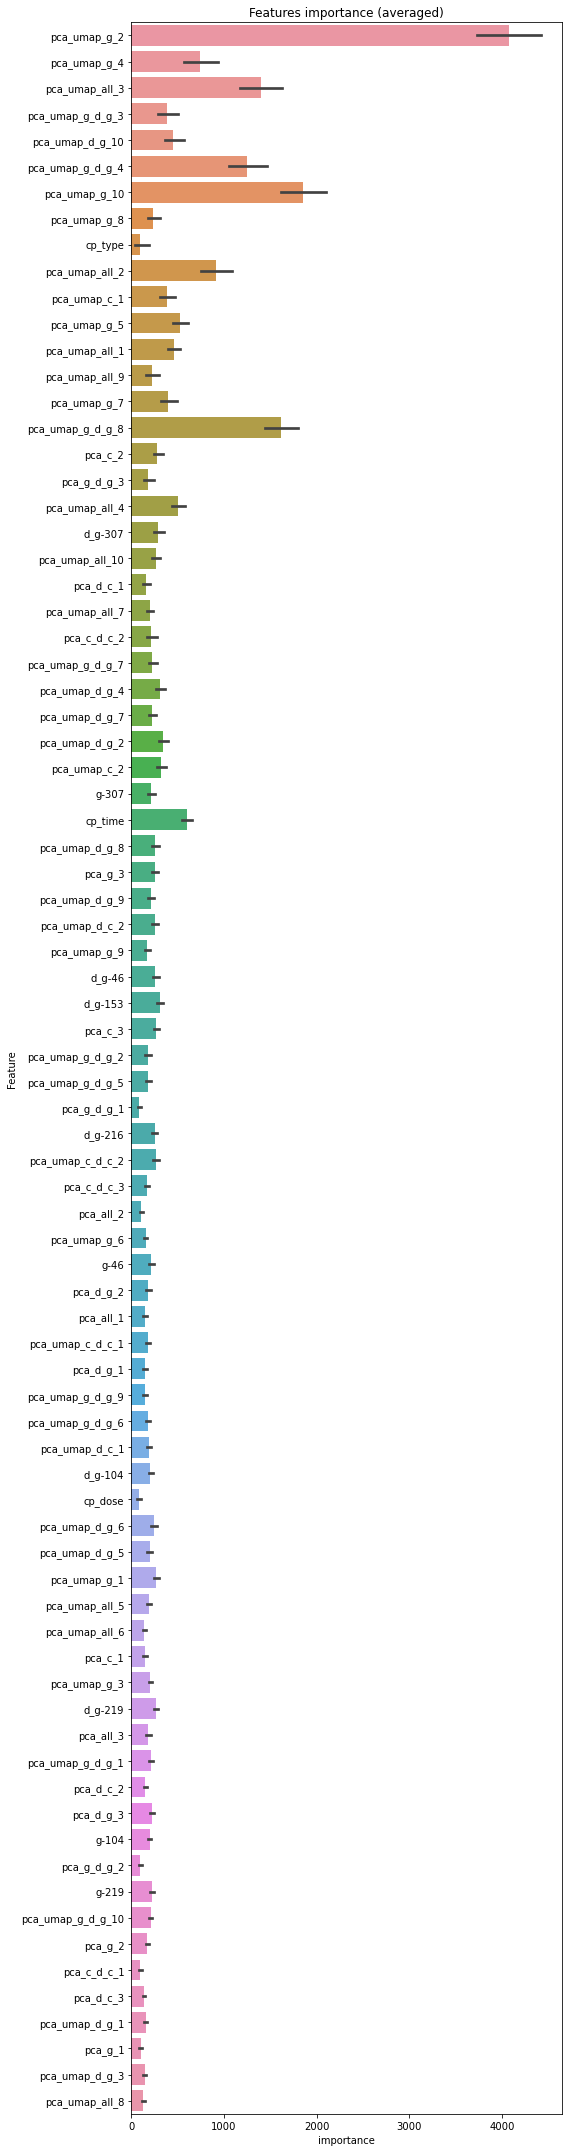

In [49]:
show_feature_importance(feature_importance_df)

In [50]:
feature_importance_df.to_csv(f'feature_importance_df.{Version}.csv', index=False)